### Анализ эффективности удержания

In [1]:
import os
import tqdm
import itertools
import scipy as sp
import scipy.stats as st
import statsmodels as stm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.multitest import multipletests

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

Проанализируем данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти.

Измерены следующие признаки:

*  state — штат США
*  account_length — длительность использования аккаунта
*  area_code — деление пользователей на псевдорегионы, использующееся в телекоме
*  intl_plan — подключена ли у пользователя услуга международного общения
*  vmail_plan — подключена ли у пользователя услуга голосовых сообщений
*  vmail_message — количество голосых сообщений, который пользователь отправил / принял
*  day_calls — сколько пользователь совершил дневных звонков
*  day_mins — сколько пользователь проговорил минут в течение дня
*  day_charge — сколько пользователь заплатил за свою дневную активность
*  eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
*  night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
*  intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
*  custserv_calls — сколько раз пользователь позвонил в службу поддержки
*  treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)

* mes_estim — оценка интенсивности пользования интернет мессенджерами
* churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'churn_analysis.csv',
 'customer_retention.ipynb',
 'stat.proporion_conf_int.ipynb',
 'stat.two_proportions_diff_test.ipynb']

In [3]:
df = pd.read_csv(os.listdir()[1])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      3333 non-null   int64  
 1   state           3333 non-null   object 
 2   account_length  3333 non-null   int64  
 3   area_code       3333 non-null   int64  
 4   intl_plan       3333 non-null   object 
 5   vmail_plan      3333 non-null   object 
 6   vmail_message   3333 non-null   int64  
 7   day_mins        3333 non-null   float64
 8   day_calls       3333 non-null   int64  
 9   day_charge      3333 non-null   float64
 10  eve_mins        3333 non-null   float64
 11  eve_calls       3333 non-null   int64  
 12  eve_charge      3333 non-null   float64
 13  night_mins      3333 non-null   float64
 14  night_calls     3333 non-null   int64  
 15  night_charge    3333 non-null   float64
 16  intl_mins       3333 non-null   float64
 17  intl_calls      3333 non-null   i

In [5]:
df.head()

,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


In [6]:
df.describe()

,Unnamed: 0,account_length,area_code,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim
count,3333.00000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,1666.00000,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.990999,0.484236
std,962.29855,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.819138,0.138560
min,0.00000,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
25%,833.00000,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,0.390000
50%,1666.00000,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,1.000000,0.480000
75%,2499.00000,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,2.000000,0.580000
max,3332.00000,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,2.000000,0.960000



Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn. Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции 

In [7]:
df['state'].nunique()

51

In [8]:
df['state'].unique()

array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI',
       'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC',
       'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR',
       'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC',
       'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND'], dtype=object)

In [9]:
len(list(itertools.combinations(df['state'].unique().tolist(), 2)))

1275

In [10]:
state_combinations = list(itertools.combinations(df['state'].unique().tolist(), 2))

In [11]:
pd.crosstab(df[(df['treatment']==1)&
               (df['state'].isin(state_combinations[0]))]['state'],
            df[(df['treatment']==1)&
               (df['state'].isin(state_combinations[0]))]['churn'])

churn,False.,True.
state,,
KS,18,7
OH,22,2


In [12]:
pd.crosstab(df[(df['treatment']==1)&
               (df['state'].isin(state_combinations[0]))]['state'],
            df[(df['treatment']==1)&
               (df['state'].isin(state_combinations[0]))]['churn']).values

array([[18,  7],
       [22,  2]], dtype=int64)

In [13]:
def check_chi2_requirements(array):
    assert array.size==4
    
    n = array.sum()
    a = array[0, 0]
    d = array[1, 1]
    b = array[0, 1]
    c = array[1, 0]
    
    check_flag = None
    c1 = n > 40
    c2 = (a+c)*(a+b)/n > 5
    c3 = (a+c)*(c+d)/n > 5
    c4 = (b+d)*(a+d)/n > 5
    c5 = (b+d)*(c+d)/n > 5
    
    print(f'[{c1}] n > 40')
    print(f'[{c2}] (a+c)*(a+b)/n: {(a+c)*(a+b)/n}\n[{c3}] (a+c)*(c+d)/n: {(a+c)*(c+d)/n}' +
          f'\n[{c4}] (b+d)*(a+d)/n: {(b+d)*(a+d)/n}\n[{c5}] (b+d)*(c+d)/n: {(b+d)*(c+d)/n}'
         )
    print('\n')

In [14]:
_treatment = 1
chi2_tests = []
for state in tqdm.tqdm(state_combinations):
    array_crosstab = pd.crosstab(df[(df['treatment']==_treatment)&
                                    (df['state'].isin(state))]['state'],
                                 df[(df['treatment']==_treatment)&
                                    (df['state'].isin(state))]['churn']).values
    check_chi2_requirements(array_crosstab)
    _, p_value, _, _ = sp.stats.chi2_contingency(array_crosstab, correction=False)
    chi2_tests.append(p_value)

  0%|▎                                                                                | 4/1275 [00:00<00:37, 34.34it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 20.408163265306122
[True] (a+c)*(c+d)/n: 19.591836734693878
[False] (b+d)*(a+d)/n: 3.673469387755102
[False] (b+d)*(c+d)/n: 4.408163265306122


[True] n > 40
[True] (a+c)*(a+b)/n: 19.387755102040817
[True] (a+c)*(c+d)/n: 18.612244897959183
[False] (b+d)*(a+d)/n: 4.938775510204081
[True] (b+d)*(c+d)/n: 5.387755102040816


[False] n > 40
[True] (a+c)*(a+b)/n: 19.07894736842105
[True] (a+c)*(c+d)/n: 9.921052631578947
[False] (b+d)*(a+d)/n: 4.7368421052631575
[False] (b+d)*(c+d)/n: 3.0789473684210527


[True] n > 40
[True] (a+c)*(a+b)/n: 23.454545454545453
[True] (a+c)*(c+d)/n: 19.545454545454547
[True] (b+d)*(a+d)/n: 6.9818181818181815
[True] (b+d)*(c+d)/n: 5.454545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 17.857142857142858
[True] (a+c)*(c+d)/n: 17.142857142857142
[True] (b+d)*(a+d)/n: 7.142857142857143
[True] (b+d)*(c+d)/n: 6.857142857142857


[True] n > 40
[True] (a+c)*(a+b)/n: 19.02173913043478
[True] (a+c)*(c+d)/n: 15.978260869565217
[True] (

  1%|▉                                                                               | 15/1275 [00:00<00:31, 40.25it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.736842105263158
[True] (a+c)*(c+d)/n: 25.263157894736842
[False] (b+d)*(a+d)/n: 4.842105263157895
[True] (b+d)*(c+d)/n: 6.7368421052631575


[True] n > 40
[True] (a+c)*(a+b)/n: 18.208333333333332
[True] (a+c)*(c+d)/n: 19.791666666666668
[True] (b+d)*(a+d)/n: 5.625
[True] (b+d)*(c+d)/n: 5.208333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 19.148936170212767
[True] (a+c)*(c+d)/n: 16.851063829787233
[True] (b+d)*(a+d)/n: 5.148936170212766
[True] (b+d)*(c+d)/n: 5.148936170212766


[False] n > 40
[True] (a+c)*(a+b)/n: 11.625
[True] (a+c)*(c+d)/n: 19.375
[False] (b+d)*(a+d)/n: 4.5
[True] (b+d)*(c+d)/n: 5.625


[True] n > 40
[True] (a+c)*(a+b)/n: 19.607843137254903
[True] (a+c)*(c+d)/n: 20.392156862745097
[False] (b+d)*(a+d)/n: 4.745098039215686
[True] (b+d)*(c+d)/n: 5.607843137254902


[True] n > 40
[True] (a+c)*(a+b)/n: 19.396551724137932
[True] (a+c)*(c+d)/n: 25.603448275862068
[True] (b+d)*(a+d)/n: 5.379310344827586
[True] (b+d)*(c+d)/n: 7.3965517

  2%|█▌                                                                              | 25/1275 [00:00<00:31, 40.22it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 16.382978723404257
[True] (a+c)*(c+d)/n: 18.617021276595743
[True] (b+d)*(a+d)/n: 6.127659574468085
[True] (b+d)*(c+d)/n: 6.382978723404255


[True] n > 40
[True] (a+c)*(a+b)/n: 15.113636363636363
[True] (a+c)*(c+d)/n: 19.886363636363637
[False] (b+d)*(a+d)/n: 4.909090909090909
[True] (b+d)*(c+d)/n: 5.113636363636363


[True] n > 40
[True] (a+c)*(a+b)/n: 18.47826086956522
[True] (a+c)*(c+d)/n: 15.521739130434783
[True] (b+d)*(a+d)/n: 6.0
[True] (b+d)*(c+d)/n: 5.478260869565218


[True] n > 40
[True] (a+c)*(a+b)/n: 19.897959183673468
[True] (a+c)*(c+d)/n: 19.102040816326532
[False] (b+d)*(a+d)/n: 4.285714285714286
[False] (b+d)*(c+d)/n: 4.8979591836734695


[True] n > 40
[True] (a+c)*(a+b)/n: 20.21276595744681
[True] (a+c)*(c+d)/n: 17.78723404255319
[False] (b+d)*(a+d)/n: 3.8297872340425534
[False] (b+d)*(c+d)/n: 4.212765957446808


[False] n > 40
[True] (a+c)*(a+b)/n: 10.263157894736842
[True] (a+c)*(c+d)/n: 19.736842105263158
[False] (b+d)*(a+d)/n: 

  2%|█▊                                                                              | 29/1275 [00:00<00:37, 33.61it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 16.891304347826086
[True] (a+c)*(c+d)/n: 20.108695652173914
[True] (b+d)*(a+d)/n: 5.086956521739131
[False] (b+d)*(c+d)/n: 4.891304347826087


[True] n > 40
[True] (a+c)*(a+b)/n: 16.444444444444443
[True] (a+c)*(c+d)/n: 20.555555555555557
[False] (b+d)*(a+d)/n: 4.622222222222222
[False] (b+d)*(c+d)/n: 4.444444444444445


[True] n > 40
[True] (a+c)*(a+b)/n: 18.877551020408163
[True] (a+c)*(c+d)/n: 18.122448979591837
[True] (b+d)*(a+d)/n: 5.63265306122449
[True] (b+d)*(c+d)/n: 5.877551020408164


[True] n > 40
[True] (a+c)*(a+b)/n: 11.317073170731707
[True] (a+c)*(c+d)/n: 17.682926829268293
[True] (b+d)*(a+d)/n: 5.2682926829268295
[True] (b+d)*(c+d)/n: 7.317073170731708


[True] n > 40
[True] (a+c)*(a+b)/n: 20.408163265306122
[True] (a+c)*(c+d)/n: 19.591836734693878
[False] (b+d)*(a+d)/n: 3.673469387755102
[False] (b+d)*(c+d)/n: 4.408163265306122


[True] n > 40
[True] (a+c)*(a+b)/n: 19.565217391304348
[True] (a+c)*(c+d)/n: 16.434782608695652
[False] (

  3%|██▍                                                                             | 39/1275 [00:00<00:33, 37.18it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.148936170212767
[True] (a+c)*(c+d)/n: 16.851063829787233
[True] (b+d)*(a+d)/n: 5.148936170212766
[True] (b+d)*(c+d)/n: 5.148936170212766


[False] n > 40
[True] (a+c)*(a+b)/n: 10.5
[True] (a+c)*(c+d)/n: 17.5
[True] (b+d)*(a+d)/n: 5.1
[True] (b+d)*(c+d)/n: 7.5


[True] n > 40
[True] (a+c)*(a+b)/n: 20.108695652173914
[True] (a+c)*(c+d)/n: 16.891304347826086
[False] (b+d)*(a+d)/n: 3.9130434782608696
[False] (b+d)*(c+d)/n: 4.108695652173913


[True] n > 40
[True] (a+c)*(a+b)/n: 19.791666666666668
[True] (a+c)*(c+d)/n: 18.208333333333332
[False] (b+d)*(a+d)/n: 4.375
[False] (b+d)*(c+d)/n: 4.791666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 19.318181818181817
[True] (a+c)*(c+d)/n: 14.681818181818182
[False] (b+d)*(a+d)/n: 4.7727272727272725
[False] (b+d)*(c+d)/n: 4.318181818181818


[True] n > 40
[True] (a+c)*(a+b)/n: 17.708333333333332
[True] (a+c)*(c+d)/n: 16.291666666666668
[True] (b+d)*(a+d)/n: 7.291666666666667
[True] (b+d)*(c+d)/n: 6.708333333

  4%|███                                                                             | 49/1275 [00:01<00:32, 38.28it/s]


[True] (a+c)*(a+b)/n: 15.545454545454545
[True] (a+c)*(c+d)/n: 20.454545454545453
[False] (b+d)*(a+d)/n: 4.545454545454546
[False] (b+d)*(c+d)/n: 4.545454545454546


[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[False] (b+d)*(a+d)/n: 4.84
[True] (b+d)*(c+d)/n: 5.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.92452830188679
[True] (a+c)*(c+d)/n: 20.07547169811321
[True] (b+d)*(a+d)/n: 7.3584905660377355
[True] (b+d)*(c+d)/n: 7.9245283018867925


[True] n > 40
[True] (a+c)*(a+b)/n: 19.387755102040817
[True] (a+c)*(c+d)/n: 18.612244897959183
[False] (b+d)*(a+d)/n: 4.938775510204081
[True] (b+d)*(c+d)/n: 5.387755102040816


[False] n > 40
[True] (a+c)*(a+b)/n: 19.594594594594593
[True] (a+c)*(c+d)/n: 9.405405405405405
[False] (b+d)*(a+d)/n: 4.108108108108108
[False] (b+d)*(c+d)/n: 2.5945945945945947


[True] n > 40
[True] (a+c)*(a+b)/n: 18.6046511627907
[True] (a+c)*(c+d)/n: 13.395348837209303
[True] (b+d)*(a+d)/n: 5.627906976744186
[False] (b+d)*(c+d)/n: 4.604651162790

  4%|███▎                                                                            | 53/1275 [00:01<00:34, 35.30it/s]


[True] (a+c)*(a+b)/n: 19.897959183673468
[True] (a+c)*(c+d)/n: 19.102040816326532
[False] (b+d)*(a+d)/n: 4.285714285714286
[False] (b+d)*(c+d)/n: 4.8979591836734695


[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 21.0
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 21.405405405405407
[True] (a+c)*(c+d)/n: 11.594594594594595
[False] (b+d)*(a+d)/n: 2.5945945945945947
[False] (b+d)*(c+d)/n: 1.4054054054054055


[True] n > 40
[True] (a+c)*(a+b)/n: 26.11111111111111
[True] (a+c)*(c+d)/n: 20.88888888888889
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.111111111111111


[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[False] (b+d)*(a+d)/n: 3.5625
[False] (b+d)*(c+d)/n: 4.5


[True] n > 40
[True] (a+c)*(a+b)/n: 18.2
[True] (a+c)*(c+d)/n: 20.8
[False] (b+d)*(a+d)/n: 2.533333333333333
[False] (b+d)*(c+d)/n: 3.2


[False] n > 40
[True] (a+c)*(a+b)/n: 14.23076923076923
[True] (a+c)*(c+d)/n: 22.76923076923077


  5%|███▊                                                                            | 61/1275 [00:01<00:37, 32.38it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 28.0
[False] (b+d)*(a+d)/n: 3.375
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5531914893617
[True] (a+c)*(c+d)/n: 21.4468085106383
[False] (b+d)*(a+d)/n: 2.3404255319148937
[False] (b+d)*(c+d)/n: 2.5531914893617023


[True] n > 40
[True] (a+c)*(a+b)/n: 20.869565217391305
[True] (a+c)*(c+d)/n: 19.130434782608695
[False] (b+d)*(a+d)/n: 3.391304347826087
[False] (b+d)*(c+d)/n: 2.869565217391304


[False] n > 40
[True] (a+c)*(a+b)/n: 13.461538461538462
[True] (a+c)*(c+d)/n: 21.53846153846154
[False] (b+d)*(a+d)/n: 1.5384615384615385
[False] (b+d)*(c+d)/n: 2.4615384615384617


[True] n > 40
[True] (a+c)*(a+b)/n: 22.88
[True] (a+c)*(c+d)/n: 21.12
[False] (b+d)*(a+d)/n: 2.88
[False] (b+d)*(c+d)/n: 2.88


[True] n > 40
[True] (a+c)*(a+b)/n: 28.36842105263158
[True] (a+c)*(c+d)/n: 20.63157894736842
[False] (b+d)*(a+d)/n: 4.0701754385964914
[False] (b+d)*(c+d)/n: 3.3684210526315788


[True] n > 40

  5%|████▎                                                                           | 69/1275 [00:01<00:38, 31.39it/s]


[True] (a+c)*(a+b)/n: 16.285714285714285
[True] (a+c)*(c+d)/n: 21.714285714285715
[False] (b+d)*(a+d)/n: 1.7142857142857142
[False] (b+d)*(c+d)/n: 2.2857142857142856


[True] n > 40
[True] (a+c)*(a+b)/n: 20.425531914893618
[True] (a+c)*(c+d)/n: 19.574468085106382
[False] (b+d)*(a+d)/n: 4.0212765957446805
[False] (b+d)*(c+d)/n: 3.425531914893617


[True] n > 40
[True] (a+c)*(a+b)/n: 21.4468085106383
[True] (a+c)*(c+d)/n: 20.5531914893617
[False] (b+d)*(a+d)/n: 2.6595744680851063
[False] (b+d)*(c+d)/n: 2.4468085106382977


[True] n > 40
[True] (a+c)*(a+b)/n: 19.636363636363637
[True] (a+c)*(c+d)/n: 16.363636363636363
[True] (b+d)*(a+d)/n: 5.090909090909091
[False] (b+d)*(c+d)/n: 3.6363636363636362


[True] n > 40
[True] (a+c)*(a+b)/n: 18.181818181818183
[True] (a+c)*(c+d)/n: 21.818181818181817
[False] (b+d)*(a+d)/n: 1.8181818181818181
[False] (b+d)*(c+d)/n: 2.1818181818181817


[True] n > 40
[True] (a+c)*(a+b)/n: 18.652173913043477
[True] (a+c)*(c+d)/n: 20.347826086956523
[False] (b+d)*

  6%|████▌                                                                           | 73/1275 [00:02<00:40, 29.98it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 20.266666666666666
[True] (a+c)*(c+d)/n: 17.733333333333334
[False] (b+d)*(a+d)/n: 4.2
[False] (b+d)*(c+d)/n: 3.2666666666666666


[True] n > 40
[True] (a+c)*(a+b)/n: 21.5
[True] (a+c)*(c+d)/n: 21.5
[False] (b+d)*(a+d)/n: 2.3958333333333335
[False] (b+d)*(c+d)/n: 2.5


[True] n > 40
[True] (a+c)*(a+b)/n: 21.91304347826087
[True] (a+c)*(c+d)/n: 20.08695652173913
[False] (b+d)*(a+d)/n: 2.0869565217391304
[False] (b+d)*(c+d)/n: 1.9130434782608696


[False] n > 40
[True] (a+c)*(a+b)/n: 11.945945945945946
[True] (a+c)*(c+d)/n: 22.054054054054053
[False] (b+d)*(a+d)/n: 1.135135135135135
[False] (b+d)*(c+d)/n: 1.945945945945946


[False] n > 40
[True] (a+c)*(a+b)/n: 11.0
[True] (a+c)*(c+d)/n: 22.0
[False] (b+d)*(a+d)/n: 1.0833333333333333
[False] (b+d)*(c+d)/n: 2.0


[False] n > 40
[True] (a+c)*(a+b)/n: 10.666666666666666
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 1.3333333333333333
[False] (b+d)*(c+d)/n: 2.6666666666666665


[True] n >

  6%|█████                                                                           | 81/1275 [00:02<00:39, 30.03it/s]


[True] (a+c)*(a+b)/n: 19.133333333333333
[True] (a+c)*(c+d)/n: 21.866666666666667
[False] (b+d)*(a+d)/n: 1.8666666666666667
[False] (b+d)*(c+d)/n: 2.1333333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 18.636363636363637
[True] (a+c)*(c+d)/n: 22.363636363636363
[False] (b+d)*(a+d)/n: 1.4318181818181819
[False] (b+d)*(c+d)/n: 1.6363636363636365


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5
[True] (a+c)*(c+d)/n: 20.5
[False] (b+d)*(a+d)/n: 3.0625
[False] (b+d)*(c+d)/n: 3.5


[False] n > 40
[True] (a+c)*(a+b)/n: 13.2
[True] (a+c)*(c+d)/n: 19.8
[False] (b+d)*(a+d)/n: 2.275
[False] (b+d)*(c+d)/n: 4.2


[True] n > 40
[True] (a+c)*(a+b)/n: 22.0
[True] (a+c)*(c+d)/n: 22.0
[False] (b+d)*(a+d)/n: 2.0
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 21.333333333333332
[True] (a+c)*(c+d)/n: 18.666666666666668
[False] (b+d)*(a+d)/n: 2.7777777777777777
[False] (b+d)*(c+d)/n: 2.3333333333333335




  7%|█████▎                                                                          | 85/1275 [00:02<00:38, 30.89it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.652173913043477
[True] (a+c)*(c+d)/n: 20.347826086956523
[False] (b+d)*(a+d)/n: 2.891304347826087
[False] (b+d)*(c+d)/n: 3.652173913043478


[True] n > 40
[True] (a+c)*(a+b)/n: 15.75609756097561
[True] (a+c)*(c+d)/n: 22.24390243902439
[False] (b+d)*(a+d)/n: 1.3170731707317074
[False] (b+d)*(c+d)/n: 1.7560975609756098


[True] n > 40
[True] (a+c)*(a+b)/n: 20.869565217391305
[True] (a+c)*(c+d)/n: 19.130434782608695
[False] (b+d)*(a+d)/n: 3.391304347826087
[False] (b+d)*(c+d)/n: 2.869565217391304


[False] n > 40
[True] (a+c)*(a+b)/n: 12.307692307692308
[True] (a+c)*(c+d)/n: 19.692307692307693
[False] (b+d)*(a+d)/n: 2.1538461538461537
[False] (b+d)*(c+d)/n: 4.3076923076923075


[True] n > 40
[True] (a+c)*(a+b)/n: 19.133333333333333
[True] (a+c)*(c+d)/n: 21.866666666666667
[False] (b+d)*(a+d)/n: 1.8666666666666667
[False] (b+d)*(c+d)/n: 2.1333333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 21.4468085106383
[True] (a+c)*(c+d)/n: 20.5531914893617
[Fa

  7%|█████▊                                                                          | 93/1275 [00:02<00:34, 33.83it/s]



[True] n > 40
[True] (a+c)*(a+b)/n: 26.81132075471698
[True] (a+c)*(c+d)/n: 22.18867924528302
[False] (b+d)*(a+d)/n: 2.188679245283019
[False] (b+d)*(c+d)/n: 1.8113207547169812


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.3333333333333335
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 17.674418604651162
[True] (a+c)*(c+d)/n: 22.325581395348838
[False] (b+d)*(a+d)/n: 1.3953488372093024
[False] (b+d)*(c+d)/n: 1.6744186046511629


[True] n > 40
[True] (a+c)*(a+b)/n: 21.93877551020408
[True] (a+c)*(c+d)/n: 21.06122448979592
[False] (b+d)*(a+d)/n: 2.816326530612245
[False] (b+d)*(c+d)/n: 2.938775510204082


[True] n > 40
[True] (a+c)*(a+b)/n: 22.615384615384617
[True] (a+c)*(c+d)/n: 19.384615384615383
[False] (b+d)*(a+d)/n: 4.230769230769231
[False] (b+d)*(c+d)/n: 4.615384615384615


[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 21.0
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 3.0




  8%|██████▎                                                                        | 101/1275 [00:02<00:34, 34.34it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 22.0
[True] (a+c)*(c+d)/n: 11.0
[False] (b+d)*(a+d)/n: 1.9166666666666667
[False] (b+d)*(c+d)/n: 1.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.571428571428573
[True] (a+c)*(c+d)/n: 15.428571428571429
[False] (b+d)*(a+d)/n: 3.7142857142857144
[False] (b+d)*(c+d)/n: 2.5714285714285716


[True] n > 40
[True] (a+c)*(a+b)/n: 26.11111111111111
[True] (a+c)*(c+d)/n: 20.88888888888889
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.111111111111111


[True] n > 40
[True] (a+c)*(a+b)/n: 21.5
[True] (a+c)*(c+d)/n: 21.5
[False] (b+d)*(a+d)/n: 2.3958333333333335
[False] (b+d)*(c+d)/n: 2.5


[False] n > 40
[True] (a+c)*(a+b)/n: 20.10810810810811
[True] (a+c)*(c+d)/n: 10.891891891891891
[False] (b+d)*(a+d)/n: 3.5675675675675675
[False] (b+d)*(c+d)/n: 2.108108108108108


[True] n > 40
[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 4.833333333333333
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c

  9%|██████▉                                                                        | 111/1275 [00:03<00:30, 38.07it/s]


[True] (a+c)*(a+b)/n: 17.266666666666666
[True] (a+c)*(c+d)/n: 19.733333333333334
[False] (b+d)*(a+d)/n: 3.7333333333333334
[False] (b+d)*(c+d)/n: 4.266666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 13.461538461538462
[True] (a+c)*(c+d)/n: 21.53846153846154
[False] (b+d)*(a+d)/n: 1.9487179487179487
[False] (b+d)*(c+d)/n: 2.4615384615384617


[True] n > 40
[True] (a+c)*(a+b)/n: 20.142857142857142
[True] (a+c)*(c+d)/n: 26.857142857142858
[False] (b+d)*(a+d)/n: 4.017857142857143
[True] (b+d)*(c+d)/n: 5.142857142857143


[True] n > 40
[True] (a+c)*(a+b)/n: 19.574468085106382
[True] (a+c)*(c+d)/n: 20.425531914893618
[False] (b+d)*(a+d)/n: 3.574468085106383
[False] (b+d)*(c+d)/n: 3.574468085106383


[True] n > 40
[True] (a+c)*(a+b)/n: 19.82608695652174
[True] (a+c)*(c+d)/n: 18.17391304347826
[False] (b+d)*(a+d)/n: 4.173913043478261
[False] (b+d)*(c+d)/n: 3.8260869565217392


[False] n > 40
[True] (a+c)*(a+b)/n: 12.692307692307692
[True] (a+c)*(c+d)/n: 20.307692307692307
[False] (b+d)*(

  9%|███████▎                                                                       | 119/1275 [00:03<00:31, 36.14it/s]


[True] (a+c)*(a+b)/n: 18.545454545454547
[True] (a+c)*(c+d)/n: 15.454545454545455
[True] (b+d)*(a+d)/n: 5.909090909090909
[False] (b+d)*(c+d)/n: 4.545454545454546


[True] n > 40
[True] (a+c)*(a+b)/n: 17.272727272727273
[True] (a+c)*(c+d)/n: 20.727272727272727
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.272727272727273


[True] n > 40
[True] (a+c)*(a+b)/n: 17.695652173913043
[True] (a+c)*(c+d)/n: 19.304347826086957
[False] (b+d)*(a+d)/n: 4.108695652173913
[False] (b+d)*(c+d)/n: 4.695652173913044


[True] n > 40
[True] (a+c)*(a+b)/n: 16.348837209302324
[True] (a+c)*(c+d)/n: 20.651162790697676
[False] (b+d)*(a+d)/n: 2.9302325581395348
[False] (b+d)*(c+d)/n: 3.3488372093023258


[True] n > 40
[True] (a+c)*(a+b)/n: 19.2
[True] (a+c)*(c+d)/n: 16.8
[False] (b+d)*(a+d)/n: 5.0
[False] (b+d)*(c+d)/n: 4.2


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5
[True] (a+c)*(c+d)/n: 20.5
[False] (b+d)*(a+d)/n: 3.6458333333333335
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 20.8695

 10%|███████▊                                                                       | 127/1275 [00:03<00:33, 34.68it/s]


[True] (a+c)*(a+b)/n: 11.243243243243244
[True] (a+c)*(c+d)/n: 20.756756756756758
[False] (b+d)*(a+d)/n: 2.1621621621621623
[False] (b+d)*(c+d)/n: 3.2432432432432434


[False] n > 40
[True] (a+c)*(a+b)/n: 10.333333333333334
[True] (a+c)*(c+d)/n: 20.666666666666668
[False] (b+d)*(a+d)/n: 2.0833333333333335
[False] (b+d)*(c+d)/n: 3.3333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 10.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 2.3333333333333335
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 18.2
[True] (a+c)*(c+d)/n: 20.8
[False] (b+d)*(a+d)/n: 3.066666666666667
[False] (b+d)*(c+d)/n: 3.2


[True] n > 40
[True] (a+c)*(a+b)/n: 17.727272727272727
[True] (a+c)*(c+d)/n: 21.272727272727273
[False] (b+d)*(a+d)/n: 2.6136363636363638
[False] (b+d)*(c+d)/n: 2.727272727272727


[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[False] (b+d)*(a+d)/n: 4.3125
[False] (b+d)*(c+d)/n: 4.5


[False] n > 40
[True] (a+c)*(a+b)/n: 12.4
[True] (a+c)*(c+d)/n

 11%|████████▌                                                                      | 139/1275 [00:03<00:26, 43.32it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 20.266666666666666
[True] (a+c)*(c+d)/n: 17.733333333333334
[False] (b+d)*(a+d)/n: 3.577777777777778
[False] (b+d)*(c+d)/n: 3.2666666666666666


[True] n > 40
[True] (a+c)*(a+b)/n: 17.695652173913043
[True] (a+c)*(c+d)/n: 19.304347826086957
[False] (b+d)*(a+d)/n: 4.108695652173913
[False] (b+d)*(c+d)/n: 4.695652173913044


[True] n > 40
[True] (a+c)*(a+b)/n: 14.926829268292684
[True] (a+c)*(c+d)/n: 21.073170731707318
[False] (b+d)*(a+d)/n: 2.4390243902439024
[False] (b+d)*(c+d)/n: 2.926829268292683


[True] n > 40
[True] (a+c)*(a+b)/n: 19.82608695652174
[True] (a+c)*(c+d)/n: 18.17391304347826
[False] (b+d)*(a+d)/n: 4.173913043478261
[False] (b+d)*(c+d)/n: 3.8260869565217392


[False] n > 40
[True] (a+c)*(a+b)/n: 11.538461538461538
[True] (a+c)*(c+d)/n: 18.46153846153846
[False] (b+d)*(a+d)/n: 3.230769230769231
[True] (b+d)*(c+d)/n: 5.538461538461538


[True] n > 40
[True] (a+c)*(a+b)/n: 18.2
[True] (a+c)*(c+d)/n: 20.8
[False] (b+d)*(a+d)/n: 3.0666666

 12%|█████████▍                                                                     | 152/1275 [00:03<00:22, 50.75it/s]


[True] (a+c)*(a+b)/n: 21.53846153846154
[True] (a+c)*(c+d)/n: 18.46153846153846
[True] (b+d)*(a+d)/n: 5.538461538461538
[True] (b+d)*(c+d)/n: 5.538461538461538


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 4.0


[False] n > 40
[True] (a+c)*(a+b)/n: 20.666666666666668
[True] (a+c)*(c+d)/n: 10.333333333333334
[False] (b+d)*(a+d)/n: 2.9166666666666665
[False] (b+d)*(c+d)/n: 1.6666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 19.428571428571427
[True] (a+c)*(c+d)/n: 14.571428571428571
[False] (b+d)*(a+d)/n: 4.571428571428571
[False] (b+d)*(c+d)/n: 3.4285714285714284


[True] n > 40
[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 4.833333333333333
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5
[True] (a+c)*(c+d)/n: 20.5
[False] (b+d)*(a+d)/n: 3.6458333333333335
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 25.11627906976744
[True] (a+c)*(c+d)

 12%|█████████▊                                                                     | 158/1275 [00:04<00:25, 43.82it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 19.805555555555557
[True] (a+c)*(c+d)/n: 11.194444444444445
[False] (b+d)*(a+d)/n: 3.0555555555555554
[False] (b+d)*(c+d)/n: 1.8055555555555556


[False] n > 40
[True] (a+c)*(a+b)/n: 10.771428571428572
[True] (a+c)*(c+d)/n: 18.228571428571428
[False] (b+d)*(a+d)/n: 2.5714285714285716
[False] (b+d)*(c+d)/n: 3.7714285714285714


[False] n > 40
[True] (a+c)*(a+b)/n: 12.857142857142858
[True] (a+c)*(c+d)/n: 11.142857142857142
[False] (b+d)*(a+d)/n: 2.142857142857143
[False] (b+d)*(c+d)/n: 1.8571428571428572


[False] n > 40
[True] (a+c)*(a+b)/n: 22.0
[True] (a+c)*(c+d)/n: 11.0
[False] (b+d)*(a+d)/n: 3.6923076923076925
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 27.26086956521739
[True] (a+c)*(c+d)/n: 10.73913043478261
[True] (b+d)*(a+d)/n: 5.043478260869565
[False] (b+d)*(c+d)/n: 2.260869565217391


[False] n > 40
[True] (a+c)*(a+b)/n: 15.67741935483871
[True] (a+c)*(c+d)/n: 11.32258064516129
[False] (b+d)*(a+d)/n: 2.322580645161290

 13%|██████████                                                                     | 163/1275 [00:04<00:26, 41.22it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 11.194444444444445
[True] (a+c)*(c+d)/n: 19.805555555555557
[False] (b+d)*(a+d)/n: 1.9444444444444444
[False] (b+d)*(c+d)/n: 3.1944444444444446


[False] n > 40
[True] (a+c)*(a+b)/n: 9.848484848484848
[True] (a+c)*(c+d)/n: 15.151515151515152
[False] (b+d)*(a+d)/n: 4.121212121212121
[False] (b+d)*(c+d)/n: 4.848484848484849


[False] n > 40
[True] (a+c)*(a+b)/n: 17.575757575757574
[True] (a+c)*(c+d)/n: 11.424242424242424
[False] (b+d)*(a+d)/n: 2.4242424242424243
[False] (b+d)*(c+d)/n: 1.5757575757575757


[False] n > 40
[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 10.4
[False] (b+d)*(a+d)/n: 3.8
[False] (b+d)*(c+d)/n: 2.6


[False] n > 40
[True] (a+c)*(a+b)/n: 16.625
[True] (a+c)*(c+d)/n: 11.375
[False] (b+d)*(a+d)/n: 2.375
[False] (b+d)*(c+d)/n: 1.625


[False] n > 40
[True] (a+c)*(a+b)/n: 10.323529411764707
[True] (a+c)*(c+d)/n: 16.676470588235293
[False] (b+d)*(a+d)/n: 3.2941176470588234
[False] (b+d)*(c+d)/n: 4.323529411764706


[False] n > 40

 14%|██████████▋                                                                    | 173/1275 [00:04<00:27, 40.31it/s]


[True] (a+c)*(a+b)/n: 11.514285714285714
[True] (a+c)*(c+d)/n: 19.485714285714284
[False] (b+d)*(a+d)/n: 1.4857142857142858
[False] (b+d)*(c+d)/n: 2.5142857142857142


[False] n > 40
[True] (a+c)*(a+b)/n: 11.5
[True] (a+c)*(c+d)/n: 11.5
[False] (b+d)*(a+d)/n: 1.6153846153846154
[False] (b+d)*(c+d)/n: 1.5


[False] n > 40
[True] (a+c)*(a+b)/n: 10.56
[True] (a+c)*(c+d)/n: 11.44
[False] (b+d)*(a+d)/n: 1.56
[False] (b+d)*(c+d)/n: 1.56


[False] n > 40
[True] (a+c)*(a+b)/n: 10.08
[True] (a+c)*(c+d)/n: 10.92
[False] (b+d)*(a+d)/n: 1.92
[False] (b+d)*(c+d)/n: 2.08


[False] n > 40
[True] (a+c)*(a+b)/n: 18.529411764705884
[True] (a+c)*(c+d)/n: 11.470588235294118
[False] (b+d)*(a+d)/n: 2.4705882352941178
[False] (b+d)*(c+d)/n: 1.5294117647058822


[False] n > 40
[True] (a+c)*(a+b)/n: 18.181818181818183
[True] (a+c)*(c+d)/n: 11.818181818181818
[False] (b+d)*(a+d)/n: 1.9090909090909092
[False] (b+d)*(c+d)/n: 1.1818181818181819


[False] n > 40
[True] (a+c)*(a+b)/n: 19.45945945945946
[True] (a+c)

 14%|███████████                                                                    | 178/1275 [00:04<00:28, 38.95it/s]


[False] n > 40
[True] (a+c)*(a+b)/n: 11.594594594594595
[True] (a+c)*(c+d)/n: 21.405405405405407
[False] (b+d)*(a+d)/n: 1.4054054054054055
[False] (b+d)*(c+d)/n: 2.5945945945945947


[False] n > 40
[True] (a+c)*(a+b)/n: 11.088235294117647
[True] (a+c)*(c+d)/n: 17.91176470588235
[False] (b+d)*(a+d)/n: 2.0588235294117645
[False] (b+d)*(c+d)/n: 3.088235294117647


[False] n > 40
[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 10.4
[False] (b+d)*(a+d)/n: 3.8
[False] (b+d)*(c+d)/n: 2.6


[False] n > 40
[True] (a+c)*(a+b)/n: 15.3
[True] (a+c)*(c+d)/n: 11.7
[False] (b+d)*(a+d)/n: 1.8
[False] (b+d)*(c+d)/n: 1.3


[False] n > 40
[True] (a+c)*(a+b)/n: 10.771428571428572
[True] (a+c)*(c+d)/n: 18.228571428571428
[False] (b+d)*(a+d)/n: 2.5714285714285716
[False] (b+d)*(c+d)/n: 3.7714285714285714


[False] n > 40
[True] (a+c)*(a+b)/n: 11.25
[True] (a+c)*(c+d)/n: 9.75
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.25


[False] n > 40
[True] (a+c)*(a+b)/n: 18.529411764705884
[True] (a+c)*(c+d)/

 15%|███████████▌                                                                   | 187/1275 [00:04<00:28, 38.36it/s]


[True] (a+c)*(a+b)/n: 11.194444444444445
[True] (a+c)*(c+d)/n: 19.805555555555557
[False] (b+d)*(a+d)/n: 1.9444444444444444
[False] (b+d)*(c+d)/n: 3.1944444444444446


[False] n > 40
[True] (a+c)*(a+b)/n: 16.03125
[True] (a+c)*(c+d)/n: 10.96875
[False] (b+d)*(a+d)/n: 2.8125
[False] (b+d)*(c+d)/n: 2.03125


[False] n > 40
[True] (a+c)*(a+b)/n: 9.75
[True] (a+c)*(c+d)/n: 17.25
[False] (b+d)*(a+d)/n: 4.5
[True] (b+d)*(c+d)/n: 5.75


[True] n > 40
[True] (a+c)*(a+b)/n: 26.238095238095237
[True] (a+c)*(c+d)/n: 11.761904761904763
[False] (b+d)*(a+d)/n: 2.761904761904762
[False] (b+d)*(c+d)/n: 1.2380952380952381


[False] n > 40
[True] (a+c)*(a+b)/n: 18.81081081081081
[True] (a+c)*(c+d)/n: 10.18918918918919
[False] (b+d)*(a+d)/n: 4.324324324324325
[False] (b+d)*(c+d)/n: 2.810810810810811


[False] n > 40
[True] (a+c)*(a+b)/n: 17.21875
[True] (a+c)*(c+d)/n: 11.78125
[False] (b+d)*(a+d)/n: 1.875
[False] (b+d)*(c+d)/n: 1.21875


[False] n > 40
[True] (a+c)*(a+b)/n: 21.05263157894737
[True] (a+c

 15%|███████████▉                                                                   | 193/1275 [00:05<00:26, 41.47it/s]


[True] (a+c)*(a+b)/n: 20.10810810810811
[True] (a+c)*(c+d)/n: 10.891891891891891
[False] (b+d)*(a+d)/n: 3.5675675675675675
[False] (b+d)*(c+d)/n: 2.108108108108108


[False] n > 40
[True] (a+c)*(a+b)/n: 11.44
[True] (a+c)*(c+d)/n: 10.56
[False] (b+d)*(a+d)/n: 1.44
[False] (b+d)*(c+d)/n: 1.44


[False] n > 40
[True] (a+c)*(a+b)/n: 10.483870967741936
[True] (a+c)*(c+d)/n: 14.516129032258064
[False] (b+d)*(a+d)/n: 2.903225806451613
[False] (b+d)*(c+d)/n: 3.4838709677419355


[True] n > 40
[True] (a+c)*(a+b)/n: 25.11627906976744
[True] (a+c)*(c+d)/n: 10.883720930232558
[False] (b+d)*(a+d)/n: 4.395348837209302
[False] (b+d)*(c+d)/n: 2.116279069767442


[False] n > 40
[True] (a+c)*(a+b)/n: 20.756756756756758
[True] (a+c)*(c+d)/n: 11.243243243243244
[False] (b+d)*(a+d)/n: 3.108108108108108
[False] (b+d)*(c+d)/n: 1.7567567567567568


[True] n > 40
[True] (a+c)*(a+b)/n: 23.333333333333332
[True] (a+c)*(c+d)/n: 18.666666666666668
[True] (b+d)*(a+d)/n: 7.111111111111111
[True] (b+d)*(c+d)/n: 5.3

 16%|████████████▌                                                                  | 203/1275 [00:05<00:27, 39.33it/s]


[True] (a+c)*(a+b)/n: 25.161290322580644
[True] (a+c)*(c+d)/n: 26.838709677419356
[False] (b+d)*(a+d)/n: 4.838709677419355
[True] (b+d)*(c+d)/n: 5.161290322580645


[True] n > 40
[True] (a+c)*(a+b)/n: 25.471698113207548
[True] (a+c)*(c+d)/n: 19.528301886792452
[False] (b+d)*(a+d)/n: 4.226415094339623
[False] (b+d)*(c+d)/n: 3.4716981132075473


[True] n > 40
[True] (a+c)*(a+b)/n: 24.807692307692307
[True] (a+c)*(c+d)/n: 18.192307692307693
[True] (b+d)*(a+d)/n: 5.019230769230769
[False] (b+d)*(c+d)/n: 3.8076923076923075


[True] n > 40
[True] (a+c)*(a+b)/n: 25.333333333333332
[True] (a+c)*(c+d)/n: 12.666666666666666
[False] (b+d)*(a+d)/n: 4.2
[False] (b+d)*(c+d)/n: 2.3333333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 25.178571428571427
[True] (a+c)*(c+d)/n: 21.821428571428573
[False] (b+d)*(a+d)/n: 4.660714285714286
[False] (b+d)*(c+d)/n: 4.178571428571429


[True] n > 40
[True] (a+c)*(a+b)/n: 24.761904761904763
[True] (a+c)*(c+d)/n: 27.238095238095237
[True] (b+d)*(a+d)/n: 5.412698

 16%|████████████▉                                                                  | 208/1275 [00:05<00:28, 37.52it/s]


[True] n > 40
[True] (a+c)*(a+b)/n: 25.471698113207548
[True] (a+c)*(c+d)/n: 19.528301886792452
[False] (b+d)*(a+d)/n: 4.226415094339623
[False] (b+d)*(c+d)/n: 3.4716981132075473


[True] n > 40
[True] (a+c)*(a+b)/n: 23.4
[True] (a+c)*(c+d)/n: 15.6
[True] (b+d)*(a+d)/n: 6.82
[False] (b+d)*(c+d)/n: 4.4


[True] n > 40
[True] (a+c)*(a+b)/n: 25.8
[True] (a+c)*(c+d)/n: 17.2
[False] (b+d)*(a+d)/n: 3.78
[False] (b+d)*(c+d)/n: 2.8


[True] n > 40
[True] (a+c)*(a+b)/n: 24.23076923076923
[True] (a+c)*(c+d)/n: 17.76923076923077
[True] (b+d)*(a+d)/n: 5.769230769230769
[False] (b+d)*(c+d)/n: 4.230769230769231


[True] n > 40
[True] (a+c)*(a+b)/n: 25.714285714285715
[True] (a+c)*(c+d)/n: 16.285714285714285
[False] (b+d)*(a+d)/n: 3.857142857142857
[False] (b+d)*(c+d)/n: 2.7142857142857144




 17%|█████████████▏                                                                 | 212/1275 [00:05<00:32, 32.64it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 24.11764705882353
[True] (a+c)*(c+d)/n: 16.88235294117647
[True] (b+d)*(a+d)/n: 5.882352941176471
[False] (b+d)*(c+d)/n: 4.117647058823529


[True] n > 40
[True] (a+c)*(a+b)/n: 25.555555555555557
[True] (a+c)*(c+d)/n: 20.444444444444443
[False] (b+d)*(a+d)/n: 4.148148148148148
[False] (b+d)*(c+d)/n: 3.5555555555555554


[True] n > 40
[True] (a+c)*(a+b)/n: 25.96153846153846
[True] (a+c)*(c+d)/n: 19.03846153846154
[False] (b+d)*(a+d)/n: 3.6346153846153846
[False] (b+d)*(c+d)/n: 2.9615384615384617


[True] n > 40
[True] (a+c)*(a+b)/n: 25.813953488372093
[True] (a+c)*(c+d)/n: 11.186046511627907
[False] (b+d)*(a+d)/n: 3.627906976744186
[False] (b+d)*(c+d)/n: 1.813953488372093


[True] n > 40
[True] (a+c)*(a+b)/n: 25.714285714285715
[True] (a+c)*(c+d)/n: 10.285714285714286
[False] (b+d)*(a+d)/n: 3.7142857142857144
[False] (b+d)*(c+d)/n: 1.7142857142857142


[True] n > 40

 17%|█████████████▋                                                                 | 220/1275 [00:05<00:40, 26.36it/s]


[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 10.0
[False] (b+d)*(a+d)/n: 4.5
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.88235294117647
[True] (a+c)*(c+d)/n: 18.11764705882353
[False] (b+d)*(a+d)/n: 3.7058823529411766
[False] (b+d)*(c+d)/n: 2.8823529411764706


[True] n > 40
[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 26.4
[False] (b+d)*(a+d)/n: 2.88
[False] (b+d)*(c+d)/n: 3.6


[True] n > 40
[True] (a+c)*(a+b)/n: 24.444444444444443
[True] (a+c)*(c+d)/n: 19.555555555555557
[True] (b+d)*(a+d)/n: 5.555555555555555
[False] (b+d)*(c+d)/n: 4.444444444444445


[True] n > 40
[True] (a+c)*(a+b)/n: 23.47826086956522
[True] (a+c)*(c+d)/n: 12.521739130434783
[True] (b+d)*(a+d)/n: 6.521739130434782
[False] (b+d)*(c+d)/n: 3.4782608695652173




 18%|██████████████                                                                 | 226/1275 [00:06<00:43, 24.08it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 26.11111111111111
[True] (a+c)*(c+d)/n: 20.88888888888889
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.111111111111111


[True] n > 40
[True] (a+c)*(a+b)/n: 25.294117647058822
[True] (a+c)*(c+d)/n: 17.705882352941178
[False] (b+d)*(a+d)/n: 4.392156862745098
[False] (b+d)*(c+d)/n: 3.2941176470588234


[True] n > 40
[True] (a+c)*(a+b)/n: 24.23076923076923
[True] (a+c)*(c+d)/n: 17.76923076923077
[True] (b+d)*(a+d)/n: 5.769230769230769
[False] (b+d)*(c+d)/n: 4.230769230769231


[True] n > 40
[True] (a+c)*(a+b)/n: 26.170212765957448
[True] (a+c)*(c+d)/n: 14.829787234042554
[False] (b+d)*(a+d)/n: 3.3191489361702127
[False] (b+d)*(c+d)/n: 2.1702127659574466


[True] n > 40
[True] (a+c)*(a+b)/n: 24.807692307692307
[True] (a+c)*(c+d)/n: 18.192307692307693
[True] (b+d)*(a+d)/n: 5.019230769230769
[False] (b+d)*(c+d)/n: 3.8076923076923075


[True] n > 40
[True] (a+c)*(a+b)/n: 23.333333333333332
[True] (a+c)*(c+d)/n: 11.666666666666666
[True] (b+d)*(a+d)/n

 18%|██████████████▍                                                                | 233/1275 [00:06<00:37, 28.06it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 25.88235294117647
[True] (a+c)*(c+d)/n: 18.11764705882353
[False] (b+d)*(a+d)/n: 3.7058823529411766
[False] (b+d)*(c+d)/n: 2.8823529411764706


[True] n > 40
[True] (a+c)*(a+b)/n: 25.471698113207548
[True] (a+c)*(c+d)/n: 19.528301886792452
[False] (b+d)*(a+d)/n: 4.226415094339623
[False] (b+d)*(c+d)/n: 3.4716981132075473


[True] n > 40
[True] (a+c)*(a+b)/n: 25.102040816326532
[True] (a+c)*(c+d)/n: 15.89795918367347
[False] (b+d)*(a+d)/n: 4.571428571428571
[False] (b+d)*(c+d)/n: 3.1020408163265305


[True] n > 40
[True] (a+c)*(a+b)/n: 23.20754716981132
[True] (a+c)*(c+d)/n: 17.79245283018868
[True] (b+d)*(a+d)/n: 7.245283018867925
[True] (b+d)*(c+d)/n: 5.2075471698113205


[True] n > 40
[True] (a+c)*(a+b)/n: 26.440677966101696
[True] (a+c)*(c+d)/n: 25.559322033898304
[False] (b+d)*(a+d)/n: 3.2033898305084745
[False] (b+d)*(c+d)/n: 3.440677966101695


[True] n > 40
[True] (a+c)*(a+b)/n: 23.88888888888889
[True] (a+c)*(c+d)/n: 19.11111111111111
[True] 

 19%|██████████████▉                                                                | 241/1275 [00:06<00:32, 31.75it/s]


[True] (a+c)*(a+b)/n: 25.09090909090909
[True] (a+c)*(c+d)/n: 20.90909090909091
[False] (b+d)*(a+d)/n: 4.745454545454545
[False] (b+d)*(c+d)/n: 4.090909090909091


[True] n > 40
[True] (a+c)*(a+b)/n: 23.275862068965516
[True] (a+c)*(c+d)/n: 21.724137931034484
[True] (b+d)*(a+d)/n: 7.396551724137931
[True] (b+d)*(c+d)/n: 6.275862068965517


[True] n > 40
[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 4.833333333333333
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.714285714285715
[True] (a+c)*(c+d)/n: 10.285714285714286
[False] (b+d)*(a+d)/n: 3.7142857142857144
[False] (b+d)*(c+d)/n: 1.7142857142857142


[True] n > 40
[True] (a+c)*(a+b)/n: 24.375
[True] (a+c)*(c+d)/n: 14.625
[True] (b+d)*(a+d)/n: 5.4375
[False] (b+d)*(c+d)/n: 3.375


[True] n > 40
[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 25.0
[False] (b+d)*(a+d)/n: 5.0
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.555555555555557
[True] (a+c)*(c+d)/n: 20.4

 20%|███████████████▍                                                               | 249/1275 [00:06<00:29, 34.52it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 12.307692307692308
[True] (a+c)*(c+d)/n: 19.692307692307693
[False] (b+d)*(a+d)/n: 3.948717948717949
[False] (b+d)*(c+d)/n: 4.3076923076923075


[True] n > 40
[True] (a+c)*(a+b)/n: 18.857142857142858
[True] (a+c)*(c+d)/n: 25.142857142857142
[False] (b+d)*(a+d)/n: 4.714285714285714
[True] (b+d)*(c+d)/n: 6.857142857142857


[True] n > 40
[True] (a+c)*(a+b)/n: 18.106382978723403
[True] (a+c)*(c+d)/n: 18.893617021276597
[True] (b+d)*(a+d)/n: 5.74468085106383
[True] (b+d)*(c+d)/n: 5.1063829787234045


[True] n > 40
[True] (a+c)*(a+b)/n: 18.26086956521739
[True] (a+c)*(c+d)/n: 16.73913043478261
[True] (b+d)*(a+d)/n: 5.021739130434782
[True] (b+d)*(c+d)/n: 5.260869565217392


[False] n > 40
[True] (a+c)*(a+b)/n: 11.538461538461538
[True] (a+c)*(c+d)/n: 18.46153846153846
[False] (b+d)*(a+d)/n: 4.615384615384615
[True] (b+d)*(c+d)/n: 5.538461538461538


[True] n > 40
[True] (a+c)*(a+b)/n: 18.72
[True] (a+c)*(c+d)/n: 20.28
[False] (b+d)*(a+d)/n: 4.62
[True] (

 20%|███████████████▊                                                               | 255/1275 [00:07<00:26, 38.46it/s]


[True] (a+c)*(a+b)/n: 17.872340425531913
[True] (a+c)*(c+d)/n: 17.127659574468087
[True] (b+d)*(a+d)/n: 5.617021276595745
[True] (b+d)*(c+d)/n: 5.872340425531915


[True] n > 40
[True] (a+c)*(a+b)/n: 18.893617021276597
[True] (a+c)*(c+d)/n: 18.106382978723403
[False] (b+d)*(a+d)/n: 4.25531914893617
[False] (b+d)*(c+d)/n: 4.8936170212765955


[True] n > 40
[True] (a+c)*(a+b)/n: 16.90909090909091
[True] (a+c)*(c+d)/n: 14.090909090909092
[True] (b+d)*(a+d)/n: 6.795454545454546
[True] (b+d)*(c+d)/n: 5.909090909090909


[True] n > 40
[True] (a+c)*(a+b)/n: 15.909090909090908
[True] (a+c)*(c+d)/n: 19.09090909090909
[True] (b+d)*(a+d)/n: 5.113636363636363
[False] (b+d)*(c+d)/n: 4.909090909090909


[True] n > 40
[True] (a+c)*(a+b)/n: 16.26086956521739
[True] (a+c)*(c+d)/n: 17.73913043478261
[True] (b+d)*(a+d)/n: 6.260869565217392
[True] (b+d)*(c+d)/n: 6.260869565217392


[True] n > 40
[True] (a+c)*(a+b)/n: 15.023255813953488
[True] (a+c)*(c+d)/n: 18.976744186046513
[True] (b+d)*(a+d)/n: 5.0232

 21%|████████████████▎                                                              | 264/1275 [00:07<00:29, 34.60it/s]


[True] (a+c)*(a+b)/n: 10.18918918918919
[True] (a+c)*(c+d)/n: 18.81081081081081
[False] (b+d)*(a+d)/n: 4.108108108108108
[True] (b+d)*(c+d)/n: 5.1891891891891895


[False] n > 40
[True] (a+c)*(a+b)/n: 9.333333333333334
[True] (a+c)*(c+d)/n: 18.666666666666668
[False] (b+d)*(a+d)/n: 4.0
[True] (b+d)*(c+d)/n: 5.333333333333333


[False] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 9.0
[False] (b+d)*(a+d)/n: 4.75
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 16.8
[True] (a+c)*(c+d)/n: 19.2
[True] (b+d)*(a+d)/n: 5.2
[False] (b+d)*(c+d)/n: 4.8


[True] n > 40
[True] (a+c)*(a+b)/n: 16.363636363636363
[True] (a+c)*(c+d)/n: 19.636363636363637
[False] (b+d)*(a+d)/n: 4.7272727272727275
[False] (b+d)*(c+d)/n: 4.363636363636363


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[True] (b+d)*(a+d)/n: 5.5
[True] (b+d)*(c+d)/n: 6.0




 21%|████████████████▌                                                              | 268/1275 [00:07<00:30, 32.77it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 11.2
[True] (a+c)*(c+d)/n: 16.8
[True] (b+d)*(a+d)/n: 5.4
[True] (b+d)*(c+d)/n: 7.2


[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[False] (b+d)*(a+d)/n: 3.5625
[False] (b+d)*(c+d)/n: 4.5


[True] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 16.333333333333332
[False] (b+d)*(a+d)/n: 4.444444444444445
[False] (b+d)*(c+d)/n: 4.666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 17.73913043478261
[True] (a+c)*(c+d)/n: 16.26086956521739
[True] (b+d)*(a+d)/n: 5.739130434782608
[True] (b+d)*(c+d)/n: 5.739130434782608


[True] n > 40
[True] (a+c)*(a+b)/n: 13.682926829268293
[True] (a+c)*(c+d)/n: 19.317073170731707
[False] (b+d)*(a+d)/n: 4.487804878048781
[False] (b+d)*(c+d)/n: 4.682926829268292


[True] n > 40
[True] (a+c)*(a+b)/n: 18.26086956521739
[True] (a+c)*(c+d)/n: 16.73913043478261
[True] (b+d)*(a+d)/n: 5.021739130434782
[True] (b+d)*(c+d)/n: 5.260869565217392




 22%|█████████████████                                                              | 276/1275 [00:07<00:30, 32.69it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.384615384615385
[True] (a+c)*(c+d)/n: 16.615384615384617
[True] (b+d)*(a+d)/n: 5.230769230769231
[True] (b+d)*(c+d)/n: 7.384615384615385


[True] n > 40
[True] (a+c)*(a+b)/n: 19.2
[True] (a+c)*(c+d)/n: 16.8
[False] (b+d)*(a+d)/n: 3.8
[False] (b+d)*(c+d)/n: 4.2


[True] n > 40
[True] (a+c)*(a+b)/n: 18.893617021276597
[True] (a+c)*(c+d)/n: 18.106382978723403
[False] (b+d)*(a+d)/n: 4.25531914893617
[False] (b+d)*(c+d)/n: 4.8936170212765955


[True] n > 40
[True] (a+c)*(a+b)/n: 18.41860465116279
[True] (a+c)*(c+d)/n: 14.581395348837209
[False] (b+d)*(a+d)/n: 4.651162790697675
[False] (b+d)*(c+d)/n: 4.4186046511627906


[True] n > 40
[True] (a+c)*(a+b)/n: 16.851063829787233
[True] (a+c)*(c+d)/n: 16.148936170212767
[True] (b+d)*(a+d)/n: 7.148936170212766
[True] (b+d)*(c+d)/n: 6.851063829787234


[True] n > 40
[True] (a+c)*(a+b)/n: 19.92452830188679
[True] (a+c)*(c+d)/n: 24.07547169811321
[False] (b+d)*(a+d)/n: 3.2264150943396226
[False] (b+d)*(c+d)/n: 

 22%|█████████████████▌                                                             | 284/1275 [00:07<00:27, 35.43it/s]


[True] (a+c)*(a+b)/n: 15.465116279069768
[True] (a+c)*(c+d)/n: 19.53488372093023
[False] (b+d)*(a+d)/n: 4.651162790697675
[False] (b+d)*(c+d)/n: 4.465116279069767


[True] n > 40
[True] (a+c)*(a+b)/n: 19.387755102040817
[True] (a+c)*(c+d)/n: 18.612244897959183
[True] (b+d)*(a+d)/n: 6.285714285714286
[True] (b+d)*(c+d)/n: 5.387755102040816


[True] n > 40
[True] (a+c)*(a+b)/n: 17.076923076923077
[True] (a+c)*(c+d)/n: 19.923076923076923
[True] (b+d)*(a+d)/n: 7.211538461538462
[True] (b+d)*(c+d)/n: 8.076923076923077


[True] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[False] (b+d)*(a+d)/n: 4.8125
[True] (b+d)*(c+d)/n: 5.5


[False] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 9.333333333333334
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 2.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 17.714285714285715
[True] (a+c)*(c+d)/n: 13.285714285714286
[True] (b+d)*(a+d)/n: 5.5
[False] (b+d)*(c+d)/n: 4.714285714285714


[True] n > 40
[True]

 23%|██████████████████▎                                                            | 296/1275 [00:08<00:22, 43.14it/s]


[True] (a+c)*(a+b)/n: 13.333333333333334
[True] (a+c)*(c+d)/n: 18.666666666666668
[False] (b+d)*(a+d)/n: 2.111111111111111
[False] (b+d)*(c+d)/n: 2.3333333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 17.433962264150942
[True] (a+c)*(c+d)/n: 26.566037735849058
[False] (b+d)*(a+d)/n: 3.7358490566037736
[True] (b+d)*(c+d)/n: 5.433962264150943


[True] n > 40
[True] (a+c)*(a+b)/n: 19.34090909090909
[True] (a+c)*(c+d)/n: 17.65909090909091
[False] (b+d)*(a+d)/n: 3.8181818181818183
[False] (b+d)*(c+d)/n: 3.340909090909091


[True] n > 40
[True] (a+c)*(a+b)/n: 17.093023255813954
[True] (a+c)*(c+d)/n: 17.906976744186046
[False] (b+d)*(a+d)/n: 3.9069767441860463
[False] (b+d)*(c+d)/n: 4.093023255813954


[False] n > 40
[True] (a+c)*(a+b)/n: 12.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 2.8333333333333335
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.425531914893618
[True] (a+c)*(c+d)/n: 21.574468085106382
[False] (b+d)*(a+d)/n: 3.574468085106383
[False] (b+d)*(

 24%|██████████████████▋                                                            | 301/1275 [00:08<00:23, 41.86it/s]


[True] (a+c)*(a+b)/n: 17.073170731707318
[True] (a+c)*(c+d)/n: 17.926829268292682
[False] (b+d)*(a+d)/n: 3.2195121951219514
[False] (b+d)*(c+d)/n: 3.073170731707317


[True] n > 40
[True] (a+c)*(a+b)/n: 17.3953488372093
[True] (a+c)*(c+d)/n: 16.6046511627907
[False] (b+d)*(a+d)/n: 4.395348837209302
[False] (b+d)*(c+d)/n: 4.395348837209302


[False] n > 40
[True] (a+c)*(a+b)/n: 16.15
[True] (a+c)*(c+d)/n: 17.85
[False] (b+d)*(a+d)/n: 3.15
[False] (b+d)*(c+d)/n: 3.15


[True] n > 40
[True] (a+c)*(a+b)/n: 16.5
[True] (a+c)*(c+d)/n: 16.5
[False] (b+d)*(a+d)/n: 4.714285714285714
[False] (b+d)*(c+d)/n: 4.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.733333333333334
[True] (a+c)*(c+d)/n: 20.266666666666666
[False] (b+d)*(a+d)/n: 3.111111111111111
[False] (b+d)*(c+d)/n: 3.7333333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 18.069767441860463
[True] (a+c)*(c+d)/n: 18.930232558139537
[False] (b+d)*(a+d)/n: 2.6511627906976742
[False] (b+d)*(c+d)/n: 3.0697674418604652


[False] n > 40
[True] (a+c

 24%|███████████████████▎                                                           | 311/1275 [00:08<00:24, 39.29it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 17.181818181818183
[True] (a+c)*(c+d)/n: 9.818181818181818
[False] (b+d)*(a+d)/n: 3.4545454545454546
[False] (b+d)*(c+d)/n: 2.1818181818181817


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[False] (b+d)*(a+d)/n: 3.2857142857142856
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5609756097561
[True] (a+c)*(c+d)/n: 18.4390243902439
[False] (b+d)*(a+d)/n: 2.8048780487804876
[False] (b+d)*(c+d)/n: 2.5609756097560976


[True] n > 40
[True] (a+c)*(a+b)/n: 19.2
[True] (a+c)*(c+d)/n: 16.8
[False] (b+d)*(a+d)/n: 4.6
[False] (b+d)*(c+d)/n: 4.2


[False] n > 40
[True] (a+c)*(a+b)/n: 12.108108108108109
[True] (a+c)*(c+d)/n: 15.891891891891891
[False] (b+d)*(a+d)/n: 3.6486486486486487
[True] (b+d)*(c+d)/n: 5.108108108108108


[True] n > 40
[True] (a+c)*(a+b)/n: 18.2
[True] (a+c)*(c+d)/n: 20.8
[False] (b+d)*(a+d)/n: 2.533333333333333
[False] (b+d)*(c+d)/n: 3.2


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d

 25%|███████████████████▌                                                           | 316/1275 [00:08<00:25, 38.15it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.3953488372093
[True] (a+c)*(c+d)/n: 16.6046511627907
[False] (b+d)*(a+d)/n: 4.395348837209302
[False] (b+d)*(c+d)/n: 4.395348837209302


[False] n > 40
[True] (a+c)*(a+b)/n: 14.763157894736842
[True] (a+c)*(c+d)/n: 18.236842105263158
[False] (b+d)*(a+d)/n: 2.6315789473684212
[False] (b+d)*(c+d)/n: 2.763157894736842


[True] n > 40
[True] (a+c)*(a+b)/n: 17.093023255813954
[True] (a+c)*(c+d)/n: 17.906976744186046
[False] (b+d)*(a+d)/n: 3.9069767441860463
[False] (b+d)*(c+d)/n: 4.093023255813954


[False] n > 40
[True] (a+c)*(a+b)/n: 11.25
[True] (a+c)*(c+d)/n: 15.75
[False] (b+d)*(a+d)/n: 3.5
[True] (b+d)*(c+d)/n: 5.25


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[False] (b+d)*(a+d)/n: 3.2857142857142856
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 17.65909090909091
[True] (a+c)*(c+d)/n: 19.34090909090909
[False] (b+d)*(a+d)/n: 3.1818181818181817
[False] (b+d)*(c+d)/n: 3.659090909090909


[False] n > 40
[

 25%|████████████████████                                                           | 324/1275 [00:08<00:25, 37.56it/s]


[True] (a+c)*(a+b)/n: 15.75
[True] (a+c)*(c+d)/n: 17.25
[True] (b+d)*(a+d)/n: 6.0
[True] (b+d)*(c+d)/n: 5.75


[True] n > 40
[True] (a+c)*(a+b)/n: 18.48
[True] (a+c)*(c+d)/n: 25.52
[False] (b+d)*(a+d)/n: 2.28
[False] (b+d)*(c+d)/n: 3.48


[True] n > 40
[True] (a+c)*(a+b)/n: 16.333333333333332
[True] (a+c)*(c+d)/n: 18.666666666666668
[True] (b+d)*(a+d)/n: 5.111111111111111
[True] (b+d)*(c+d)/n: 5.333333333333333


[False] n > 40
[True] (a+c)*(a+b)/n: 16.625
[True] (a+c)*(c+d)/n: 18.375
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 2.625


[True] n > 40
[True] (a+c)*(a+b)/n: 20.652173913043477
[True] (a+c)*(c+d)/n: 17.347826086956523
[False] (b+d)*(a+d)/n: 4.3478260869565215
[False] (b+d)*(c+d)/n: 3.652173913043478


[True] n > 40
[True] (a+c)*(a+b)/n: 21.142857142857142
[True] (a+c)*(c+d)/n: 15.857142857142858
[True] (b+d)*(a+d)/n: 5.877551020408164
[True] (b+d)*(c+d)/n: 5.142857142857143


[True] n > 40
[True] (a+c)*(a+b)/n: 17.266666666666666
[True] (a+c)*(c+d)/n: 19.73333333333

 26%|████████████████████▋                                                          | 334/1275 [00:09<00:23, 40.56it/s]


[True] (a+c)*(a+b)/n: 16.692307692307693
[True] (a+c)*(c+d)/n: 14.307692307692308
[False] (b+d)*(a+d)/n: 4.3076923076923075
[False] (b+d)*(c+d)/n: 3.6923076923076925


[True] n > 40
[True] (a+c)*(a+b)/n: 24.705882352941178
[True] (a+c)*(c+d)/n: 17.294117647058822
[True] (b+d)*(a+d)/n: 5.117647058823529
[False] (b+d)*(c+d)/n: 3.7058823529411766


[True] n > 40
[True] (a+c)*(a+b)/n: 17.733333333333334
[True] (a+c)*(c+d)/n: 20.266666666666666
[False] (b+d)*(a+d)/n: 3.111111111111111
[False] (b+d)*(c+d)/n: 3.7333333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 13.404255319148936
[True] (a+c)*(c+d)/n: 28.595744680851062
[False] (b+d)*(a+d)/n: 2.127659574468085
[False] (b+d)*(c+d)/n: 3.404255319148936


[False] n > 40
[True] (a+c)*(a+b)/n: 21.18421052631579
[True] (a+c)*(c+d)/n: 13.81578947368421
[False] (b+d)*(a+d)/n: 1.5789473684210527
[False] (b+d)*(c+d)/n: 1.1842105263157894


[False] n > 40
[True] (a+c)*(a+b)/n: 13.378378378378379
[True] (a+c)*(c+d)/n: 19.62162162162162
[False] (b+d)

 27%|█████████████████████▎                                                         | 343/1275 [00:09<00:25, 37.20it/s]


[True] (a+c)*(a+b)/n: 16.90909090909091
[True] (a+c)*(c+d)/n: 14.090909090909092
[False] (b+d)*(a+d)/n: 0.9696969696969697
[False] (b+d)*(c+d)/n: 0.9090909090909091


[False] n > 40
[True] (a+c)*(a+b)/n: 13.026315789473685
[True] (a+c)*(c+d)/n: 19.973684210526315
[False] (b+d)*(a+d)/n: 2.6315789473684212
[False] (b+d)*(c+d)/n: 3.026315789473684


[False] n > 40
[True] (a+c)*(a+b)/n: 13.81578947368421
[True] (a+c)*(c+d)/n: 21.18421052631579
[False] (b+d)*(a+d)/n: 1.4210526315789473
[False] (b+d)*(c+d)/n: 1.8157894736842106


[False] n > 40
[True] (a+c)*(a+b)/n: 12.428571428571429
[True] (a+c)*(c+d)/n: 16.571428571428573
[False] (b+d)*(a+d)/n: 3.6
[False] (b+d)*(c+d)/n: 3.4285714285714284


[False] n > 40
[True] (a+c)*(a+b)/n: 18.857142857142858
[True] (a+c)*(c+d)/n: 14.142857142857142
[False] (b+d)*(a+d)/n: 1.0285714285714285
[False] (b+d)*(c+d)/n: 0.8571428571428571


[False] n > 40
[True] (a+c)*(a+b)/n: 19.027027027027028
[True] (a+c)*(c+d)/n: 12.972972972972974
[False] (b+d)*(a+d)/n

 27%|█████████████████████▌                                                         | 347/1275 [00:09<00:27, 33.55it/s]


[True] (a+c)*(a+b)/n: 13.846153846153847
[True] (a+c)*(c+d)/n: 22.153846153846153
[False] (b+d)*(a+d)/n: 1.3846153846153846
[False] (b+d)*(c+d)/n: 1.8461538461538463


[False] n > 40
[True] (a+c)*(a+b)/n: 14.18918918918919
[True] (a+c)*(c+d)/n: 20.81081081081081
[False] (b+d)*(a+d)/n: 0.918918918918919
[False] (b+d)*(c+d)/n: 1.1891891891891893


[False] n > 40
[True] (a+c)*(a+b)/n: 12.535714285714286
[True] (a+c)*(c+d)/n: 14.464285714285714
[False] (b+d)*(a+d)/n: 0.42857142857142855
[False] (b+d)*(c+d)/n: 0.5357142857142857


[False] n > 40
[True] (a+c)*(a+b)/n: 11.555555555555555
[True] (a+c)*(c+d)/n: 14.444444444444445
[False] (b+d)*(a+d)/n: 0.4074074074074074
[False] (b+d)*(c+d)/n: 0.5555555555555556


[False] n > 40
[True] (a+c)*(a+b)/n: 13.88888888888889
[True] (a+c)*(c+d)/n: 11.11111111111111
[False] (b+d)*(a+d)/n: 1.2592592592592593
[False] (b+d)*(c+d)/n: 0.8888888888888888


[False] n > 40
[True] (a+c)*(a+b)/n: 19.833333333333332
[True] (a+c)*(c+d)/n: 14.166666666666666
[False

 28%|█████████████████████▉                                                         | 355/1275 [00:09<00:27, 33.05it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 13.076923076923077
[True] (a+c)*(c+d)/n: 20.923076923076923
[False] (b+d)*(a+d)/n: 2.5641025641025643
[False] (b+d)*(c+d)/n: 3.076923076923077


[False] n > 40
[True] (a+c)*(a+b)/n: 13.419354838709678
[True] (a+c)*(c+d)/n: 12.580645161290322
[False] (b+d)*(a+d)/n: 1.7741935483870968
[False] (b+d)*(c+d)/n: 2.4193548387096775


[False] n > 40
[True] (a+c)*(a+b)/n: 14.23076923076923
[True] (a+c)*(c+d)/n: 22.76923076923077
[False] (b+d)*(a+d)/n: 0.8717948717948718
[False] (b+d)*(c+d)/n: 1.2307692307692308


[False] n > 40
[True] (a+c)*(a+b)/n: 13.75
[True] (a+c)*(c+d)/n: 19.25
[False] (b+d)*(a+d)/n: 1.5
[False] (b+d)*(c+d)/n: 1.75


[False] n > 40
[True] (a+c)*(a+b)/n: 12.972972972972974
[True] (a+c)*(c+d)/n: 19.027027027027028
[False] (b+d)*(a+d)/n: 2.7027027027027026
[False] (b+d)*(c+d)/n: 2.972972972972973


[False] n > 40
[True] (a+c)*(a+b)/n: 16.46875
[True] (a+c)*(c+d)/n: 14.53125
[False] (b+d)*(a+d)/n: 0.5
[False] (b+d)*(c+d)/n: 0.46875


[False]

 28%|██████████████████████▍                                                        | 363/1275 [00:09<00:26, 33.80it/s]


[True] (a+c)*(a+b)/n: 13.378378378378379
[True] (a+c)*(c+d)/n: 19.62162162162162
[False] (b+d)*(a+d)/n: 2.054054054054054
[False] (b+d)*(c+d)/n: 2.3783783783783785


[False] n > 40
[True] (a+c)*(a+b)/n: 12.5
[True] (a+c)*(c+d)/n: 12.5
[False] (b+d)*(a+d)/n: 1.6666666666666667
[False] (b+d)*(c+d)/n: 2.5


[False] n > 40
[True] (a+c)*(a+b)/n: 14.166666666666666
[True] (a+c)*(c+d)/n: 19.833333333333332
[False] (b+d)*(a+d)/n: 0.9444444444444444
[False] (b+d)*(c+d)/n: 1.1666666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 13.81578947368421
[True] (a+c)*(c+d)/n: 21.18421052631579
[False] (b+d)*(a+d)/n: 1.4210526315789473
[False] (b+d)*(c+d)/n: 1.8157894736842106


[False] n > 40
[True] (a+c)*(a+b)/n: 13.676470588235293
[True] (a+c)*(c+d)/n: 17.323529411764707
[False] (b+d)*(a+d)/n: 1.588235294117647
[False] (b+d)*(c+d)/n: 1.6764705882352942


[False] n > 40
[True] (a+c)*(a+b)/n: 12.236842105263158
[True] (a+c)*(c+d)/n: 18.763157894736842
[False] (b+d)*(a+d)/n: 4.052631578947368
[False] (

 29%|██████████████████████▋                                                        | 367/1275 [00:10<00:27, 33.22it/s]


[True] (a+c)*(a+b)/n: 12.692307692307692
[True] (a+c)*(c+d)/n: 20.307692307692307
[False] (b+d)*(a+d)/n: 3.230769230769231
[False] (b+d)*(c+d)/n: 3.6923076923076925


[False] n > 40
[True] (a+c)*(a+b)/n: 18.441176470588236
[True] (a+c)*(c+d)/n: 14.558823529411764
[False] (b+d)*(a+d)/n: 0.5294117647058824
[False] (b+d)*(c+d)/n: 0.4411764705882353


[False] n > 40
[True] (a+c)*(a+b)/n: 22.5
[True] (a+c)*(c+d)/n: 13.5
[False] (b+d)*(a+d)/n: 2.1
[False] (b+d)*(c+d)/n: 1.5


[True] n > 40
[True] (a+c)*(a+b)/n: 12.209302325581396
[True] (a+c)*(c+d)/n: 22.790697674418606
[False] (b+d)*(a+d)/n: 4.27906976744186
[True] (b+d)*(c+d)/n: 5.209302325581396


[False] n > 40
[True] (a+c)*(a+b)/n: 13.461538461538462
[True] (a+c)*(c+d)/n: 21.53846153846154
[False] (b+d)*(a+d)/n: 1.9487179487179487
[False] (b+d)*(c+d)/n: 2.4615384615384617


[False] n > 40
[True] (a+c)*(a+b)/n: 14.444444444444445
[True] (a+c)*(c+d)/n: 11.555555555555555
[False] (b+d)*(a+d)/n: 0.5925925925925926
[False] (b+d)*(c+d)/n: 0.

 29%|███████████████████████▏                                                       | 375/1275 [00:10<00:26, 34.04it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 26.666666666666668
[True] (a+c)*(c+d)/n: 13.333333333333334
[False] (b+d)*(a+d)/n: 2.7777777777777777
[False] (b+d)*(c+d)/n: 1.6666666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 13.846153846153847
[True] (a+c)*(c+d)/n: 22.153846153846153
[False] (b+d)*(a+d)/n: 1.3846153846153846
[False] (b+d)*(c+d)/n: 1.8461538461538463


[True] n > 40
[True] (a+c)*(a+b)/n: 19.654545454545456
[True] (a+c)*(c+d)/n: 27.345454545454544
[False] (b+d)*(a+d)/n: 3.6363636363636362
[False] (b+d)*(c+d)/n: 4.654545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 18.333333333333332
[True] (a+c)*(c+d)/n: 26.666666666666668
[False] (b+d)*(a+d)/n: 3.8333333333333335
[True] (b+d)*(c+d)/n: 5.333333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 12.76595744680851
[True] (a+c)*(c+d)/n: 27.23404255319149
[False] (b+d)*(a+d)/n: 2.6808510638297873
[False] (b+d)*(c+d)/n: 4.76595744680851


[True] n > 40
[True] (a+c)*(a+b)/n: 21.96551724137931
[True] (a+c)*(c+d)/n: 27.03448275862069
[F

 30%|███████████████████████▋                                                       | 383/1275 [00:10<00:27, 32.89it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 15.48
[True] (a+c)*(c+d)/n: 27.52
[False] (b+d)*(a+d)/n: 2.94
[False] (b+d)*(c+d)/n: 4.48


[True] n > 40
[True] (a+c)*(a+b)/n: 18.818181818181817
[True] (a+c)*(c+d)/n: 26.181818181818183
[False] (b+d)*(a+d)/n: 4.181818181818182
[True] (b+d)*(c+d)/n: 5.818181818181818


[True] n > 40
[True] (a+c)*(a+b)/n: 19.654545454545456
[True] (a+c)*(c+d)/n: 27.345454545454544
[False] (b+d)*(a+d)/n: 3.6363636363636362
[False] (b+d)*(c+d)/n: 4.654545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 15.76923076923077
[True] (a+c)*(c+d)/n: 25.23076923076923
[False] (b+d)*(a+d)/n: 4.019230769230769
[True] (b+d)*(c+d)/n: 6.769230769230769


[True] n > 40
[True] (a+c)*(a+b)/n: 17.307692307692307
[True] (a+c)*(c+d)/n: 27.692307692307693
[False] (b+d)*(a+d)/n: 3.0961538461538463
[False] (b+d)*(c+d)/n: 4.3076923076923075


[True] n > 40
[True] (a+c)*(a+b)/n: 17.925925925925927
[True] (a+c)*(c+d)/n: 26.074074074074073
[False] (b+d)*(a+d)/n: 4.074074074074074
[True] (b+d)*(c+

 31%|████████████████████████▎                                                      | 392/1275 [00:10<00:24, 36.30it/s]


[True] (a+c)*(a+b)/n: 17.037735849056602
[True] (a+c)*(c+d)/n: 25.962264150943398
[False] (b+d)*(a+d)/n: 3.9622641509433962
[True] (b+d)*(c+d)/n: 6.037735849056604


[True] n > 40
[True] (a+c)*(a+b)/n: 20.571428571428573
[True] (a+c)*(c+d)/n: 27.428571428571427
[False] (b+d)*(a+d)/n: 3.7142857142857144
[False] (b+d)*(c+d)/n: 4.571428571428571


[True] n > 40
[True] (a+c)*(a+b)/n: 27.85185185185185
[True] (a+c)*(c+d)/n: 19.14814814814815
[False] (b+d)*(a+d)/n: 3.759259259259259
[False] (b+d)*(c+d)/n: 2.8518518518518516


[True] n > 40
[True] (a+c)*(a+b)/n: 11.266666666666667
[True] (a+c)*(c+d)/n: 27.733333333333334
[False] (b+d)*(a+d)/n: 2.2666666666666666
[False] (b+d)*(c+d)/n: 4.266666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 10.363636363636363
[True] (a+c)*(c+d)/n: 27.636363636363637
[False] (b+d)*(a+d)/n: 2.1818181818181817
[False] (b+d)*(c+d)/n: 4.363636363636363


[True] n > 40
[True] (a+c)*(a+b)/n: 10.090909090909092
[True] (a+c)*(c+d)/n: 26.90909090909091
[False] (b+d)*(a

 31%|████████████████████████▌                                                      | 396/1275 [00:10<00:25, 35.00it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.714285714285715
[True] (a+c)*(c+d)/n: 26.285714285714285
[False] (b+d)*(a+d)/n: 4.285714285714286
[True] (b+d)*(c+d)/n: 5.714285714285714


[True] n > 40
[True] (a+c)*(a+b)/n: 12.666666666666666
[True] (a+c)*(c+d)/n: 25.333333333333332
[False] (b+d)*(a+d)/n: 3.3333333333333335
[True] (b+d)*(c+d)/n: 6.666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 28.0
[False] (b+d)*(a+d)/n: 3.375
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 17.830188679245282
[True] (a+c)*(c+d)/n: 27.169811320754718
[False] (b+d)*(a+d)/n: 3.4716981132075473
[False] (b+d)*(c+d)/n: 4.830188679245283


[True] n > 40
[True] (a+c)*(a+b)/n: 17.925925925925927
[True] (a+c)*(c+d)/n: 26.074074074074073
[False] (b+d)*(a+d)/n: 4.074074074074074
[True] (b+d)*(c+d)/n: 5.925925925925926


[True] n > 40
[True] (a+c)*(a+b)/n: 14.918367346938776
[True] (a+c)*(c+d)/n: 28.081632653061224
[False] (b+d)*(a+d)/n: 2.5714285714285716
[False] (b+d)*(c+

 32%|█████████████████████████▎                                                     | 409/1275 [00:11<00:19, 44.58it/s]


[True] (a+c)*(a+b)/n: 16.019607843137255
[True] (a+c)*(c+d)/n: 26.980392156862745
[False] (b+d)*(a+d)/n: 3.2941176470588234
[True] (b+d)*(c+d)/n: 5.019607843137255


[True] n > 40
[True] (a+c)*(a+b)/n: 17.98181818181818
[True] (a+c)*(c+d)/n: 25.01818181818182
[False] (b+d)*(a+d)/n: 4.581818181818182
[True] (b+d)*(c+d)/n: 6.9818181818181815


[True] n > 40
[True] (a+c)*(a+b)/n: 25.672131147540984
[True] (a+c)*(c+d)/n: 28.327868852459016
[False] (b+d)*(a+d)/n: 3.6721311475409837
[False] (b+d)*(c+d)/n: 3.6721311475409837


[True] n > 40
[True] (a+c)*(a+b)/n: 19.285714285714285
[True] (a+c)*(c+d)/n: 25.714285714285715
[False] (b+d)*(a+d)/n: 4.517857142857143
[True] (b+d)*(c+d)/n: 6.285714285714286


[True] n > 40
[True] (a+c)*(a+b)/n: 16.764705882352942
[True] (a+c)*(c+d)/n: 28.235294117647058
[False] (b+d)*(a+d)/n: 2.7058823529411766
[False] (b+d)*(c+d)/n: 3.764705882352941


[True] n > 40
[True] (a+c)*(a+b)/n: 21.05263157894737
[True] (a+c)*(c+d)/n: 26.94736842105263
[False] (b+d)*(a+d)

 33%|█████████████████████████▉                                                     | 419/1275 [00:11<00:19, 45.04it/s]


[True] (a+c)*(a+b)/n: 20.571428571428573
[True] (a+c)*(c+d)/n: 27.428571428571427
[False] (b+d)*(a+d)/n: 3.7142857142857144
[False] (b+d)*(c+d)/n: 4.571428571428571


[True] n > 40
[True] (a+c)*(a+b)/n: 19.42222222222222
[True] (a+c)*(c+d)/n: 18.57777777777778
[False] (b+d)*(a+d)/n: 3.7333333333333334
[False] (b+d)*(c+d)/n: 3.422222222222222


[False] n > 40
[True] (a+c)*(a+b)/n: 13.026315789473685
[True] (a+c)*(c+d)/n: 19.973684210526315
[False] (b+d)*(a+d)/n: 2.1052631578947367
[False] (b+d)*(c+d)/n: 3.026315789473684


[True] n > 40
[True] (a+c)*(a+b)/n: 19.714285714285715
[True] (a+c)*(c+d)/n: 22.285714285714285
[False] (b+d)*(a+d)/n: 3.4285714285714284
[False] (b+d)*(c+d)/n: 3.7142857142857144


[True] n > 40
[True] (a+c)*(a+b)/n: 19.303571428571427
[True] (a+c)*(c+d)/n: 27.696428571428573
[False] (b+d)*(a+d)/n: 4.178571428571429
[True] (b+d)*(c+d)/n: 5.303571428571429


[True] n > 40
[True] (a+c)*(a+b)/n: 15.804878048780488
[True] (a+c)*(c+d)/n: 20.195121951219512
[False] (b+d)*

 34%|██████████████████████████▌                                                    | 429/1275 [00:11<00:20, 40.48it/s]


[True] (a+c)*(a+b)/n: 18.186046511627907
[True] (a+c)*(c+d)/n: 15.813953488372093
[True] (b+d)*(a+d)/n: 5.441860465116279
[False] (b+d)*(c+d)/n: 4.186046511627907


[True] n > 40
[True] (a+c)*(a+b)/n: 17.674418604651162
[True] (a+c)*(c+d)/n: 20.325581395348838
[False] (b+d)*(a+d)/n: 2.441860465116279
[False] (b+d)*(c+d)/n: 2.6744186046511627


[True] n > 40
[True] (a+c)*(a+b)/n: 18.08888888888889
[True] (a+c)*(c+d)/n: 18.91111111111111
[False] (b+d)*(a+d)/n: 3.5555555555555554
[False] (b+d)*(c+d)/n: 4.088888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 16.738095238095237
[True] (a+c)*(c+d)/n: 20.261904761904763
[False] (b+d)*(a+d)/n: 2.380952380952381
[False] (b+d)*(c+d)/n: 2.738095238095238


[True] n > 40
[True] (a+c)*(a+b)/n: 18.818181818181817
[True] (a+c)*(c+d)/n: 17.181818181818183
[False] (b+d)*(a+d)/n: 4.545454545454546
[False] (b+d)*(c+d)/n: 3.8181818181818183


[True] n > 40
[True] (a+c)*(a+b)/n: 20.06382978723404
[True] (a+c)*(c+d)/n: 20.93617021276596
[False] (b+d)*(a+d)

 34%|██████████████████████████▉                                                    | 434/1275 [00:11<00:21, 38.80it/s]


[True] (a+c)*(a+b)/n: 10.628571428571428
[True] (a+c)*(c+d)/n: 20.37142857142857
[False] (b+d)*(a+d)/n: 1.6
[False] (b+d)*(c+d)/n: 2.6285714285714286


[False] n > 40
[True] (a+c)*(a+b)/n: 19.714285714285715
[True] (a+c)*(c+d)/n: 10.285714285714286
[False] (b+d)*(a+d)/n: 3.142857142857143
[False] (b+d)*(c+d)/n: 1.7142857142857142


[True] n > 40
[True] (a+c)*(a+b)/n: 18.613636363636363
[True] (a+c)*(c+d)/n: 20.386363636363637
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.6136363636363638


[True] n > 40
[True] (a+c)*(a+b)/n: 18.13953488372093
[True] (a+c)*(c+d)/n: 20.86046511627907
[False] (b+d)*(a+d)/n: 2.046511627906977
[False] (b+d)*(c+d)/n: 2.13953488372093


[True] n > 40
[True] (a+c)*(a+b)/n: 19.085106382978722
[True] (a+c)*(c+d)/n: 19.914893617021278
[False] (b+d)*(a+d)/n: 4.25531914893617
[False] (b+d)*(c+d)/n: 4.085106382978723


[False] n > 40
[True] (a+c)*(a+b)/n: 12.717948717948717
[True] (a+c)*(c+d)/n: 18.28205128205128
[False] (b+d)*(a+d)/n: 2.871794871794872
[Fals

 35%|███████████████████████████▍                                                   | 443/1275 [00:12<00:23, 35.76it/s]


[True] (a+c)*(a+b)/n: 18.91111111111111
[True] (a+c)*(c+d)/n: 18.08888888888889
[False] (b+d)*(a+d)/n: 4.444444444444445
[False] (b+d)*(c+d)/n: 3.911111111111111


[False] n > 40
[True] (a+c)*(a+b)/n: 15.3
[True] (a+c)*(c+d)/n: 20.7
[False] (b+d)*(a+d)/n: 1.9
[False] (b+d)*(c+d)/n: 2.3


[True] n > 40
[True] (a+c)*(a+b)/n: 19.42222222222222
[True] (a+c)*(c+d)/n: 18.57777777777778
[False] (b+d)*(a+d)/n: 3.7333333333333334
[False] (b+d)*(c+d)/n: 3.422222222222222


[False] n > 40
[True] (a+c)*(a+b)/n: 11.842105263157896
[True] (a+c)*(c+d)/n: 18.157894736842106
[False] (b+d)*(a+d)/n: 2.736842105263158
[False] (b+d)*(c+d)/n: 4.842105263157895


[True] n > 40
[True] (a+c)*(a+b)/n: 20.386363636363637
[True] (a+c)*(c+d)/n: 18.613636363636363
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.3863636363636362


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40

 35%|███████████████████████████▋                                                   | 447/1275 [00:12<00:25, 32.85it/s]


[True] (a+c)*(a+b)/n: 19.714285714285715
[True] (a+c)*(c+d)/n: 16.285714285714285
[False] (b+d)*(a+d)/n: 3.2857142857142856
[False] (b+d)*(c+d)/n: 2.7142857142857144


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[True] (b+d)*(a+d)/n: 5.869565217391305
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.78846153846154
[True] (a+c)*(c+d)/n: 26.21153846153846
[False] (b+d)*(a+d)/n: 2.1153846153846154
[False] (b+d)*(c+d)/n: 2.7884615384615383


[True] n > 40
[True] (a+c)*(a+b)/n: 18.595744680851062
[True] (a+c)*(c+d)/n: 19.404255319148938
[False] (b+d)*(a+d)/n: 4.9787234042553195
[False] (b+d)*(c+d)/n: 4.595744680851064


[True] n > 40
[True] (a+c)*(a+b)/n: 17.19047619047619
[True] (a+c)*(c+d)/n: 20.80952380952381
[False] (b+d)*(a+d)/n: 2.0
[False] (b+d)*(c+d)/n: 2.1904761904761907


[True] n > 40
[True] (a+c)*(a+b)/n: 19.645833333333332
[True] (a+c)*(c+d)/n: 21.354166666666668
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.6458333333333335


[

 36%|████████████████████████████▏                                                  | 455/1275 [00:12<00:23, 35.34it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.574468085106382
[True] (a+c)*(c+d)/n: 20.425531914893618
[False] (b+d)*(a+d)/n: 3.574468085106383
[False] (b+d)*(c+d)/n: 3.574468085106383


[False] n > 40
[True] (a+c)*(a+b)/n: 20.37142857142857
[True] (a+c)*(c+d)/n: 10.628571428571428
[False] (b+d)*(a+d)/n: 2.4
[False] (b+d)*(c+d)/n: 1.3714285714285714


[True] n > 40
[True] (a+c)*(a+b)/n: 19.073170731707318
[True] (a+c)*(c+d)/n: 14.926829268292684
[False] (b+d)*(a+d)/n: 4.097560975609756
[False] (b+d)*(c+d)/n: 3.073170731707317


[True] n > 40
[True] (a+c)*(a+b)/n: 25.471698113207548
[True] (a+c)*(c+d)/n: 19.528301886792452
[False] (b+d)*(a+d)/n: 4.226415094339623
[False] (b+d)*(c+d)/n: 3.4716981132075473


[True] n > 40
[True] (a+c)*(a+b)/n: 20.06382978723404
[True] (a+c)*(c+d)/n: 20.93617021276596
[False] (b+d)*(a+d)/n: 2.9361702127659575
[False] (b+d)*(c+d)/n: 3.0638297872340425


[False] n > 40
[True] (a+c)*(a+b)/n: 12.567567567567568
[True] (a+c)*(c+d)/n: 18.43243243243243
[False] (b+d)*(a

 36%|████████████████████████████▋                                                  | 463/1275 [00:12<00:25, 32.21it/s]


[True] (a+c)*(a+b)/n: 27.0
[True] (a+c)*(c+d)/n: 18.0
[True] (b+d)*(a+d)/n: 5.636363636363637
[False] (b+d)*(c+d)/n: 4.0


[False] n > 40
[True] (a+c)*(a+b)/n: 15.3
[True] (a+c)*(c+d)/n: 18.7
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.3


[True] n > 40
[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 18.4
[False] (b+d)*(a+d)/n: 4.6
[False] (b+d)*(c+d)/n: 4.6


[True] n > 40
[True] (a+c)*(a+b)/n: 18.57777777777778
[True] (a+c)*(c+d)/n: 19.42222222222222
[False] (b+d)*(a+d)/n: 3.2666666666666666
[False] (b+d)*(c+d)/n: 3.577777777777778


[True] n > 40
[True] (a+c)*(a+b)/n: 16.761904761904763
[True] (a+c)*(c+d)/n: 15.238095238095237
[True] (b+d)*(a+d)/n: 5.714285714285714
[False] (b+d)*(c+d)/n: 4.761904761904762


[True] n > 40
[True] (a+c)*(a+b)/n: 17.142857142857142
[True] (a+c)*(c+d)/n: 18.857142857142858
[False] (b+d)*(a+d)/n: 3.142857142857143
[False] (b+d)*(c+d)/n: 3.142857142857143


[True] n > 40

 37%|████████████████████████████▉                                                  | 467/1275 [00:12<00:26, 30.34it/s]


[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 4.295454545454546
[False] (b+d)*(c+d)/n: 4.5


[True] n > 40
[True] (a+c)*(a+b)/n: 16.21951219512195
[True] (a+c)*(c+d)/n: 18.78048780487805
[False] (b+d)*(a+d)/n: 3.073170731707317
[False] (b+d)*(c+d)/n: 3.2195121951219514


[True] n > 40
[True] (a+c)*(a+b)/n: 17.3953488372093
[True] (a+c)*(c+d)/n: 16.6046511627907
[False] (b+d)*(a+d)/n: 4.813953488372093
[False] (b+d)*(c+d)/n: 4.395348837209302


[True] n > 40
[True] (a+c)*(a+b)/n: 20.347826086956523
[True] (a+c)*(c+d)/n: 18.652173913043477
[False] (b+d)*(a+d)/n: 3.8043478260869565
[False] (b+d)*(c+d)/n: 3.347826086956522


[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[False] (b+d)*(a+d)/n: 2.727272727272727
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 11.142857142857142
[True] (a+c)*(c+d)/n: 18.857142857142858
[False] (b+d)*(a+d)/n: 2.2857142857142856
[False] (b+d)*(c+d)/n: 3.142857142857143


[False] n > 40
[Tru

 37%|█████████████████████████████▌                                                 | 477/1275 [00:13<00:22, 34.81it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 9.882352941176471
[True] (a+c)*(c+d)/n: 18.11764705882353
[False] (b+d)*(a+d)/n: 2.4705882352941178
[False] (b+d)*(c+d)/n: 3.8823529411764706


[True] n > 40
[True] (a+c)*(a+b)/n: 18.069767441860463
[True] (a+c)*(c+d)/n: 18.930232558139537
[False] (b+d)*(a+d)/n: 3.2093023255813953
[False] (b+d)*(c+d)/n: 3.0697674418604652


[True] n > 40
[True] (a+c)*(a+b)/n: 17.61904761904762
[True] (a+c)*(c+d)/n: 19.38095238095238
[False] (b+d)*(a+d)/n: 2.738095238095238
[False] (b+d)*(c+d)/n: 2.619047619047619


[True] n > 40
[True] (a+c)*(a+b)/n: 19.304347826086957
[True] (a+c)*(c+d)/n: 17.695652173913043
[False] (b+d)*(a+d)/n: 4.5
[False] (b+d)*(c+d)/n: 4.304347826086956


[False] n > 40
[True] (a+c)*(a+b)/n: 12.210526315789474
[True] (a+c)*(c+d)/n: 16.789473684210527
[False] (b+d)*(a+d)/n: 3.5526315789473686
[True] (b+d)*(c+d)/n: 5.2105263157894735


[True] n > 40
[True] (a+c)*(a+b)/n: 19.130434782608695
[True] (a+c)*(c+d)/n: 20.869565217391305
[False] (b+d)*(

 38%|██████████████████████████████                                                 | 485/1275 [00:13<00:23, 34.22it/s]


[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 4.0


[False] n > 40
[True] (a+c)*(a+b)/n: 11.35135135135135
[True] (a+c)*(c+d)/n: 16.64864864864865
[False] (b+d)*(a+d)/n: 3.4054054054054053
[True] (b+d)*(c+d)/n: 5.351351351351352


[True] n > 40
[True] (a+c)*(a+b)/n: 18.069767441860463
[True] (a+c)*(c+d)/n: 18.930232558139537
[False] (b+d)*(a+d)/n: 3.2093023255813953
[False] (b+d)*(c+d)/n: 3.0697674418604652


[True] n > 40
[True] (a+c)*(a+b)/n: 18.57777777777778
[True] (a+c)*(c+d)/n: 19.42222222222222
[False] (b+d)*(a+d)/n: 3.2666666666666666
[False] (b+d)*(c+d)/n: 3.577777777777778


[True] n > 40
[True] (a+c)*(a+b)/n: 15.75609756097561
[True] (a+c)*(c+d)/n: 18.24390243902439
[False] (b+d)*(a+d)/n: 3.4146341463414633
[False] (b+d)*(c+d)/n: 3.7560975609756095


[True] n > 40
[True] (a+c)*(a+b)/n: 16.622222222222224
[True] (a+c)*(c+d)/n: 17.377777777777776
[True] (b+d)*(a+d)/n: 6.111111111111111
[True] (b+d)*(c+d)/n: 5.622222222

 39%|██████████████████████████████▌                                                | 493/1275 [00:13<00:22, 34.09it/s]


[True] (a+c)*(a+b)/n: 18.782608695652176
[True] (a+c)*(c+d)/n: 17.217391304347824
[False] (b+d)*(a+d)/n: 4.782608695652174
[False] (b+d)*(c+d)/n: 4.782608695652174


[True] n > 40
[True] (a+c)*(a+b)/n: 16.682926829268293
[True] (a+c)*(c+d)/n: 19.317073170731707
[False] (b+d)*(a+d)/n: 2.682926829268293
[False] (b+d)*(c+d)/n: 2.682926829268293


[True] n > 40
[True] (a+c)*(a+b)/n: 20.74468085106383
[True] (a+c)*(c+d)/n: 18.25531914893617
[False] (b+d)*(a+d)/n: 4.25531914893617
[False] (b+d)*(c+d)/n: 3.74468085106383


[True] n > 40
[True] (a+c)*(a+b)/n: 21.28
[True] (a+c)*(c+d)/n: 16.72
[True] (b+d)*(a+d)/n: 5.76
[True] (b+d)*(c+d)/n: 5.28


[True] n > 40
[True] (a+c)*(a+b)/n: 19.82608695652174
[True] (a+c)*(c+d)/n: 18.17391304347826
[False] (b+d)*(a+d)/n: 4.173913043478261
[False] (b+d)*(c+d)/n: 3.8260869565217392


[False] n > 40
[True] (a+c)*(a+b)/n: 18.764705882352942
[True] (a+c)*(c+d)/n: 10.235294117647058
[False] (b+d)*(a+d)/n: 2.7941176470588234
[False] (b+d)*(c+d)/n: 1.76470588

 39%|██████████████████████████████▊                                                | 497/1275 [00:13<00:23, 33.32it/s]


[True] (a+c)*(a+b)/n: 20.347826086956523
[True] (a+c)*(c+d)/n: 18.652173913043477
[False] (b+d)*(a+d)/n: 3.8043478260869565
[False] (b+d)*(c+d)/n: 3.347826086956522


[True] n > 40
[True] (a+c)*(a+b)/n: 12.804878048780488
[True] (a+c)*(c+d)/n: 22.195121951219512
[False] (b+d)*(a+d)/n: 2.4878048780487805
[False] (b+d)*(c+d)/n: 3.8048780487804876


[True] n > 40
[True] (a+c)*(a+b)/n: 12.5
[True] (a+c)*(c+d)/n: 27.5
[False] (b+d)*(a+d)/n: 3.1666666666666665
[True] (b+d)*(c+d)/n: 5.5


[False] n > 40
[True] (a+c)*(a+b)/n: 13.181818181818182
[True] (a+c)*(c+d)/n: 15.818181818181818
[False] (b+d)*(a+d)/n: 1.8181818181818181
[False] (b+d)*(c+d)/n: 2.1818181818181817


[False] n > 40
[True] (a+c)*(a+b)/n: 12.236842105263158
[True] (a+c)*(c+d)/n: 18.763157894736842
[False] (b+d)*(a+d)/n: 3.3157894736842106
[False] (b+d)*(c+d)/n: 4.2368421052631575


[False] n > 40
[True] (a+c)*(a+b)/n: 13.026315789473685
[True] (a+c)*(c+d)/n: 19.973684210526315
[False] (b+d)*(a+d)/n: 2.1052631578947367
[False]

 40%|███████████████████████████████▎                                               | 505/1275 [00:13<00:27, 28.38it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 11.571428571428571
[True] (a+c)*(c+d)/n: 15.428571428571429
[False] (b+d)*(a+d)/n: 4.3428571428571425
[False] (b+d)*(c+d)/n: 4.571428571428571


[False] n > 40
[True] (a+c)*(a+b)/n: 17.714285714285715
[True] (a+c)*(c+d)/n: 13.285714285714286
[False] (b+d)*(a+d)/n: 2.2857142857142856
[False] (b+d)*(c+d)/n: 1.7142857142857142


[False] n > 40
[True] (a+c)*(a+b)/n: 17.83783783783784
[True] (a+c)*(c+d)/n: 12.162162162162161
[False] (b+d)*(a+d)/n: 3.5945945945945947
[False] (b+d)*(c+d)/n: 2.8378378378378377


[False] n > 40
[True] (a+c)*(a+b)/n: 16.764705882352942
[True] (a+c)*(c+d)/n: 13.235294117647058
[False] (b+d)*(a+d)/n: 2.235294117647059
[False] (b+d)*(c+d)/n: 1.7647058823529411


[False] n > 40
[True] (a+c)*(a+b)/n: 12.083333333333334
[True] (a+c)*(c+d)/n: 16.916666666666668
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 4.083333333333333




 40%|███████████████████████████████▍                                               | 508/1275 [00:14<00:29, 26.28it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 13.076923076923077
[True] (a+c)*(c+d)/n: 20.923076923076923
[False] (b+d)*(a+d)/n: 2.051282051282051
[False] (b+d)*(c+d)/n: 3.076923076923077


[False] n > 40
[True] (a+c)*(a+b)/n: 13.378378378378379
[True] (a+c)*(c+d)/n: 19.62162162162162
[False] (b+d)*(a+d)/n: 1.6216216216216217
[False] (b+d)*(c+d)/n: 2.3783783783783785


[False] n > 40
[True] (a+c)*(a+b)/n: 11.607142857142858
[True] (a+c)*(c+d)/n: 13.392857142857142
[False] (b+d)*(a+d)/n: 1.5
[False] (b+d)*(c+d)/n: 1.6071428571428572


[False] n > 40
[True] (a+c)*(a+b)/n: 13.333333333333334
[True] (a+c)*(c+d)/n: 10.666666666666666
[False] (b+d)*(a+d)/n: 1.5555555555555556
[False] (b+d)*(c+d)/n: 1.3333333333333333


[False] n > 40
[True] (a+c)*(a+b)/n: 12.777777777777779
[True] (a+c)*(c+d)/n: 10.222222222222221
[False] (b+d)*(a+d)/n: 2.2222222222222223
[False] (b+d)*(c+d)/n: 1.7777777777777777




 40%|███████████████████████████████▊                                               | 514/1275 [00:14<00:29, 25.70it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 13.333333333333334
[False] (b+d)*(a+d)/n: 2.3333333333333335
[False] (b+d)*(c+d)/n: 1.6666666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 18.285714285714285
[True] (a+c)*(c+d)/n: 13.714285714285714
[False] (b+d)*(a+d)/n: 1.8
[False] (b+d)*(c+d)/n: 1.2857142857142858


[False] n > 40
[True] (a+c)*(a+b)/n: 12.307692307692308
[True] (a+c)*(c+d)/n: 19.692307692307693
[False] (b+d)*(a+d)/n: 3.230769230769231
[False] (b+d)*(c+d)/n: 4.3076923076923075


[False] n > 40
[True] (a+c)*(a+b)/n: 12.387096774193548
[True] (a+c)*(c+d)/n: 11.612903225806452
[False] (b+d)*(a+d)/n: 2.935483870967742
[False] (b+d)*(c+d)/n: 3.3870967741935485


[False] n > 40
[True] (a+c)*(a+b)/n: 13.461538461538462
[True] (a+c)*(c+d)/n: 21.53846153846154
[False] (b+d)*(a+d)/n: 1.5384615384615385
[False] (b+d)*(c+d)/n: 2.4615384615384617


[False] n > 40
[True] (a+c)*(a+b)/n: 12.916666666666666
[True] (a+c)*(c+d)/n: 18.083333333333332
[False

 41%|████████████████████████████████▎                                              | 522/1275 [00:14<00:24, 30.55it/s]


[True] (a+c)*(a+b)/n: 12.162162162162161
[True] (a+c)*(c+d)/n: 17.83783783783784
[False] (b+d)*(a+d)/n: 3.4054054054054053
[False] (b+d)*(c+d)/n: 4.162162162162162


[False] n > 40
[True] (a+c)*(a+b)/n: 15.40625
[True] (a+c)*(c+d)/n: 13.59375
[False] (b+d)*(a+d)/n: 1.6875
[False] (b+d)*(c+d)/n: 1.40625


[False] n > 40
[True] (a+c)*(a+b)/n: 12.567567567567568
[True] (a+c)*(c+d)/n: 18.43243243243243
[False] (b+d)*(a+d)/n: 2.7567567567567566
[False] (b+d)*(c+d)/n: 3.5675675675675675


[False] n > 40
[True] (a+c)*(a+b)/n: 11.5
[True] (a+c)*(c+d)/n: 11.5
[False] (b+d)*(a+d)/n: 2.8
[False] (b+d)*(c+d)/n: 3.5


[False] n > 40
[True] (a+c)*(a+b)/n: 13.333333333333334
[True] (a+c)*(c+d)/n: 18.666666666666668
[False] (b+d)*(a+d)/n: 1.6666666666666667
[False] (b+d)*(c+d)/n: 2.3333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 13.026315789473685
[True] (a+c)*(c+d)/n: 19.973684210526315
[False] (b+d)*(a+d)/n: 2.1052631578947367
[False] (b+d)*(c+d)/n: 3.026315789473684


[False] n > 40
[True]

 42%|████████████████████████████████▊                                              | 530/1275 [00:14<00:22, 32.44it/s]


[True] (a+c)*(a+b)/n: 11.447368421052632
[True] (a+c)*(c+d)/n: 17.55263157894737
[False] (b+d)*(a+d)/n: 4.7368421052631575
[True] (b+d)*(c+d)/n: 5.447368421052632


[True] n > 40
[True] (a+c)*(a+b)/n: 13.636363636363637
[True] (a+c)*(c+d)/n: 26.363636363636363
[False] (b+d)*(a+d)/n: 1.3636363636363635
[False] (b+d)*(c+d)/n: 2.6363636363636362


[False] n > 40
[True] (a+c)*(a+b)/n: 11.923076923076923
[True] (a+c)*(c+d)/n: 19.076923076923077
[False] (b+d)*(a+d)/n: 3.8974358974358974
[False] (b+d)*(c+d)/n: 4.923076923076923


[False] n > 40
[True] (a+c)*(a+b)/n: 17.323529411764707
[True] (a+c)*(c+d)/n: 13.676470588235293
[False] (b+d)*(a+d)/n: 1.7647058823529411
[False] (b+d)*(c+d)/n: 1.3235294117647058


[False] n > 40
[True] (a+c)*(a+b)/n: 12.75
[True] (a+c)*(c+d)/n: 21.25
[False] (b+d)*(a+d)/n: 2.55
[False] (b+d)*(c+d)/n: 3.75


[True] n > 40
[True] (a+c)*(a+b)/n: 11.511627906976743
[True] (a+c)*(c+d)/n: 21.488372093023255
[False] (b+d)*(a+d)/n: 4.883720930232558
[True] (b+d)*(c+d)/n:

 42%|█████████████████████████████████▍                                             | 540/1275 [00:15<00:19, 37.45it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 12.272727272727273
[True] (a+c)*(c+d)/n: 14.727272727272727
[False] (b+d)*(a+d)/n: 3.090909090909091
[False] (b+d)*(c+d)/n: 3.272727272727273


[True] n > 40
[True] (a+c)*(a+b)/n: 25.333333333333332
[True] (a+c)*(c+d)/n: 12.666666666666666
[False] (b+d)*(a+d)/n: 4.2
[False] (b+d)*(c+d)/n: 2.3333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 13.076923076923077
[True] (a+c)*(c+d)/n: 20.923076923076923
[False] (b+d)*(a+d)/n: 2.051282051282051
[False] (b+d)*(c+d)/n: 3.076923076923077


[True] n > 40
[True] (a+c)*(a+b)/n: 21.593220338983052
[True] (a+c)*(c+d)/n: 27.406779661016948
[False] (b+d)*(a+d)/n: 4.745762711864407
[True] (b+d)*(c+d)/n: 5.593220338983051


[True] n > 40
[True] (a+c)*(a+b)/n: 15.545454545454545
[True] (a+c)*(c+d)/n: 22.454545454545453
[False] (b+d)*(a+d)/n: 2.727272727272727
[False] (b+d)*(c+d)/n: 3.5454545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 21.224489795918366
[True] (a+c)*(c+d)/n: 18.775510204081634
[False] (b+d)*(

 43%|█████████████████████████████████▊                                             | 545/1275 [00:15<00:20, 35.97it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.875
[True] (a+c)*(c+d)/n: 21.125
[False] (b+d)*(a+d)/n: 3.9375
[False] (b+d)*(c+d)/n: 4.875


[True] n > 40
[True] (a+c)*(a+b)/n: 16.466666666666665
[True] (a+c)*(c+d)/n: 22.533333333333335
[False] (b+d)*(a+d)/n: 2.8
[False] (b+d)*(c+d)/n: 3.466666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 21.02127659574468
[True] (a+c)*(c+d)/n: 16.97872340425532
[True] (b+d)*(a+d)/n: 5.170212765957447
[False] (b+d)*(c+d)/n: 4.0212765957446805


[True] n > 40
[True] (a+c)*(a+b)/n: 22.36
[True] (a+c)*(c+d)/n: 20.64
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.36


[True] n > 40
[True] (a+c)*(a+b)/n: 22.75
[True] (a+c)*(c+d)/n: 19.25
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 2.75


[False] n > 40
[True] (a+c)*(a+b)/n: 11.333333333333334
[True] (a+c)*(c+d)/n: 22.666666666666668
[False] (b+d)*(a+d)/n: 2.051282051282051
[False] (b+d)*(c+d)/n: 3.3333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 10.421052631578947
[True] (a+c)*(c+d)/n: 22.578947

 43%|██████████████████████████████████▎                                            | 553/1275 [00:15<00:20, 35.30it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 21.894736842105264
[True] (a+c)*(c+d)/n: 10.105263157894736
[False] (b+d)*(a+d)/n: 3.789473684210526
[False] (b+d)*(c+d)/n: 1.894736842105263


[True] n > 40
[True] (a+c)*(a+b)/n: 18.319148936170212
[True] (a+c)*(c+d)/n: 22.680851063829788
[False] (b+d)*(a+d)/n: 2.9361702127659575
[False] (b+d)*(c+d)/n: 3.3191489361702127


[True] n > 40
[True] (a+c)*(a+b)/n: 17.82608695652174
[True] (a+c)*(c+d)/n: 23.17391304347826
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.8260869565217392


[True] n > 40
[True] (a+c)*(a+b)/n: 19.68
[True] (a+c)*(c+d)/n: 21.32
[False] (b+d)*(a+d)/n: 4.14
[False] (b+d)*(c+d)/n: 4.68


[True] n > 40
[True] (a+c)*(a+b)/n: 12.571428571428571
[True] (a+c)*(c+d)/n: 20.428571428571427
[False] (b+d)*(a+d)/n: 3.2142857142857144
[True] (b+d)*(c+d)/n: 5.571428571428571


[True] n > 40
[True] (a+c)*(a+b)/n: 22.88
[True] (a+c)*(c+d)/n: 21.12
[False] (b+d)*(a+d)/n: 2.88
[False] (b+d)*(c+d)/n: 2.88


[True] n > 40
[True] (a+c)*(a+b)/n: 

 44%|██████████████████████████████████▊                                            | 561/1275 [00:15<00:20, 34.93it/s]


[True] (a+c)*(a+b)/n: 17.875
[True] (a+c)*(c+d)/n: 21.125
[False] (b+d)*(a+d)/n: 3.9375
[False] (b+d)*(c+d)/n: 4.875


[True] n > 40
[True] (a+c)*(a+b)/n: 15.023255813953488
[True] (a+c)*(c+d)/n: 22.976744186046513
[False] (b+d)*(a+d)/n: 2.3255813953488373
[False] (b+d)*(c+d)/n: 3.0232558139534884


[True] n > 40
[True] (a+c)*(a+b)/n: 21.666666666666668
[True] (a+c)*(c+d)/n: 18.333333333333332
[False] (b+d)*(a+d)/n: 4.333333333333333
[False] (b+d)*(c+d)/n: 3.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 11.707317073170731
[True] (a+c)*(c+d)/n: 20.29268292682927
[False] (b+d)*(a+d)/n: 3.073170731707317
[True] (b+d)*(c+d)/n: 5.7073170731707314


[True] n > 40
[True] (a+c)*(a+b)/n: 18.319148936170212
[True] (a+c)*(c+d)/n: 22.680851063829788
[False] (b+d)*(a+d)/n: 2.9361702127659575
[False] (b+d)*(c+d)/n: 3.3191489361702127


[True] n > 40
[True] (a+c)*(a+b)/n: 22.285714285714285
[True] (a+c)*(c+d)/n: 19.714285714285715
[False] (b+d)*(a+d)/n: 3.5714285714285716
[False] (b+d)*(c+d

 44%|███████████████████████████████████                                            | 565/1275 [00:15<00:22, 31.72it/s]


[True] (a+c)*(a+b)/n: 20.163265306122447
[True] (a+c)*(c+d)/n: 17.836734693877553
[True] (b+d)*(a+d)/n: 6.510204081632653
[True] (b+d)*(c+d)/n: 5.163265306122449


[True] n > 40
[True] (a+c)*(a+b)/n: 23.163636363636364
[True] (a+c)*(c+d)/n: 25.836363636363636
[False] (b+d)*(a+d)/n: 2.618181818181818
[False] (b+d)*(c+d)/n: 3.1636363636363636


[True] n > 40
[True] (a+c)*(a+b)/n: 20.8
[True] (a+c)*(c+d)/n: 19.2
[True] (b+d)*(a+d)/n: 5.6
[False] (b+d)*(c+d)/n: 4.8


[True] n > 40
[True] (a+c)*(a+b)/n: 16.88888888888889
[True] (a+c)*(c+d)/n: 23.11111111111111
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.888888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 21.07843137254902
[True] (a+c)*(c+d)/n: 21.92156862745098
[False] (b+d)*(a+d)/n: 3.9215686274509802
[False] (b+d)*(c+d)/n: 4.078431372549019


[True] n > 40
[True] (a+c)*(a+b)/n: 21.77777777777778
[True] (a+c)*(c+d)/n: 20.22222222222222
[True] (b+d)*(a+d)/n: 5.333333333333333
[True] (b+d)*(c+d)/n: 5.777777777777778

 45%|███████████████████████████████████▌                                           | 573/1275 [00:16<00:23, 30.43it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 22.57894736842105
[True] (a+c)*(c+d)/n: 10.421052631578947
[False] (b+d)*(a+d)/n: 3.026315789473684
[False] (b+d)*(c+d)/n: 1.5789473684210527


[True] n > 40
[True] (a+c)*(a+b)/n: 21.272727272727273
[True] (a+c)*(c+d)/n: 14.727272727272727
[False] (b+d)*(a+d)/n: 4.7272727272727275
[False] (b+d)*(c+d)/n: 3.272727272727273


[True] n > 40
[True] (a+c)*(a+b)/n: 25.178571428571427
[True] (a+c)*(c+d)/n: 21.821428571428573
[False] (b+d)*(a+d)/n: 4.660714285714286
[False] (b+d)*(c+d)/n: 4.178571428571429


[True] n > 40
[True] (a+c)*(a+b)/n: 22.36
[True] (a+c)*(c+d)/n: 20.64
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.36


[True] n > 40
[True] (a+c)*(a+b)/n: 15.176470588235293
[True] (a+c)*(c+d)/n: 27.823529411764707
[False] (b+d)*(a+d)/n: 3.450980392156863
[True] (b+d)*(c+d)/n: 5.176470588235294


[True] n > 40
[True] (a+c)*(a+b)/n: 26.517857142857142
[True] (a+c)*(c+d)/n: 18.482142857142858
[True] (b+d)*(a+d)/n: 6.285714285714286
[False] (b+d)*(c

 46%|███████████████████████████████████▉                                           | 581/1275 [00:16<00:21, 32.77it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 27.696428571428573
[True] (a+c)*(c+d)/n: 19.303571428571427
[False] (b+d)*(a+d)/n: 4.821428571428571
[False] (b+d)*(c+d)/n: 3.6964285714285716


[True] n > 40
[True] (a+c)*(a+b)/n: 25.528301886792452
[True] (a+c)*(c+d)/n: 15.471698113207546
[True] (b+d)*(a+d)/n: 7.471698113207547
[False] (b+d)*(c+d)/n: 4.528301886792453


[True] n > 40
[True] (a+c)*(a+b)/n: 16.9811320754717
[True] (a+c)*(c+d)/n: 28.0188679245283
[False] (b+d)*(a+d)/n: 3.6226415094339623
[False] (b+d)*(c+d)/n: 4.981132075471698


[True] n > 40
[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 26.4
[False] (b+d)*(a+d)/n: 4.6
[True] (b+d)*(c+d)/n: 6.6


[True] n > 40
[True] (a+c)*(a+b)/n: 16.076923076923077
[True] (a+c)*(c+d)/n: 27.923076923076923
[False] (b+d)*(a+d)/n: 3.5384615384615383
[True] (b+d)*(c+d)/n: 5.076923076923077


[True] n > 40
[True] (a+c)*(a+b)/n: 26.27777777777778
[True] (a+c)*(c+d)/n: 16.72222222222222
[True] (b+d)*(a+d)/n: 6.518518518518518
[False] (b+d)*(c+d)/n: 4.2

 46%|████████████████████████████████████▌                                          | 590/1275 [00:16<00:19, 35.54it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 11.021739130434783
[True] (a+c)*(c+d)/n: 27.97826086956522
[False] (b+d)*(a+d)/n: 2.739130434782609
[True] (b+d)*(c+d)/n: 5.021739130434782


[True] n > 40
[True] (a+c)*(a+b)/n: 10.133333333333333
[True] (a+c)*(c+d)/n: 27.866666666666667
[False] (b+d)*(a+d)/n: 2.6444444444444444
[True] (b+d)*(c+d)/n: 5.133333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 9.866666666666667
[True] (a+c)*(c+d)/n: 27.133333333333333
[False] (b+d)*(a+d)/n: 2.8444444444444446
[True] (b+d)*(c+d)/n: 5.866666666666666


[True] n > 40
[True] (a+c)*(a+b)/n: 17.88888888888889
[True] (a+c)*(c+d)/n: 28.11111111111111
[False] (b+d)*(a+d)/n: 3.7037037037037037
[False] (b+d)*(c+d)/n: 4.888888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 17.358490566037737
[True] (a+c)*(c+d)/n: 28.641509433962263
[False] (b+d)*(a+d)/n: 3.30188679245283
[False] (b+d)*(c+d)/n: 4.3584905660377355


[True] n > 40
[True] (a+c)*(a+b)/n: 19.36842105263158
[True] (a+c)*(c+d)/n: 26.63157894736842
[False] (b

 47%|████████████████████████████████████▊                                          | 594/1275 [00:16<00:18, 35.88it/s]


[True] (a+c)*(a+b)/n: 27.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 5.0
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 26.4
[False] (b+d)*(a+d)/n: 4.6
[True] (b+d)*(c+d)/n: 6.6


[True] n > 40
[True] (a+c)*(a+b)/n: 14.62
[True] (a+c)*(c+d)/n: 28.38
[False] (b+d)*(a+d)/n: 3.08
[False] (b+d)*(c+d)/n: 4.62


[True] n > 40
[True] (a+c)*(a+b)/n: 27.0
[True] (a+c)*(c+d)/n: 18.0
[True] (b+d)*(a+d)/n: 5.636363636363637
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 11.5625
[True] (a+c)*(c+d)/n: 25.4375
[False] (b+d)*(a+d)/n: 3.6666666666666665
[True] (b+d)*(c+d)/n: 7.5625


[True] n > 40
[True] (a+c)*(a+b)/n: 17.88888888888889
[True] (a+c)*(c+d)/n: 28.11111111111111
[False] (b+d)*(a+d)/n: 3.7037037037037037
[False] (b+d)*(c+d)/n: 4.888888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 27.696428571428573
[True] (a+c)*(c+d)/n: 19.303571428571427
[False] (b+d)*(a+d)/n: 4.821428571428571
[False] (b+d)*(c+d)/n: 3.6964285714285

 47%|█████████████████████████████████████▎                                         | 603/1275 [00:16<00:18, 37.05it/s]


[True] (a+c)*(a+b)/n: 25.339285714285715
[True] (a+c)*(c+d)/n: 17.660714285714285
[True] (b+d)*(a+d)/n: 7.892857142857143
[True] (b+d)*(c+d)/n: 5.339285714285714


[True] n > 40
[True] (a+c)*(a+b)/n: 25.258064516129032
[True] (a+c)*(c+d)/n: 28.741935483870968
[False] (b+d)*(a+d)/n: 4.258064516129032
[False] (b+d)*(c+d)/n: 4.258064516129032


[True] n > 40
[True] (a+c)*(a+b)/n: 18.94736842105263
[True] (a+c)*(c+d)/n: 26.05263157894737
[True] (b+d)*(a+d)/n: 5.052631578947368
[True] (b+d)*(c+d)/n: 6.947368421052632


[True] n > 40
[True] (a+c)*(a+b)/n: 16.442307692307693
[True] (a+c)*(c+d)/n: 28.557692307692307
[False] (b+d)*(a+d)/n: 3.230769230769231
[False] (b+d)*(c+d)/n: 4.4423076923076925


[True] n > 40
[True] (a+c)*(a+b)/n: 20.689655172413794
[True] (a+c)*(c+d)/n: 27.310344827586206
[False] (b+d)*(a+d)/n: 4.655172413793103
[True] (b+d)*(c+d)/n: 5.689655172413793


[True] n > 40
[True] (a+c)*(a+b)/n: 21.57377049180328
[True] (a+c)*(c+d)/n: 25.42622950819672
[True] (b+d)*(a+d)/n: 5.9

 48%|█████████████████████████████████████▉                                         | 613/1275 [00:17<00:15, 41.62it/s]


[True] (a+c)*(a+b)/n: 27.866666666666667
[True] (a+c)*(c+d)/n: 10.133333333333333
[False] (b+d)*(a+d)/n: 4.355555555555555
[False] (b+d)*(c+d)/n: 1.8666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 26.529411764705884
[True] (a+c)*(c+d)/n: 14.470588235294118
[True] (b+d)*(a+d)/n: 6.078431372549019
[False] (b+d)*(c+d)/n: 3.5294117647058822


[True] n > 40
[True] (a+c)*(a+b)/n: 24.761904761904763
[True] (a+c)*(c+d)/n: 27.238095238095237
[True] (b+d)*(a+d)/n: 5.412698412698413
[True] (b+d)*(c+d)/n: 5.761904761904762


[True] n > 40
[True] (a+c)*(a+b)/n: 20.210526315789473
[True] (a+c)*(c+d)/n: 27.789473684210527
[False] (b+d)*(a+d)/n: 4.2631578947368425
[True] (b+d)*(c+d)/n: 5.2105263157894735


[True] n > 40
[True] (a+c)*(a+b)/n: 14.926829268292684
[True] (a+c)*(c+d)/n: 19.073170731707318
[False] (b+d)*(a+d)/n: 3.5853658536585367
[False] (b+d)*(c+d)/n: 3.926829268292683


[True] n > 40
[True] (a+c)*(a+b)/n: 15.804878048780488
[True] (a+c)*(c+d)/n: 20.195121951219512
[False] (b+d)*(a

 48%|██████████████████████████████████████▎                                        | 618/1275 [00:17<00:17, 38.01it/s]


[False] n > 40
[True] (a+c)*(a+b)/n: 14.76923076923077
[True] (a+c)*(c+d)/n: 17.23076923076923
[False] (b+d)*(a+d)/n: 3.769230769230769
[False] (b+d)*(c+d)/n: 3.769230769230769


[True] n > 40
[True] (a+c)*(a+b)/n: 15.857142857142858
[True] (a+c)*(c+d)/n: 21.142857142857142
[False] (b+d)*(a+d)/n: 2.261904761904762
[False] (b+d)*(c+d)/n: 2.857142857142857


[False] n > 40
[True] (a+c)*(a+b)/n: 16.2
[True] (a+c)*(c+d)/n: 19.8
[False] (b+d)*(a+d)/n: 1.8
[False] (b+d)*(c+d)/n: 2.2


[False] n > 40
[True] (a+c)*(a+b)/n: 11.741935483870968
[True] (a+c)*(c+d)/n: 16.258064516129032
[False] (b+d)*(a+d)/n: 1.3548387096774193
[False] (b+d)*(c+d)/n: 1.7419354838709677


[False] n > 40
[True] (a+c)*(a+b)/n: 16.2
[True] (a+c)*(c+d)/n: 10.8
[False] (b+d)*(a+d)/n: 1.7
[False] (b+d)*(c+d)/n: 1.2




 49%|██████████████████████████████████████▌                                        | 622/1275 [00:17<00:20, 32.36it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 15.6
[True] (a+c)*(c+d)/n: 10.4
[False] (b+d)*(a+d)/n: 2.4
[False] (b+d)*(c+d)/n: 1.6


[False] n > 40
[True] (a+c)*(a+b)/n: 18.846153846153847
[True] (a+c)*(c+d)/n: 16.153846153846153
[False] (b+d)*(a+d)/n: 2.1538461538461537
[False] (b+d)*(c+d)/n: 1.8461538461538463


[False] n > 40
[True] (a+c)*(a+b)/n: 18.42105263157895
[True] (a+c)*(c+d)/n: 16.57894736842105
[False] (b+d)*(a+d)/n: 1.6578947368421053
[False] (b+d)*(c+d)/n: 1.4210526315789473


[True] n > 40
[True] (a+c)*(a+b)/n: 15.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 4.0


[False] n > 40


 49%|███████████████████████████████████████                                        | 630/1275 [00:17<00:23, 28.01it/s]

[True] (a+c)*(a+b)/n: 12.705882352941176
[True] (a+c)*(c+d)/n: 14.294117647058824
[False] (b+d)*(a+d)/n: 2.676470588235294
[False] (b+d)*(c+d)/n: 3.7058823529411766


[True] n > 40
[True] (a+c)*(a+b)/n: 16.285714285714285
[True] (a+c)*(c+d)/n: 21.714285714285715
[False] (b+d)*(a+d)/n: 1.7142857142857142
[False] (b+d)*(c+d)/n: 2.2857142857142856


[False] n > 40
[True] (a+c)*(a+b)/n: 15.692307692307692
[True] (a+c)*(c+d)/n: 18.307692307692307
[False] (b+d)*(a+d)/n: 2.4358974358974357
[False] (b+d)*(c+d)/n: 2.6923076923076925


[False] n > 40
[True] (a+c)*(a+b)/n: 14.85
[True] (a+c)*(c+d)/n: 18.15
[False] (b+d)*(a+d)/n: 3.675
[False] (b+d)*(c+d)/n: 3.85


[False] n > 40
[True] (a+c)*(a+b)/n: 15.542857142857143
[True] (a+c)*(c+d)/n: 16.457142857142856
[False] (b+d)*(a+d)/n: 1.542857142857143
[False] (b+d)*(c+d)/n: 1.542857142857143


[False] n > 40
[True] (a+c)*(a+b)/n: 15.3
[True] (a+c)*(c+d)/n: 18.7
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.3


[False] n > 40
[True] (a+c)*(a+b

 50%|███████████████████████████████████████▎                                       | 634/1275 [00:17<00:22, 28.79it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 16.153846153846153
[True] (a+c)*(c+d)/n: 18.846153846153847
[False] (b+d)*(a+d)/n: 1.8461538461538463
[False] (b+d)*(c+d)/n: 2.1538461538461537


[True] n > 40
[True] (a+c)*(a+b)/n: 15.804878048780488
[True] (a+c)*(c+d)/n: 20.195121951219512
[False] (b+d)*(a+d)/n: 2.317073170731707
[False] (b+d)*(c+d)/n: 2.8048780487804876


[False] n > 40
[True] (a+c)*(a+b)/n: 15.567567567567568
[True] (a+c)*(c+d)/n: 16.43243243243243
[False] (b+d)*(a+d)/n: 2.5675675675675675
[False] (b+d)*(c+d)/n: 2.5675675675675675


[True] n > 40
[True] (a+c)*(a+b)/n: 14.048780487804878
[True] (a+c)*(c+d)/n: 17.951219512195124
[True] (b+d)*(a+d)/n: 5.048780487804878
[True] (b+d)*(c+d)/n: 5.048780487804878


[True] n > 40
[True] (a+c)*(a+b)/n: 16.46808510638298
[True] (a+c)*(c+d)/n: 26.53191489361702
[False] (b+d)*(a+d)/n: 1.5319148936170213
[False] (b+d)*(c+d)/n: 2.4680851063829787


[True] n > 40
[True] (a+c)*(a+b)/n: 14.571428571428571
[True] (a+c)*(c+d)/n: 19.428571428571427


 50%|███████████████████████████████████████▊                                       | 642/1275 [00:18<00:21, 29.55it/s]


[True] (a+c)*(a+b)/n: 17.45945945945946
[True] (a+c)*(c+d)/n: 16.54054054054054
[False] (b+d)*(a+d)/n: 1.6216216216216217
[False] (b+d)*(c+d)/n: 1.4594594594594594


[True] n > 40
[True] (a+c)*(a+b)/n: 15.488372093023257
[True] (a+c)*(c+d)/n: 21.511627906976745
[False] (b+d)*(a+d)/n: 2.7906976744186047
[False] (b+d)*(c+d)/n: 3.488372093023256


[True] n > 40
[True] (a+c)*(a+b)/n: 14.08695652173913
[True] (a+c)*(c+d)/n: 21.91304347826087
[True] (b+d)*(a+d)/n: 5.217391304347826
[True] (b+d)*(c+d)/n: 6.086956521739131


[True] n > 40
[True] (a+c)*(a+b)/n: 15.428571428571429
[True] (a+c)*(c+d)/n: 20.571428571428573
[False] (b+d)*(a+d)/n: 2.857142857142857
[False] (b+d)*(c+d)/n: 3.4285714285714284


[False] n > 40
[True] (a+c)*(a+b)/n: 16.2
[True] (a+c)*(c+d)/n: 10.8
[False] (b+d)*(a+d)/n: 1.7
[False] (b+d)*(c+d)/n: 1.2


[False] n > 40
[True] (a+c)*(a+b)/n: 15.0
[True] (a+c)*(c+d)/n: 15.0
[False] (b+d)*(a+d)/n: 3.3333333333333335
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40

 51%|████████████████████████████████████████▎                                      | 650/1275 [00:18<00:19, 32.42it/s]


[True] (a+c)*(a+b)/n: 25.625
[True] (a+c)*(c+d)/n: 15.375
[False] (b+d)*(a+d)/n: 3.9375
[False] (b+d)*(c+d)/n: 2.625


[True] n > 40
[True] (a+c)*(a+b)/n: 15.857142857142858
[True] (a+c)*(c+d)/n: 21.142857142857142
[False] (b+d)*(a+d)/n: 2.261904761904762
[False] (b+d)*(c+d)/n: 2.857142857142857


[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[False] (b+d)*(a+d)/n: 4.3478260869565215
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 14.883720930232558
[True] (a+c)*(c+d)/n: 17.11627906976744
[False] (b+d)*(a+d)/n: 4.8604651162790695
[True] (b+d)*(c+d)/n: 5.883720930232558


[True] n > 40
[True] (a+c)*(a+b)/n: 16.74418604651163
[True] (a+c)*(c+d)/n: 19.25581395348837
[False] (b+d)*(a+d)/n: 3.744186046511628
[False] (b+d)*(c+d)/n: 3.744186046511628


[True] n > 40
[True] (a+c)*(a+b)/n: 17.11111111111111
[True] (a+c)*(c+d)/n: 17.88888888888889
[False] (b+d)*(a+d)/n: 4.888888888888889
[True] (b+d)*(c+d)/n: 5.111111111111111


[True] n > 40
[True] (a+c)*

 52%|████████████████████████████████████████▊                                      | 658/1275 [00:18<00:18, 33.01it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.914893617021278
[True] (a+c)*(c+d)/n: 19.085106382978722
[False] (b+d)*(a+d)/n: 4.425531914893617
[False] (b+d)*(c+d)/n: 3.9148936170212765


[True] n > 40
[True] (a+c)*(a+b)/n: 19.42222222222222
[True] (a+c)*(c+d)/n: 18.57777777777778
[False] (b+d)*(a+d)/n: 3.111111111111111
[False] (b+d)*(c+d)/n: 3.422222222222222


[False] n > 40
[True] (a+c)*(a+b)/n: 10.833333333333334
[True] (a+c)*(c+d)/n: 19.166666666666668
[False] (b+d)*(a+d)/n: 2.8333333333333335
[False] (b+d)*(c+d)/n: 3.8333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 9.942857142857143
[True] (a+c)*(c+d)/n: 19.057142857142857
[False] (b+d)*(a+d)/n: 2.742857142857143
[False] (b+d)*(c+d)/n: 3.942857142857143


[False] n > 40
[True] (a+c)*(a+b)/n: 9.6
[True] (a+c)*(c+d)/n: 18.4
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 4.6


[True] n > 40
[True] (a+c)*(a+b)/n: 17.65909090909091
[True] (a+c)*(c+d)/n: 19.34090909090909
[False] (b+d)*(a+d)/n: 3.8181818181818183
[False] (b+d)*(c+d

 52%|█████████████████████████████████████████                                      | 662/1275 [00:18<00:18, 32.41it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.893617021276597
[True] (a+c)*(c+d)/n: 18.106382978723403
[True] (b+d)*(a+d)/n: 5.1063829787234045
[False] (b+d)*(c+d)/n: 4.8936170212765955


[False] n > 40
[True] (a+c)*(a+b)/n: 11.897435897435898
[True] (a+c)*(c+d)/n: 17.102564102564102
[False] (b+d)*(a+d)/n: 4.102564102564102
[True] (b+d)*(c+d)/n: 5.897435897435898


[True] n > 40
[True] (a+c)*(a+b)/n: 19.574468085106382
[True] (a+c)*(c+d)/n: 20.425531914893618
[False] (b+d)*(a+d)/n: 2.978723404255319
[False] (b+d)*(c+d)/n: 3.574468085106383


[True] n > 40
[True] (a+c)*(a+b)/n: 17.181818181818183
[True] (a+c)*(c+d)/n: 18.818181818181817
[False] (b+d)*(a+d)/n: 4.181818181818182
[False] (b+d)*(c+d)/n: 4.181818181818182


[True] n > 40
[True] (a+c)*(a+b)/n: 17.11111111111111
[True] (a+c)*(c+d)/n: 17.88888888888889
[False] (b+d)*(a+d)/n: 4.888888888888889
[True] (b+d)*(c+d)/n: 5.111111111111111


[False] n > 40
[True] (a+c)*(a+b)/n: 14.45
[True] (a+c)*(c+d)/n: 19.55
[False] (b+d)*(a+d)/n: 3.15
[Fa

 53%|█████████████████████████████████████████▌                                     | 671/1275 [00:19<00:18, 32.42it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 18.4
[False] (b+d)*(a+d)/n: 4.6
[False] (b+d)*(c+d)/n: 4.6


[False] n > 40
[True] (a+c)*(a+b)/n: 11.052631578947368
[True] (a+c)*(c+d)/n: 16.94736842105263
[False] (b+d)*(a+d)/n: 3.9473684210526314
[True] (b+d)*(c+d)/n: 6.052631578947368


[True] n > 40
[True] (a+c)*(a+b)/n: 17.65909090909091
[True] (a+c)*(c+d)/n: 19.34090909090909
[False] (b+d)*(a+d)/n: 3.8181818181818183
[False] (b+d)*(c+d)/n: 3.659090909090909


[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[False] (b+d)*(a+d)/n: 4.3478260869565215
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 15.380952380952381
[True] (a+c)*(c+d)/n: 18.61904761904762
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 4.380952380952381


[True] n > 40
[True] (a+c)*(a+b)/n: 17.0
[True] (a+c)*(c+d)/n: 17.0
[True] (b+d)*(a+d)/n: 6.521739130434782
[True] (b+d)*(c+d)/n: 6.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.096153846153847
[True] (a+c)*(c+d)/n: 

 53%|█████████████████████████████████████████▉                                     | 677/1275 [00:19<00:16, 35.49it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 20.862745098039216
[True] (a+c)*(c+d)/n: 17.137254901960784
[True] (b+d)*(a+d)/n: 6.372549019607843
[True] (b+d)*(c+d)/n: 5.862745098039215


[True] n > 40
[True] (a+c)*(a+b)/n: 19.404255319148938
[True] (a+c)*(c+d)/n: 18.595744680851062
[False] (b+d)*(a+d)/n: 4.787234042553192
[False] (b+d)*(c+d)/n: 4.404255319148936


[False] n > 40
[True] (a+c)*(a+b)/n: 9.942857142857143
[True] (a+c)*(c+d)/n: 19.057142857142857
[False] (b+d)*(a+d)/n: 2.742857142857143
[False] (b+d)*(c+d)/n: 3.942857142857143


[True] n > 40
[True] (a+c)*(a+b)/n: 14.048780487804878
[True] (a+c)*(c+d)/n: 17.951219512195124
[False] (b+d)*(a+d)/n: 4.170731707317073
[True] (b+d)*(c+d)/n: 5.048780487804878


[True] n > 40
[True] (a+c)*(a+b)/n: 24.339622641509433
[True] (a+c)*(c+d)/n: 18.660377358490567
[True] (b+d)*(a+d)/n: 5.660377358490566
[False] (b+d)*(c+d)/n: 4.339622641509434


[True] n > 40
[True] (a+c)*(a+b)/n: 19.914893617021278
[True] (a+c)*(c+d)/n: 19.085106382978722
[False] 

 54%|██████████████████████████████████████████▍                                    | 685/1275 [00:19<00:20, 29.10it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 15.813953488372093
[True] (a+c)*(c+d)/n: 18.186046511627907
[False] (b+d)*(a+d)/n: 3.558139534883721
[False] (b+d)*(c+d)/n: 4.813953488372093


[True] n > 40
[True] (a+c)*(a+b)/n: 17.674418604651162
[True] (a+c)*(c+d)/n: 20.325581395348838
[False] (b+d)*(a+d)/n: 2.441860465116279
[False] (b+d)*(c+d)/n: 2.6744186046511627


[True] n > 40
[True] (a+c)*(a+b)/n: 18.08888888888889
[True] (a+c)*(c+d)/n: 18.91111111111111
[False] (b+d)*(a+d)/n: 3.5555555555555554
[False] (b+d)*(c+d)/n: 4.088888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 16.738095238095237
[True] (a+c)*(c+d)/n: 20.261904761904763
[False] (b+d)*(a+d)/n: 2.380952380952381
[False] (b+d)*(c+d)/n: 2.738095238095238


[True] n > 40
[True] (a+c)*(a+b)/n: 17.181818181818183
[True] (a+c)*(c+d)/n: 18.818181818181817
[False] (b+d)*(a+d)/n: 3.4545454545454546
[False] (b+d)*(c+d)/n: 4.181818181818182


[True] n > 40

 54%|██████████████████████████████████████████▋                                    | 689/1275 [00:19<00:21, 27.66it/s]


[True] (a+c)*(a+b)/n: 20.93617021276596
[True] (a+c)*(c+d)/n: 20.06382978723404
[False] (b+d)*(a+d)/n: 3.0638297872340425
[False] (b+d)*(c+d)/n: 2.9361702127659575


[True] n > 40
[True] (a+c)*(a+b)/n: 20.444444444444443
[True] (a+c)*(c+d)/n: 19.555555555555557
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.4444444444444446


[False] n > 40
[True] (a+c)*(a+b)/n: 11.555555555555555
[True] (a+c)*(c+d)/n: 20.444444444444443
[False] (b+d)*(a+d)/n: 1.6666666666666667
[False] (b+d)*(c+d)/n: 2.5555555555555554


[False] n > 40
[True] (a+c)*(a+b)/n: 10.628571428571428
[True] (a+c)*(c+d)/n: 20.37142857142857
[False] (b+d)*(a+d)/n: 1.6
[False] (b+d)*(c+d)/n: 2.6285714285714286


[False] n > 40
[True] (a+c)*(a+b)/n: 10.285714285714286
[True] (a+c)*(c+d)/n: 19.714285714285715
[False] (b+d)*(a+d)/n: 1.8571428571428572
[False] (b+d)*(c+d)/n: 3.2857142857142856




 55%|███████████████████████████████████████████                                    | 695/1275 [00:19<00:23, 24.25it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.613636363636363
[True] (a+c)*(c+d)/n: 20.386363636363637
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.6136363636363638


[True] n > 40
[True] (a+c)*(a+b)/n: 18.13953488372093
[True] (a+c)*(c+d)/n: 20.86046511627907
[False] (b+d)*(a+d)/n: 2.046511627906977
[False] (b+d)*(c+d)/n: 2.13953488372093


[True] n > 40
[True] (a+c)*(a+b)/n: 19.914893617021278
[True] (a+c)*(c+d)/n: 19.085106382978722
[False] (b+d)*(a+d)/n: 3.74468085106383
[False] (b+d)*(c+d)/n: 3.9148936170212765


[False] n > 40
[True] (a+c)*(a+b)/n: 12.717948717948717
[True] (a+c)*(c+d)/n: 18.28205128205128
[False] (b+d)*(a+d)/n: 2.871794871794872
[False] (b+d)*(c+d)/n: 4.717948717948718


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5531914893617
[True] (a+c)*(c+d)/n: 21.4468085106383
[False] (b+d)*(a+d)/n: 2.3404255319148937
[False] (b+d)*(c+d)/n: 2.5531914893617023


[True] n > 40

 55%|███████████████████████████████████████████▏                                   | 698/1275 [00:20<00:24, 23.63it/s]


[True] (a+c)*(a+b)/n: 18.136363636363637
[True] (a+c)*(c+d)/n: 19.863636363636363
[False] (b+d)*(a+d)/n: 2.8636363636363638
[False] (b+d)*(c+d)/n: 3.1363636363636362


[True] n > 40
[True] (a+c)*(a+b)/n: 18.08888888888889
[True] (a+c)*(c+d)/n: 18.91111111111111
[False] (b+d)*(a+d)/n: 3.5555555555555554
[False] (b+d)*(c+d)/n: 4.088888888888889


[False] n > 40
[True] (a+c)*(a+b)/n: 15.3
[True] (a+c)*(c+d)/n: 20.7
[False] (b+d)*(a+d)/n: 1.9
[False] (b+d)*(c+d)/n: 2.3


[True] n > 40
[True] (a+c)*(a+b)/n: 18.57777777777778
[True] (a+c)*(c+d)/n: 19.42222222222222
[False] (b+d)*(a+d)/n: 3.2666666666666666
[False] (b+d)*(c+d)/n: 3.577777777777778


[False] n > 40
[True] (a+c)*(a+b)/n: 11.842105263157896
[True] (a+c)*(c+d)/n: 18.157894736842106
[False] (b+d)*(a+d)/n: 2.736842105263158
[False] (b+d)*(c+d)/n: 4.842105263157895




 55%|███████████████████████████████████████████▌                                   | 704/1275 [00:20<00:24, 23.19it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.613636363636363
[True] (a+c)*(c+d)/n: 20.386363636363637
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.6136363636363638


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 16.285714285714285
[True] (a+c)*(c+d)/n: 19.714285714285715
[False] (b+d)*(a+d)/n: 2.7142857142857144
[False] (b+d)*(c+d)/n: 3.2857142857142856


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[True] (b+d)*(a+d)/n: 5.869565217391305
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True] (a+c)*(a+b)/n: 26.21153846153846
[True] (a+c)*(c+d)/n: 20.78846153846154
[False] (b+d)*(a+d)/n: 2.8846153846153846
[False] (b+d)*(c+d)/n: 2.2115384615384617


[True] n > 40

 56%|████████████████████████████████████████████                                   | 712/1275 [00:20<00:20, 27.21it/s]


[True] (a+c)*(a+b)/n: 19.404255319148938
[True] (a+c)*(c+d)/n: 18.595744680851062
[False] (b+d)*(a+d)/n: 4.0212765957446805
[False] (b+d)*(c+d)/n: 4.404255319148936


[True] n > 40
[True] (a+c)*(a+b)/n: 17.19047619047619
[True] (a+c)*(c+d)/n: 20.80952380952381
[False] (b+d)*(a+d)/n: 2.0
[False] (b+d)*(c+d)/n: 2.1904761904761907


[True] n > 40
[True] (a+c)*(a+b)/n: 21.354166666666668
[True] (a+c)*(c+d)/n: 19.645833333333332
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.3541666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 21.96078431372549
[True] (a+c)*(c+d)/n: 18.03921568627451
[False] (b+d)*(a+d)/n: 4.96078431372549
[False] (b+d)*(c+d)/n: 4.96078431372549


[True] n > 40
[True] (a+c)*(a+b)/n: 20.425531914893618
[True] (a+c)*(c+d)/n: 19.574468085106382
[False] (b+d)*(a+d)/n: 3.425531914893617
[False] (b+d)*(c+d)/n: 3.425531914893617


[False] n > 40
[True] (a+c)*(a+b)/n: 10.628571428571428
[True] (a+c)*(c+d)/n: 20.37142857142857
[False] (b+d)*(a+d)/n: 1.6
[False] (b+d)*(c+d)/n

 56%|████████████████████████████████████████████▌                                  | 719/1275 [00:20<00:19, 29.19it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 20.93617021276596
[True] (a+c)*(c+d)/n: 20.06382978723404
[False] (b+d)*(a+d)/n: 3.0638297872340425
[False] (b+d)*(c+d)/n: 2.9361702127659575


[False] n > 40
[True] (a+c)*(a+b)/n: 16.0
[True] (a+c)*(c+d)/n: 16.0
[False] (b+d)*(a+d)/n: 4.8
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 16.238095238095237
[True] (a+c)*(c+d)/n: 14.761904761904763
[True] (b+d)*(a+d)/n: 6.023809523809524
[True] (b+d)*(c+d)/n: 5.238095238095238


[False] n > 40
[True] (a+c)*(a+b)/n: 15.102564102564102
[True] (a+c)*(c+d)/n: 15.897435897435898
[False] (b+d)*(a+d)/n: 4.717948717948718
[False] (b+d)*(c+d)/n: 4.102564102564102


[True] n > 40
[True] (a+c)*(a+b)/n: 15.365853658536585
[True] (a+c)*(c+d)/n: 14.634146341463415
[True] (b+d)*(a+d)/n: 5.902439024390244
[True] (b+d)*(c+d)/n: 5.365853658536586


[True] n > 40
[True] (a+c)*(a+b)/n: 19.09090909090909
[True] (a+c)*(c+d)/n: 15.909090909090908
[True] (b+d)*(a+d)/n: 5.5227272727272725
[False] (b+d)*(c+d)/n:

 57%|█████████████████████████████████████████████                                  | 728/1275 [00:20<00:15, 35.35it/s]


[True] (a+c)*(a+b)/n: 10.242424242424242
[True] (a+c)*(c+d)/n: 15.757575757575758
[False] (b+d)*(a+d)/n: 3.8181818181818183
[False] (b+d)*(c+d)/n: 4.242424242424242


[False] n > 40
[True] (a+c)*(a+b)/n: 9.375
[True] (a+c)*(c+d)/n: 15.625
[False] (b+d)*(a+d)/n: 3.71875
[False] (b+d)*(c+d)/n: 4.375


[False] n > 40
[True] (a+c)*(a+b)/n: 9.0
[True] (a+c)*(c+d)/n: 15.0
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True] (a+c)*(a+b)/n: 16.902439024390244
[True] (a+c)*(c+d)/n: 16.097560975609756
[False] (b+d)*(a+d)/n: 4.878048780487805
[False] (b+d)*(c+d)/n: 3.902439024390244


[False] n > 40
[True] (a+c)*(a+b)/n: 16.5
[True] (a+c)*(c+d)/n: 16.5
[False] (b+d)*(a+d)/n: 4.375
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 15.0
[True] (b+d)*(a+d)/n: 6.25
[False] (b+d)*(c+d)/n: 5.0


[False] n > 40
[True] (a+c)*(a+b)/n: 11.11111111111111
[True] (a+c)*(c+d)/n: 13.88888888888889
[True] (b+d)*(a+d)/n: 5.194444444444445
[True] (

 58%|█████████████████████████████████████████████▋                                 | 737/1275 [00:21<00:13, 38.59it/s]


[True] (a+c)*(a+b)/n: 16.238095238095237
[True] (a+c)*(c+d)/n: 14.761904761904763
[True] (b+d)*(a+d)/n: 6.023809523809524
[True] (b+d)*(c+d)/n: 5.238095238095238


[False] n > 40
[True] (a+c)*(a+b)/n: 13.783783783783784
[True] (a+c)*(c+d)/n: 16.216216216216218
[False] (b+d)*(a+d)/n: 4.162162162162162
[False] (b+d)*(c+d)/n: 3.7837837837837838


[True] n > 40
[True] (a+c)*(a+b)/n: 15.238095238095237
[True] (a+c)*(c+d)/n: 16.761904761904763
[False] (b+d)*(a+d)/n: 4.285714285714286
[True] (b+d)*(c+d)/n: 5.238095238095238


[False] n > 40
[True] (a+c)*(a+b)/n: 10.285714285714286
[True] (a+c)*(c+d)/n: 13.714285714285714
[True] (b+d)*(a+d)/n: 5.0285714285714285
[True] (b+d)*(c+d)/n: 6.285714285714286


[True] n > 40
[True] (a+c)*(a+b)/n: 16.902439024390244
[True] (a+c)*(c+d)/n: 16.097560975609756
[False] (b+d)*(a+d)/n: 4.878048780487805
[False] (b+d)*(c+d)/n: 3.902439024390244


[True] n > 40
[True] (a+c)*(a+b)/n: 18.186046511627907
[True] (a+c)*(c+d)/n: 15.813953488372093
[True] (b+d)*(a+d)

 58%|█████████████████████████████████████████████▉                                 | 742/1275 [00:21<00:14, 37.24it/s]


[True] (a+c)*(a+b)/n: 24.26530612244898
[True] (a+c)*(c+d)/n: 16.73469387755102
[True] (b+d)*(a+d)/n: 5.387755102040816
[False] (b+d)*(c+d)/n: 3.2653061224489797


[True] n > 40
[True] (a+c)*(a+b)/n: 17.454545454545453
[True] (a+c)*(c+d)/n: 14.545454545454545
[True] (b+d)*(a+d)/n: 6.545454545454546
[True] (b+d)*(c+d)/n: 5.454545454545454


[False] n > 40
[True] (a+c)*(a+b)/n: 15.58974358974359
[True] (a+c)*(c+d)/n: 16.41025641025641
[False] (b+d)*(a+d)/n: 4.3076923076923075
[False] (b+d)*(c+d)/n: 3.58974358974359


[True] n > 40
[True] (a+c)*(a+b)/n: 19.444444444444443
[True] (a+c)*(c+d)/n: 15.555555555555555
[True] (b+d)*(a+d)/n: 6.0
[False] (b+d)*(c+d)/n: 4.444444444444445


[True] n > 40
[True] (a+c)*(a+b)/n: 19.833333333333332
[True] (a+c)*(c+d)/n: 14.166666666666666
[True] (b+d)*(a+d)/n: 7.583333333333333
[True] (b+d)*(c+d)/n: 5.833333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 18.545454545454547
[True] (a+c)*(c+d)/n: 15.454545454545455
[True] (b+d)*(a+d)/n: 5.909090909090909

 59%|██████████████████████████████████████████████▍                                | 750/1275 [00:21<00:14, 35.90it/s]


[True] (a+c)*(a+b)/n: 13.263157894736842
[True] (a+c)*(c+d)/n: 14.736842105263158
[True] (b+d)*(a+d)/n: 5.2631578947368425
[True] (b+d)*(c+d)/n: 5.2631578947368425


[True] n > 40
[True] (a+c)*(a+b)/n: 23.4
[True] (a+c)*(c+d)/n: 15.6
[True] (b+d)*(a+d)/n: 6.82
[False] (b+d)*(c+d)/n: 4.4


[True] n > 40
[True] (a+c)*(a+b)/n: 19.09090909090909
[True] (a+c)*(c+d)/n: 15.909090909090908
[True] (b+d)*(a+d)/n: 5.5227272727272725
[False] (b+d)*(c+d)/n: 4.090909090909091


[True] n > 40
[True] (a+c)*(a+b)/n: 18.333333333333332
[True] (a+c)*(c+d)/n: 16.666666666666668
[False] (b+d)*(a+d)/n: 3.1666666666666665
[False] (b+d)*(c+d)/n: 3.3333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 17.05128205128205
[True] (a+c)*(c+d)/n: 17.94871794871795
[False] (b+d)*(a+d)/n: 1.9487179487179487
[False] (b+d)*(c+d)/n: 2.051282051282051


[True] n > 40
[True] (a+c)*(a+b)/n: 16.585365853658537
[True] (a+c)*(c+d)/n: 17.414634146341463
[False] (b+d)*(a+d)/n: 3.926829268292683
[False] (b+d)*(c+d)/n: 3.585365

 59%|██████████████████████████████████████████████▋                                | 754/1275 [00:21<00:15, 34.28it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.095238095238095
[True] (a+c)*(c+d)/n: 19.904761904761905
[False] (b+d)*(a+d)/n: 1.9047619047619047
[False] (b+d)*(c+d)/n: 2.0952380952380953


[False] n > 40
[True] (a+c)*(a+b)/n: 18.181818181818183
[True] (a+c)*(c+d)/n: 11.818181818181818
[False] (b+d)*(a+d)/n: 1.7272727272727273
[False] (b+d)*(c+d)/n: 1.1818181818181819


[False] n > 40
[True] (a+c)*(a+b)/n: 18.125
[True] (a+c)*(c+d)/n: 10.875
[False] (b+d)*(a+d)/n: 1.78125
[False] (b+d)*(c+d)/n: 1.125


[False] n > 40
[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 10.5
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 1.5


[True] n > 40
[True] (a+c)*(a+b)/n: 18.048780487804876
[True] (a+c)*(c+d)/n: 18.951219512195124
[False] (b+d)*(a+d)/n: 1.951219512195122
[False] (b+d)*(c+d)/n: 2.048780487804878


[False] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[False] (b+d)*(a+d)/n: 1.575
[False] (b+d)*(c+d)/n: 1.5




 60%|███████████████████████████████████████████████▏                               | 762/1275 [00:22<00:17, 29.43it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 16.818181818181817
[True] (a+c)*(c+d)/n: 20.181818181818183
[False] (b+d)*(a+d)/n: 3.659090909090909
[False] (b+d)*(c+d)/n: 3.8181818181818183


[False] n > 40
[True] (a+c)*(a+b)/n: 12.88888888888889
[True] (a+c)*(c+d)/n: 16.11111111111111
[False] (b+d)*(a+d)/n: 2.5277777777777777
[False] (b+d)*(c+d)/n: 3.888888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 18.181818181818183
[True] (a+c)*(c+d)/n: 21.818181818181817
[False] (b+d)*(a+d)/n: 1.8181818181818181
[False] (b+d)*(c+d)/n: 2.1818181818181817


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5609756097561
[True] (a+c)*(c+d)/n: 18.4390243902439
[False] (b+d)*(a+d)/n: 2.5609756097560976
[False] (b+d)*(c+d)/n: 2.5609756097560976


[True] n > 40
[True] (a+c)*(a+b)/n: 16.666666666666668
[True] (a+c)*(c+d)/n: 18.333333333333332
[False] (b+d)*(a+d)/n: 3.8333333333333335
[False] (b+d)*(c+d)/n: 3.6666666666666665


[False] n > 40

 60%|███████████████████████████████████████████████▍                               | 766/1275 [00:22<00:16, 31.54it/s]


[True] (a+c)*(a+b)/n: 15.621621621621621
[True] (a+c)*(c+d)/n: 18.37837837837838
[False] (b+d)*(a+d)/n: 1.4594594594594594
[False] (b+d)*(c+d)/n: 1.6216216216216217


[True] n > 40
[True] (a+c)*(a+b)/n: 17.142857142857142
[True] (a+c)*(c+d)/n: 18.857142857142858
[False] (b+d)*(a+d)/n: 3.142857142857143
[False] (b+d)*(c+d)/n: 3.142857142857143


[False] n > 40
[True] (a+c)*(a+b)/n: 12.0
[True] (a+c)*(c+d)/n: 16.0
[False] (b+d)*(a+d)/n: 2.4
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 18.048780487804876
[True] (a+c)*(c+d)/n: 18.951219512195124
[False] (b+d)*(a+d)/n: 1.951219512195122
[False] (b+d)*(c+d)/n: 2.048780487804878


[True] n > 40
[True] (a+c)*(a+b)/n: 17.674418604651162
[True] (a+c)*(c+d)/n: 20.325581395348838
[False] (b+d)*(a+d)/n: 2.441860465116279
[False] (b+d)*(c+d)/n: 2.6744186046511627


[False] n > 40
[True] (a+c)*(a+b)/n: 17.435897435897434
[True] (a+c)*(c+d)/n: 16.564102564102566
[False] (b+d)*(a+d)/n: 2.6923076923076925
[False] (b+d)*(c+d)/n: 2.43

 61%|███████████████████████████████████████████████▉                               | 774/1275 [00:22<00:14, 33.52it/s]


[True] (a+c)*(a+b)/n: 18.367346938775512
[True] (a+c)*(c+d)/n: 26.632653061224488
[False] (b+d)*(a+d)/n: 1.6326530612244898
[False] (b+d)*(c+d)/n: 2.36734693877551


[True] n > 40
[True] (a+c)*(a+b)/n: 16.363636363636363
[True] (a+c)*(c+d)/n: 19.636363636363637
[False] (b+d)*(a+d)/n: 4.363636363636363
[False] (b+d)*(c+d)/n: 4.363636363636363


[False] n > 40
[True] (a+c)*(a+b)/n: 17.53846153846154
[True] (a+c)*(c+d)/n: 18.46153846153846
[False] (b+d)*(a+d)/n: 1.5384615384615385
[False] (b+d)*(c+d)/n: 1.5384615384615385


[True] n > 40
[True] (a+c)*(a+b)/n: 17.333333333333332
[True] (a+c)*(c+d)/n: 21.666666666666668
[False] (b+d)*(a+d)/n: 2.933333333333333
[False] (b+d)*(c+d)/n: 3.3333333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 15.833333333333334
[True] (a+c)*(c+d)/n: 22.166666666666668
[True] (b+d)*(a+d)/n: 5.416666666666667
[True] (b+d)*(c+d)/n: 5.833333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 17.272727272727273
[True] (a+c)*(c+d)/n: 20.727272727272727
[False] (b+d)*(a+

 61%|████████████████████████████████████████████████▏                              | 778/1275 [00:22<00:16, 30.44it/s]


[True] (a+c)*(a+b)/n: 18.125
[True] (a+c)*(c+d)/n: 10.875
[False] (b+d)*(a+d)/n: 1.78125
[False] (b+d)*(c+d)/n: 1.125


[False] n > 40
[True] (a+c)*(a+b)/n: 16.842105263157894
[True] (a+c)*(c+d)/n: 15.157894736842104
[False] (b+d)*(a+d)/n: 3.473684210526316
[False] (b+d)*(c+d)/n: 2.8421052631578947


[True] n > 40
[True] (a+c)*(a+b)/n: 25.8
[True] (a+c)*(c+d)/n: 17.2
[False] (b+d)*(a+d)/n: 3.78
[False] (b+d)*(c+d)/n: 2.8


[True] n > 40
[True] (a+c)*(a+b)/n: 17.727272727272727
[True] (a+c)*(c+d)/n: 21.272727272727273
[False] (b+d)*(a+d)/n: 2.3863636363636362
[False] (b+d)*(c+d)/n: 2.727272727272727


[True] n > 40
[True] (a+c)*(a+b)/n: 15.75609756097561
[True] (a+c)*(c+d)/n: 18.24390243902439
[False] (b+d)*(a+d)/n: 3.7560975609756095
[False] (b+d)*(c+d)/n: 3.7560975609756095


[True] n > 40

 62%|████████████████████████████████████████████████▋                              | 786/1275 [00:22<00:17, 28.24it/s]


[True] (a+c)*(a+b)/n: 16.88372093023256
[True] (a+c)*(c+d)/n: 16.11627906976744
[True] (b+d)*(a+d)/n: 5.116279069767442
[False] (b+d)*(c+d)/n: 4.883720930232558


[True] n > 40
[True] (a+c)*(a+b)/n: 18.17391304347826
[True] (a+c)*(c+d)/n: 19.82608695652174
[False] (b+d)*(a+d)/n: 3.4782608695652173
[False] (b+d)*(c+d)/n: 4.173913043478261


[True] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[False] (b+d)*(a+d)/n: 3.022727272727273
[False] (b+d)*(c+d)/n: 3.5


[False] n > 40
[True] (a+c)*(a+b)/n: 18.228571428571428
[True] (a+c)*(c+d)/n: 10.771428571428572
[False] (b+d)*(a+d)/n: 3.085714285714286
[False] (b+d)*(c+d)/n: 2.2285714285714286


[False] n > 40
[True] (a+c)*(a+b)/n: 18.11764705882353
[True] (a+c)*(c+d)/n: 9.882352941176471
[False] (b+d)*(a+d)/n: 3.176470588235294
[False] (b+d)*(c+d)/n: 2.1176470588235294


[False] n > 40
[True] (a+c)*(a+b)/n: 17.470588235294116
[True] (a+c)*(c+d)/n: 9.529411764705882
[False] (b+d)*(a+d)/n: 3.911764705882353
[False] (b+d)*(c+d)/

 62%|█████████████████████████████████████████████████▏                             | 794/1275 [00:23<00:15, 31.38it/s]


[True] (a+c)*(a+b)/n: 18.41860465116279
[True] (a+c)*(c+d)/n: 17.58139534883721
[False] (b+d)*(a+d)/n: 3.0930232558139537
[False] (b+d)*(c+d)/n: 3.4186046511627906


[True] n > 40
[True] (a+c)*(a+b)/n: 17.142857142857142
[True] (a+c)*(c+d)/n: 18.857142857142858
[False] (b+d)*(a+d)/n: 3.4285714285714284
[False] (b+d)*(c+d)/n: 3.142857142857143


[True] n > 40
[True] (a+c)*(a+b)/n: 17.217391304347824
[True] (a+c)*(c+d)/n: 18.782608695652176
[False] (b+d)*(a+d)/n: 4.782608695652174
[True] (b+d)*(c+d)/n: 5.217391304347826


[False] n > 40
[True] (a+c)*(a+b)/n: 11.789473684210526
[True] (a+c)*(c+d)/n: 16.210526315789473
[False] (b+d)*(a+d)/n: 4.2105263157894735
[True] (b+d)*(c+d)/n: 5.7894736842105265


[True] n > 40
[True] (a+c)*(a+b)/n: 18.652173913043477
[True] (a+c)*(c+d)/n: 20.347826086956523
[False] (b+d)*(a+d)/n: 2.891304347826087
[False] (b+d)*(c+d)/n: 3.652173913043478


[True] n > 40
[True] (a+c)*(a+b)/n: 17.906976744186046
[True] (a+c)*(c+d)/n: 17.093023255813954
[False] (b+d)*(

 63%|█████████████████████████████████████████████████▌                             | 799/1275 [00:23<00:14, 33.63it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.945945945945946
[True] (a+c)*(c+d)/n: 16.054054054054053
[False] (b+d)*(a+d)/n: 4.054054054054054
[True] (b+d)*(c+d)/n: 5.945945945945946


[True] n > 40
[True] (a+c)*(a+b)/n: 18.41860465116279
[True] (a+c)*(c+d)/n: 17.58139534883721
[False] (b+d)*(a+d)/n: 3.0930232558139537
[False] (b+d)*(c+d)/n: 3.4186046511627906


[True] n > 40
[True] (a+c)*(a+b)/n: 18.08888888888889
[True] (a+c)*(c+d)/n: 18.91111111111111
[False] (b+d)*(a+d)/n: 3.5555555555555554
[False] (b+d)*(c+d)/n: 4.088888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 17.70731707317073
[True] (a+c)*(c+d)/n: 15.292682926829269
[False] (b+d)*(a+d)/n: 3.902439024390244
[False] (b+d)*(c+d)/n: 3.707317073170732


[True] n > 40
[True] (a+c)*(a+b)/n: 16.133333333333333
[True] (a+c)*(c+d)/n: 16.866666666666667
[True] (b+d)*(a+d)/n: 6.4
[True] (b+d)*(c+d)/n: 6.133333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 18.980392156862745
[True] (a+c)*(c+d)/n: 25.019607843137255
[False] (b+d)*(a+d)/n:

 63%|██████████████████████████████████████████████████                             | 807/1275 [00:23<00:14, 33.06it/s]


[True] (a+c)*(a+b)/n: 18.78048780487805
[True] (a+c)*(c+d)/n: 16.21951219512195
[False] (b+d)*(a+d)/n: 2.6341463414634148
[False] (b+d)*(c+d)/n: 2.7804878048780486


[True] n > 40
[True] (a+c)*(a+b)/n: 17.78723404255319
[True] (a+c)*(c+d)/n: 20.21276595744681
[False] (b+d)*(a+d)/n: 4.0212765957446805
[False] (b+d)*(c+d)/n: 4.787234042553192


[True] n > 40
[True] (a+c)*(a+b)/n: 16.28
[True] (a+c)*(c+d)/n: 20.72
[True] (b+d)*(a+d)/n: 6.5
[True] (b+d)*(c+d)/n: 7.28


[True] n > 40
[True] (a+c)*(a+b)/n: 17.695652173913043
[True] (a+c)*(c+d)/n: 19.304347826086957
[False] (b+d)*(a+d)/n: 4.108695652173913
[False] (b+d)*(c+d)/n: 4.695652173913044


[False] n > 40
[True] (a+c)*(a+b)/n: 18.11764705882353
[True] (a+c)*(c+d)/n: 9.882352941176471
[False] (b+d)*(a+d)/n: 3.176470588235294
[False] (b+d)*(c+d)/n: 2.1176470588235294


[False] n > 40
[True] (a+c)*(a+b)/n: 17.05
[True] (a+c)*(c+d)/n: 13.95
[False] (b+d)*(a+d)/n: 4.725
[False] (b+d)*(c+d)/n: 4.05


[True] n > 40

 64%|██████████████████████████████████████████████████▎                            | 811/1275 [00:23<00:14, 32.45it/s]


[True] (a+c)*(a+b)/n: 17.76923076923077
[True] (a+c)*(c+d)/n: 24.23076923076923
[False] (b+d)*(a+d)/n: 4.230769230769231
[True] (b+d)*(c+d)/n: 5.769230769230769


[True] n > 40
[True] (a+c)*(a+b)/n: 18.17391304347826
[True] (a+c)*(c+d)/n: 19.82608695652174
[False] (b+d)*(a+d)/n: 3.4782608695652173
[False] (b+d)*(c+d)/n: 4.173913043478261


[False] n > 40
[True] (a+c)*(a+b)/n: 15.675
[True] (a+c)*(c+d)/n: 17.325
[False] (b+d)*(a+d)/n: 3.85
[False] (b+d)*(c+d)/n: 3.675


[True] n > 40
[True] (a+c)*(a+b)/n: 16.790697674418606
[True] (a+c)*(c+d)/n: 21.209302325581394
[False] (b+d)*(a+d)/n: 2.3255813953488373
[False] (b+d)*(c+d)/n: 2.7906976744186047


[True] n > 40
[True] (a+c)*(a+b)/n: 17.146341463414632
[True] (a+c)*(c+d)/n: 19.853658536585368
[False] (b+d)*(a+d)/n: 1.853658536585366
[False] (b+d)*(c+d)/n: 2.1463414634146343


[False] n > 40
[True] (a+c)*(a+b)/n: 17.21875
[True] (a+c)*(c+d)/n: 11.78125
[False] (b+d)*(a+d)/n: 1.6875
[False] (b+d)*(c+d)/n: 1.21875


[False] n > 40

 64%|██████████████████████████████████████████████████▋                            | 819/1275 [00:23<00:14, 30.97it/s]


[True] (a+c)*(a+b)/n: 17.161290322580644
[True] (a+c)*(c+d)/n: 10.838709677419354
[False] (b+d)*(a+d)/n: 1.7419354838709677
[False] (b+d)*(c+d)/n: 1.1612903225806452


[False] n > 40
[True] (a+c)*(a+b)/n: 16.548387096774192
[True] (a+c)*(c+d)/n: 10.451612903225806
[False] (b+d)*(a+d)/n: 2.4516129032258065
[False] (b+d)*(c+d)/n: 1.5483870967741935


[False] n > 40
[True] (a+c)*(a+b)/n: 17.1
[True] (a+c)*(c+d)/n: 18.9
[False] (b+d)*(a+d)/n: 1.9
[False] (b+d)*(c+d)/n: 2.1


[False] n > 40
[True] (a+c)*(a+b)/n: 18.46153846153846
[True] (a+c)*(c+d)/n: 17.53846153846154
[False] (b+d)*(a+d)/n: 1.6153846153846154
[False] (b+d)*(c+d)/n: 1.4615384615384615


[True] n > 40
[True] (a+c)*(a+b)/n: 15.906976744186046
[True] (a+c)*(c+d)/n: 20.093023255813954
[False] (b+d)*(a+d)/n: 3.5813953488372094
[False] (b+d)*(c+d)/n: 3.9069767441860463


[False] n > 40
[True] (a+c)*(a+b)/n: 12.8
[True] (a+c)*(c+d)/n: 15.2
[False] (b+d)*(a+d)/n: 2.6
[False] (b+d)*(c+d)/n: 3.8




 65%|███████████████████████████████████████████████████▎                           | 828/1275 [00:24<00:12, 36.10it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.232558139534884
[True] (a+c)*(c+d)/n: 21.767441860465116
[False] (b+d)*(a+d)/n: 1.7674418604651163
[False] (b+d)*(c+d)/n: 2.2325581395348837


[False] n > 40
[True] (a+c)*(a+b)/n: 16.625
[True] (a+c)*(c+d)/n: 18.375
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.625


[True] n > 40
[True] (a+c)*(a+b)/n: 15.75609756097561
[True] (a+c)*(c+d)/n: 18.24390243902439
[False] (b+d)*(a+d)/n: 3.7560975609756095
[False] (b+d)*(c+d)/n: 3.7560975609756095


[False] n > 40
[True] (a+c)*(a+b)/n: 17.416666666666668
[True] (a+c)*(c+d)/n: 15.583333333333334
[False] (b+d)*(a+d)/n: 1.5
[False] (b+d)*(c+d)/n: 1.4166666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 16.21951219512195
[True] (a+c)*(c+d)/n: 18.78048780487805
[False] (b+d)*(a+d)/n: 3.073170731707317
[False] (b+d)*(c+d)/n: 3.2195121951219514


[False] n > 40
[True] (a+c)*(a+b)/n: 15.088235294117647
[True] (a+c)*(c+d)/n: 11.911764705882353
[False] (b+d)*(a+d)/n: 4.529411764705882
[False] (b+d)*(c+d)/n:

 66%|███████████████████████████████████████████████████▊                           | 836/1275 [00:24<00:12, 34.81it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.416666666666668
[True] (a+c)*(c+d)/n: 26.583333333333332
[False] (b+d)*(a+d)/n: 1.5833333333333333
[False] (b+d)*(c+d)/n: 2.4166666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 15.465116279069768
[True] (a+c)*(c+d)/n: 19.53488372093023
[False] (b+d)*(a+d)/n: 4.27906976744186
[False] (b+d)*(c+d)/n: 4.465116279069767


[False] n > 40
[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 1.4210526315789473
[False] (b+d)*(c+d)/n: 1.5


[True] n > 40
[True] (a+c)*(a+b)/n: 16.40909090909091
[True] (a+c)*(c+d)/n: 21.59090909090909
[False] (b+d)*(a+d)/n: 2.8636363636363638
[False] (b+d)*(c+d)/n: 3.409090909090909


[True] n > 40
[True] (a+c)*(a+b)/n: 14.957446808510639
[True] (a+c)*(c+d)/n: 22.04255319148936
[True] (b+d)*(a+d)/n: 5.319148936170213
[True] (b+d)*(c+d)/n: 5.957446808510638


[True] n > 40
[True] (a+c)*(a+b)/n: 16.348837209302324
[True] (a+c)*(c+d)/n: 20.651162790697676
[False] (b+d)*(a+d)/n: 2.9302325581395348
[False

 66%|████████████████████████████████████████████████████                           | 840/1275 [00:24<00:13, 32.46it/s]


[True] (a+c)*(a+b)/n: 17.161290322580644
[True] (a+c)*(c+d)/n: 10.838709677419354
[False] (b+d)*(a+d)/n: 1.7419354838709677
[False] (b+d)*(c+d)/n: 1.1612903225806452


[False] n > 40
[True] (a+c)*(a+b)/n: 15.91891891891892
[True] (a+c)*(c+d)/n: 15.08108108108108
[False] (b+d)*(a+d)/n: 3.4054054054054053
[False] (b+d)*(c+d)/n: 2.918918918918919


[True] n > 40
[True] (a+c)*(a+b)/n: 16.285714285714285
[True] (a+c)*(c+d)/n: 25.714285714285715
[False] (b+d)*(a+d)/n: 3.142857142857143
[False] (b+d)*(c+d)/n: 4.285714285714286


[True] n > 40
[True] (a+c)*(a+b)/n: 16.790697674418606
[True] (a+c)*(c+d)/n: 21.209302325581394
[False] (b+d)*(a+d)/n: 2.3255813953488373
[False] (b+d)*(c+d)/n: 2.7906976744186047


[True] n > 40
[True] (a+c)*(a+b)/n: 19.733333333333334
[True] (a+c)*(c+d)/n: 17.266666666666666
[False] (b+d)*(a+d)/n: 4.622222222222222
[False] (b+d)*(c+d)/n: 3.7333333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 17.58139534883721
[True] (a+c)*(c+d)/n: 18.41860465116279
[False] (b+d)*

 67%|████████████████████████████████████████████████████▌                          | 848/1275 [00:24<00:12, 34.52it/s]


[True] (a+c)*(a+b)/n: 10.705882352941176
[True] (a+c)*(c+d)/n: 17.294117647058822
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.7058823529411766


[False] n > 40
[True] (a+c)*(a+b)/n: 9.818181818181818
[True] (a+c)*(c+d)/n: 17.181818181818183
[False] (b+d)*(a+d)/n: 2.909090909090909
[False] (b+d)*(c+d)/n: 3.8181818181818183


[False] n > 40
[True] (a+c)*(a+b)/n: 9.454545454545455
[True] (a+c)*(c+d)/n: 16.545454545454547
[False] (b+d)*(a+d)/n: 3.1818181818181817
[False] (b+d)*(c+d)/n: 4.454545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.073170731707318
[True] (a+c)*(c+d)/n: 17.926829268292682
[False] (b+d)*(a+d)/n: 3.5121951219512195
[False] (b+d)*(c+d)/n: 3.073170731707317


[True] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 16.333333333333332
[True] (b+d)*(a+d)/n: 5.333333333333333
[False] (b+d)*(c+d)/n: 4.666666666666667




 67%|█████████████████████████████████████████████████████                          | 856/1275 [00:24<00:12, 33.81it/s]


[True] (a+c)*(a+b)/n: 17.733333333333334
[True] (a+c)*(c+d)/n: 20.266666666666666
[False] (b+d)*(a+d)/n: 2.8
[False] (b+d)*(c+d)/n: 3.7333333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 17.0
[True] (a+c)*(c+d)/n: 17.0
[False] (b+d)*(a+d)/n: 4.380952380952381
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 16.88372093023256
[True] (a+c)*(c+d)/n: 16.11627906976744
[True] (b+d)*(a+d)/n: 5.116279069767442
[False] (b+d)*(c+d)/n: 4.883720930232558


[False] n > 40
[True] (a+c)*(a+b)/n: 14.31578947368421
[True] (a+c)*(c+d)/n: 17.68421052631579
[False] (b+d)*(a+d)/n: 3.3157894736842106
[False] (b+d)*(c+d)/n: 3.3157894736842106


[True] n > 40
[True] (a+c)*(a+b)/n: 16.6046511627907
[True] (a+c)*(c+d)/n: 17.3953488372093
[False] (b+d)*(a+d)/n: 4.186046511627907
[False] (b+d)*(c+d)/n: 4.604651162790698


[False] n > 40
[True] (a+c)*(a+b)/n: 10.833333333333334
[True] (a+c)*(c+d)/n: 15.166666666666666
[False] (b+d)*(a+d)/n: 4.166666666666667
[True] (b+d)*(c+d)/n: 5.833333333333

 68%|█████████████████████████████████████████████████████▋                         | 866/1275 [00:25<00:11, 36.19it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.181818181818183
[True] (a+c)*(c+d)/n: 18.818181818181817
[False] (b+d)*(a+d)/n: 3.4545454545454546
[False] (b+d)*(c+d)/n: 4.181818181818182


[False] n > 40
[True] (a+c)*(a+b)/n: 15.2
[True] (a+c)*(c+d)/n: 16.8
[False] (b+d)*(a+d)/n: 4.2
[False] (b+d)*(c+d)/n: 4.2


[True] n > 40
[True] (a+c)*(a+b)/n: 15.272727272727273
[True] (a+c)*(c+d)/n: 16.727272727272727
[True] (b+d)*(a+d)/n: 6.2727272727272725
[True] (b+d)*(c+d)/n: 6.2727272727272725


[True] n > 40
[True] (a+c)*(a+b)/n: 24.94
[True] (a+c)*(c+d)/n: 18.06
[False] (b+d)*(a+d)/n: 4.48
[False] (b+d)*(c+d)/n: 2.94


[True] n > 40
[True] (a+c)*(a+b)/n: 18.133333333333333
[True] (a+c)*(c+d)/n: 15.866666666666667
[True] (b+d)*(a+d)/n: 5.622222222222222
[True] (b+d)*(c+d)/n: 5.133333333333334


[False] n > 40
[True] (a+c)*(a+b)/n: 16.15
[True] (a+c)*(c+d)/n: 17.85
[False] (b+d)*(a+d)/n: 3.45
[False] (b+d)*(c+d)/n: 3.15


[True] n > 40
[True] (a+c)*(a+b)/n: 20.108695652173914
[True] (a+c)*(c+d)/n: 16

 68%|█████████████████████████████████████████████████████▉                         | 870/1275 [00:25<00:11, 34.77it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 13.846153846153847
[True] (a+c)*(c+d)/n: 16.153846153846153
[False] (b+d)*(a+d)/n: 4.384615384615385
[False] (b+d)*(c+d)/n: 4.846153846153846


[True] n > 40
[True] (a+c)*(a+b)/n: 24.11764705882353
[True] (a+c)*(c+d)/n: 16.88235294117647
[True] (b+d)*(a+d)/n: 5.882352941176471
[False] (b+d)*(c+d)/n: 4.117647058823529


[True] n > 40
[True] (a+c)*(a+b)/n: 19.733333333333334
[True] (a+c)*(c+d)/n: 17.266666666666666
[False] (b+d)*(a+d)/n: 4.622222222222222
[False] (b+d)*(c+d)/n: 3.7333333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 21.391304347826086
[True] (a+c)*(c+d)/n: 19.608695652173914
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.391304347826087


[False] n > 40
[True] (a+c)*(a+b)/n: 11.594594594594595
[True] (a+c)*(c+d)/n: 21.405405405405407
[False] (b+d)*(a+d)/n: 1.6216216216216217
[False] (b+d)*(c+d)/n: 2.5945945945945947


[False] n > 40
[True] (a+c)*(a+b)/n: 10.666666666666666
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(

 69%|██████████████████████████████████████████████████████▍                        | 878/1275 [00:25<00:13, 29.25it/s]


[True] (a+c)*(a+b)/n: 20.666666666666668
[True] (a+c)*(c+d)/n: 10.333333333333334
[False] (b+d)*(a+d)/n: 3.1944444444444446
[False] (b+d)*(c+d)/n: 1.6666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 18.181818181818183
[True] (a+c)*(c+d)/n: 21.818181818181817
[False] (b+d)*(a+d)/n: 2.0
[False] (b+d)*(c+d)/n: 2.1818181818181817


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.6666666666666665
[False] (b+d)*(c+d)/n: 4.0


[False] n > 40
[True] (a+c)*(a+b)/n: 12.8
[True] (a+c)*(c+d)/n: 19.2
[False] (b+d)*(a+d)/n: 2.8
[False] (b+d)*(c+d)/n: 4.8


[True] n > 40
[True] (a+c)*(a+b)/n: 21.5
[True] (a+c)*(c+d)/n: 21.5
[False] (b+d)*(a+d)/n: 2.3958333333333335
[False] (b+d)*(c+d)/n: 2.5




 69%|██████████████████████████████████████████████████████▋                        | 882/1275 [00:25<00:12, 30.28it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 20.8
[True] (a+c)*(c+d)/n: 18.2
[False] (b+d)*(a+d)/n: 3.2
[False] (b+d)*(c+d)/n: 2.8


[True] n > 40
[True] (a+c)*(a+b)/n: 18.17391304347826
[True] (a+c)*(c+d)/n: 19.82608695652174
[False] (b+d)*(a+d)/n: 3.4782608695652173
[False] (b+d)*(c+d)/n: 4.173913043478261


[True] n > 40
[True] (a+c)*(a+b)/n: 15.341463414634147
[True] (a+c)*(c+d)/n: 21.658536585365855
[False] (b+d)*(a+d)/n: 1.853658536585366
[False] (b+d)*(c+d)/n: 2.341463414634146


[True] n > 40
[True] (a+c)*(a+b)/n: 20.347826086956523
[True] (a+c)*(c+d)/n: 18.652173913043477
[False] (b+d)*(a+d)/n: 3.8043478260869565
[False] (b+d)*(c+d)/n: 3.347826086956522


[False] n > 40
[True] (a+c)*(a+b)/n: 11.923076923076923
[True] (a+c)*(c+d)/n: 19.076923076923077
[False] (b+d)*(a+d)/n: 2.6666666666666665
[False] (b+d)*(c+d)/n: 4.923076923076923


[True] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c

 70%|███████████████████████████████████████████████████████▏                       | 890/1275 [00:25<00:12, 31.96it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 16.348837209302324
[True] (a+c)*(c+d)/n: 20.651162790697676
[False] (b+d)*(a+d)/n: 2.6511627906976742
[False] (b+d)*(c+d)/n: 3.3488372093023258


[True] n > 40
[True] (a+c)*(a+b)/n: 18.893617021276597
[True] (a+c)*(c+d)/n: 18.106382978723403
[True] (b+d)*(a+d)/n: 5.957446808510638
[False] (b+d)*(c+d)/n: 4.8936170212765955


[True] n > 40
[True] (a+c)*(a+b)/n: 21.735849056603772
[True] (a+c)*(c+d)/n: 26.264150943396228
[False] (b+d)*(a+d)/n: 2.169811320754717
[False] (b+d)*(c+d)/n: 2.7358490566037736


[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[True] (b+d)*(a+d)/n: 5.0625
[False] (b+d)*(c+d)/n: 4.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.232558139534884
[True] (a+c)*(c+d)/n: 21.767441860465116
[False] (b+d)*(a+d)/n: 1.9534883720930232
[False] (b+d)*(c+d)/n: 2.2325581395348837


[True] n > 40
[True] (a+c)*(a+b)/n: 21.428571428571427
[True] (a+c)*(c+d)/n: 20.571428571428573
[False] (b+d)*(a+d)/n: 3.4285714285714284
[False] (b+

 70%|███████████████████████████████████████████████████████▋                       | 898/1275 [00:26<00:10, 34.51it/s]


[True] (a+c)*(a+b)/n: 20.5
[True] (a+c)*(c+d)/n: 20.5
[False] (b+d)*(a+d)/n: 3.3541666666666665
[False] (b+d)*(c+d)/n: 3.5


[False] n > 40
[True] (a+c)*(a+b)/n: 21.333333333333332
[True] (a+c)*(c+d)/n: 10.666666666666666
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 1.3333333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 15.0
[False] (b+d)*(a+d)/n: 4.166666666666667
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.555555555555557
[True] (a+c)*(c+d)/n: 20.444444444444443
[False] (b+d)*(a+d)/n: 4.148148148148148
[False] (b+d)*(c+d)/n: 3.5555555555555554


[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 21.0
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 11.885714285714286
[True] (a+c)*(c+d)/n: 20.114285714285714
[False] (b+d)*(a+d)/n: 1.2
[False] (b+d)*(c+d)/n: 1.8857142857142857


[False] n > 40
[True] (a+c)*(a+b)/n: 10.941176470588236
[True] (a+c)*(c+d)/n: 20

 71%|████████████████████████████████████████████████████████▏                      | 906/1275 [00:26<00:10, 35.56it/s]

[True] (a+c)*(a+b)/n: 19.046511627906977
[True] (a+c)*(c+d)/n: 19.953488372093023
[False] (b+d)*(a+d)/n: 1.9534883720930232
[False] (b+d)*(c+d)/n: 2.046511627906977


[True] n > 40
[True] (a+c)*(a+b)/n: 18.571428571428573
[True] (a+c)*(c+d)/n: 20.428571428571427
[False] (b+d)*(a+d)/n: 1.5
[False] (b+d)*(c+d)/n: 1.5714285714285714


[True] n > 40
[True] (a+c)*(a+b)/n: 20.347826086956523
[True] (a+c)*(c+d)/n: 18.652173913043477
[False] (b+d)*(a+d)/n: 3.1956521739130435
[False] (b+d)*(c+d)/n: 3.347826086956522


[False] n > 40
[True] (a+c)*(a+b)/n: 13.052631578947368
[True] (a+c)*(c+d)/n: 17.94736842105263
[False] (b+d)*(a+d)/n: 2.3947368421052633
[False] (b+d)*(c+d)/n: 4.052631578947368


[True] n > 40
[True] (a+c)*(a+b)/n: 21.91304347826087
[True] (a+c)*(c+d)/n: 20.08695652173913
[False] (b+d)*(a+d)/n: 2.0869565217391304
[False] (b+d)*(c+d)/n: 1.9130434782608696


[True] n > 40
[True] (a+c)*(a+b)/n: 18.558139534883722
[True] (a+c)*(c+d)/n: 19.441860465116278
[False] (b+d)*(a+d)/n: 2.325

 72%|████████████████████████████████████████████████████████▋                      | 914/1275 [00:26<00:10, 35.81it/s]


[True] (a+c)*(a+b)/n: 15.692307692307692
[True] (a+c)*(c+d)/n: 20.307692307692307
[False] (b+d)*(a+d)/n: 1.3846153846153846
[False] (b+d)*(c+d)/n: 1.6923076923076923


[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[False] (b+d)*(a+d)/n: 2.727272727272727
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 12.162162162162161
[True] (a+c)*(c+d)/n: 17.83783783783784
[False] (b+d)*(a+d)/n: 2.27027027027027
[False] (b+d)*(c+d)/n: 4.162162162162162


[True] n > 40
[True] (a+c)*(a+b)/n: 19.046511627906977
[True] (a+c)*(c+d)/n: 19.953488372093023
[False] (b+d)*(a+d)/n: 1.9534883720930232
[False] (b+d)*(c+d)/n: 2.046511627906977


[True] n > 40
[True] (a+c)*(a+b)/n: 20.444444444444443
[True] (a+c)*(c+d)/n: 19.555555555555557
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.4444444444444446


[True] n > 40
[True] (a+c)*(a+b)/n: 16.682926829268293
[True] (a+c)*(c+d)/n: 19.317073170731707
[False] (b+d)*(a+d)/n: 2.1951219512195124
[False] (b+d)

 72%|█████████████████████████████████████████████████████████▏                     | 922/1275 [00:26<00:09, 36.08it/s]


[True] (a+c)*(a+b)/n: 19.82608695652174
[True] (a+c)*(c+d)/n: 18.17391304347826
[False] (b+d)*(a+d)/n: 3.4782608695652173
[False] (b+d)*(c+d)/n: 3.8260869565217392


[True] n > 40
[True] (a+c)*(a+b)/n: 17.609756097560975
[True] (a+c)*(c+d)/n: 20.390243902439025
[False] (b+d)*(a+d)/n: 1.4634146341463414
[False] (b+d)*(c+d)/n: 1.6097560975609757


[True] n > 40
[True] (a+c)*(a+b)/n: 21.80851063829787
[True] (a+c)*(c+d)/n: 19.19148936170213
[False] (b+d)*(a+d)/n: 2.9361702127659575
[False] (b+d)*(c+d)/n: 2.8085106382978724


[True] n > 40
[True] (a+c)*(a+b)/n: 22.4
[True] (a+c)*(c+d)/n: 17.6
[False] (b+d)*(a+d)/n: 4.4
[False] (b+d)*(c+d)/n: 4.4


[True] n > 40
[True] (a+c)*(a+b)/n: 20.869565217391305
[True] (a+c)*(c+d)/n: 19.130434782608695
[False] (b+d)*(a+d)/n: 2.869565217391304
[False] (b+d)*(c+d)/n: 2.869565217391304


[False] n > 40
[True] (a+c)*(a+b)/n: 10.941176470588236
[True] (a+c)*(c+d)/n: 20.058823529411764
[False] (b+d)*(a+d)/n: 1.1470588235294117
[False] (b+d)*(c+d)/n: 1.941

 73%|█████████████████████████████████████████████████████████▋                     | 931/1275 [00:26<00:08, 39.11it/s]


[True] (a+c)*(a+b)/n: 25.96153846153846
[True] (a+c)*(c+d)/n: 19.03846153846154
[False] (b+d)*(a+d)/n: 3.6346153846153846
[False] (b+d)*(c+d)/n: 2.9615384615384617


[True] n > 40
[True] (a+c)*(a+b)/n: 21.391304347826086
[True] (a+c)*(c+d)/n: 19.608695652173914
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.391304347826087


[False] n > 40
[True] (a+c)*(a+b)/n: 11.96
[True] (a+c)*(c+d)/n: 11.04
[False] (b+d)*(a+d)/n: 1.04
[False] (b+d)*(c+d)/n: 0.96


[False] n > 40
[True] (a+c)*(a+b)/n: 11.44
[True] (a+c)*(c+d)/n: 10.56
[False] (b+d)*(a+d)/n: 1.68
[False] (b+d)*(c+d)/n: 1.44


[False] n > 40
[True] (a+c)*(a+b)/n: 19.147058823529413
[True] (a+c)*(c+d)/n: 11.852941176470589
[False] (b+d)*(a+d)/n: 1.7647058823529411
[False] (b+d)*(c+d)/n: 1.1470588235294117


[False] n > 40
[True] (a+c)*(a+b)/n: 18.78787878787879
[True] (a+c)*(c+d)/n: 12.212121212121213
[False] (b+d)*(a+d)/n: 1.2121212121212122
[False] (b+d)*(c+d)/n: 0.7878787878787878


[False] n > 40
[True] (a+c)*(a+b)/n: 10.8918

 73%|█████████████████████████████████████████████████████████▉                     | 936/1275 [00:27<00:08, 40.84it/s]



[False] n > 40
[True] (a+c)*(a+b)/n: 10.771428571428572
[True] (a+c)*(c+d)/n: 18.228571428571428
[False] (b+d)*(a+d)/n: 2.914285714285714
[False] (b+d)*(c+d)/n: 3.7714285714285714


[False] n > 40
[True] (a+c)*(a+b)/n: 15.866666666666667
[True] (a+c)*(c+d)/n: 12.133333333333333
[False] (b+d)*(a+d)/n: 1.1333333333333333
[False] (b+d)*(c+d)/n: 0.8666666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 11.142857142857142
[True] (a+c)*(c+d)/n: 18.857142857142858
[False] (b+d)*(a+d)/n: 2.2857142857142856
[False] (b+d)*(c+d)/n: 3.142857142857143


[False] n > 40
[True] (a+c)*(a+b)/n: 11.785714285714286
[True] (a+c)*(c+d)/n: 10.214285714285714
[False] (b+d)*(a+d)/n: 2.357142857142857
[False] (b+d)*(c+d)/n: 2.7857142857142856


[False] n > 40
[True] (a+c)*(a+b)/n: 11.852941176470589
[True] (a+c)*(c+d)/n: 19.147058823529413
[False] (b+d)*(a+d)/n: 1.2352941176470589
[False] (b+d)*(c+d)/n: 1.8529411764705883


[False] n > 40
[True] (a+c)*(a+b)/n: 11.555555555555555
[True] (a+c)*(c+d)/n: 20.44444

 74%|██████████████████████████████████████████████████████████▋                    | 947/1275 [00:27<00:07, 41.48it/s]


[True] (a+c)*(a+b)/n: 12.071428571428571
[True] (a+c)*(c+d)/n: 26.928571428571427
[False] (b+d)*(a+d)/n: 1.0
[False] (b+d)*(c+d)/n: 2.0714285714285716


[False] n > 40
[True] (a+c)*(a+b)/n: 10.54054054054054
[True] (a+c)*(c+d)/n: 19.45945945945946
[False] (b+d)*(a+d)/n: 3.4054054054054053
[False] (b+d)*(c+d)/n: 4.54054054054054


[False] n > 40
[True] (a+c)*(a+b)/n: 17.8125
[True] (a+c)*(c+d)/n: 12.1875
[False] (b+d)*(a+d)/n: 1.1875
[False] (b+d)*(c+d)/n: 0.8125


[False] n > 40
[True] (a+c)*(a+b)/n: 11.289473684210526
[True] (a+c)*(c+d)/n: 21.710526315789473
[False] (b+d)*(a+d)/n: 2.1052631578947367
[False] (b+d)*(c+d)/n: 3.289473684210526


[True] n > 40
[True] (a+c)*(a+b)/n: 10.146341463414634
[True] (a+c)*(c+d)/n: 21.853658536585368
[False] (b+d)*(a+d)/n: 4.390243902439025
[True] (b+d)*(c+d)/n: 6.146341463414634


[False] n > 40
[True] (a+c)*(a+b)/n: 11.243243243243244
[True] (a+c)*(c+d)/n: 20.756756756756758
[False] (b+d)*(a+d)/n: 2.1621621621621623
[False] (b+d)*(c+d)/n: 3.24324

 75%|██████████████████████████████████████████████████████████▉                    | 952/1275 [00:27<00:08, 38.88it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.903225806451612
[True] (a+c)*(c+d)/n: 15.096774193548388
[False] (b+d)*(a+d)/n: 2.5806451612903225
[False] (b+d)*(c+d)/n: 2.903225806451613


[True] n > 40
[True] (a+c)*(a+b)/n: 25.813953488372093
[True] (a+c)*(c+d)/n: 11.186046511627907
[False] (b+d)*(a+d)/n: 3.627906976744186
[False] (b+d)*(c+d)/n: 1.813953488372093


[False] n > 40
[True] (a+c)*(a+b)/n: 11.594594594594595
[True] (a+c)*(c+d)/n: 21.405405405405407
[False] (b+d)*(a+d)/n: 1.6216216216216217
[False] (b+d)*(c+d)/n: 2.5945945945945947


[False] n > 40
[True] (a+c)*(a+b)/n: 10.5
[True] (a+c)*(c+d)/n: 10.5
[False] (b+d)*(a+d)/n: 1.625
[False] (b+d)*(c+d)/n: 1.5


[False] n > 40
[True] (a+c)*(a+b)/n: 19.09090909090909
[True] (a+c)*(c+d)/n: 10.909090909090908
[False] (b+d)*(a+d)/n: 1.8181818181818181
[False] (b+d)*(c+d)/n: 1.0909090909090908


[False] n > 40
[True] (a+c)*(a+b)/n: 18.75
[True] (a+c)*(c+d)/n: 11.25
[False] (b+d)*(a+d)/n: 1.25
[False] (b+d)*(c+d)/n: 0.75


[False] n > 40
[T

 75%|███████████████████████████████████████████████████████████▍                   | 960/1275 [00:27<00:08, 38.34it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 11.0
[True] (a+c)*(c+d)/n: 22.0
[False] (b+d)*(a+d)/n: 1.0833333333333333
[False] (b+d)*(c+d)/n: 2.0


[False] n > 40
[True] (a+c)*(a+b)/n: 10.545454545454545
[True] (a+c)*(c+d)/n: 18.454545454545453
[False] (b+d)*(a+d)/n: 1.696969696969697
[False] (b+d)*(c+d)/n: 2.5454545454545454


[False] n > 40
[True] (a+c)*(a+b)/n: 9.882352941176471
[True] (a+c)*(c+d)/n: 18.11764705882353
[False] (b+d)*(a+d)/n: 2.823529411764706
[False] (b+d)*(c+d)/n: 3.8823529411764706


[False] n > 40
[True] (a+c)*(a+b)/n: 15.827586206896552
[True] (a+c)*(c+d)/n: 11.172413793103448
[False] (b+d)*(a+d)/n: 1.1724137931034482
[False] (b+d)*(c+d)/n: 0.8275862068965517


[False] n > 40
[True] (a+c)*(a+b)/n: 10.235294117647058
[True] (a+c)*(c+d)/n: 18.764705882352942
[False] (b+d)*(a+d)/n: 2.2058823529411766
[False] (b+d)*(c+d)/n: 3.235294117647059


[False] n > 40
[True] (a+c)*(a+b)/n: 11.666666666666666
[True] (a+c)*(c+d)/n: 9.333333333333334
[False] (b+d)*(a+d)/n: 2.444444444444

 76%|███████████████████████████████████████████████████████████▊                   | 965/1275 [00:27<00:07, 39.08it/s]


[True] (a+c)*(a+b)/n: 10.628571428571428
[True] (a+c)*(c+d)/n: 20.37142857142857
[False] (b+d)*(a+d)/n: 1.6
[False] (b+d)*(c+d)/n: 2.6285714285714286


[False] n > 40
[True] (a+c)*(a+b)/n: 10.451612903225806
[True] (a+c)*(c+d)/n: 16.548387096774192
[False] (b+d)*(a+d)/n: 1.8064516129032258
[False] (b+d)*(c+d)/n: 2.4516129032258065


[False] n > 40
[True] (a+c)*(a+b)/n: 9.257142857142858
[True] (a+c)*(c+d)/n: 17.742857142857144
[False] (b+d)*(a+d)/n: 4.114285714285714
[True] (b+d)*(c+d)/n: 5.257142857142857


[True] n > 40
[True] (a+c)*(a+b)/n: 11.121951219512194
[True] (a+c)*(c+d)/n: 26.878048780487806
[False] (b+d)*(a+d)/n: 0.9512195121951219
[False] (b+d)*(c+d)/n: 2.1219512195121952


[False] n > 40
[True] (a+c)*(a+b)/n: 9.666666666666666
[True] (a+c)*(c+d)/n: 19.333333333333332
[False] (b+d)*(a+d)/n: 3.3055555555555554
[False] (b+d)*(c+d)/n: 4.666666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 17.774193548387096
[True] (a+c)*(c+d)/n: 11.225806451612904
[False] (b+d)*(a+d)/n: 1.

 76%|████████████████████████████████████████████████████████████▎                  | 973/1275 [00:28<00:09, 30.21it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 9.3
[True] (a+c)*(c+d)/n: 21.7
[False] (b+d)*(a+d)/n: 4.275
[True] (b+d)*(c+d)/n: 6.3


[False] n > 40
[True] (a+c)*(a+b)/n: 10.333333333333334
[True] (a+c)*(c+d)/n: 20.666666666666668
[False] (b+d)*(a+d)/n: 2.0833333333333335
[False] (b+d)*(c+d)/n: 3.3333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 11.0
[True] (a+c)*(c+d)/n: 11.0
[False] (b+d)*(a+d)/n: 1.0
[False] (b+d)*(c+d)/n: 1.0


[False] n > 40
[True] (a+c)*(a+b)/n: 10.0
[True] (a+c)*(c+d)/n: 15.0
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.714285714285715
[True] (a+c)*(c+d)/n: 10.285714285714286
[False] (b+d)*(a+d)/n: 3.7142857142857144
[False] (b+d)*(c+d)/n: 1.7142857142857142




 77%|████████████████████████████████████████████████████████████▌                  | 977/1275 [00:28<00:10, 27.95it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.666666666666666
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 1.5555555555555556
[False] (b+d)*(c+d)/n: 2.6666666666666665


[False] n > 40
[True] (a+c)*(a+b)/n: 18.454545454545453
[True] (a+c)*(c+d)/n: 10.545454545454545
[False] (b+d)*(a+d)/n: 2.5454545454545454
[False] (b+d)*(c+d)/n: 1.4545454545454546


[False] n > 40
[True] (a+c)*(a+b)/n: 18.125
[True] (a+c)*(c+d)/n: 10.875
[False] (b+d)*(a+d)/n: 1.96875
[False] (b+d)*(c+d)/n: 1.125


[False] n > 40
[True] (a+c)*(a+b)/n: 19.333333333333332
[True] (a+c)*(c+d)/n: 9.666666666666666
[False] (b+d)*(a+d)/n: 4.083333333333333
[False] (b+d)*(c+d)/n: 2.3333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 12.0
[True] (a+c)*(c+d)/n: 9.0
[False] (b+d)*(a+d)/n: 3.25
[False] (b+d)*(c+d)/n: 3.0




 77%|████████████████████████████████████████████████████████████▉                  | 984/1275 [00:28<00:10, 27.94it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.666666666666666
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 1.3333333333333333
[False] (b+d)*(c+d)/n: 2.6666666666666665


[False] n > 40
[True] (a+c)*(a+b)/n: 10.181818181818182
[True] (a+c)*(c+d)/n: 17.818181818181817
[False] (b+d)*(a+d)/n: 1.9696969696969697
[False] (b+d)*(c+d)/n: 3.1818181818181817


[False] n > 40
[True] (a+c)*(a+b)/n: 17.470588235294116
[True] (a+c)*(c+d)/n: 9.529411764705882
[False] (b+d)*(a+d)/n: 3.911764705882353
[False] (b+d)*(c+d)/n: 2.4705882352941178


[False] n > 40
[True] (a+c)*(a+b)/n: 15.241379310344827
[True] (a+c)*(c+d)/n: 10.758620689655173
[False] (b+d)*(a+d)/n: 1.8620689655172413
[False] (b+d)*(c+d)/n: 1.2413793103448276


[False] n > 40
[True] (a+c)*(a+b)/n: 9.882352941176471
[True] (a+c)*(c+d)/n: 18.11764705882353
[False] (b+d)*(a+d)/n: 2.4705882352941178
[False] (b+d)*(c+d)/n: 3.8823529411764706


[False] n > 40
[True] (a+c)*(a+b)/n: 11.11111111111111
[True] (a+c)*(c+d)/n: 8.8888888888

 78%|█████████████████████████████████████████████████████████████▍                 | 991/1275 [00:28<00:09, 30.23it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.285714285714286
[True] (a+c)*(c+d)/n: 19.714285714285715
[False] (b+d)*(a+d)/n: 1.8571428571428572
[False] (b+d)*(c+d)/n: 3.2857142857142856


[False] n > 40
[True] (a+c)*(a+b)/n: 15.935483870967742
[True] (a+c)*(c+d)/n: 10.064516129032258
[False] (b+d)*(a+d)/n: 2.903225806451613
[False] (b+d)*(c+d)/n: 1.935483870967742


[False] n > 40
[True] (a+c)*(a+b)/n: 8.914285714285715
[True] (a+c)*(c+d)/n: 17.085714285714285
[False] (b+d)*(a+d)/n: 4.371428571428571
[True] (b+d)*(c+d)/n: 5.914285714285715


[True] n > 40
[True] (a+c)*(a+b)/n: 10.829268292682928
[True] (a+c)*(c+d)/n: 26.170731707317074
[False] (b+d)*(a+d)/n: 1.170731707317073
[False] (b+d)*(c+d)/n: 2.8292682926829267


[False] n > 40
[True] (a+c)*(a+b)/n: 9.333333333333334
[True] (a+c)*(c+d)/n: 18.666666666666668
[False] (b+d)*(a+d)/n: 3.5555555555555554
[True] (b+d)*(c+d)/n: 5.333333333333333


[False] n > 40
[True] (a+c)*(a+b)/n: 17.161290322580644
[True] (a+c)*(c+d)/n: 10.838709677419354

 79%|█████████████████████████████████████████████████████████████▏                | 1001/1275 [00:29<00:08, 32.93it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 9.0
[True] (b+d)*(a+d)/n: 5.5
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 10.0
[False] (b+d)*(a+d)/n: 3.6666666666666665
[False] (b+d)*(c+d)/n: 2.0


[False] n > 40
[True] (a+c)*(a+b)/n: 10.5
[True] (a+c)*(c+d)/n: 10.5
[False] (b+d)*(a+d)/n: 1.375
[False] (b+d)*(c+d)/n: 1.5


[False] n > 40
[True] (a+c)*(a+b)/n: 9.6
[True] (a+c)*(c+d)/n: 14.4
[False] (b+d)*(a+d)/n: 2.8
[False] (b+d)*(c+d)/n: 3.6


[True] n > 40
[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 10.0
[False] (b+d)*(a+d)/n: 4.5
[False] (b+d)*(c+d)/n: 2.0


[False] n > 40
[True] (a+c)*(a+b)/n: 20.666666666666668
[True] (a+c)*(c+d)/n: 10.333333333333334
[False] (b+d)*(a+d)/n: 3.1944444444444446
[False] (b+d)*(c+d)/n: 1.6666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 18.536585365853657
[True] (a+c)*(c+d)/n: 19.463414634146343
[False] (b+d)*(a+d)/n: 1.5365853658536586
[False] (b+d)*(c+d)/n: 1.5365853658536586

 79%|█████████████████████████████████████████████████████████████▍                | 1005/1275 [00:29<00:08, 33.60it/s]


[True] (a+c)*(a+b)/n: 12.972972972972974
[True] (a+c)*(c+d)/n: 17.027027027027028
[False] (b+d)*(a+d)/n: 2.4594594594594597
[False] (b+d)*(c+d)/n: 3.972972972972973


[True] n > 40
[True] (a+c)*(a+b)/n: 19.133333333333333
[True] (a+c)*(c+d)/n: 21.866666666666667
[False] (b+d)*(a+d)/n: 1.8666666666666667
[False] (b+d)*(c+d)/n: 2.1333333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[False] (b+d)*(a+d)/n: 2.619047619047619
[False] (b+d)*(c+d)/n: 2.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.58139534883721
[True] (a+c)*(c+d)/n: 18.41860465116279
[False] (b+d)*(a+d)/n: 3.9069767441860463
[False] (b+d)*(c+d)/n: 3.5813953488372094


[False] n > 40
[True] (a+c)*(a+b)/n: 15.657894736842104
[True] (a+c)*(c+d)/n: 19.342105263157894
[False] (b+d)*(a+d)/n: 1.4210526315789473
[False] (b+d)*(c+d)/n: 1.6578947368421053


[True] n > 40
[True] (a+c)*(a+b)/n: 18.069767441860463
[True] (a+c)*(c+d)/n: 18.930232558139537
[False] (b+d)*(a+d)/n: 3.2093023255813953
[False] (b+

 79%|█████████████████████████████████████████████████████████████▉                | 1013/1275 [00:29<00:08, 29.19it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[False] (b+d)*(a+d)/n: 2.0
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 18.613636363636363
[True] (a+c)*(c+d)/n: 20.386363636363637
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.6136363636363638


[False] n > 40
[True] (a+c)*(a+b)/n: 18.375
[True] (a+c)*(c+d)/n: 16.625
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 2.375


[True] n > 40
[True] (a+c)*(a+b)/n: 16.704545454545453
[True] (a+c)*(c+d)/n: 18.295454545454547
[True] (b+d)*(a+d)/n: 5.318181818181818
[False] (b+d)*(c+d)/n: 4.704545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 19.32
[True] (a+c)*(c+d)/n: 26.68
[False] (b+d)*(a+d)/n: 1.68
[False] (b+d)*(c+d)/n: 2.32




 80%|██████████████████████████████████████████████████████████████▍               | 1021/1275 [00:29<00:07, 32.28it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.266666666666666
[True] (a+c)*(c+d)/n: 19.733333333333334
[False] (b+d)*(a+d)/n: 4.444444444444445
[False] (b+d)*(c+d)/n: 4.266666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 17.575
[True] (a+c)*(c+d)/n: 19.425
[False] (b+d)*(a+d)/n: 1.5
[False] (b+d)*(c+d)/n: 1.575


[True] n > 40
[True] (a+c)*(a+b)/n: 18.26086956521739
[True] (a+c)*(c+d)/n: 21.73913043478261
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.260869565217391


[True] n > 40
[True] (a+c)*(a+b)/n: 16.714285714285715
[True] (a+c)*(c+d)/n: 22.285714285714285
[True] (b+d)*(a+d)/n: 5.510204081632653
[True] (b+d)*(c+d)/n: 5.714285714285714


[True] n > 40
[True] (a+c)*(a+b)/n: 18.2
[True] (a+c)*(c+d)/n: 20.8
[False] (b+d)*(a+d)/n: 3.066666666666667
[False] (b+d)*(c+d)/n: 3.2


[False] n > 40
[True] (a+c)*(a+b)/n: 19.09090909090909
[True] (a+c)*(c+d)/n: 10.909090909090908
[False] (b+d)*(a+d)/n: 1.8181818181818181
[False] (b+d)*(c+d)/n: 1.0909090909090908


[False] n > 40
[True] (a+c)

 81%|██████████████████████████████████████████████████████████████▉               | 1029/1275 [00:29<00:07, 33.39it/s]


[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 17.272727272727273
[True] (a+c)*(c+d)/n: 20.727272727272727
[False] (b+d)*(a+d)/n: 3.272727272727273
[False] (b+d)*(c+d)/n: 3.272727272727273


[False] n > 40
[True] (a+c)*(a+b)/n: 16.666666666666668
[True] (a+c)*(c+d)/n: 13.333333333333334
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 2.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 18.636363636363637
[True] (a+c)*(c+d)/n: 22.363636363636363
[False] (b+d)*(a+d)/n: 1.4318181818181819
[False] (b+d)*(c+d)/n: 1.6363636363636365


[True] n > 40
[True] (a+c)*(a+b)/n: 18.048780487804876
[True] (a+c)*(c+d)/n: 18.951219512195124
[False] (b+d)*(a+d)/n: 2.1463414634146343
[False] (b+d)*(c+d)/n: 2.048780487804878


[True] n > 40
[True] (a+c)*(a+b)/n: 17.142857142857142
[True] (a+c)*(c+d)/n: 18.857142857142858
[False] (b+d)*(a+d)/n: 3

 81%|███████████████████████████████████████████████████████████████▏              | 1033/1275 [00:30<00:07, 32.61it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 16.571428571428573
[True] (a+c)*(c+d)/n: 12.428571428571429
[False] (b+d)*(a+d)/n: 4.114285714285714
[False] (b+d)*(c+d)/n: 2.5714285714285716


[True] n > 40
[True] (a+c)*(a+b)/n: 18.536585365853657
[True] (a+c)*(c+d)/n: 19.463414634146343
[False] (b+d)*(a+d)/n: 1.5365853658536586
[False] (b+d)*(c+d)/n: 1.5365853658536586


[True] n > 40
[True] (a+c)*(a+b)/n: 18.13953488372093
[True] (a+c)*(c+d)/n: 20.86046511627907
[False] (b+d)*(a+d)/n: 2.046511627906977
[False] (b+d)*(c+d)/n: 2.13953488372093


[False] n > 40
[True] (a+c)*(a+b)/n: 17.94871794871795
[True] (a+c)*(c+d)/n: 17.05128205128205
[False] (b+d)*(a+d)/n: 2.2564102564102564
[False] (b+d)*(c+d)/n: 1.9487179487179487


[True] n > 40
[True] (a+c)*(a+b)/n: 16.27906976744186
[True] (a+c)*(c+d)/n: 18.72093023255814
[False] (b+d)*(a+d)/n: 4.837209302325581
[False] (b+d)*(c+d)/n: 4.27906976744186


[True] n > 40
[True] (a+c)*(a+b)/n: 18.775510204081634
[True] (a+c)*(c+d)/n: 27.224489795918366
[Fals

 82%|███████████████████████████████████████████████████████████████▋              | 1041/1275 [00:30<00:06, 33.97it/s]


[True] (a+c)*(a+b)/n: 16.818181818181817
[True] (a+c)*(c+d)/n: 20.181818181818183
[False] (b+d)*(a+d)/n: 3.977272727272727
[False] (b+d)*(c+d)/n: 3.8181818181818183


[False] n > 40
[True] (a+c)*(a+b)/n: 18.974358974358974
[True] (a+c)*(c+d)/n: 18.025641025641026
[False] (b+d)*(a+d)/n: 1.0256410256410255
[False] (b+d)*(c+d)/n: 0.9743589743589743


[True] n > 40
[True] (a+c)*(a+b)/n: 17.77777777777778
[True] (a+c)*(c+d)/n: 22.22222222222222
[False] (b+d)*(a+d)/n: 2.5555555555555554
[False] (b+d)*(c+d)/n: 2.7777777777777777


[True] n > 40
[True] (a+c)*(a+b)/n: 16.25
[True] (a+c)*(c+d)/n: 22.75
[True] (b+d)*(a+d)/n: 5.0625
[True] (b+d)*(c+d)/n: 5.25


[True] n > 40
[True] (a+c)*(a+b)/n: 17.727272727272727
[True] (a+c)*(c+d)/n: 21.272727272727273
[False] (b+d)*(a+d)/n: 2.6136363636363638
[False] (b+d)*(c+d)/n: 2.727272727272727


[False] n > 40
[True] (a+c)*(a+b)/n: 18.75
[True] (a+c)*(c+d)/n: 11.25
[False] (b+d)*(a+d)/n: 1.25
[False] (b+d)*(c+d)/n: 0.75


[False] n > 40
[True] (a+c)*(a+

 83%|████████████████████████████████████████████████████████████████▎             | 1052/1275 [00:30<00:06, 36.64it/s]


[True] (a+c)*(a+b)/n: 20.5
[True] (a+c)*(c+d)/n: 20.5
[False] (b+d)*(a+d)/n: 3.0625
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 19.733333333333334
[True] (a+c)*(c+d)/n: 17.266666666666666
[False] (b+d)*(a+d)/n: 3.911111111111111
[False] (b+d)*(c+d)/n: 3.7333333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 18.782608695652176
[True] (a+c)*(c+d)/n: 17.217391304347824
[True] (b+d)*(a+d)/n: 5.217391304347826
[False] (b+d)*(c+d)/n: 4.782608695652174


[True] n > 40
[True] (a+c)*(a+b)/n: 14.512195121951219
[True] (a+c)*(c+d)/n: 20.48780487804878
[False] (b+d)*(a+d)/n: 3.073170731707317
[False] (b+d)*(c+d)/n: 3.5121951219512195


[True] n > 40
[True] (a+c)*(a+b)/n: 19.304347826086957
[True] (a+c)*(c+d)/n: 17.695652173913043
[False] (b+d)*(a+d)/n: 4.5
[False] (b+d)*(c+d)/n: 4.304347826086956


[False] n > 40
[True] (a+c)*(a+b)/n: 11.153846153846153
[True] (a+c)*(c+d)/n: 17.846153846153847
[False] (b+d)*(a+d)/n: 3.8461538461538463
[True] (b+d)*(c+d)/n: 6.153846153846154



 83%|████████████████████████████████████████████████████████████████▊             | 1060/1275 [00:30<00:05, 36.66it/s]


[True] (a+c)*(a+b)/n: 19.914893617021278
[True] (a+c)*(c+d)/n: 19.085106382978722
[False] (b+d)*(a+d)/n: 3.74468085106383
[False] (b+d)*(c+d)/n: 3.9148936170212765


[True] n > 40
[True] (a+c)*(a+b)/n: 19.53488372093023
[True] (a+c)*(c+d)/n: 15.465116279069768
[False] (b+d)*(a+d)/n: 4.093023255813954
[False] (b+d)*(c+d)/n: 3.5348837209302326


[True] n > 40
[True] (a+c)*(a+b)/n: 17.872340425531913
[True] (a+c)*(c+d)/n: 17.127659574468087
[True] (b+d)*(a+d)/n: 6.638297872340425
[True] (b+d)*(c+d)/n: 5.872340425531915


[True] n > 40
[True] (a+c)*(a+b)/n: 20.830188679245282
[True] (a+c)*(c+d)/n: 25.169811320754718
[False] (b+d)*(a+d)/n: 2.7735849056603774
[False] (b+d)*(c+d)/n: 3.830188679245283


[True] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[True] (b+d)*(a+d)/n: 5.729166666666667
[True] (b+d)*(c+d)/n: 5.5


[True] n > 40
[True] (a+c)*(a+b)/n: 16.348837209302324
[True] (a+c)*(c+d)/n: 20.651162790697676
[False] (b+d)*(a+d)/n: 3.2093023255813953
[False] (b+d)*(c+d)/

 84%|█████████████████████████████████████████████████████████████████▏            | 1066/1275 [00:30<00:05, 40.44it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[False] (b+d)*(a+d)/n: 4.3125
[False] (b+d)*(c+d)/n: 4.5


[False] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 10.0
[False] (b+d)*(a+d)/n: 3.3333333333333335
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 18.857142857142858
[True] (a+c)*(c+d)/n: 14.142857142857142
[False] (b+d)*(a+d)/n: 4.928571428571429
[False] (b+d)*(c+d)/n: 3.857142857142857


[True] n > 40
[True] (a+c)*(a+b)/n: 24.444444444444443
[True] (a+c)*(c+d)/n: 19.555555555555557
[True] (b+d)*(a+d)/n: 5.555555555555555
[False] (b+d)*(c+d)/n: 4.444444444444445


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.6666666666666665
[False] (b+d)*(c+d)/n: 4.0


[False] n > 40
[True] (a+c)*(a+b)/n: 13.2
[True] (a+c)*(c+d)/n: 19.8
[False] (b+d)*(a+d)/n: 2.275
[False] (b+d)*(c+d)/n: 4.2


[False] n > 40
[True] (a+c)*(a+b)/n: 12.54054054054054
[True] (a+c)*(c+d)/n: 16.45945945945946
[False] (b+d)

 85%|██████████████████████████████████████████████████████████████████            | 1080/1275 [00:31<00:03, 49.50it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 12.717948717948717
[True] (a+c)*(c+d)/n: 18.28205128205128
[False] (b+d)*(a+d)/n: 2.871794871794872
[False] (b+d)*(c+d)/n: 4.717948717948718


[False] n > 40
[True] (a+c)*(a+b)/n: 12.342857142857143
[True] (a+c)*(c+d)/n: 14.657142857142857
[False] (b+d)*(a+d)/n: 3.2
[False] (b+d)*(c+d)/n: 4.3428571428571425


[False] n > 40
[True] (a+c)*(a+b)/n: 11.076923076923077
[True] (a+c)*(c+d)/n: 15.923076923076923
[True] (b+d)*(a+d)/n: 5.538461538461538
[True] (b+d)*(c+d)/n: 7.076923076923077


[True] n > 40
[True] (a+c)*(a+b)/n: 13.511111111111111
[True] (a+c)*(c+d)/n: 24.488888888888887
[False] (b+d)*(a+d)/n: 2.022222222222222
[False] (b+d)*(c+d)/n: 4.511111111111111


[False] n > 40
[True] (a+c)*(a+b)/n: 11.6
[True] (a+c)*(c+d)/n: 17.4
[False] (b+d)*(a+d)/n: 4.675
[True] (b+d)*(c+d)/n: 6.6


[False] n > 40
[True] (a+c)*(a+b)/n: 13.257142857142858
[True] (a+c)*(c+d)/n: 15.742857142857142
[False] (b+d)*(a+d)/n: 2.057142857142857
[False] (b+d)*(c+d)/n: 3.2571

 86%|██████████████████████████████████████████████████████████████████▉           | 1095/1275 [00:31<00:03, 57.41it/s]

[True] (a+c)*(a+b)/n: 12.8
[True] (a+c)*(c+d)/n: 19.2
[False] (b+d)*(a+d)/n: 2.8
[False] (b+d)*(c+d)/n: 4.8


[True] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 2.2222222222222223
[False] (b+d)*(c+d)/n: 2.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 18.652173913043477
[True] (a+c)*(c+d)/n: 20.347826086956523
[False] (b+d)*(a+d)/n: 2.891304347826087
[False] (b+d)*(c+d)/n: 3.652173913043478


[True] n > 40
[True] (a+c)*(a+b)/n: 15.75609756097561
[True] (a+c)*(c+d)/n: 22.24390243902439
[False] (b+d)*(a+d)/n: 1.3170731707317074
[False] (b+d)*(c+d)/n: 1.7560975609756098


[True] n > 40
[True] (a+c)*(a+b)/n: 19.130434782608695
[True] (a+c)*(c+d)/n: 20.869565217391305
[False] (b+d)*(a+d)/n: 2.608695652173913
[False] (b+d)*(c+d)/n: 3.130434782608696


[False] n > 40
[True] (a+c)*(a+b)/n: 12.307692307692308
[True] (a+c)*(c+d)/n: 19.692307692307693
[False] (b+d)*(a+d)/n: 2.1538461538461537
[False] (b+d)*(c+d)/n: 4.3076

 86%|███████████████████████████████████████████████████████████████████▍          | 1102/1275 [00:31<00:03, 55.23it/s]


[True] (a+c)*(a+b)/n: 22.615384615384617
[True] (a+c)*(c+d)/n: 19.384615384615383
[False] (b+d)*(a+d)/n: 4.230769230769231
[False] (b+d)*(c+d)/n: 4.615384615384615


[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 21.0
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 11.0
[True] (a+c)*(c+d)/n: 22.0
[False] (b+d)*(a+d)/n: 1.0833333333333333
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 15.428571428571429
[True] (a+c)*(c+d)/n: 20.571428571428573
[False] (b+d)*(a+d)/n: 2.2857142857142856
[False] (b+d)*(c+d)/n: 3.4285714285714284


[True] n > 40
[True] (a+c)*(a+b)/n: 26.11111111111111
[True] (a+c)*(c+d)/n: 20.88888888888889
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.111111111111111


[True] n > 40
[True] (a+c)*(a+b)/n: 21.5
[True] (a+c)*(c+d)/n: 21.5
[False] (b+d)*(a+d)/n: 2.3958333333333335
[False] (b+d)*(c+d)/n: 2.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.906976744186046
[True] (a+c)*(c+d)/n: 17.093

 87%|████████████████████████████████████████████████████████████████████▏         | 1114/1275 [00:31<00:03, 50.51it/s]


[True] (a+c)*(a+b)/n: 17.58139534883721
[True] (a+c)*(c+d)/n: 18.41860465116279
[False] (b+d)*(a+d)/n: 3.5813953488372094
[False] (b+d)*(c+d)/n: 3.5813953488372094


[False] n > 40
[True] (a+c)*(a+b)/n: 11.666666666666666
[True] (a+c)*(c+d)/n: 16.333333333333332
[False] (b+d)*(a+d)/n: 2.888888888888889
[False] (b+d)*(c+d)/n: 4.666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[False] (b+d)*(a+d)/n: 2.619047619047619
[False] (b+d)*(c+d)/n: 2.5


[True] n > 40
[True] (a+c)*(a+b)/n: 18.136363636363637
[True] (a+c)*(c+d)/n: 19.863636363636363
[False] (b+d)*(a+d)/n: 2.8636363636363638
[False] (b+d)*(c+d)/n: 3.1363636363636362


[False] n > 40
[True] (a+c)*(a+b)/n: 16.15
[True] (a+c)*(c+d)/n: 17.85
[False] (b+d)*(a+d)/n: 2.85
[False] (b+d)*(c+d)/n: 3.15


[True] n > 40
[True] (a+c)*(a+b)/n: 16.227272727272727
[True] (a+c)*(c+d)/n: 17.772727272727273
[True] (b+d)*(a+d)/n: 5.681818181818182
[True] (b+d)*(c+d)/n: 5.2272727272727275


[True] n > 40
[True] (a+

 88%|████████████████████████████████████████████████████████████████████▌         | 1120/1275 [00:31<00:03, 44.64it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 21.714285714285715
[True] (a+c)*(c+d)/n: 16.285714285714285
[True] (b+d)*(a+d)/n: 5.163265306122449
[False] (b+d)*(c+d)/n: 4.714285714285714


[True] n > 40
[True] (a+c)*(a+b)/n: 20.266666666666666
[True] (a+c)*(c+d)/n: 17.733333333333334
[False] (b+d)*(a+d)/n: 3.577777777777778
[False] (b+d)*(c+d)/n: 3.2666666666666666


[False] n > 40
[True] (a+c)*(a+b)/n: 18.454545454545453
[True] (a+c)*(c+d)/n: 10.545454545454545
[False] (b+d)*(a+d)/n: 2.303030303030303
[False] (b+d)*(c+d)/n: 1.4545454545454546


[False] n > 40
[True] (a+c)*(a+b)/n: 17.23076923076923
[True] (a+c)*(c+d)/n: 14.76923076923077
[False] (b+d)*(a+d)/n: 3.948717948717949
[False] (b+d)*(c+d)/n: 3.230769230769231


[True] n > 40
[True] (a+c)*(a+b)/n: 25.294117647058822
[True] (a+c)*(c+d)/n: 17.705882352941178
[False] (b+d)*(a+d)/n: 4.392156862745098
[False] (b+d)*(c+d)/n: 3.2941176470588234


[True] n > 40
[True] (a+c)*(a+b)/n: 20.8
[True] (a+c)*(c+d)/n: 18.2
[False] (b+d)*(a+d)/n: 3.2
[Fa

 89%|█████████████████████████████████████████████████████████████████████▏        | 1130/1275 [00:32<00:03, 41.41it/s]


[True] (a+c)*(a+b)/n: 10.945945945945946
[True] (a+c)*(c+d)/n: 16.054054054054053
[False] (b+d)*(a+d)/n: 4.054054054054054
[True] (b+d)*(c+d)/n: 5.945945945945946


[True] n > 40
[True] (a+c)*(a+b)/n: 18.41860465116279
[True] (a+c)*(c+d)/n: 17.58139534883721
[False] (b+d)*(a+d)/n: 3.0930232558139537
[False] (b+d)*(c+d)/n: 3.4186046511627906


[True] n > 40
[True] (a+c)*(a+b)/n: 18.08888888888889
[True] (a+c)*(c+d)/n: 18.91111111111111
[False] (b+d)*(a+d)/n: 3.5555555555555554
[False] (b+d)*(c+d)/n: 4.088888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 17.70731707317073
[True] (a+c)*(c+d)/n: 15.292682926829269
[False] (b+d)*(a+d)/n: 3.902439024390244
[False] (b+d)*(c+d)/n: 3.707317073170732


[True] n > 40
[True] (a+c)*(a+b)/n: 16.133333333333333
[True] (a+c)*(c+d)/n: 16.866666666666667
[True] (b+d)*(a+d)/n: 6.4
[True] (b+d)*(c+d)/n: 6.133333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 18.980392156862745
[True] (a+c)*(c+d)/n: 25.019607843137255
[False] (b+d)*(a+d)/n: 2.60784313725

 89%|█████████████████████████████████████████████████████████████████████▍        | 1135/1275 [00:32<00:03, 38.87it/s]


[True] (a+c)*(a+b)/n: 16.21951219512195
[True] (a+c)*(c+d)/n: 18.78048780487805
[False] (b+d)*(a+d)/n: 3.3658536585365852
[False] (b+d)*(c+d)/n: 3.2195121951219514


[True] n > 40
[True] (a+c)*(a+b)/n: 20.21276595744681
[True] (a+c)*(c+d)/n: 17.78723404255319
[False] (b+d)*(a+d)/n: 4.9787234042553195
[False] (b+d)*(c+d)/n: 4.212765957446808


[True] n > 40
[True] (a+c)*(a+b)/n: 20.72
[True] (a+c)*(c+d)/n: 16.28
[True] (b+d)*(a+d)/n: 6.5
[True] (b+d)*(c+d)/n: 5.72


[True] n > 40
[True] (a+c)*(a+b)/n: 17.695652173913043
[True] (a+c)*(c+d)/n: 19.304347826086957
[False] (b+d)*(a+d)/n: 4.108695652173913
[False] (b+d)*(c+d)/n: 4.695652173913044


[False] n > 40
[True] (a+c)*(a+b)/n: 18.11764705882353
[True] (a+c)*(c+d)/n: 9.882352941176471
[False] (b+d)*(a+d)/n: 3.176470588235294
[False] (b+d)*(c+d)/n: 2.1176470588235294


[False] n > 40
[True] (a+c)*(a+b)/n: 17.05
[True] (a+c)*(c+d)/n: 13.95
[False] (b+d)*(a+d)/n: 4.725
[False] (b+d)*(c+d)/n: 4.05


[True] n > 40
[True] (a+c)*(a+b)/n: 24.

 90%|█████████████████████████████████████████████████████████████████████▉        | 1144/1275 [00:32<00:04, 32.64it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.17391304347826
[True] (a+c)*(c+d)/n: 19.82608695652174
[False] (b+d)*(a+d)/n: 3.4782608695652173
[False] (b+d)*(c+d)/n: 4.173913043478261


[False] n > 40
[True] (a+c)*(a+b)/n: 14.820512820512821
[True] (a+c)*(c+d)/n: 19.17948717948718
[False] (b+d)*(a+d)/n: 2.5641025641025643
[False] (b+d)*(c+d)/n: 2.8205128205128207


[False] n > 40
[True] (a+c)*(a+b)/n: 12.1875
[True] (a+c)*(c+d)/n: 13.8125
[False] (b+d)*(a+d)/n: 2.0625
[False] (b+d)*(c+d)/n: 3.1875


[False] n > 40
[True] (a+c)*(a+b)/n: 15.657894736842104
[True] (a+c)*(c+d)/n: 19.342105263157894
[False] (b+d)*(a+d)/n: 1.4210526315789473
[False] (b+d)*(c+d)/n: 1.6578947368421053


[False] n > 40
[True] (a+c)*(a+b)/n: 15.3
[True] (a+c)*(c+d)/n: 20.7
[False] (b+d)*(a+d)/n: 1.9
[False] (b+d)*(c+d)/n: 2.3


[False] n > 40
[True] (a+c)*(a+b)/n: 15.11111111111111
[True] (a+c)*(c+d)/n: 16.88888888888889
[False] (b+d)*(a+d)/n: 2.111111111111111
[False] (b+d)*(c+d)/n: 2.111111111111111




 90%|██████████████████████████████████████████████████████████████████████▏       | 1148/1275 [00:32<00:03, 32.03it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 13.6
[True] (a+c)*(c+d)/n: 18.4
[False] (b+d)*(a+d)/n: 4.6
[False] (b+d)*(c+d)/n: 4.6


[True] n > 40
[True] (a+c)*(a+b)/n: 15.891304347826088
[True] (a+c)*(c+d)/n: 27.108695652173914
[False] (b+d)*(a+d)/n: 1.173913043478261
[False] (b+d)*(c+d)/n: 1.891304347826087


[True] n > 40
[True] (a+c)*(a+b)/n: 14.097560975609756
[True] (a+c)*(c+d)/n: 19.902439024390244
[False] (b+d)*(a+d)/n: 3.7560975609756095
[False] (b+d)*(c+d)/n: 4.097560975609756


[False] n > 40
[True] (a+c)*(a+b)/n: 17.944444444444443
[True] (a+c)*(c+d)/n: 16.055555555555557
[False] (b+d)*(a+d)/n: 1.0555555555555556
[False] (b+d)*(c+d)/n: 0.9444444444444444


[True] n > 40
[True] (a+c)*(a+b)/n: 14.976190476190476
[True] (a+c)*(c+d)/n: 22.023809523809526
[False] (b+d)*(a+d)/n: 2.380952380952381
[False] (b+d)*(c+d)/n: 2.9761904761904763


[True] n > 40
[True] (a+c)*(a+b)/n: 13.6
[True] (a+c)*(c+d)/n: 22.4
[False] (b+d)*(a+d)/n: 4.8
[True] (b+d)*(c+d)/n: 5.6


[True] n > 40
[True] (a+c)*

 91%|██████████████████████████████████████████████████████████████████████▊       | 1158/1275 [00:32<00:03, 36.51it/s]


[True] (a+c)*(a+b)/n: 15.827586206896552
[True] (a+c)*(c+d)/n: 11.172413793103448
[False] (b+d)*(a+d)/n: 1.1724137931034482
[False] (b+d)*(c+d)/n: 0.8275862068965517


[False] n > 40
[True] (a+c)*(a+b)/n: 14.571428571428571
[True] (a+c)*(c+d)/n: 15.428571428571429
[False] (b+d)*(a+d)/n: 2.857142857142857
[False] (b+d)*(c+d)/n: 2.5714285714285716


[True] n > 40
[True] (a+c)*(a+b)/n: 26.170212765957448
[True] (a+c)*(c+d)/n: 14.829787234042554
[False] (b+d)*(a+d)/n: 3.3191489361702127
[False] (b+d)*(c+d)/n: 2.1702127659574466


[True] n > 40
[True] (a+c)*(a+b)/n: 15.341463414634147
[True] (a+c)*(c+d)/n: 21.658536585365855
[False] (b+d)*(a+d)/n: 1.853658536585366
[False] (b+d)*(c+d)/n: 2.341463414634146


[False] n > 40
[True] (a+c)*(a+b)/n: 11.35135135135135
[True] (a+c)*(c+d)/n: 16.64864864864865
[False] (b+d)*(a+d)/n: 3.4054054054054053
[True] (b+d)*(c+d)/n: 5.351351351351352


[True] n > 40
[True] (a+c)*(a+b)/n: 18.069767441860463
[True] (a+c)*(c+d)/n: 18.930232558139537
[False] (b+d

 92%|███████████████████████████████████████████████████████████████████████▍      | 1167/1275 [00:33<00:02, 37.69it/s]


[True] (a+c)*(a+b)/n: 25.58823529411765
[True] (a+c)*(c+d)/n: 19.41176470588235
[False] (b+d)*(a+d)/n: 3.6470588235294117
[False] (b+d)*(c+d)/n: 2.588235294117647


[True] n > 40
[True] (a+c)*(a+b)/n: 18.782608695652176
[True] (a+c)*(c+d)/n: 17.217391304347824
[False] (b+d)*(a+d)/n: 4.782608695652174
[False] (b+d)*(c+d)/n: 4.782608695652174


[True] n > 40
[True] (a+c)*(a+b)/n: 16.682926829268293
[True] (a+c)*(c+d)/n: 19.317073170731707
[False] (b+d)*(a+d)/n: 2.682926829268293
[False] (b+d)*(c+d)/n: 2.682926829268293


[True] n > 40
[True] (a+c)*(a+b)/n: 20.74468085106383
[True] (a+c)*(c+d)/n: 18.25531914893617
[False] (b+d)*(a+d)/n: 4.25531914893617
[False] (b+d)*(c+d)/n: 3.74468085106383


[True] n > 40
[True] (a+c)*(a+b)/n: 21.28
[True] (a+c)*(c+d)/n: 16.72
[True] (b+d)*(a+d)/n: 5.76
[True] (b+d)*(c+d)/n: 5.28


[True] n > 40
[True] (a+c)*(a+b)/n: 19.82608695652174
[True] (a+c)*(c+d)/n: 18.17391304347826
[False] (b+d)*(a+d)/n: 4.173913043478261
[False] (b+d)*(c+d)/n: 3.826086956521

 92%|███████████████████████████████████████████████████████████████████████▉      | 1175/1275 [00:33<00:02, 36.89it/s]


[True] (a+c)*(a+b)/n: 24.807692307692307
[True] (a+c)*(c+d)/n: 18.192307692307693
[True] (b+d)*(a+d)/n: 5.019230769230769
[False] (b+d)*(c+d)/n: 3.8076923076923075


[True] n > 40
[True] (a+c)*(a+b)/n: 20.347826086956523
[True] (a+c)*(c+d)/n: 18.652173913043477
[False] (b+d)*(a+d)/n: 3.8043478260869565
[False] (b+d)*(c+d)/n: 3.347826086956522


[False] n > 40
[True] (a+c)*(a+b)/n: 12.083333333333334
[True] (a+c)*(c+d)/n: 16.916666666666668
[False] (b+d)*(a+d)/n: 2.3333333333333335
[False] (b+d)*(c+d)/n: 4.083333333333333


[False] n > 40
[True] (a+c)*(a+b)/n: 11.842105263157896
[True] (a+c)*(c+d)/n: 18.157894736842106
[False] (b+d)*(a+d)/n: 2.736842105263158
[False] (b+d)*(c+d)/n: 4.842105263157895


[False] n > 40
[True] (a+c)*(a+b)/n: 11.470588235294118
[True] (a+c)*(c+d)/n: 14.529411764705882
[False] (b+d)*(a+d)/n: 3.0588235294117645
[False] (b+d)*(c+d)/n: 4.470588235294118


[False] n > 40
[True] (a+c)*(a+b)/n: 10.263157894736842
[True] (a+c)*(c+d)/n: 15.736842105263158
[True] (b+

 92%|████████████████████████████████████████████████████████████████████████▏     | 1179/1275 [00:33<00:02, 35.53it/s]


[True] (a+c)*(a+b)/n: 10.76923076923077
[True] (a+c)*(c+d)/n: 17.23076923076923
[False] (b+d)*(a+d)/n: 4.512820512820513
[True] (b+d)*(c+d)/n: 6.769230769230769


[False] n > 40
[True] (a+c)*(a+b)/n: 12.352941176470589
[True] (a+c)*(c+d)/n: 15.647058823529411
[False] (b+d)*(a+d)/n: 1.9411764705882353
[False] (b+d)*(c+d)/n: 3.3529411764705883


[False] n > 40
[True] (a+c)*(a+b)/n: 11.625
[True] (a+c)*(c+d)/n: 19.375
[False] (b+d)*(a+d)/n: 3.15
[True] (b+d)*(c+d)/n: 5.625


[True] n > 40
[True] (a+c)*(a+b)/n: 10.465116279069768
[True] (a+c)*(c+d)/n: 19.53488372093023
[True] (b+d)*(a+d)/n: 5.441860465116279
[True] (b+d)*(c+d)/n: 8.465116279069768


[False] n > 40
[True] (a+c)*(a+b)/n: 11.538461538461538
[True] (a+c)*(c+d)/n: 18.46153846153846
[False] (b+d)*(a+d)/n: 3.230769230769231
[True] (b+d)*(c+d)/n: 5.538461538461538


[False] n > 40
[True] (a+c)*(a+b)/n: 11.666666666666666
[True] (a+c)*(c+d)/n: 9.333333333333334
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.666

 93%|████████████████████████████████████████████████████████████████████████▋     | 1188/1275 [00:33<00:02, 37.02it/s]


[True] (a+c)*(a+b)/n: 11.666666666666666
[True] (a+c)*(c+d)/n: 23.333333333333332
[False] (b+d)*(a+d)/n: 3.3333333333333335
[True] (b+d)*(c+d)/n: 6.666666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 11.923076923076923
[True] (a+c)*(c+d)/n: 19.076923076923077
[False] (b+d)*(a+d)/n: 2.6666666666666665
[False] (b+d)*(c+d)/n: 4.923076923076923


[True] n > 40
[True] (a+c)*(a+b)/n: 18.613636363636363
[True] (a+c)*(c+d)/n: 20.386363636363637
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.6136363636363638


[False] n > 40
[True] (a+c)*(a+b)/n: 18.375
[True] (a+c)*(c+d)/n: 16.625
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 2.375


[True] n > 40
[True] (a+c)*(a+b)/n: 16.704545454545453
[True] (a+c)*(c+d)/n: 18.295454545454547
[True] (b+d)*(a+d)/n: 5.318181818181818
[False] (b+d)*(c+d)/n: 4.704545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 19.32
[True] (a+c)*(c+d)/n: 26.68
[False] (b+d)*(a+d)/n: 1.68
[False] (b+d)*(c+d)/n: 2.32


[True] n > 40
[True] (a+c)*(a+b)/n: 17.266666

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1196/1275 [00:34<00:02, 37.03it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 17.575
[True] (a+c)*(c+d)/n: 19.425
[False] (b+d)*(a+d)/n: 1.5
[False] (b+d)*(c+d)/n: 1.575


[True] n > 40
[True] (a+c)*(a+b)/n: 21.73913043478261
[True] (a+c)*(c+d)/n: 18.26086956521739
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 2.739130434782609


[True] n > 40
[True] (a+c)*(a+b)/n: 22.285714285714285
[True] (a+c)*(c+d)/n: 16.714285714285715
[False] (b+d)*(a+d)/n: 4.489795918367347
[False] (b+d)*(c+d)/n: 4.285714285714286


[True] n > 40
[True] (a+c)*(a+b)/n: 18.2
[True] (a+c)*(c+d)/n: 20.8
[False] (b+d)*(a+d)/n: 3.066666666666667
[False] (b+d)*(c+d)/n: 3.2


[False] n > 40
[True] (a+c)*(a+b)/n: 19.09090909090909
[True] (a+c)*(c+d)/n: 10.909090909090908
[False] (b+d)*(a+d)/n: 1.8181818181818181
[False] (b+d)*(c+d)/n: 1.0909090909090908


[False] n > 40
[True] (a+c)*(a+b)/n: 17.76923076923077
[True] (a+c)*(c+d)/n: 15.23076923076923
[False] (b+d)*(a+d)/n: 3.5384615384615383
[False] (b+d)*(c+d)/n: 2.769230769230769


[True] n > 40
[True] (a+c

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1200/1275 [00:34<00:02, 35.58it/s]


[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 16.285714285714285
[True] (a+c)*(c+d)/n: 19.714285714285715
[False] (b+d)*(a+d)/n: 2.7142857142857144
[False] (b+d)*(c+d)/n: 3.2857142857142856


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[True] (b+d)*(a+d)/n: 5.869565217391305
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True] (a+c)*(a+b)/n: 26.21153846153846
[True] (a+c)*(c+d)/n: 20.78846153846154
[False] (b+d)*(a+d)/n: 2.8846153846153846
[False] (b+d)*(c+d)/n: 2.2115384615384617


[True] n > 40
[True] (a+c)*(a+b)/n: 19.404255319148938
[True] (a+c)*(c+d)/n: 18.595744680851062
[False] (b+d)*(a+d)/n: 4.0212765957446805
[False] (b+d)*(c+d)/n: 4.404255319148936


[True] n > 40
[True] (a+c)*(a+b)/n: 17.19047619047619
[True] (a+c)*(c+d)/n: 20.80952380952381
[False] (b+d)*(a+d)/n: 2.0
[False] (b+d)*(c+d)/n: 2.19047

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1208/1275 [00:34<00:01, 35.62it/s]


[True] (a+c)*(a+b)/n: 21.96078431372549
[True] (a+c)*(c+d)/n: 18.03921568627451
[False] (b+d)*(a+d)/n: 4.96078431372549
[False] (b+d)*(c+d)/n: 4.96078431372549


[True] n > 40
[True] (a+c)*(a+b)/n: 20.425531914893618
[True] (a+c)*(c+d)/n: 19.574468085106382
[False] (b+d)*(a+d)/n: 3.425531914893617
[False] (b+d)*(c+d)/n: 3.425531914893617


[False] n > 40
[True] (a+c)*(a+b)/n: 20.37142857142857
[True] (a+c)*(c+d)/n: 10.628571428571428
[False] (b+d)*(a+d)/n: 2.4
[False] (b+d)*(c+d)/n: 1.3714285714285714


[True] n > 40
[True] (a+c)*(a+b)/n: 14.926829268292684
[True] (a+c)*(c+d)/n: 19.073170731707318
[False] (b+d)*(a+d)/n: 2.902439024390244
[False] (b+d)*(c+d)/n: 3.926829268292683


[True] n > 40
[True] (a+c)*(a+b)/n: 25.471698113207548
[True] (a+c)*(c+d)/n: 19.528301886792452
[False] (b+d)*(a+d)/n: 4.226415094339623
[False] (b+d)*(c+d)/n: 3.4716981132075473


[True] n > 40
[True] (a+c)*(a+b)/n: 20.93617021276596
[True] (a+c)*(c+d)/n: 20.06382978723404
[False] (b+d)*(a+d)/n: 3.0638297872

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1216/1275 [00:34<00:01, 34.94it/s]


[True] (a+c)*(a+b)/n: 17.020833333333332
[True] (a+c)*(c+d)/n: 25.979166666666668
[False] (b+d)*(a+d)/n: 1.875
[False] (b+d)*(c+d)/n: 3.0208333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 15.023255813953488
[True] (a+c)*(c+d)/n: 18.976744186046513
[False] (b+d)*(a+d)/n: 4.604651162790698
[True] (b+d)*(c+d)/n: 5.023255813953488


[False] n > 40
[True] (a+c)*(a+b)/n: 17.0
[True] (a+c)*(c+d)/n: 17.0
[False] (b+d)*(a+d)/n: 2.210526315789474
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 21.022727272727273
[True] (a+c)*(c+d)/n: 15.977272727272727
[False] (b+d)*(a+d)/n: 3.8181818181818183
[False] (b+d)*(c+d)/n: 3.022727272727273


[True] n > 40
[True] (a+c)*(a+b)/n: 21.4468085106383
[True] (a+c)*(c+d)/n: 14.553191489361701
[True] (b+d)*(a+d)/n: 5.382978723404255
[False] (b+d)*(c+d)/n: 4.446808510638298


[True] n > 40
[True] (a+c)*(a+b)/n: 20.093023255813954
[True] (a+c)*(c+d)/n: 15.906976744186046
[False] (b+d)*(a+d)/n: 3.744186046511628
[False] (b+d)*(c+d)/n: 3.093023

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1224/1275 [00:34<00:01, 35.97it/s]


[True] (a+c)*(a+b)/n: 25.102040816326532
[True] (a+c)*(c+d)/n: 15.89795918367347
[False] (b+d)*(a+d)/n: 4.571428571428571
[False] (b+d)*(c+d)/n: 3.1020408163265305


[True] n > 40
[True] (a+c)*(a+b)/n: 16.348837209302324
[True] (a+c)*(c+d)/n: 20.651162790697676
[False] (b+d)*(a+d)/n: 2.6511627906976742
[False] (b+d)*(c+d)/n: 3.3488372093023258


[True] n > 40
[True] (a+c)*(a+b)/n: 23.98076923076923
[True] (a+c)*(c+d)/n: 19.01923076923077
[True] (b+d)*(a+d)/n: 5.884615384615385
[False] (b+d)*(c+d)/n: 3.980769230769231


[True] n > 40
[True] (a+c)*(a+b)/n: 17.361702127659573
[True] (a+c)*(c+d)/n: 16.638297872340427
[True] (b+d)*(a+d)/n: 6.914893617021277
[True] (b+d)*(c+d)/n: 6.361702127659575


[True] n > 40
[True] (a+c)*(a+b)/n: 15.380952380952381
[True] (a+c)*(c+d)/n: 18.61904761904762
[False] (b+d)*(a+d)/n: 4.761904761904762
[False] (b+d)*(c+d)/n: 4.380952380952381


[True] n > 40
[True] (a+c)*(a+b)/n: 19.270833333333332
[True] (a+c)*(c+d)/n: 17.729166666666668
[True] (b+d)*(a+d)/n:

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1234/1275 [00:35<00:01, 38.67it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 9.257142857142858
[True] (a+c)*(c+d)/n: 17.742857142857144
[False] (b+d)*(a+d)/n: 4.114285714285714
[True] (b+d)*(c+d)/n: 5.257142857142857


[True] n > 40
[True] (a+c)*(a+b)/n: 13.170731707317072
[True] (a+c)*(c+d)/n: 16.829268292682926
[True] (b+d)*(a+d)/n: 5.634146341463414
[True] (b+d)*(c+d)/n: 6.170731707317073


[True] n > 40
[True] (a+c)*(a+b)/n: 23.20754716981132
[True] (a+c)*(c+d)/n: 17.79245283018868
[True] (b+d)*(a+d)/n: 7.245283018867925
[True] (b+d)*(c+d)/n: 5.2075471698113205


[True] n > 40
[True] (a+c)*(a+b)/n: 18.893617021276597
[True] (a+c)*(c+d)/n: 18.106382978723403
[True] (b+d)*(a+d)/n: 5.957446808510638
[False] (b+d)*(c+d)/n: 4.8936170212765955


[True] n > 40
[True] (a+c)*(a+b)/n: 24.62264150943396
[True] (a+c)*(c+d)/n: 20.37735849056604
[False] (b+d)*(a+d)/n: 4.981132075471698
[False] (b+d)*(c+d)/n: 3.6226415094339623


[True] n > 40
[True] (a+c)*(a+b)/n: 17.8125
[True] (a+c)*(c+d)/n: 27.1875
[False] (b+d)*(a+d)/n: 1.25
[Fals

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1239/1275 [00:35<00:00, 38.45it/s]


[True] (a+c)*(a+b)/n: 26.878048780487806
[True] (a+c)*(c+d)/n: 11.121951219512194
[False] (b+d)*(a+d)/n: 2.048780487804878
[False] (b+d)*(c+d)/n: 0.8780487804878049


[True] n > 40
[True] (a+c)*(a+b)/n: 25.29787234042553
[True] (a+c)*(c+d)/n: 15.702127659574469
[False] (b+d)*(a+d)/n: 3.9574468085106385
[False] (b+d)*(c+d)/n: 2.297872340425532


[True] n > 40
[True] (a+c)*(a+b)/n: 26.440677966101696
[True] (a+c)*(c+d)/n: 25.559322033898304
[False] (b+d)*(a+d)/n: 3.2033898305084745
[False] (b+d)*(c+d)/n: 3.440677966101695


[True] n > 40
[True] (a+c)*(a+b)/n: 21.735849056603772
[True] (a+c)*(c+d)/n: 26.264150943396228
[False] (b+d)*(a+d)/n: 2.169811320754717
[False] (b+d)*(c+d)/n: 2.7358490566037736


[True] n > 40
[True] (a+c)*(a+b)/n: 15.906976744186046
[True] (a+c)*(c+d)/n: 20.093023255813954
[False] (b+d)*(a+d)/n: 3.9069767441860463
[False] (b+d)*(c+d)/n: 3.9069767441860463


[True] n > 40
[True] (a+c)*(a+b)/n: 19.897959183673468
[True] (a+c)*(c+d)/n: 19.102040816326532
[True] (b+d)

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1247/1275 [00:35<00:00, 30.79it/s]


[True] (a+c)*(a+b)/n: 20.46153846153846
[True] (a+c)*(c+d)/n: 17.53846153846154
[True] (b+d)*(a+d)/n: 7.0
[True] (b+d)*(c+d)/n: 6.461538461538462


[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[True] (b+d)*(a+d)/n: 5.416666666666667
[False] (b+d)*(c+d)/n: 5.0


[False] n > 40
[True] (a+c)*(a+b)/n: 19.333333333333332
[True] (a+c)*(c+d)/n: 9.666666666666666
[False] (b+d)*(a+d)/n: 3.6944444444444446
[False] (b+d)*(c+d)/n: 2.3333333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 18.285714285714285
[True] (a+c)*(c+d)/n: 13.714285714285714
[True] (b+d)*(a+d)/n: 5.238095238095238
[False] (b+d)*(c+d)/n: 4.285714285714286


[True] n > 40
[True] (a+c)*(a+b)/n: 23.88888888888889
[True] (a+c)*(c+d)/n: 19.11111111111111
[True] (b+d)*(a+d)/n: 6.314814814814815
[False] (b+d)*(c+d)/n: 4.888888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[True] (b+d)*(a+d)/n: 5.0625
[False] (b+d)*(c+d)/n: 4.5


[True] n > 40
[True] (a+c)*(a+b)/n: 16.84090909090

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1251/1275 [00:35<00:00, 30.70it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 15.361702127659575
[True] (a+c)*(c+d)/n: 22.638297872340427
[False] (b+d)*(a+d)/n: 4.9787234042553195
[True] (b+d)*(c+d)/n: 5.361702127659575


[True] n > 40
[True] (a+c)*(a+b)/n: 16.790697674418606
[True] (a+c)*(c+d)/n: 21.209302325581394
[False] (b+d)*(a+d)/n: 2.558139534883721
[False] (b+d)*(c+d)/n: 2.7906976744186047


[False] n > 40
[True] (a+c)*(a+b)/n: 17.774193548387096
[True] (a+c)*(c+d)/n: 11.225806451612904
[False] (b+d)*(a+d)/n: 1.2258064516129032
[False] (b+d)*(c+d)/n: 0.7741935483870968


[False] n > 40
[True] (a+c)*(a+b)/n: 16.43243243243243
[True] (a+c)*(c+d)/n: 15.567567567567568
[False] (b+d)*(a+d)/n: 2.972972972972973
[False] (b+d)*(c+d)/n: 2.4324324324324325


[True] n > 40
[True] (a+c)*(a+b)/n: 26.3265306122449
[True] (a+c)*(c+d)/n: 16.6734693877551
[False] (b+d)*(a+d)/n: 3.183673469387755
[False] (b+d)*(c+d)/n: 2.326530612244898


[True] n > 40
[True] (a+c)*(a+b)/n: 17.232558139534884
[True] (a+c)*(c+d)/n: 21.767441860465116
[Fa

 99%|█████████████████████████████████████████████████████████████████████████████ | 1260/1275 [00:35<00:00, 33.39it/s]


[True] (a+c)*(a+b)/n: 19.339622641509433
[True] (a+c)*(c+d)/n: 21.660377358490567
[True] (b+d)*(a+d)/n: 6.566037735849057
[True] (b+d)*(c+d)/n: 6.339622641509434


[True] n > 40
[True] (a+c)*(a+b)/n: 20.918367346938776
[True] (a+c)*(c+d)/n: 20.081632653061224
[False] (b+d)*(a+d)/n: 4.081632653061225
[False] (b+d)*(c+d)/n: 3.9183673469387754


[False] n > 40
[True] (a+c)*(a+b)/n: 21.62162162162162
[True] (a+c)*(c+d)/n: 10.378378378378379
[False] (b+d)*(a+d)/n: 2.972972972972973
[False] (b+d)*(c+d)/n: 1.6216216216216217


[True] n > 40
[True] (a+c)*(a+b)/n: 20.348837209302324
[True] (a+c)*(c+d)/n: 14.651162790697674
[False] (b+d)*(a+d)/n: 4.651162790697675
[False] (b+d)*(c+d)/n: 3.3488372093023258


[True] n > 40
[True] (a+c)*(a+b)/n: 25.09090909090909
[True] (a+c)*(c+d)/n: 20.90909090909091
[False] (b+d)*(a+d)/n: 4.745454545454545
[False] (b+d)*(c+d)/n: 4.090909090909091


[True] n > 40
[True] (a+c)*(a+b)/n: 21.428571428571427
[True] (a+c)*(c+d)/n: 20.571428571428573
[False] (b+d)*(a+d

100%|█████████████████████████████████████████████████████████████████████████████▊| 1271/1275 [00:36<00:00, 36.71it/s]


[True] (a+c)*(a+b)/n: 23.275862068965516
[True] (a+c)*(c+d)/n: 21.724137931034484
[True] (b+d)*(a+d)/n: 7.396551724137931
[True] (b+d)*(c+d)/n: 6.275862068965517


[True] n > 40
[True] (a+c)*(a+b)/n: 22.076923076923077
[True] (a+c)*(c+d)/n: 18.923076923076923
[False] (b+d)*(a+d)/n: 4.865384615384615
[True] (b+d)*(c+d)/n: 5.076923076923077


[False] n > 40
[True] (a+c)*(a+b)/n: 20.666666666666668
[True] (a+c)*(c+d)/n: 10.333333333333334
[False] (b+d)*(a+d)/n: 2.9166666666666665
[False] (b+d)*(c+d)/n: 1.6666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 19.428571428571427
[True] (a+c)*(c+d)/n: 14.571428571428571
[False] (b+d)*(a+d)/n: 4.571428571428571
[False] (b+d)*(c+d)/n: 3.4285714285714284


[True] n > 40
[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 4.833333333333333
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5
[True] (a+c)*(c+d)/n: 20.5
[False] (b+d)*(a+d)/n: 3.3541666666666665
[False] (b+d)*(c+d)/n: 3.5


[False] n > 40


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:36<00:00, 35.18it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 21.333333333333332
[True] (a+c)*(c+d)/n: 10.666666666666666
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 1.3333333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 24.375
[True] (a+c)*(c+d)/n: 14.625
[True] (b+d)*(a+d)/n: 5.4375
[False] (b+d)*(c+d)/n: 3.375


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 15.0
[False] (b+d)*(a+d)/n: 4.166666666666667
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.555555555555557
[True] (a+c)*(c+d)/n: 20.444444444444443
[False] (b+d)*(a+d)/n: 4.148148148148148
[False] (b+d)*(c+d)/n: 3.5555555555555554




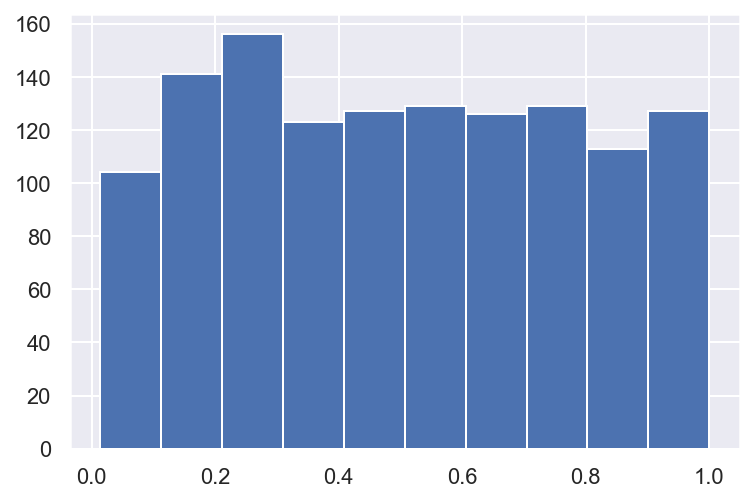

0.5018273798739158


In [15]:
plt.hist(chi2_tests)
plt.show()
print(np.mean(chi2_tests))

In [16]:
alpha = 0.05
sum([x<alpha for x in chi2_tests])

34

Коррекция с поправкой Йетса

In [17]:
_treatment = 1
chi2_tests = []
for state in tqdm.tqdm(state_combinations):
    array_crosstab = pd.crosstab(df[(df['treatment']==_treatment)&
                                    (df['state'].isin(state))]['state'],
                                 df[(df['treatment']==_treatment)&
                                    (df['state'].isin(state))]['churn']).values
    check_chi2_requirements(array_crosstab)
    _, p_value, _, _ = sp.stats.chi2_contingency(array_crosstab, correction=True)
    chi2_tests.append(p_value)

  0%|                                                                                         | 0/1275 [00:00<?, ?it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 20.408163265306122
[True] (a+c)*(c+d)/n: 19.591836734693878
[False] (b+d)*(a+d)/n: 3.673469387755102
[False] (b+d)*(c+d)/n: 4.408163265306122


[True] n > 40
[True] (a+c)*(a+b)/n: 19.387755102040817
[True] (a+c)*(c+d)/n: 18.612244897959183
[False] (b+d)*(a+d)/n: 4.938775510204081
[True] (b+d)*(c+d)/n: 5.387755102040816


[False] n > 40
[True] (a+c)*(a+b)/n: 19.07894736842105
[True] (a+c)*(c+d)/n: 9.921052631578947
[False] (b+d)*(a+d)/n: 4.7368421052631575
[False] (b+d)*(c+d)/n: 3.0789473684210527


[True] n > 40
[True] (a+c)*(a+b)/n: 23.454545454545453
[True] (a+c)*(c+d)/n: 19.545454545454547
[True] (b+d)*(a+d)/n: 6.9818181818181815
[True] (b+d)*(c+d)/n: 5.454545454545454


  0%|▎                                                                                | 4/1275 [00:00<00:33, 37.70it/s]



[True] n > 40
[True] (a+c)*(a+b)/n: 17.857142857142858
[True] (a+c)*(c+d)/n: 17.142857142857142
[True] (b+d)*(a+d)/n: 7.142857142857143
[True] (b+d)*(c+d)/n: 6.857142857142857


[True] n > 40
[True] (a+c)*(a+b)/n: 19.02173913043478
[True] (a+c)*(c+d)/n: 15.978260869565217
[True] (b+d)*(a+d)/n: 5.260869565217392
[True] (b+d)*(c+d)/n: 5.021739130434782


[False] n > 40
[True] (a+c)*(a+b)/n: 20.625
[True] (a+c)*(c+d)/n: 12.375
[False] (b+d)*(a+d)/n: 3.15
[False] (b+d)*(c+d)/n: 2.625


[True] n > 40
[True] (a+c)*(a+b)/n: 19.736842105263158
[True] (a+c)*(c+d)/n: 25.263157894736842
[False] (b+d)*(a+d)/n: 4.842105263157895
[True] (b+d)*(c+d)/n: 6.7368421052631575


[True] n > 40
[True] (a+c)*(a+b)/n: 18.208333333333332
[True] (a+c)*(c+d)/n: 19.791666666666668
[True] (b+d)*(a+d)/n: 5.625
[True] (b+d)*(c+d)/n: 5.208333333333333


[True] n > 40

  1%|▊                                                                               | 13/1275 [00:00<00:34, 36.29it/s]


[True] (a+c)*(a+b)/n: 19.148936170212767
[True] (a+c)*(c+d)/n: 16.851063829787233
[True] (b+d)*(a+d)/n: 5.148936170212766
[True] (b+d)*(c+d)/n: 5.148936170212766


[False] n > 40
[True] (a+c)*(a+b)/n: 11.625
[True] (a+c)*(c+d)/n: 19.375
[False] (b+d)*(a+d)/n: 4.5
[True] (b+d)*(c+d)/n: 5.625


[True] n > 40
[True] (a+c)*(a+b)/n: 19.607843137254903
[True] (a+c)*(c+d)/n: 20.392156862745097
[False] (b+d)*(a+d)/n: 4.745098039215686
[True] (b+d)*(c+d)/n: 5.607843137254902


[True] n > 40
[True] (a+c)*(a+b)/n: 19.396551724137932
[True] (a+c)*(c+d)/n: 25.603448275862068
[True] (b+d)*(a+d)/n: 5.379310344827586
[True] (b+d)*(c+d)/n: 7.396551724137931


[True] n > 40
[True] (a+c)*(a+b)/n: 14.232558139534884
[True] (a+c)*(c+d)/n: 19.767441860465116
[False] (b+d)*(a+d)/n: 4.813953488372093
[True] (b+d)*(c+d)/n: 5.232558139534884


[True] n > 40
[True] (a+c)*(a+b)/n: 18.75
[True] (a+c)*(c+d)/n: 17.25
[True] (b+d)*(a+d)/n: 5.75
[True] (b+d)*(c+d)/n: 5.75


[True] n > 40

  2%|█▎                                                                              | 21/1275 [00:00<00:35, 35.49it/s]


[True] (a+c)*(a+b)/n: 19.791666666666668
[True] (a+c)*(c+d)/n: 18.208333333333332
[False] (b+d)*(a+d)/n: 4.375
[False] (b+d)*(c+d)/n: 4.791666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 17.77777777777778
[True] (a+c)*(c+d)/n: 14.222222222222221
[True] (b+d)*(a+d)/n: 6.933333333333334
[True] (b+d)*(c+d)/n: 5.777777777777778


[True] n > 40
[True] (a+c)*(a+b)/n: 16.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 5.0
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True] (a+c)*(a+b)/n: 16.382978723404257
[True] (a+c)*(c+d)/n: 18.617021276595743
[True] (b+d)*(a+d)/n: 6.127659574468085
[True] (b+d)*(c+d)/n: 6.382978723404255


[True] n > 40
[True] (a+c)*(a+b)/n: 15.113636363636363
[True] (a+c)*(c+d)/n: 19.886363636363637
[False] (b+d)*(a+d)/n: 4.909090909090909
[True] (b+d)*(c+d)/n: 5.113636363636363


[True] n > 40
[True] (a+c)*(a+b)/n: 18.47826086956522
[True] (a+c)*(c+d)/n: 15.521739130434783
[True] (b+d)*(a+d)/n: 6.0
[True] (b+d)*(c+d)/n: 5.478260869565218


[True] n > 40
[True] (a+

  2%|█▌                                                                              | 25/1275 [00:00<00:39, 31.57it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.263157894736842
[True] (a+c)*(c+d)/n: 19.736842105263158
[False] (b+d)*(a+d)/n: 4.0
[True] (b+d)*(c+d)/n: 5.2631578947368425


[False] n > 40
[True] (a+c)*(a+b)/n: 9.405405405405405
[True] (a+c)*(c+d)/n: 19.594594594594593
[False] (b+d)*(a+d)/n: 3.891891891891892
[True] (b+d)*(c+d)/n: 5.405405405405405


[False] n > 40
[True] (a+c)*(a+b)/n: 18.91891891891892
[True] (a+c)*(c+d)/n: 9.08108108108108
[False] (b+d)*(a+d)/n: 4.864864864864865
[False] (b+d)*(c+d)/n: 2.918918918918919


[True] n > 40
[True] (a+c)*(a+b)/n: 16.891304347826086
[True] (a+c)*(c+d)/n: 20.108695652173914
[True] (b+d)*(a+d)/n: 5.086956521739131
[False] (b+d)*(c+d)/n: 4.891304347826087




  2%|█▊                                                                              | 28/1275 [00:00<00:43, 28.93it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 16.444444444444443
[True] (a+c)*(c+d)/n: 20.555555555555557
[False] (b+d)*(a+d)/n: 4.622222222222222
[False] (b+d)*(c+d)/n: 4.444444444444445




  2%|█▉                                                                              | 31/1275 [00:00<00:42, 28.96it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.877551020408163
[True] (a+c)*(c+d)/n: 18.122448979591837
[True] (b+d)*(a+d)/n: 5.63265306122449
[True] (b+d)*(c+d)/n: 5.877551020408164


[True] n > 40
[True] (a+c)*(a+b)/n: 11.317073170731707
[True] (a+c)*(c+d)/n: 17.682926829268293
[True] (b+d)*(a+d)/n: 5.2682926829268295
[True] (b+d)*(c+d)/n: 7.317073170731708


[True] n > 40
[True] (a+c)*(a+b)/n: 20.408163265306122
[True] (a+c)*(c+d)/n: 19.591836734693878
[False] (b+d)*(a+d)/n: 3.673469387755102
[False] (b+d)*(c+d)/n: 4.408163265306122


[True] n > 40
[True] (a+c)*(a+b)/n: 19.565217391304348
[True] (a+c)*(c+d)/n: 16.434782608695652
[False] (b+d)*(a+d)/n: 4.565217391304348
[False] (b+d)*(c+d)/n: 4.565217391304348


[True] n > 40
[True] (a+c)*(a+b)/n: 18.617021276595743
[True] (a+c)*(c+d)/n: 16.382978723404257
[True] (b+d)*(a+d)/n: 5.872340425531915
[True] (b+d)*(c+d)/n: 5.617021276595745


[True] n > 40

  3%|██▍                                                                             | 38/1275 [00:01<00:42, 28.94it/s]


[True] (a+c)*(a+b)/n: 13.761904761904763
[True] (a+c)*(c+d)/n: 20.238095238095237
[False] (b+d)*(a+d)/n: 4.380952380952381
[False] (b+d)*(c+d)/n: 4.761904761904762


[True] n > 40
[True] (a+c)*(a+b)/n: 19.148936170212767
[True] (a+c)*(c+d)/n: 16.851063829787233
[True] (b+d)*(a+d)/n: 5.148936170212766
[True] (b+d)*(c+d)/n: 5.148936170212766


[False] n > 40
[True] (a+c)*(a+b)/n: 10.5
[True] (a+c)*(c+d)/n: 17.5
[True] (b+d)*(a+d)/n: 5.1
[True] (b+d)*(c+d)/n: 7.5


[True] n > 40
[True] (a+c)*(a+b)/n: 20.108695652173914
[True] (a+c)*(c+d)/n: 16.891304347826086
[False] (b+d)*(a+d)/n: 3.9130434782608696
[False] (b+d)*(c+d)/n: 4.108695652173913


[True] n > 40
[True] (a+c)*(a+b)/n: 19.791666666666668
[True] (a+c)*(c+d)/n: 18.208333333333332
[False] (b+d)*(a+d)/n: 4.375
[False] (b+d)*(c+d)/n: 4.791666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 19.318181818181817
[True] (a+c)*(c+d)/n: 14.681818181818182
[False] (b+d)*(a+d)/n: 4.7727272727272725
[False] (b+d)*(c+d)/n: 4.318181818181818


[T

  4%|██▉                                                                             | 47/1275 [00:01<00:36, 33.34it/s]


[True] (a+c)*(a+b)/n: 17.708333333333332
[True] (a+c)*(c+d)/n: 16.291666666666668
[True] (b+d)*(a+d)/n: 7.291666666666667
[True] (b+d)*(c+d)/n: 6.708333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 20.833333333333332
[True] (a+c)*(c+d)/n: 24.166666666666668
[False] (b+d)*(a+d)/n: 3.3333333333333335
[False] (b+d)*(c+d)/n: 4.833333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 18.367346938775512
[True] (a+c)*(c+d)/n: 17.632653061224488
[True] (b+d)*(a+d)/n: 6.36734693877551
[True] (b+d)*(c+d)/n: 6.36734693877551


[True] n > 40
[True] (a+c)*(a+b)/n: 15.545454545454545
[True] (a+c)*(c+d)/n: 20.454545454545453
[False] (b+d)*(a+d)/n: 4.545454545454546
[False] (b+d)*(c+d)/n: 4.545454545454546


[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[False] (b+d)*(a+d)/n: 4.84
[True] (b+d)*(c+d)/n: 5.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.92452830188679
[True] (a+c)*(c+d)/n: 20.07547169811321
[True] (b+d)*(a+d)/n: 7.3584905660377355
[True] (b+d)*(c+d)/n: 7.924528301886792

  4%|███▏                                                                            | 51/1275 [00:01<00:36, 33.96it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 23.454545454545453
[True] (a+c)*(c+d)/n: 19.545454545454547
[True] (b+d)*(a+d)/n: 6.9818181818181815
[True] (b+d)*(c+d)/n: 5.454545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 19.897959183673468
[True] (a+c)*(c+d)/n: 19.102040816326532
[False] (b+d)*(a+d)/n: 4.285714285714286
[False] (b+d)*(c+d)/n: 4.8979591836734695


[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 21.0
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 21.405405405405407
[True] (a+c)*(c+d)/n: 11.594594594594595
[False] (b+d)*(a+d)/n: 2.5945945945945947
[False] (b+d)*(c+d)/n: 1.4054054054054055


[True] n > 40
[True] (a+c)*(a+b)/n: 26.11111111111111
[True] (a+c)*(c+d)/n: 20.88888888888889
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.111111111111111


[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[False] (b+d)*(a+d)/n: 3.5625
[False] (b+d)*(c+d)/n: 4.5




  5%|███▋                                                                            | 59/1275 [00:01<00:42, 28.51it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.2
[True] (a+c)*(c+d)/n: 20.8
[False] (b+d)*(a+d)/n: 2.533333333333333
[False] (b+d)*(c+d)/n: 3.2


[False] n > 40
[True] (a+c)*(a+b)/n: 14.23076923076923
[True] (a+c)*(c+d)/n: 22.76923076923077
[False] (b+d)*(a+d)/n: 0.8717948717948718
[False] (b+d)*(c+d)/n: 1.2307692307692308


[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 28.0
[False] (b+d)*(a+d)/n: 3.375
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5531914893617
[True] (a+c)*(c+d)/n: 21.4468085106383
[False] (b+d)*(a+d)/n: 2.3404255319148937
[False] (b+d)*(c+d)/n: 2.5531914893617023


[True] n > 40
[True] (a+c)*(a+b)/n: 20.869565217391305
[True] (a+c)*(c+d)/n: 19.130434782608695
[False] (b+d)*(a+d)/n: 3.391304347826087
[False] (b+d)*(c+d)/n: 2.869565217391304




  5%|████                                                                            | 65/1275 [00:02<00:44, 26.96it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 13.461538461538462
[True] (a+c)*(c+d)/n: 21.53846153846154
[False] (b+d)*(a+d)/n: 1.5384615384615385
[False] (b+d)*(c+d)/n: 2.4615384615384617


[True] n > 40
[True] (a+c)*(a+b)/n: 22.88
[True] (a+c)*(c+d)/n: 21.12
[False] (b+d)*(a+d)/n: 2.88
[False] (b+d)*(c+d)/n: 2.88


[True] n > 40
[True] (a+c)*(a+b)/n: 28.36842105263158
[True] (a+c)*(c+d)/n: 20.63157894736842
[False] (b+d)*(a+d)/n: 4.0701754385964914
[False] (b+d)*(c+d)/n: 3.3684210526315788


[True] n > 40
[True] (a+c)*(a+b)/n: 16.285714285714285
[True] (a+c)*(c+d)/n: 21.714285714285715
[False] (b+d)*(a+d)/n: 1.7142857142857142
[False] (b+d)*(c+d)/n: 2.2857142857142856


[True] n > 40
[True] (a+c)*(a+b)/n: 20.425531914893618
[True] (a+c)*(c+d)/n: 19.574468085106382
[False] (b+d)*(a+d)/n: 4.0212765957446805
[False] (b+d)*(c+d)/n: 3.425531914893617


[True] n > 40
[True] (a+c)*(a+b)/n: 21.4468085106383
[True] (a+c)*(c+d)/n: 20.5531914893617
[False] (b+d)*(a+d)/n: 2.6595744680851063
[False] (b+d)

  5%|████▍                                                                           | 70/1275 [00:02<00:38, 31.28it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.636363636363637
[True] (a+c)*(c+d)/n: 16.363636363636363
[True] (b+d)*(a+d)/n: 5.090909090909091
[False] (b+d)*(c+d)/n: 3.6363636363636362


[True] n > 40
[True] (a+c)*(a+b)/n: 18.181818181818183
[True] (a+c)*(c+d)/n: 21.818181818181817
[False] (b+d)*(a+d)/n: 1.8181818181818181
[False] (b+d)*(c+d)/n: 2.1818181818181817


[True] n > 40
[True] (a+c)*(a+b)/n: 18.652173913043477
[True] (a+c)*(c+d)/n: 20.347826086956523
[False] (b+d)*(a+d)/n: 2.891304347826087
[False] (b+d)*(c+d)/n: 3.652173913043478


[True] n > 40
[True] (a+c)*(a+b)/n: 17.232558139534884
[True] (a+c)*(c+d)/n: 21.767441860465116
[False] (b+d)*(a+d)/n: 1.7674418604651163
[False] (b+d)*(c+d)/n: 2.2325581395348837


[True] n > 40
[True] (a+c)*(a+b)/n: 20.266666666666666
[True] (a+c)*(c+d)/n: 17.733333333333334
[False] (b+d)*(a+d)/n: 4.2
[False] (b+d)*(c+d)/n: 3.2666666666666666


[True] n > 40
[True] (a+c)*(a+b)/n: 21.5
[True] (a+c)*(c+d)/n: 21.5
[False] (b+d)*(a+d)/n: 2.3958333333333335

  6%|████▉                                                                           | 78/1275 [00:02<00:35, 33.63it/s]


[True] (a+c)*(a+b)/n: 11.0
[True] (a+c)*(c+d)/n: 22.0
[False] (b+d)*(a+d)/n: 1.0833333333333333
[False] (b+d)*(c+d)/n: 2.0


[False] n > 40
[True] (a+c)*(a+b)/n: 10.666666666666666
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 1.3333333333333333
[False] (b+d)*(c+d)/n: 2.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 19.133333333333333
[True] (a+c)*(c+d)/n: 21.866666666666667
[False] (b+d)*(a+d)/n: 1.8666666666666667
[False] (b+d)*(c+d)/n: 2.1333333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 18.636363636363637
[True] (a+c)*(c+d)/n: 22.363636363636363
[False] (b+d)*(a+d)/n: 1.4318181818181819
[False] (b+d)*(c+d)/n: 1.6363636363636365


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5
[True] (a+c)*(c+d)/n: 20.5
[False] (b+d)*(a+d)/n: 3.0625
[False] (b+d)*(c+d)/n: 3.5


[False] n > 40
[True] (a+c)*(a+b)/n: 13.2
[True] (a+c)*(c+d)/n: 19.8
[False] (b+d)*(a+d)/n: 2.275
[False] (b+d)*(c+d)/n: 4.2




  6%|█████▏                                                                          | 82/1275 [00:02<00:40, 29.32it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 22.0
[True] (a+c)*(c+d)/n: 22.0
[False] (b+d)*(a+d)/n: 2.0
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 21.333333333333332
[True] (a+c)*(c+d)/n: 18.666666666666668
[False] (b+d)*(a+d)/n: 2.7777777777777777
[False] (b+d)*(c+d)/n: 2.3333333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 18.652173913043477
[True] (a+c)*(c+d)/n: 20.347826086956523
[False] (b+d)*(a+d)/n: 2.891304347826087
[False] (b+d)*(c+d)/n: 3.652173913043478


[True] n > 40
[True] (a+c)*(a+b)/n: 15.75609756097561
[True] (a+c)*(c+d)/n: 22.24390243902439
[False] (b+d)*(a+d)/n: 1.3170731707317074
[False] (b+d)*(c+d)/n: 1.7560975609756098


[True] n > 40
[True] (a+c)*(a+b)/n: 20.869565217391305
[True] (a+c)*(c+d)/n: 19.130434782608695
[False] (b+d)*(a+d)/n: 3.391304347826087
[False] (b+d)*(c+d)/n: 2.869565217391304




  7%|█████▋                                                                          | 90/1275 [00:02<00:41, 28.47it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 12.307692307692308
[True] (a+c)*(c+d)/n: 19.692307692307693
[False] (b+d)*(a+d)/n: 2.1538461538461537
[False] (b+d)*(c+d)/n: 4.3076923076923075


[True] n > 40
[True] (a+c)*(a+b)/n: 19.133333333333333
[True] (a+c)*(c+d)/n: 21.866666666666667
[False] (b+d)*(a+d)/n: 1.8666666666666667
[False] (b+d)*(c+d)/n: 2.1333333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 21.4468085106383
[True] (a+c)*(c+d)/n: 20.5531914893617
[False] (b+d)*(a+d)/n: 2.6595744680851063
[False] (b+d)*(c+d)/n: 2.4468085106382977


[True] n > 40
[True] (a+c)*(a+b)/n: 16.790697674418606
[True] (a+c)*(c+d)/n: 21.209302325581394
[False] (b+d)*(a+d)/n: 2.0930232558139537
[False] (b+d)*(c+d)/n: 2.7906976744186047


[True] n > 40
[True] (a+c)*(a+b)/n: 19.404255319148938
[True] (a+c)*(c+d)/n: 18.595744680851062
[True] (b+d)*(a+d)/n: 5.553191489361702
[False] (b+d)*(c+d)/n: 4.404255319148936


[True] n > 40
[True] (a+c)*(a+b)/n: 26.81132075471698
[True] (a+c)*(c+d)/n: 22.18867924528302
[F

  7%|█████▉                                                                          | 94/1275 [00:03<00:40, 29.51it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.3333333333333335
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 17.674418604651162
[True] (a+c)*(c+d)/n: 22.325581395348838
[False] (b+d)*(a+d)/n: 1.3953488372093024
[False] (b+d)*(c+d)/n: 1.6744186046511629


[True] n > 40
[True] (a+c)*(a+b)/n: 21.93877551020408
[True] (a+c)*(c+d)/n: 21.06122448979592
[False] (b+d)*(a+d)/n: 2.816326530612245
[False] (b+d)*(c+d)/n: 2.938775510204082


[True] n > 40
[True] (a+c)*(a+b)/n: 22.615384615384617
[True] (a+c)*(c+d)/n: 19.384615384615383
[False] (b+d)*(a+d)/n: 4.230769230769231
[False] (b+d)*(c+d)/n: 4.615384615384615


[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 21.0
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 22.0
[True] (a+c)*(c+d)/n: 11.0
[False] (b+d)*(a+d)/n: 1.9166666666666667
[False] (b+d)*(c+d)/n: 1.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.571428571428573
[

  8%|██████▎                                                                        | 102/1275 [00:03<00:35, 33.02it/s]


[True] (a+c)*(a+b)/n: 26.11111111111111
[True] (a+c)*(c+d)/n: 20.88888888888889
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.111111111111111


[True] n > 40
[True] (a+c)*(a+b)/n: 21.5
[True] (a+c)*(c+d)/n: 21.5
[False] (b+d)*(a+d)/n: 2.3958333333333335
[False] (b+d)*(c+d)/n: 2.5


[False] n > 40
[True] (a+c)*(a+b)/n: 20.10810810810811
[True] (a+c)*(c+d)/n: 10.891891891891891
[False] (b+d)*(a+d)/n: 3.5675675675675675
[False] (b+d)*(c+d)/n: 2.108108108108108


[True] n > 40
[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 4.833333333333333
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[False] (b+d)*(a+d)/n: 4.8125
[True] (b+d)*(c+d)/n: 5.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.266666666666666
[True] (a+c)*(c+d)/n: 19.733333333333334
[False] (b+d)*(a+d)/n: 3.7333333333333334
[False] (b+d)*(c+d)/n: 4.266666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 13.461538461538462
[True] (a+c)*(c+d)/n: 21.538

  9%|██████▊                                                                        | 110/1275 [00:03<00:35, 32.83it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 20.142857142857142
[True] (a+c)*(c+d)/n: 26.857142857142858
[False] (b+d)*(a+d)/n: 4.017857142857143
[True] (b+d)*(c+d)/n: 5.142857142857143


[True] n > 40
[True] (a+c)*(a+b)/n: 19.574468085106382
[True] (a+c)*(c+d)/n: 20.425531914893618
[False] (b+d)*(a+d)/n: 3.574468085106383
[False] (b+d)*(c+d)/n: 3.574468085106383


[True] n > 40
[True] (a+c)*(a+b)/n: 19.82608695652174
[True] (a+c)*(c+d)/n: 18.17391304347826
[False] (b+d)*(a+d)/n: 4.173913043478261
[False] (b+d)*(c+d)/n: 3.8260869565217392


[False] n > 40
[True] (a+c)*(a+b)/n: 12.692307692307692
[True] (a+c)*(c+d)/n: 20.307692307692307
[False] (b+d)*(a+d)/n: 2.6153846153846154
[False] (b+d)*(c+d)/n: 3.6923076923076925


[True] n > 40
[True] (a+c)*(a+b)/n: 21.84
[True] (a+c)*(c+d)/n: 20.16
[False] (b+d)*(a+d)/n: 4.16
[False] (b+d)*(c+d)/n: 3.84


[True] n > 40
[True] (a+c)*(a+b)/n: 19.789473684210527
[True] (a+c)*(c+d)/n: 27.210526315789473
[False] (b+d)*(a+d)/n: 4.56140350877193
[True] (b+d)*(c

  9%|███████▏                                                                       | 115/1275 [00:03<00:33, 34.21it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.404255319148938
[True] (a+c)*(c+d)/n: 18.595744680851062
[False] (b+d)*(a+d)/n: 4.787234042553192
[False] (b+d)*(c+d)/n: 4.404255319148936


[True] n > 40
[True] (a+c)*(a+b)/n: 20.425531914893618
[True] (a+c)*(c+d)/n: 19.574468085106382
[False] (b+d)*(a+d)/n: 3.425531914893617
[False] (b+d)*(c+d)/n: 3.425531914893617


[True] n > 40
[True] (a+c)*(a+b)/n: 18.545454545454547
[True] (a+c)*(c+d)/n: 15.454545454545455
[True] (b+d)*(a+d)/n: 5.909090909090909
[False] (b+d)*(c+d)/n: 4.545454545454546


[True] n > 40
[True] (a+c)*(a+b)/n: 17.272727272727273
[True] (a+c)*(c+d)/n: 20.727272727272727
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.272727272727273


[True] n > 40
[True] (a+c)*(a+b)/n: 17.695652173913043
[True] (a+c)*(c+d)/n: 19.304347826086957
[False] (b+d)*(a+d)/n: 4.108695652173913
[False] (b+d)*(c+d)/n: 4.695652173913044


[True] n > 40
[True] (a+c)*(a+b)/n: 16.348837209302324
[True] (a+c)*(c+d)/n: 20.651162790697676
[False] (b+d)*(a+d)

 10%|███████▋                                                                       | 124/1275 [00:03<00:33, 34.10it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.2
[True] (a+c)*(c+d)/n: 16.8
[False] (b+d)*(a+d)/n: 5.0
[False] (b+d)*(c+d)/n: 4.2


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5
[True] (a+c)*(c+d)/n: 20.5
[False] (b+d)*(a+d)/n: 3.6458333333333335
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 20.869565217391305
[True] (a+c)*(c+d)/n: 19.130434782608695
[False] (b+d)*(a+d)/n: 2.869565217391304
[False] (b+d)*(c+d)/n: 2.869565217391304


[False] n > 40
[True] (a+c)*(a+b)/n: 11.243243243243244
[True] (a+c)*(c+d)/n: 20.756756756756758
[False] (b+d)*(a+d)/n: 2.1621621621621623
[False] (b+d)*(c+d)/n: 3.2432432432432434


[False] n > 40
[True] (a+c)*(a+b)/n: 10.333333333333334
[True] (a+c)*(c+d)/n: 20.666666666666668
[False] (b+d)*(a+d)/n: 2.0833333333333335
[False] (b+d)*(c+d)/n: 3.3333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 10.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 2.3333333333333335
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 18.2
[True] (a+

 10%|████████▏                                                                      | 132/1275 [00:04<00:32, 34.76it/s]


[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[False] (b+d)*(a+d)/n: 4.3125
[False] (b+d)*(c+d)/n: 4.5


[False] n > 40
[True] (a+c)*(a+b)/n: 12.4
[True] (a+c)*(c+d)/n: 18.6
[False] (b+d)*(a+d)/n: 3.375
[True] (b+d)*(c+d)/n: 5.4


[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 21.0
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.266666666666666
[True] (a+c)*(c+d)/n: 17.733333333333334
[False] (b+d)*(a+d)/n: 3.577777777777778
[False] (b+d)*(c+d)/n: 3.2666666666666666


[True] n > 40
[True] (a+c)*(a+b)/n: 17.695652173913043
[True] (a+c)*(c+d)/n: 19.304347826086957
[False] (b+d)*(a+d)/n: 4.108695652173913
[False] (b+d)*(c+d)/n: 4.695652173913044


[True] n > 40
[True] (a+c)*(a+b)/n: 14.926829268292684
[True] (a+c)*(c+d)/n: 21.073170731707318
[False] (b+d)*(a+d)/n: 2.4390243902439024
[False] (b+d)*(c+d)/n: 2.926829268292683


[True] n > 40
[True] (a+c)*(a+b)/n: 19.82608695652174
[True] (a+c)*(c+d)/n: 18.17391304347826

 11%|████████▌                                                                      | 138/1275 [00:04<00:28, 39.42it/s]


[True] (a+c)*(a+b)/n: 18.2
[True] (a+c)*(c+d)/n: 20.8
[False] (b+d)*(a+d)/n: 3.066666666666667
[False] (b+d)*(c+d)/n: 3.2


[True] n > 40
[True] (a+c)*(a+b)/n: 20.425531914893618
[True] (a+c)*(c+d)/n: 19.574468085106382
[False] (b+d)*(a+d)/n: 3.425531914893617
[False] (b+d)*(c+d)/n: 3.425531914893617


[True] n > 40
[True] (a+c)*(a+b)/n: 15.906976744186046
[True] (a+c)*(c+d)/n: 20.093023255813954
[False] (b+d)*(a+d)/n: 3.255813953488372
[False] (b+d)*(c+d)/n: 3.9069767441860463


[True] n > 40
[True] (a+c)*(a+b)/n: 18.382978723404257
[True] (a+c)*(c+d)/n: 17.617021276595743
[True] (b+d)*(a+d)/n: 6.319148936170213
[True] (b+d)*(c+d)/n: 5.382978723404255


[True] n > 40
[True] (a+c)*(a+b)/n: 21.28301886792453
[True] (a+c)*(c+d)/n: 25.71698113207547
[False] (b+d)*(a+d)/n: 2.490566037735849
[False] (b+d)*(c+d)/n: 3.2830188679245285


[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[True] (b+d)*(a+d)/n: 5.416666666666667
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True]

 12%|█████████▏                                                                     | 148/1275 [00:04<00:28, 39.16it/s]


[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 4.0


[False] n > 40
[True] (a+c)*(a+b)/n: 20.666666666666668
[True] (a+c)*(c+d)/n: 10.333333333333334
[False] (b+d)*(a+d)/n: 2.9166666666666665
[False] (b+d)*(c+d)/n: 1.6666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 19.428571428571427
[True] (a+c)*(c+d)/n: 14.571428571428571
[False] (b+d)*(a+d)/n: 4.571428571428571
[False] (b+d)*(c+d)/n: 3.4285714285714284


[True] n > 40
[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 4.833333333333333
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5
[True] (a+c)*(c+d)/n: 20.5
[False] (b+d)*(a+d)/n: 3.6458333333333335
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 25.11627906976744
[True] (a+c)*(c+d)/n: 10.883720930232558
[False] (b+d)*(a+d)/n: 4.395348837209302
[False] (b+d)*(c+d)/n: 2.116279069767442


[False] n > 40
[True] (a+c)*(a+b)/n: 18.16216216216216
[True] (a+c)*(

 12%|█████████▍                                                                     | 153/1275 [00:04<00:33, 33.81it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 17.294117647058822
[True] (a+c)*(c+d)/n: 10.705882352941176
[False] (b+d)*(a+d)/n: 3.3529411764705883
[False] (b+d)*(c+d)/n: 2.2941176470588234


[False] n > 40
[True] (a+c)*(a+b)/n: 13.928571428571429
[True] (a+c)*(c+d)/n: 12.071428571428571
[False] (b+d)*(a+d)/n: 1.2142857142857142
[False] (b+d)*(c+d)/n: 0.9285714285714286


[True] n > 40
[True] (a+c)*(a+b)/n: 10.977777777777778
[True] (a+c)*(c+d)/n: 27.022222222222222
[False] (b+d)*(a+d)/n: 2.488888888888889
[False] (b+d)*(c+d)/n: 4.977777777777778


[False] n > 40
[True] (a+c)*(a+b)/n: 19.805555555555557
[True] (a+c)*(c+d)/n: 11.194444444444445
[False] (b+d)*(a+d)/n: 3.0555555555555554
[False] (b+d)*(c+d)/n: 1.8055555555555556


[False] n > 40
[True] (a+c)*(a+b)/n: 10.771428571428572
[True] (a+c)*(c+d)/n: 18.228571428571428
[False] (b+d)*(a+d)/n: 2.5714285714285716
[False] (b+d)*(c+d)/n: 3.7714285714285714


[False] n > 40

 13%|██████████                                                                     | 162/1275 [00:04<00:32, 34.02it/s]


[True] (a+c)*(a+b)/n: 12.857142857142858
[True] (a+c)*(c+d)/n: 11.142857142857142
[False] (b+d)*(a+d)/n: 2.142857142857143
[False] (b+d)*(c+d)/n: 1.8571428571428572


[False] n > 40
[True] (a+c)*(a+b)/n: 22.0
[True] (a+c)*(c+d)/n: 11.0
[False] (b+d)*(a+d)/n: 3.6923076923076925
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 27.26086956521739
[True] (a+c)*(c+d)/n: 10.73913043478261
[True] (b+d)*(a+d)/n: 5.043478260869565
[False] (b+d)*(c+d)/n: 2.260869565217391


[False] n > 40
[True] (a+c)*(a+b)/n: 15.67741935483871
[True] (a+c)*(c+d)/n: 11.32258064516129
[False] (b+d)*(a+d)/n: 2.3225806451612905
[False] (b+d)*(c+d)/n: 1.6774193548387097


[False] n > 40
[True] (a+c)*(a+b)/n: 10.472222222222221
[True] (a+c)*(c+d)/n: 18.52777777777778
[False] (b+d)*(a+d)/n: 3.111111111111111
[False] (b+d)*(c+d)/n: 4.472222222222222


[False] n > 40
[True] (a+c)*(a+b)/n: 11.194444444444445
[True] (a+c)*(c+d)/n: 19.805555555555557
[False] (b+d)*(a+d)/n: 1.9444444444444444
[False] (b+d)*(

 13%|██████████▎                                                                    | 166/1275 [00:05<00:32, 34.26it/s]

[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 10.4
[False] (b+d)*(a+d)/n: 3.8
[False] (b+d)*(c+d)/n: 2.6


[False] n > 40
[True] (a+c)*(a+b)/n: 16.625
[True] (a+c)*(c+d)/n: 11.375
[False] (b+d)*(a+d)/n: 2.375
[False] (b+d)*(c+d)/n: 1.625


[False] n > 40
[True] (a+c)*(a+b)/n: 10.323529411764707
[True] (a+c)*(c+d)/n: 16.676470588235293
[False] (b+d)*(a+d)/n: 3.2941176470588234
[False] (b+d)*(c+d)/n: 4.323529411764706


[False] n > 40
[True] (a+c)*(a+b)/n: 20.756756756756758
[True] (a+c)*(c+d)/n: 11.243243243243244
[False] (b+d)*(a+d)/n: 3.108108108108108
[False] (b+d)*(c+d)/n: 1.7567567567567568


[False] n > 40
[True] (a+c)*(a+b)/n: 11.514285714285714
[True] (a+c)*(c+d)/n: 19.485714285714284
[False] (b+d)*(a+d)/n: 1.4857142857142858
[False] (b+d)*(c+d)/n: 2.5142857142857142


[False] n > 40
[True] (a+c)*(a+b)/n: 11.5
[True] (a+c)*(c+d)/n: 11.5
[False] (b+d)*(a+d)/n: 1.6153846153846154
[False] (b+d)*(c+d)/n: 1.5


[False] n > 40
[True] (a+c)*(a+b)/n: 10.56
[True] (a+c)*(c+d)/n: 11.44

 14%|██████████▊                                                                    | 174/1275 [00:05<00:32, 33.89it/s]


[True] (a+c)*(a+b)/n: 10.08
[True] (a+c)*(c+d)/n: 10.92
[False] (b+d)*(a+d)/n: 1.92
[False] (b+d)*(c+d)/n: 2.08


[False] n > 40
[True] (a+c)*(a+b)/n: 18.529411764705884
[True] (a+c)*(c+d)/n: 11.470588235294118
[False] (b+d)*(a+d)/n: 2.4705882352941178
[False] (b+d)*(c+d)/n: 1.5294117647058822


[False] n > 40
[True] (a+c)*(a+b)/n: 18.181818181818183
[True] (a+c)*(c+d)/n: 11.818181818181818
[False] (b+d)*(a+d)/n: 1.9090909090909092
[False] (b+d)*(c+d)/n: 1.1818181818181819


[False] n > 40
[True] (a+c)*(a+b)/n: 19.45945945945946
[True] (a+c)*(c+d)/n: 10.54054054054054
[False] (b+d)*(a+d)/n: 3.972972972972973
[False] (b+d)*(c+d)/n: 2.4594594594594597


[False] n > 40
[True] (a+c)*(a+b)/n: 12.137931034482758
[True] (a+c)*(c+d)/n: 9.862068965517242
[False] (b+d)*(a+d)/n: 3.1379310344827585
[False] (b+d)*(c+d)/n: 3.1379310344827585


[False] n > 40
[True] (a+c)*(a+b)/n: 11.594594594594595
[True] (a+c)*(c+d)/n: 21.405405405405407
[False] (b+d)*(a+d)/n: 1.4054054054054055
[False] (b+d)*(c+d

 14%|███████████▎                                                                   | 182/1275 [00:05<00:32, 33.74it/s]


[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 10.4
[False] (b+d)*(a+d)/n: 3.8
[False] (b+d)*(c+d)/n: 2.6


[False] n > 40
[True] (a+c)*(a+b)/n: 15.3
[True] (a+c)*(c+d)/n: 11.7
[False] (b+d)*(a+d)/n: 1.8
[False] (b+d)*(c+d)/n: 1.3


[False] n > 40
[True] (a+c)*(a+b)/n: 10.771428571428572
[True] (a+c)*(c+d)/n: 18.228571428571428
[False] (b+d)*(a+d)/n: 2.5714285714285716
[False] (b+d)*(c+d)/n: 3.7714285714285714


[False] n > 40
[True] (a+c)*(a+b)/n: 11.25
[True] (a+c)*(c+d)/n: 9.75
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.25


[False] n > 40
[True] (a+c)*(a+b)/n: 18.529411764705884
[True] (a+c)*(c+d)/n: 11.470588235294118
[False] (b+d)*(a+d)/n: 2.4705882352941178
[False] (b+d)*(c+d)/n: 1.5294117647058822


[False] n > 40
[True] (a+c)*(a+b)/n: 11.194444444444445
[True] (a+c)*(c+d)/n: 19.805555555555557
[False] (b+d)*(a+d)/n: 1.9444444444444444
[False] (b+d)*(c+d)/n: 3.1944444444444446


[False] n > 40
[True] (a+c)*(a+b)/n: 16.03125
[True] (a+c)*(c+d)/n: 10.96875
[False] (b+

 15%|███████████▌                                                                   | 186/1275 [00:05<00:33, 32.75it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 9.75
[True] (a+c)*(c+d)/n: 17.25
[False] (b+d)*(a+d)/n: 4.5
[True] (b+d)*(c+d)/n: 5.75


[True] n > 40
[True] (a+c)*(a+b)/n: 26.238095238095237
[True] (a+c)*(c+d)/n: 11.761904761904763
[False] (b+d)*(a+d)/n: 2.761904761904762
[False] (b+d)*(c+d)/n: 1.2380952380952381


[False] n > 40
[True] (a+c)*(a+b)/n: 18.81081081081081
[True] (a+c)*(c+d)/n: 10.18918918918919
[False] (b+d)*(a+d)/n: 4.324324324324325
[False] (b+d)*(c+d)/n: 2.810810810810811


[False] n > 40
[True] (a+c)*(a+b)/n: 17.21875
[True] (a+c)*(c+d)/n: 11.78125
[False] (b+d)*(a+d)/n: 1.875
[False] (b+d)*(c+d)/n: 1.21875


[False] n > 40
[True] (a+c)*(a+b)/n: 21.05263157894737
[True] (a+c)*(c+d)/n: 10.947368421052632
[False] (b+d)*(a+d)/n: 3.6315789473684212
[False] (b+d)*(c+d)/n: 2.0526315789473686


[True] n > 40
[True] (a+c)*(a+b)/n: 21.170731707317074
[True] (a+c)*(c+d)/n: 9.829268292682928
[True] (b+d)*(a+d)/n: 5.365853658536586
[False] (b+d)*(c+d)/n: 3.1707317073170733


[False] n > 40

 15%|████████████                                                                   | 194/1275 [00:05<00:32, 33.45it/s]


[True] (a+c)*(a+b)/n: 20.10810810810811
[True] (a+c)*(c+d)/n: 10.891891891891891
[False] (b+d)*(a+d)/n: 3.5675675675675675
[False] (b+d)*(c+d)/n: 2.108108108108108


[False] n > 40
[True] (a+c)*(a+b)/n: 11.44
[True] (a+c)*(c+d)/n: 10.56
[False] (b+d)*(a+d)/n: 1.44
[False] (b+d)*(c+d)/n: 1.44


[False] n > 40
[True] (a+c)*(a+b)/n: 10.483870967741936
[True] (a+c)*(c+d)/n: 14.516129032258064
[False] (b+d)*(a+d)/n: 2.903225806451613
[False] (b+d)*(c+d)/n: 3.4838709677419355


[True] n > 40
[True] (a+c)*(a+b)/n: 25.11627906976744
[True] (a+c)*(c+d)/n: 10.883720930232558
[False] (b+d)*(a+d)/n: 4.395348837209302
[False] (b+d)*(c+d)/n: 2.116279069767442


[False] n > 40
[True] (a+c)*(a+b)/n: 20.756756756756758
[True] (a+c)*(c+d)/n: 11.243243243243244
[False] (b+d)*(a+d)/n: 3.108108108108108
[False] (b+d)*(c+d)/n: 1.7567567567567568


[True] n > 40
[True] (a+c)*(a+b)/n: 23.333333333333332
[True] (a+c)*(c+d)/n: 18.666666666666668
[True] (b+d)*(a+d)/n: 7.111111111111111
[True] (b+d)*(c+d)/n: 5.3

 16%|████████████▌                                                                  | 203/1275 [00:06<00:29, 36.35it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 26.666666666666668
[True] (a+c)*(c+d)/n: 13.333333333333334
[False] (b+d)*(a+d)/n: 2.7777777777777777
[False] (b+d)*(c+d)/n: 1.6666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 25.161290322580644
[True] (a+c)*(c+d)/n: 26.838709677419356
[False] (b+d)*(a+d)/n: 4.838709677419355
[True] (b+d)*(c+d)/n: 5.161290322580645


[True] n > 40
[True] (a+c)*(a+b)/n: 25.471698113207548
[True] (a+c)*(c+d)/n: 19.528301886792452
[False] (b+d)*(a+d)/n: 4.226415094339623
[False] (b+d)*(c+d)/n: 3.4716981132075473


[True] n > 40
[True] (a+c)*(a+b)/n: 24.807692307692307
[True] (a+c)*(c+d)/n: 18.192307692307693
[True] (b+d)*(a+d)/n: 5.019230769230769
[False] (b+d)*(c+d)/n: 3.8076923076923075


[True] n > 40
[True] (a+c)*(a+b)/n: 25.333333333333332
[True] (a+c)*(c+d)/n: 12.666666666666666
[False] (b+d)*(a+d)/n: 4.2
[False] (b+d)*(c+d)/n: 2.3333333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 25.178571428571427
[True] (a+c)*(c+d)/n: 21.821428571428573
[False] (b+d)*(

 17%|█████████████▏                                                                 | 213/1275 [00:06<00:26, 39.46it/s]


[True] (a+c)*(a+b)/n: 25.471698113207548
[True] (a+c)*(c+d)/n: 19.528301886792452
[False] (b+d)*(a+d)/n: 4.226415094339623
[False] (b+d)*(c+d)/n: 3.4716981132075473


[True] n > 40
[True] (a+c)*(a+b)/n: 23.4
[True] (a+c)*(c+d)/n: 15.6
[True] (b+d)*(a+d)/n: 6.82
[False] (b+d)*(c+d)/n: 4.4


[True] n > 40
[True] (a+c)*(a+b)/n: 25.8
[True] (a+c)*(c+d)/n: 17.2
[False] (b+d)*(a+d)/n: 3.78
[False] (b+d)*(c+d)/n: 2.8


[True] n > 40
[True] (a+c)*(a+b)/n: 24.23076923076923
[True] (a+c)*(c+d)/n: 17.76923076923077
[True] (b+d)*(a+d)/n: 5.769230769230769
[False] (b+d)*(c+d)/n: 4.230769230769231


[True] n > 40
[True] (a+c)*(a+b)/n: 25.714285714285715
[True] (a+c)*(c+d)/n: 16.285714285714285
[False] (b+d)*(a+d)/n: 3.857142857142857
[False] (b+d)*(c+d)/n: 2.7142857142857144


[True] n > 40
[True] (a+c)*(a+b)/n: 24.11764705882353
[True] (a+c)*(c+d)/n: 16.88235294117647
[True] (b+d)*(a+d)/n: 5.882352941176471
[False] (b+d)*(c+d)/n: 4.117647058823529


[True] n > 40
[True] (a+c)*(a+b)/n: 25.555555555

 17%|█████████████▌                                                                 | 218/1275 [00:06<00:28, 37.70it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 25.813953488372093
[True] (a+c)*(c+d)/n: 11.186046511627907
[False] (b+d)*(a+d)/n: 3.627906976744186
[False] (b+d)*(c+d)/n: 1.813953488372093


[True] n > 40
[True] (a+c)*(a+b)/n: 25.714285714285715
[True] (a+c)*(c+d)/n: 10.285714285714286
[False] (b+d)*(a+d)/n: 3.7142857142857144
[False] (b+d)*(c+d)/n: 1.7142857142857142


[True] n > 40
[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 10.0
[False] (b+d)*(a+d)/n: 4.5
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.88235294117647
[True] (a+c)*(c+d)/n: 18.11764705882353
[False] (b+d)*(a+d)/n: 3.7058823529411766
[False] (b+d)*(c+d)/n: 2.8823529411764706


[True] n > 40
[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 26.4
[False] (b+d)*(a+d)/n: 2.88
[False] (b+d)*(c+d)/n: 3.6


[True] n > 40
[True] (a+c)*(a+b)/n: 24.444444444444443
[True] (a+c)*(c+d)/n: 19.555555555555557
[True] (b+d)*(a+d)/n: 5.555555555555555
[False] (b+d)*(c+d)/n: 4.444444444444445


[True] n > 40
[True] (a+c)*(a+

 18%|██████████████                                                                 | 226/1275 [00:06<00:27, 37.68it/s]


[True] (a+c)*(a+b)/n: 25.294117647058822
[True] (a+c)*(c+d)/n: 17.705882352941178
[False] (b+d)*(a+d)/n: 4.392156862745098
[False] (b+d)*(c+d)/n: 3.2941176470588234


[True] n > 40
[True] (a+c)*(a+b)/n: 24.23076923076923
[True] (a+c)*(c+d)/n: 17.76923076923077
[True] (b+d)*(a+d)/n: 5.769230769230769
[False] (b+d)*(c+d)/n: 4.230769230769231


[True] n > 40
[True] (a+c)*(a+b)/n: 26.170212765957448
[True] (a+c)*(c+d)/n: 14.829787234042554
[False] (b+d)*(a+d)/n: 3.3191489361702127
[False] (b+d)*(c+d)/n: 2.1702127659574466


[True] n > 40
[True] (a+c)*(a+b)/n: 24.807692307692307
[True] (a+c)*(c+d)/n: 18.192307692307693
[True] (b+d)*(a+d)/n: 5.019230769230769
[False] (b+d)*(c+d)/n: 3.8076923076923075


[True] n > 40
[True] (a+c)*(a+b)/n: 23.333333333333332
[True] (a+c)*(c+d)/n: 11.666666666666666
[True] (b+d)*(a+d)/n: 6.666666666666667
[False] (b+d)*(c+d)/n: 3.3333333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 25.88235294117647
[True] (a+c)*(c+d)/n: 18.11764705882353
[False] (b+d)*(a+d)

 18%|██████████████▍                                                                | 234/1275 [00:06<00:28, 36.83it/s]


[True] (a+c)*(a+b)/n: 25.102040816326532
[True] (a+c)*(c+d)/n: 15.89795918367347
[False] (b+d)*(a+d)/n: 4.571428571428571
[False] (b+d)*(c+d)/n: 3.1020408163265305


[True] n > 40
[True] (a+c)*(a+b)/n: 23.20754716981132
[True] (a+c)*(c+d)/n: 17.79245283018868
[True] (b+d)*(a+d)/n: 7.245283018867925
[True] (b+d)*(c+d)/n: 5.2075471698113205


[True] n > 40
[True] (a+c)*(a+b)/n: 26.440677966101696
[True] (a+c)*(c+d)/n: 25.559322033898304
[False] (b+d)*(a+d)/n: 3.2033898305084745
[False] (b+d)*(c+d)/n: 3.440677966101695


[True] n > 40
[True] (a+c)*(a+b)/n: 23.88888888888889
[True] (a+c)*(c+d)/n: 19.11111111111111
[True] (b+d)*(a+d)/n: 6.314814814814815
[False] (b+d)*(c+d)/n: 4.888888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 26.3265306122449
[True] (a+c)*(c+d)/n: 16.6734693877551
[False] (b+d)*(a+d)/n: 3.183673469387755
[False] (b+d)*(c+d)/n: 2.326530612244898


[True] n > 40
[True] (a+c)*(a+b)/n: 25.09090909090909
[True] (a+c)*(c+d)/n: 20.90909090909091
[False] (b+d)*(a+d)/n: 4.745

 19%|██████████████▉                                                                | 242/1275 [00:07<00:29, 35.28it/s]


[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 4.833333333333333
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.714285714285715
[True] (a+c)*(c+d)/n: 10.285714285714286
[False] (b+d)*(a+d)/n: 3.7142857142857144
[False] (b+d)*(c+d)/n: 1.7142857142857142


[True] n > 40
[True] (a+c)*(a+b)/n: 24.375
[True] (a+c)*(c+d)/n: 14.625
[True] (b+d)*(a+d)/n: 5.4375
[False] (b+d)*(c+d)/n: 3.375


[True] n > 40
[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 25.0
[False] (b+d)*(a+d)/n: 5.0
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.555555555555557
[True] (a+c)*(c+d)/n: 20.444444444444443
[False] (b+d)*(a+d)/n: 4.148148148148148
[False] (b+d)*(c+d)/n: 3.5555555555555554


[True] n > 40
[True] (a+c)*(a+b)/n: 18.133333333333333
[True] (a+c)*(c+d)/n: 15.866666666666667
[True] (b+d)*(a+d)/n: 5.133333333333334
[True] (b+d)*(c+d)/n: 5.133333333333334


[False] n > 40
[True] (a+c)*(a+b)/n: 12.307692307692308
[True] (a+c)*(c+d)/n: 

 19%|███████████████▏                                                               | 246/1275 [00:07<00:30, 34.24it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.857142857142858
[True] (a+c)*(c+d)/n: 25.142857142857142
[False] (b+d)*(a+d)/n: 4.714285714285714
[True] (b+d)*(c+d)/n: 6.857142857142857


[True] n > 40
[True] (a+c)*(a+b)/n: 18.106382978723403
[True] (a+c)*(c+d)/n: 18.893617021276597
[True] (b+d)*(a+d)/n: 5.74468085106383
[True] (b+d)*(c+d)/n: 5.1063829787234045


[True] n > 40
[True] (a+c)*(a+b)/n: 18.26086956521739
[True] (a+c)*(c+d)/n: 16.73913043478261
[True] (b+d)*(a+d)/n: 5.021739130434782
[True] (b+d)*(c+d)/n: 5.260869565217392


[False] n > 40
[True] (a+c)*(a+b)/n: 11.538461538461538
[True] (a+c)*(c+d)/n: 18.46153846153846
[False] (b+d)*(a+d)/n: 4.615384615384615
[True] (b+d)*(c+d)/n: 5.538461538461538


[True] n > 40
[True] (a+c)*(a+b)/n: 18.72
[True] (a+c)*(c+d)/n: 20.28
[False] (b+d)*(a+d)/n: 4.62
[True] (b+d)*(c+d)/n: 5.72


[True] n > 40
[True] (a+c)*(a+b)/n: 18.526315789473685
[True] (a+c)*(c+d)/n: 25.473684210526315
[True] (b+d)*(a+d)/n: 5.245614035087719
[True] (b+d)*(c+d)/n: 7.5

 20%|███████████████▋                                                               | 254/1275 [00:07<00:28, 35.36it/s]


[True] (a+c)*(a+b)/n: 17.872340425531913
[True] (a+c)*(c+d)/n: 17.127659574468087
[True] (b+d)*(a+d)/n: 5.617021276595745
[True] (b+d)*(c+d)/n: 5.872340425531915


[True] n > 40
[True] (a+c)*(a+b)/n: 18.893617021276597
[True] (a+c)*(c+d)/n: 18.106382978723403
[False] (b+d)*(a+d)/n: 4.25531914893617
[False] (b+d)*(c+d)/n: 4.8936170212765955


[True] n > 40
[True] (a+c)*(a+b)/n: 16.90909090909091
[True] (a+c)*(c+d)/n: 14.090909090909092
[True] (b+d)*(a+d)/n: 6.795454545454546
[True] (b+d)*(c+d)/n: 5.909090909090909


[True] n > 40
[True] (a+c)*(a+b)/n: 15.909090909090908
[True] (a+c)*(c+d)/n: 19.09090909090909
[True] (b+d)*(a+d)/n: 5.113636363636363
[False] (b+d)*(c+d)/n: 4.909090909090909


[True] n > 40
[True] (a+c)*(a+b)/n: 16.26086956521739
[True] (a+c)*(c+d)/n: 17.73913043478261
[True] (b+d)*(a+d)/n: 6.260869565217392
[True] (b+d)*(c+d)/n: 6.260869565217392


[True] n > 40
[True] (a+c)*(a+b)/n: 15.023255813953488
[True] (a+c)*(c+d)/n: 18.976744186046513
[True] (b+d)*(a+d)/n: 5.0232

 21%|████████████████▏                                                              | 262/1275 [00:07<00:31, 32.65it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[False] (b+d)*(a+d)/n: 4.166666666666667
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True] (a+c)*(a+b)/n: 19.304347826086957
[True] (a+c)*(c+d)/n: 17.695652173913043
[False] (b+d)*(a+d)/n: 3.717391304347826
[False] (b+d)*(c+d)/n: 4.304347826086956


[False] n > 40
[True] (a+c)*(a+b)/n: 10.18918918918919
[True] (a+c)*(c+d)/n: 18.81081081081081
[False] (b+d)*(a+d)/n: 4.108108108108108
[True] (b+d)*(c+d)/n: 5.1891891891891895


[False] n > 40
[True] (a+c)*(a+b)/n: 9.333333333333334
[True] (a+c)*(c+d)/n: 18.666666666666668
[False] (b+d)*(a+d)/n: 4.0
[True] (b+d)*(c+d)/n: 5.333333333333333


[False] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 9.0
[False] (b+d)*(a+d)/n: 4.75
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 16.8
[True] (a+c)*(c+d)/n: 19.2
[True] (b+d)*(a+d)/n: 5.2
[False] (b+d)*(c+d)/n: 4.8


[True] n > 40
[True] (a+c)*(a+b)/n: 16.363636363636363
[True] (a+c)*(c+d)/n: 19.6363636363

 21%|████████████████▊                                                              | 271/1275 [00:07<00:27, 35.91it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[True] (b+d)*(a+d)/n: 5.5
[True] (b+d)*(c+d)/n: 6.0


[False] n > 40
[True] (a+c)*(a+b)/n: 11.2
[True] (a+c)*(c+d)/n: 16.8
[True] (b+d)*(a+d)/n: 5.4
[True] (b+d)*(c+d)/n: 7.2


[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[False] (b+d)*(a+d)/n: 3.5625
[False] (b+d)*(c+d)/n: 4.5


[True] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 16.333333333333332
[False] (b+d)*(a+d)/n: 4.444444444444445
[False] (b+d)*(c+d)/n: 4.666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 17.73913043478261
[True] (a+c)*(c+d)/n: 16.26086956521739
[True] (b+d)*(a+d)/n: 5.739130434782608
[True] (b+d)*(c+d)/n: 5.739130434782608


[True] n > 40
[True] (a+c)*(a+b)/n: 13.682926829268293
[True] (a+c)*(c+d)/n: 19.317073170731707
[False] (b+d)*(a+d)/n: 4.487804878048781
[False] (b+d)*(c+d)/n: 4.682926829268292


[True] n > 40
[True] (a+c)*(a+b)/n: 18.26086956521739
[True] (a+c)*(c+d)/n: 16.7391304347826

 22%|█████████████████▍                                                             | 282/1275 [00:08<00:23, 42.30it/s]


[True] (a+c)*(a+b)/n: 19.92452830188679
[True] (a+c)*(c+d)/n: 24.07547169811321
[False] (b+d)*(a+d)/n: 3.2264150943396226
[False] (b+d)*(c+d)/n: 4.9245283018867925


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 17.5
[True] (b+d)*(a+d)/n: 6.229166666666667
[True] (b+d)*(c+d)/n: 6.5


[True] n > 40
[True] (a+c)*(a+b)/n: 15.465116279069768
[True] (a+c)*(c+d)/n: 19.53488372093023
[False] (b+d)*(a+d)/n: 4.651162790697675
[False] (b+d)*(c+d)/n: 4.465116279069767


[True] n > 40
[True] (a+c)*(a+b)/n: 19.387755102040817
[True] (a+c)*(c+d)/n: 18.612244897959183
[True] (b+d)*(a+d)/n: 6.285714285714286
[True] (b+d)*(c+d)/n: 5.387755102040816


[True] n > 40
[True] (a+c)*(a+b)/n: 17.076923076923077
[True] (a+c)*(c+d)/n: 19.923076923076923
[True] (b+d)*(a+d)/n: 7.211538461538462
[True] (b+d)*(c+d)/n: 8.076923076923077


[True] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[False] (b+d)*(a+d)/n: 4.8125
[True] (b+d)*(c+d)/n: 5.5


[False] n > 40
[True] (a+c)*(a+b)/n:

 23%|█████████████████▊                                                             | 287/1275 [00:08<00:25, 39.07it/s]


[True] (a+c)*(a+b)/n: 13.333333333333334
[True] (a+c)*(c+d)/n: 18.666666666666668
[False] (b+d)*(a+d)/n: 2.111111111111111
[False] (b+d)*(c+d)/n: 2.3333333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 17.433962264150942
[True] (a+c)*(c+d)/n: 26.566037735849058
[False] (b+d)*(a+d)/n: 3.7358490566037736
[True] (b+d)*(c+d)/n: 5.433962264150943


[True] n > 40
[True] (a+c)*(a+b)/n: 19.34090909090909
[True] (a+c)*(c+d)/n: 17.65909090909091
[False] (b+d)*(a+d)/n: 3.8181818181818183
[False] (b+d)*(c+d)/n: 3.340909090909091


[True] n > 40
[True] (a+c)*(a+b)/n: 17.093023255813954
[True] (a+c)*(c+d)/n: 17.906976744186046
[False] (b+d)*(a+d)/n: 3.9069767441860463
[False] (b+d)*(c+d)/n: 4.093023255813954


[False] n > 40
[True] (a+c)*(a+b)/n: 12.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 2.8333333333333335
[False] (b+d)*(c+d)/n: 3.5




 23%|██████████████████▎                                                            | 296/1275 [00:08<00:30, 31.61it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.425531914893618
[True] (a+c)*(c+d)/n: 21.574468085106382
[False] (b+d)*(a+d)/n: 3.574468085106383
[False] (b+d)*(c+d)/n: 4.425531914893617


[True] n > 40
[True] (a+c)*(a+b)/n: 17.11111111111111
[True] (a+c)*(c+d)/n: 26.88888888888889
[False] (b+d)*(a+d)/n: 4.2592592592592595
[True] (b+d)*(c+d)/n: 6.111111111111111


[False] n > 40
[True] (a+c)*(a+b)/n: 15.23076923076923
[True] (a+c)*(c+d)/n: 17.76923076923077
[False] (b+d)*(a+d)/n: 3.076923076923077
[False] (b+d)*(c+d)/n: 3.230769230769231


[True] n > 40
[True] (a+c)*(a+b)/n: 16.704545454545453
[True] (a+c)*(c+d)/n: 18.295454545454547
[False] (b+d)*(a+d)/n: 4.5
[False] (b+d)*(c+d)/n: 4.704545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 17.65909090909091
[True] (a+c)*(c+d)/n: 19.34090909090909
[False] (b+d)*(a+d)/n: 3.1818181818181817
[False] (b+d)*(c+d)/n: 3.659090909090909


[True] n > 40
[True] (a+c)*(a+b)/n: 15.878048780487806
[True] (a+c)*(c+d)/n: 15.121951219512194
[True] (b+d)*(a+d)/n: 

 24%|██████████████████▌                                                            | 300/1275 [00:08<00:31, 31.02it/s]


[True] (a+c)*(a+b)/n: 17.073170731707318
[True] (a+c)*(c+d)/n: 17.926829268292682
[False] (b+d)*(a+d)/n: 3.2195121951219514
[False] (b+d)*(c+d)/n: 3.073170731707317


[True] n > 40
[True] (a+c)*(a+b)/n: 17.3953488372093
[True] (a+c)*(c+d)/n: 16.6046511627907
[False] (b+d)*(a+d)/n: 4.395348837209302
[False] (b+d)*(c+d)/n: 4.395348837209302


[False] n > 40
[True] (a+c)*(a+b)/n: 16.15
[True] (a+c)*(c+d)/n: 17.85
[False] (b+d)*(a+d)/n: 3.15
[False] (b+d)*(c+d)/n: 3.15


[True] n > 40
[True] (a+c)*(a+b)/n: 16.5
[True] (a+c)*(c+d)/n: 16.5
[False] (b+d)*(a+d)/n: 4.714285714285714
[False] (b+d)*(c+d)/n: 4.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.733333333333334
[True] (a+c)*(c+d)/n: 20.266666666666666
[False] (b+d)*(a+d)/n: 3.111111111111111
[False] (b+d)*(c+d)/n: 3.7333333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 18.069767441860463
[True] (a+c)*(c+d)/n: 18.930232558139537
[False] (b+d)*(a+d)/n: 2.6511627906976742
[False] (b+d)*(c+d)/n: 3.0697674418604652


[False] n > 40

 24%|███████████████████                                                            | 308/1275 [00:09<00:30, 31.25it/s]


[True] (a+c)*(a+b)/n: 11.088235294117647
[True] (a+c)*(c+d)/n: 17.91176470588235
[False] (b+d)*(a+d)/n: 2.3529411764705883
[False] (b+d)*(c+d)/n: 3.088235294117647


[False] n > 40
[True] (a+c)*(a+b)/n: 10.181818181818182
[True] (a+c)*(c+d)/n: 17.818181818181817
[False] (b+d)*(a+d)/n: 2.272727272727273
[False] (b+d)*(c+d)/n: 3.1818181818181817


[False] n > 40
[True] (a+c)*(a+b)/n: 17.181818181818183
[True] (a+c)*(c+d)/n: 9.818181818181818
[False] (b+d)*(a+d)/n: 3.4545454545454546
[False] (b+d)*(c+d)/n: 2.1818181818181817


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[False] (b+d)*(a+d)/n: 3.2857142857142856
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5609756097561
[True] (a+c)*(c+d)/n: 18.4390243902439
[False] (b+d)*(a+d)/n: 2.8048780487804876
[False] (b+d)*(c+d)/n: 2.5609756097560976


[True] n > 40
[True] (a+c)*(a+b)/n: 19.2
[True] (a+c)*(c+d)/n: 16.8
[False] (b+d)*(a+d)/n: 4.6
[False] (b+d)*(c+d)/n: 4.2


[False] n > 40
[True] (a+c)*

 25%|███████████████████▌                                                           | 316/1275 [00:09<00:30, 31.49it/s]


[True] (a+c)*(a+b)/n: 18.2
[True] (a+c)*(c+d)/n: 20.8
[False] (b+d)*(a+d)/n: 2.533333333333333
[False] (b+d)*(c+d)/n: 3.2


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 3.3333333333333335
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.3953488372093
[True] (a+c)*(c+d)/n: 16.6046511627907
[False] (b+d)*(a+d)/n: 4.395348837209302
[False] (b+d)*(c+d)/n: 4.395348837209302


[False] n > 40
[True] (a+c)*(a+b)/n: 14.763157894736842
[True] (a+c)*(c+d)/n: 18.236842105263158
[False] (b+d)*(a+d)/n: 2.6315789473684212
[False] (b+d)*(c+d)/n: 2.763157894736842


[True] n > 40
[True] (a+c)*(a+b)/n: 17.093023255813954
[True] (a+c)*(c+d)/n: 17.906976744186046
[False] (b+d)*(a+d)/n: 3.9069767441860463
[False] (b+d)*(c+d)/n: 4.093023255813954


[False] n > 40
[True] (a+c)*(a+b)/n: 11.25
[True] (a+c)*(c+d)/n: 15.75
[False] (b+d)*(a+d)/n: 3.5
[True] (b+d)*(c+d)/n: 5.25


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[F

 25%|███████████████████▊                                                           | 320/1275 [00:09<00:32, 29.37it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 17.325
[True] (a+c)*(c+d)/n: 15.675
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.325


[True] n > 40
[True] (a+c)*(a+b)/n: 15.75
[True] (a+c)*(c+d)/n: 17.25
[True] (b+d)*(a+d)/n: 6.0
[True] (b+d)*(c+d)/n: 5.75


[True] n > 40
[True] (a+c)*(a+b)/n: 18.48
[True] (a+c)*(c+d)/n: 25.52
[False] (b+d)*(a+d)/n: 2.28
[False] (b+d)*(c+d)/n: 3.48


[True] n > 40
[True] (a+c)*(a+b)/n: 16.333333333333332
[True] (a+c)*(c+d)/n: 18.666666666666668
[True] (b+d)*(a+d)/n: 5.111111111111111
[True] (b+d)*(c+d)/n: 5.333333333333333


[False] n > 40
[True] (a+c)*(a+b)/n: 16.625
[True] (a+c)*(c+d)/n: 18.375
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 2.625


[True] n > 40
[True] (a+c)*(a+b)/n: 20.652173913043477
[True] (a+c)*(c+d)/n: 17.347826086956523
[False] (b+d)*(a+d)/n: 4.3478260869565215
[False] (b+d)*(c+d)/n: 3.652173913043478




 26%|████████████████████▎                                                          | 327/1275 [00:09<00:32, 29.59it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 21.142857142857142
[True] (a+c)*(c+d)/n: 15.857142857142858
[True] (b+d)*(a+d)/n: 5.877551020408164
[True] (b+d)*(c+d)/n: 5.142857142857143


[True] n > 40
[True] (a+c)*(a+b)/n: 17.266666666666666
[True] (a+c)*(c+d)/n: 19.733333333333334
[False] (b+d)*(a+d)/n: 3.7333333333333334
[False] (b+d)*(c+d)/n: 4.266666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 17.818181818181817
[True] (a+c)*(c+d)/n: 10.181818181818182
[False] (b+d)*(a+d)/n: 2.727272727272727
[False] (b+d)*(c+d)/n: 1.8181818181818181


[False] n > 40
[True] (a+c)*(a+b)/n: 16.692307692307693
[True] (a+c)*(c+d)/n: 14.307692307692308
[False] (b+d)*(a+d)/n: 4.3076923076923075
[False] (b+d)*(c+d)/n: 3.6923076923076925


[True] n > 40
[True] (a+c)*(a+b)/n: 24.705882352941178
[True] (a+c)*(c+d)/n: 17.294117647058822
[True] (b+d)*(a+d)/n: 5.117647058823529
[False] (b+d)*(c+d)/n: 3.7058823529411766


[True] n > 40
[True] (a+c)*(a+b)/n: 17.733333333333334
[True] (a+c)*(c+d)/n: 20.266666666666666


 26%|████████████████████▊                                                          | 335/1275 [00:09<00:30, 30.69it/s]


[True] (a+c)*(a+b)/n: 13.404255319148936
[True] (a+c)*(c+d)/n: 28.595744680851062
[False] (b+d)*(a+d)/n: 2.127659574468085
[False] (b+d)*(c+d)/n: 3.404255319148936


[False] n > 40
[True] (a+c)*(a+b)/n: 21.18421052631579
[True] (a+c)*(c+d)/n: 13.81578947368421
[False] (b+d)*(a+d)/n: 1.5789473684210527
[False] (b+d)*(c+d)/n: 1.1842105263157894


[False] n > 40
[True] (a+c)*(a+b)/n: 13.378378378378379
[True] (a+c)*(c+d)/n: 19.62162162162162
[False] (b+d)*(a+d)/n: 2.054054054054054
[False] (b+d)*(c+d)/n: 2.3783783783783785


[False] n > 40
[True] (a+c)*(a+b)/n: 14.0
[True] (a+c)*(c+d)/n: 14.0
[False] (b+d)*(a+d)/n: 0.8666666666666667
[False] (b+d)*(c+d)/n: 1.0


[True] n > 40
[True] (a+c)*(a+b)/n: 13.536585365853659
[True] (a+c)*(c+d)/n: 23.463414634146343
[False] (b+d)*(a+d)/n: 1.853658536585366
[False] (b+d)*(c+d)/n: 2.5365853658536586


[True] n > 40
[True] (a+c)*(a+b)/n: 13.125
[True] (a+c)*(c+d)/n: 28.875
[False] (b+d)*(a+d)/n: 2.625
[False] (b+d)*(c+d)/n: 4.125


[False] n > 40
[Tr

 27%|█████████████████████▎                                                         | 344/1275 [00:10<00:27, 33.40it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 13.026315789473685
[True] (a+c)*(c+d)/n: 19.973684210526315
[False] (b+d)*(a+d)/n: 2.6315789473684212
[False] (b+d)*(c+d)/n: 3.026315789473684


[False] n > 40
[True] (a+c)*(a+b)/n: 13.81578947368421
[True] (a+c)*(c+d)/n: 21.18421052631579
[False] (b+d)*(a+d)/n: 1.4210526315789473
[False] (b+d)*(c+d)/n: 1.8157894736842106


[False] n > 40
[True] (a+c)*(a+b)/n: 12.428571428571429
[True] (a+c)*(c+d)/n: 16.571428571428573
[False] (b+d)*(a+d)/n: 3.6
[False] (b+d)*(c+d)/n: 3.4285714285714284


[False] n > 40
[True] (a+c)*(a+b)/n: 18.857142857142858
[True] (a+c)*(c+d)/n: 14.142857142857142
[False] (b+d)*(a+d)/n: 1.0285714285714285
[False] (b+d)*(c+d)/n: 0.8571428571428571


[False] n > 40
[True] (a+c)*(a+b)/n: 19.027027027027028
[True] (a+c)*(c+d)/n: 12.972972972972974
[False] (b+d)*(a+d)/n: 2.2972972972972974
[False] (b+d)*(c+d)/n: 2.027027027027027


[False] n > 40
[True] (a+c)*(a+b)/n: 17.88235294117647
[True] (a+c)*(c+d)/n: 14.117647058823529
[False] 

 27%|█████████████████████▌                                                         | 348/1275 [00:10<00:30, 30.49it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 14.18918918918919
[True] (a+c)*(c+d)/n: 20.81081081081081
[False] (b+d)*(a+d)/n: 0.918918918918919
[False] (b+d)*(c+d)/n: 1.1891891891891893


[False] n > 40
[True] (a+c)*(a+b)/n: 12.535714285714286
[True] (a+c)*(c+d)/n: 14.464285714285714
[False] (b+d)*(a+d)/n: 0.42857142857142855
[False] (b+d)*(c+d)/n: 0.5357142857142857


[False] n > 40
[True] (a+c)*(a+b)/n: 11.555555555555555
[True] (a+c)*(c+d)/n: 14.444444444444445
[False] (b+d)*(a+d)/n: 0.4074074074074074
[False] (b+d)*(c+d)/n: 0.5555555555555556


[False] n > 40
[True] (a+c)*(a+b)/n: 13.88888888888889
[True] (a+c)*(c+d)/n: 11.11111111111111
[False] (b+d)*(a+d)/n: 1.2592592592592593
[False] (b+d)*(c+d)/n: 0.8888888888888888


[False] n > 40
[True] (a+c)*(a+b)/n: 19.833333333333332
[True] (a+c)*(c+d)/n: 14.166666666666666
[False] (b+d)*(a+d)/n: 1.0555555555555556
[False] (b+d)*(c+d)/n: 0.8333333333333334


[False] n > 40
[True] (a+c)*(a+b)/n: 19.428571428571427
[True] (a+c)*(c+d)/n: 14.57142857

 28%|█████████████████████▊                                                         | 352/1275 [00:10<00:30, 30.61it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 13.076923076923077
[True] (a+c)*(c+d)/n: 20.923076923076923
[False] (b+d)*(a+d)/n: 2.5641025641025643
[False] (b+d)*(c+d)/n: 3.076923076923077


[False] n > 40
[True] (a+c)*(a+b)/n: 13.419354838709678
[True] (a+c)*(c+d)/n: 12.580645161290322
[False] (b+d)*(a+d)/n: 1.7741935483870968
[False] (b+d)*(c+d)/n: 2.4193548387096775


[False] n > 40
[True] (a+c)*(a+b)/n: 14.23076923076923
[True] (a+c)*(c+d)/n: 22.76923076923077
[False] (b+d)*(a+d)/n: 0.8717948717948718
[False] (b+d)*(c+d)/n: 1.2307692307692308


[False] n > 40
[True] (a+c)*(a+b)/n: 13.75
[True] (a+c)*(c+d)/n: 19.25
[False] (b+d)*(a+d)/n: 1.5
[False] (b+d)*(c+d)/n: 1.75


[False] n > 40
[True] (a+c)*(a+b)/n: 12.972972972972974
[True] (a+c)*(c+d)/n: 19.027027027027028
[False] (b+d)*(a+d)/n: 2.7027027027027026
[False] (b+d)*(c+d)/n: 2.972972972972973




 28%|██████████████████████▏                                                        | 359/1275 [00:10<00:36, 25.09it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 16.46875
[True] (a+c)*(c+d)/n: 14.53125
[False] (b+d)*(a+d)/n: 0.5
[False] (b+d)*(c+d)/n: 0.46875


[False] n > 40
[True] (a+c)*(a+b)/n: 13.378378378378379
[True] (a+c)*(c+d)/n: 19.62162162162162
[False] (b+d)*(a+d)/n: 2.054054054054054
[False] (b+d)*(c+d)/n: 2.3783783783783785


[False] n > 40
[True] (a+c)*(a+b)/n: 12.5
[True] (a+c)*(c+d)/n: 12.5
[False] (b+d)*(a+d)/n: 1.6666666666666667
[False] (b+d)*(c+d)/n: 2.5


[False] n > 40
[True] (a+c)*(a+b)/n: 14.166666666666666
[True] (a+c)*(c+d)/n: 19.833333333333332
[False] (b+d)*(a+d)/n: 0.9444444444444444
[False] (b+d)*(c+d)/n: 1.1666666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 13.81578947368421
[True] (a+c)*(c+d)/n: 21.18421052631579
[False] (b+d)*(a+d)/n: 1.4210526315789473
[False] (b+d)*(c+d)/n: 1.8157894736842106




 29%|██████████████████████▌                                                        | 365/1275 [00:11<00:36, 25.20it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 13.676470588235293
[True] (a+c)*(c+d)/n: 17.323529411764707
[False] (b+d)*(a+d)/n: 1.588235294117647
[False] (b+d)*(c+d)/n: 1.6764705882352942


[False] n > 40
[True] (a+c)*(a+b)/n: 12.236842105263158
[True] (a+c)*(c+d)/n: 18.763157894736842
[False] (b+d)*(a+d)/n: 4.052631578947368
[False] (b+d)*(c+d)/n: 4.2368421052631575


[True] n > 40
[True] (a+c)*(a+b)/n: 14.318181818181818
[True] (a+c)*(c+d)/n: 27.681818181818183
[False] (b+d)*(a+d)/n: 0.7727272727272727
[False] (b+d)*(c+d)/n: 1.3181818181818181


[False] n > 40
[True] (a+c)*(a+b)/n: 12.692307692307692
[True] (a+c)*(c+d)/n: 20.307692307692307
[False] (b+d)*(a+d)/n: 3.230769230769231
[False] (b+d)*(c+d)/n: 3.6923076923076925


[False] n > 40
[True] (a+c)*(a+b)/n: 18.441176470588236
[True] (a+c)*(c+d)/n: 14.558823529411764
[False] (b+d)*(a+d)/n: 0.5294117647058824
[False] (b+d)*(c+d)/n: 0.4411764705882353


[False] n > 40
[True] (a+c)*(a+b)/n: 22.5
[True] (a+c)*(c+d)/n: 13.5
[False] (b+d)*(a+d)/

 29%|██████████████████████▉                                                        | 371/1275 [00:11<00:33, 27.03it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 13.461538461538462
[True] (a+c)*(c+d)/n: 21.53846153846154
[False] (b+d)*(a+d)/n: 1.9487179487179487
[False] (b+d)*(c+d)/n: 2.4615384615384617


[False] n > 40
[True] (a+c)*(a+b)/n: 14.444444444444445
[True] (a+c)*(c+d)/n: 11.555555555555555
[False] (b+d)*(a+d)/n: 0.5925925925925926
[False] (b+d)*(c+d)/n: 0.4444444444444444


[False] n > 40
[True] (a+c)*(a+b)/n: 13.181818181818182
[True] (a+c)*(c+d)/n: 15.818181818181818
[False] (b+d)*(a+d)/n: 2.303030303030303
[False] (b+d)*(c+d)/n: 2.1818181818181817


[True] n > 40
[True] (a+c)*(a+b)/n: 26.666666666666668
[True] (a+c)*(c+d)/n: 13.333333333333334
[False] (b+d)*(a+d)/n: 2.7777777777777777
[False] (b+d)*(c+d)/n: 1.6666666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 13.846153846153847
[True] (a+c)*(c+d)/n: 22.153846153846153
[False] (b+d)*(a+d)/n: 1.3846153846153846
[False] (b+d)*(c+d)/n: 1.8461538461538463


[True] n > 40
[True] (a+c)*(a+b)/n: 19.654545454545456
[True] (a+c)*(c+d)/n: 27.34545454

 30%|███████████████████████▍                                                       | 379/1275 [00:11<00:30, 29.84it/s]


[True] (a+c)*(a+b)/n: 18.333333333333332
[True] (a+c)*(c+d)/n: 26.666666666666668
[False] (b+d)*(a+d)/n: 3.8333333333333335
[True] (b+d)*(c+d)/n: 5.333333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 12.76595744680851
[True] (a+c)*(c+d)/n: 27.23404255319149
[False] (b+d)*(a+d)/n: 2.6808510638297873
[False] (b+d)*(c+d)/n: 4.76595744680851


[True] n > 40
[True] (a+c)*(a+b)/n: 21.96551724137931
[True] (a+c)*(c+d)/n: 27.03448275862069
[False] (b+d)*(a+d)/n: 4.189655172413793
[False] (b+d)*(c+d)/n: 4.9655172413793105


[True] n > 40
[True] (a+c)*(a+b)/n: 27.415384615384614
[True] (a+c)*(c+d)/n: 26.584615384615386
[True] (b+d)*(a+d)/n: 5.415384615384616
[True] (b+d)*(c+d)/n: 5.415384615384616


[True] n > 40
[True] (a+c)*(a+b)/n: 15.48
[True] (a+c)*(c+d)/n: 27.52
[False] (b+d)*(a+d)/n: 2.94
[False] (b+d)*(c+d)/n: 4.48


[True] n > 40
[True] (a+c)*(a+b)/n: 18.818181818181817
[True] (a+c)*(c+d)/n: 26.181818181818183
[False] (b+d)*(a+d)/n: 4.181818181818182
[True] (b+d)*(c+d)/n: 5.818181818

 30%|███████████████████████▉                                                       | 387/1275 [00:11<00:27, 32.72it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 15.76923076923077
[True] (a+c)*(c+d)/n: 25.23076923076923
[False] (b+d)*(a+d)/n: 4.019230769230769
[True] (b+d)*(c+d)/n: 6.769230769230769


[True] n > 40
[True] (a+c)*(a+b)/n: 17.307692307692307
[True] (a+c)*(c+d)/n: 27.692307692307693
[False] (b+d)*(a+d)/n: 3.0961538461538463
[False] (b+d)*(c+d)/n: 4.3076923076923075


[True] n > 40
[True] (a+c)*(a+b)/n: 17.925925925925927
[True] (a+c)*(c+d)/n: 26.074074074074073
[False] (b+d)*(a+d)/n: 4.074074074074074
[True] (b+d)*(c+d)/n: 5.925925925925926


[True] n > 40
[True] (a+c)*(a+b)/n: 16.392156862745097
[True] (a+c)*(c+d)/n: 27.607843137254903
[False] (b+d)*(a+d)/n: 3.019607843137255
[False] (b+d)*(c+d)/n: 4.392156862745098


[True] n > 40
[True] (a+c)*(a+b)/n: 17.037735849056602
[True] (a+c)*(c+d)/n: 25.962264150943398
[False] (b+d)*(a+d)/n: 3.9622641509433962
[True] (b+d)*(c+d)/n: 6.037735849056604


[True] n > 40
[True] (a+c)*(a+b)/n: 20.571428571428573
[True] (a+c)*(c+d)/n: 27.428571428571427
[False

 31%|████████████████████████▏                                                      | 391/1275 [00:11<00:28, 30.98it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 11.266666666666667
[True] (a+c)*(c+d)/n: 27.733333333333334
[False] (b+d)*(a+d)/n: 2.2666666666666666
[False] (b+d)*(c+d)/n: 4.266666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 10.363636363636363
[True] (a+c)*(c+d)/n: 27.636363636363637
[False] (b+d)*(a+d)/n: 2.1818181818181817
[False] (b+d)*(c+d)/n: 4.363636363636363


[True] n > 40
[True] (a+c)*(a+b)/n: 10.090909090909092
[True] (a+c)*(c+d)/n: 26.90909090909091
[False] (b+d)*(a+d)/n: 2.3863636363636362
[True] (b+d)*(c+d)/n: 5.090909090909091


[True] n > 40
[True] (a+c)*(a+b)/n: 18.22641509433962
[True] (a+c)*(c+d)/n: 27.77358490566038
[False] (b+d)*(a+d)/n: 3.169811320754717
[False] (b+d)*(c+d)/n: 4.226415094339623


[True] n > 40
[True] (a+c)*(a+b)/n: 17.692307692307693
[True] (a+c)*(c+d)/n: 28.307692307692307
[False] (b+d)*(a+d)/n: 2.769230769230769
[False] (b+d)*(c+d)/n: 3.6923076923076925


[True] n > 40
[True] (a+c)*(a+b)/n: 19.714285714285715
[True] (a+c)*(c+d)/n: 26.285714285714285
[Fal

 31%|████████████████████████▊                                                      | 400/1275 [00:12<00:26, 33.41it/s]


[True] (a+c)*(a+b)/n: 12.666666666666666
[True] (a+c)*(c+d)/n: 25.333333333333332
[False] (b+d)*(a+d)/n: 3.3333333333333335
[True] (b+d)*(c+d)/n: 6.666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 28.0
[False] (b+d)*(a+d)/n: 3.375
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 17.830188679245282
[True] (a+c)*(c+d)/n: 27.169811320754718
[False] (b+d)*(a+d)/n: 3.4716981132075473
[False] (b+d)*(c+d)/n: 4.830188679245283


[True] n > 40
[True] (a+c)*(a+b)/n: 17.925925925925927
[True] (a+c)*(c+d)/n: 26.074074074074073
[False] (b+d)*(a+d)/n: 4.074074074074074
[True] (b+d)*(c+d)/n: 5.925925925925926


[True] n > 40
[True] (a+c)*(a+b)/n: 14.918367346938776
[True] (a+c)*(c+d)/n: 28.081632653061224
[False] (b+d)*(a+d)/n: 2.5714285714285716
[False] (b+d)*(c+d)/n: 3.9183673469387754


[True] n > 40
[True] (a+c)*(a+b)/n: 18.333333333333332
[True] (a+c)*(c+d)/n: 26.666666666666668
[False] (b+d)*(a+d)/n: 3.8333333333333335
[True] (b+d)*(c+d)/n: 5.333

 32%|█████████████████████████▎                                                     | 408/1275 [00:12<00:24, 35.30it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.654545454545456
[True] (a+c)*(c+d)/n: 27.345454545454544
[False] (b+d)*(a+d)/n: 3.6363636363636362
[False] (b+d)*(c+d)/n: 4.654545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 16.019607843137255
[True] (a+c)*(c+d)/n: 26.980392156862745
[False] (b+d)*(a+d)/n: 3.2941176470588234
[True] (b+d)*(c+d)/n: 5.019607843137255


[True] n > 40
[True] (a+c)*(a+b)/n: 17.98181818181818
[True] (a+c)*(c+d)/n: 25.01818181818182
[False] (b+d)*(a+d)/n: 4.581818181818182
[True] (b+d)*(c+d)/n: 6.9818181818181815


[True] n > 40
[True] (a+c)*(a+b)/n: 25.672131147540984
[True] (a+c)*(c+d)/n: 28.327868852459016
[False] (b+d)*(a+d)/n: 3.6721311475409837
[False] (b+d)*(c+d)/n: 3.6721311475409837


[True] n > 40
[True] (a+c)*(a+b)/n: 19.285714285714285
[True] (a+c)*(c+d)/n: 25.714285714285715
[False] (b+d)*(a+d)/n: 4.517857142857143
[True] (b+d)*(c+d)/n: 6.285714285714286


[True] n > 40
[True] (a+c)*(a+b)/n: 16.764705882352942
[True] (a+c)*(c+d)/n: 28.235294117647058
[Fal

 32%|█████████████████████████▌                                                     | 412/1275 [00:12<00:24, 34.99it/s]


[True] (a+c)*(a+b)/n: 21.933333333333334
[True] (a+c)*(c+d)/n: 25.066666666666666
[True] (b+d)*(a+d)/n: 5.416666666666667
[True] (b+d)*(c+d)/n: 6.933333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 20.142857142857142
[True] (a+c)*(c+d)/n: 26.857142857142858
[False] (b+d)*(a+d)/n: 4.017857142857143
[True] (b+d)*(c+d)/n: 5.142857142857143


[True] n > 40
[True] (a+c)*(a+b)/n: 10.363636363636363
[True] (a+c)*(c+d)/n: 27.636363636363637
[False] (b+d)*(a+d)/n: 2.1818181818181817
[False] (b+d)*(c+d)/n: 4.363636363636363


[True] n > 40
[True] (a+c)*(a+b)/n: 14.76
[True] (a+c)*(c+d)/n: 26.24
[False] (b+d)*(a+d)/n: 3.42
[True] (b+d)*(c+d)/n: 5.76


[True] n > 40
[True] (a+c)*(a+b)/n: 25.161290322580644
[True] (a+c)*(c+d)/n: 26.838709677419356
[False] (b+d)*(a+d)/n: 4.838709677419355
[True] (b+d)*(c+d)/n: 5.161290322580645


[True] n > 40
[True] (a+c)*(a+b)/n: 20.571428571428573
[True] (a+c)*(c+d)/n: 27.428571428571427
[False] (b+d)*(a+d)/n: 3.7142857142857144
[False] (b+d)*(c+d)/n: 4.571428

 33%|█████████████████████████▊                                                     | 416/1275 [00:12<00:27, 31.40it/s]


[True] (a+c)*(a+b)/n: 19.42222222222222
[True] (a+c)*(c+d)/n: 18.57777777777778
[False] (b+d)*(a+d)/n: 3.7333333333333334
[False] (b+d)*(c+d)/n: 3.422222222222222


[False] n > 40
[True] (a+c)*(a+b)/n: 13.026315789473685
[True] (a+c)*(c+d)/n: 19.973684210526315
[False] (b+d)*(a+d)/n: 2.1052631578947367
[False] (b+d)*(c+d)/n: 3.026315789473684


[True] n > 40
[True] (a+c)*(a+b)/n: 19.714285714285715
[True] (a+c)*(c+d)/n: 22.285714285714285
[False] (b+d)*(a+d)/n: 3.4285714285714284
[False] (b+d)*(c+d)/n: 3.7142857142857144


[True] n > 40
[True] (a+c)*(a+b)/n: 19.303571428571427
[True] (a+c)*(c+d)/n: 27.696428571428573
[False] (b+d)*(a+d)/n: 4.178571428571429
[True] (b+d)*(c+d)/n: 5.303571428571429


[True] n > 40
[True] (a+c)*(a+b)/n: 15.804878048780488
[True] (a+c)*(c+d)/n: 20.195121951219512
[False] (b+d)*(a+d)/n: 2.317073170731707
[False] (b+d)*(c+d)/n: 2.8048780487804876




 33%|██████████████████████████▏                                                    | 423/1275 [00:12<00:31, 27.17it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[False] (b+d)*(a+d)/n: 4.3478260869565215
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 18.186046511627907
[True] (a+c)*(c+d)/n: 15.813953488372093
[True] (b+d)*(a+d)/n: 5.441860465116279
[False] (b+d)*(c+d)/n: 4.186046511627907


[True] n > 40
[True] (a+c)*(a+b)/n: 17.674418604651162
[True] (a+c)*(c+d)/n: 20.325581395348838
[False] (b+d)*(a+d)/n: 2.441860465116279
[False] (b+d)*(c+d)/n: 2.6744186046511627


[True] n > 40
[True] (a+c)*(a+b)/n: 18.08888888888889
[True] (a+c)*(c+d)/n: 18.91111111111111
[False] (b+d)*(a+d)/n: 3.5555555555555554
[False] (b+d)*(c+d)/n: 4.088888888888889


[True] n > 40

 34%|██████████████████████████▌                                                    | 429/1275 [00:13<00:33, 25.62it/s]


[True] (a+c)*(a+b)/n: 16.738095238095237
[True] (a+c)*(c+d)/n: 20.261904761904763
[False] (b+d)*(a+d)/n: 2.380952380952381
[False] (b+d)*(c+d)/n: 2.738095238095238


[True] n > 40
[True] (a+c)*(a+b)/n: 18.818181818181817
[True] (a+c)*(c+d)/n: 17.181818181818183
[False] (b+d)*(a+d)/n: 4.545454545454546
[False] (b+d)*(c+d)/n: 3.8181818181818183


[True] n > 40
[True] (a+c)*(a+b)/n: 20.06382978723404
[True] (a+c)*(c+d)/n: 20.93617021276596
[False] (b+d)*(a+d)/n: 2.9361702127659575
[False] (b+d)*(c+d)/n: 3.0638297872340425


[True] n > 40
[True] (a+c)*(a+b)/n: 20.444444444444443
[True] (a+c)*(c+d)/n: 19.555555555555557
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.4444444444444446


[False] n > 40
[True] (a+c)*(a+b)/n: 11.555555555555555
[True] (a+c)*(c+d)/n: 20.444444444444443
[False] (b+d)*(a+d)/n: 1.6666666666666667
[False] (b+d)*(c+d)/n: 2.5555555555555554


[False] n > 40
[True] (a+c)*(a+b)/n: 10.628571428571428
[True] (a+c)*(c+d)/n: 20.37142857142857
[False] (b+

 34%|██████████████████████████▉                                                    | 435/1275 [00:13<00:34, 24.13it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 19.714285714285715
[True] (a+c)*(c+d)/n: 10.285714285714286
[False] (b+d)*(a+d)/n: 3.142857142857143
[False] (b+d)*(c+d)/n: 1.7142857142857142


[True] n > 40
[True] (a+c)*(a+b)/n: 18.613636363636363
[True] (a+c)*(c+d)/n: 20.386363636363637
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.6136363636363638


[True] n > 40
[True] (a+c)*(a+b)/n: 18.13953488372093
[True] (a+c)*(c+d)/n: 20.86046511627907
[False] (b+d)*(a+d)/n: 2.046511627906977
[False] (b+d)*(c+d)/n: 2.13953488372093


[True] n > 40
[True] (a+c)*(a+b)/n: 19.085106382978722
[True] (a+c)*(c+d)/n: 19.914893617021278
[False] (b+d)*(a+d)/n: 4.25531914893617
[False] (b+d)*(c+d)/n: 4.085106382978723


[False] n > 40
[True] (a+c)*(a+b)/n: 12.717948717948717
[True] (a+c)*(c+d)/n: 18.28205128205128
[False] (b+d)*(a+d)/n: 2.871794871794872
[False] (b+d)*(c+d)/n: 4.717948717948718


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5531914893617
[True] (a+c)*(c+d)/n: 21.4468085106383
[False] (b+d)*(a+d)/n: 

 35%|███████████████████████████▎                                                   | 441/1275 [00:13<00:33, 25.00it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.863636363636363
[True] (a+c)*(c+d)/n: 18.136363636363637
[False] (b+d)*(a+d)/n: 3.1363636363636362
[False] (b+d)*(c+d)/n: 2.8636363636363638


[True] n > 40
[True] (a+c)*(a+b)/n: 18.91111111111111
[True] (a+c)*(c+d)/n: 18.08888888888889
[False] (b+d)*(a+d)/n: 4.444444444444445
[False] (b+d)*(c+d)/n: 3.911111111111111


[False] n > 40
[True] (a+c)*(a+b)/n: 15.3
[True] (a+c)*(c+d)/n: 20.7
[False] (b+d)*(a+d)/n: 1.9
[False] (b+d)*(c+d)/n: 2.3


[True] n > 40
[True] (a+c)*(a+b)/n: 19.42222222222222
[True] (a+c)*(c+d)/n: 18.57777777777778
[False] (b+d)*(a+d)/n: 3.7333333333333334
[False] (b+d)*(c+d)/n: 3.422222222222222


[False] n > 40
[True] (a+c)*(a+b)/n: 11.842105263157896
[True] (a+c)*(c+d)/n: 18.157894736842106
[False] (b+d)*(a+d)/n: 2.736842105263158
[False] (b+d)*(c+d)/n: 4.842105263157895


[True] n > 40
[True] (a+c)*(a+b)/n: 20.386363636363637
[True] (a+c)*(c+d)/n: 18.613636363636363
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.3863636

 35%|███████████████████████████▋                                                   | 447/1275 [00:13<00:32, 25.54it/s]


[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 19.714285714285715
[True] (a+c)*(c+d)/n: 16.285714285714285
[False] (b+d)*(a+d)/n: 3.2857142857142856
[False] (b+d)*(c+d)/n: 2.7142857142857144


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[True] (b+d)*(a+d)/n: 5.869565217391305
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.78846153846154
[True] (a+c)*(c+d)/n: 26.21153846153846
[False] (b+d)*(a+d)/n: 2.1153846153846154
[False] (b+d)*(c+d)/n: 2.7884615384615383


[True] n > 40
[True] (a+c)*(a+b)/n: 18.595744680851062
[True] (a+c)*(c+d)/n: 19.404255319148938
[False] (b+d)*(a+d)/n: 4.9787234042553195
[False] (b+d)*(c+d)/n: 4.595744680851064


[True] n > 40
[True] (a+c)*(a+b)/n: 17.19047619047619
[True] (a+c)*(c+d)/n: 20.80952380952381
[False] (b+d)*(a+d)/n: 2.0
[False] (b+d)*(c+d)/n: 2.1904761904761907


[True] n > 40

 36%|████████████████████████████▎                                                  | 456/1275 [00:14<00:25, 31.57it/s]


[True] (a+c)*(a+b)/n: 19.645833333333332
[True] (a+c)*(c+d)/n: 21.354166666666668
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.6458333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 18.03921568627451
[True] (a+c)*(c+d)/n: 21.96078431372549
[True] (b+d)*(a+d)/n: 6.03921568627451
[True] (b+d)*(c+d)/n: 6.03921568627451


[True] n > 40
[True] (a+c)*(a+b)/n: 19.574468085106382
[True] (a+c)*(c+d)/n: 20.425531914893618
[False] (b+d)*(a+d)/n: 3.574468085106383
[False] (b+d)*(c+d)/n: 3.574468085106383


[False] n > 40
[True] (a+c)*(a+b)/n: 20.37142857142857
[True] (a+c)*(c+d)/n: 10.628571428571428
[False] (b+d)*(a+d)/n: 2.4
[False] (b+d)*(c+d)/n: 1.3714285714285714


[True] n > 40
[True] (a+c)*(a+b)/n: 19.073170731707318
[True] (a+c)*(c+d)/n: 14.926829268292684
[False] (b+d)*(a+d)/n: 4.097560975609756
[False] (b+d)*(c+d)/n: 3.073170731707317


[True] n > 40
[True] (a+c)*(a+b)/n: 25.471698113207548
[True] (a+c)*(c+d)/n: 19.528301886792452
[False] (b+d)*(a+d)/n: 4.226415094339623
[False] 

 36%|████████████████████████████▌                                                  | 461/1275 [00:14<00:23, 34.49it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 15.3
[True] (a+c)*(c+d)/n: 18.7
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.3


[True] n > 40
[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 18.4
[False] (b+d)*(a+d)/n: 4.6
[False] (b+d)*(c+d)/n: 4.6


[True] n > 40
[True] (a+c)*(a+b)/n: 18.57777777777778
[True] (a+c)*(c+d)/n: 19.42222222222222
[False] (b+d)*(a+d)/n: 3.2666666666666666
[False] (b+d)*(c+d)/n: 3.577777777777778


[True] n > 40
[True] (a+c)*(a+b)/n: 16.761904761904763
[True] (a+c)*(c+d)/n: 15.238095238095237
[True] (b+d)*(a+d)/n: 5.714285714285714
[False] (b+d)*(c+d)/n: 4.761904761904762


[True] n > 40
[True] (a+c)*(a+b)/n: 17.142857142857142
[True] (a+c)*(c+d)/n: 18.857142857142858
[False] (b+d)*(a+d)/n: 3.142857142857143
[False] (b+d)*(c+d)/n: 3.142857142857143


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 4.295454545454546
[False] (b+d)*(c+d)/n: 4.5


[True] n > 40


 37%|█████████████████████████████                                                  | 469/1275 [00:14<00:25, 31.46it/s]

[True] (a+c)*(a+b)/n: 16.21951219512195
[True] (a+c)*(c+d)/n: 18.78048780487805
[False] (b+d)*(a+d)/n: 3.073170731707317
[False] (b+d)*(c+d)/n: 3.2195121951219514


[True] n > 40
[True] (a+c)*(a+b)/n: 17.3953488372093
[True] (a+c)*(c+d)/n: 16.6046511627907
[False] (b+d)*(a+d)/n: 4.813953488372093
[False] (b+d)*(c+d)/n: 4.395348837209302


[True] n > 40
[True] (a+c)*(a+b)/n: 20.347826086956523
[True] (a+c)*(c+d)/n: 18.652173913043477
[False] (b+d)*(a+d)/n: 3.8043478260869565
[False] (b+d)*(c+d)/n: 3.347826086956522


[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[False] (b+d)*(a+d)/n: 2.727272727272727
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 11.142857142857142
[True] (a+c)*(c+d)/n: 18.857142857142858
[False] (b+d)*(a+d)/n: 2.2857142857142856
[False] (b+d)*(c+d)/n: 3.142857142857143


[False] n > 40
[True] (a+c)*(a+b)/n: 10.235294117647058
[True] (a+c)*(c+d)/n: 18.764705882352942
[False] (b+d)*(a+d)/n: 2.2058823529411766
[False] (b+d)*(c+d)

 37%|█████████████████████████████▌                                                 | 477/1275 [00:14<00:24, 33.02it/s]


[True] (a+c)*(a+b)/n: 9.882352941176471
[True] (a+c)*(c+d)/n: 18.11764705882353
[False] (b+d)*(a+d)/n: 2.4705882352941178
[False] (b+d)*(c+d)/n: 3.8823529411764706


[True] n > 40
[True] (a+c)*(a+b)/n: 18.069767441860463
[True] (a+c)*(c+d)/n: 18.930232558139537
[False] (b+d)*(a+d)/n: 3.2093023255813953
[False] (b+d)*(c+d)/n: 3.0697674418604652


[True] n > 40
[True] (a+c)*(a+b)/n: 17.61904761904762
[True] (a+c)*(c+d)/n: 19.38095238095238
[False] (b+d)*(a+d)/n: 2.738095238095238
[False] (b+d)*(c+d)/n: 2.619047619047619


[True] n > 40
[True] (a+c)*(a+b)/n: 19.304347826086957
[True] (a+c)*(c+d)/n: 17.695652173913043
[False] (b+d)*(a+d)/n: 4.5
[False] (b+d)*(c+d)/n: 4.304347826086956


[False] n > 40
[True] (a+c)*(a+b)/n: 12.210526315789474
[True] (a+c)*(c+d)/n: 16.789473684210527
[False] (b+d)*(a+d)/n: 3.5526315789473686
[True] (b+d)*(c+d)/n: 5.2105263157894735


[True] n > 40
[True] (a+c)*(a+b)/n: 19.130434782608695
[True] (a+c)*(c+d)/n: 20.869565217391305
[False] (b+d)*(a+d)/n: 2.6086

 38%|█████████████████████████████▊                                                 | 481/1275 [00:14<00:27, 28.52it/s]


[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 4.295454545454546
[False] (b+d)*(c+d)/n: 4.5


[False] n > 40
[True] (a+c)*(a+b)/n: 14.820512820512821
[True] (a+c)*(c+d)/n: 19.17948717948718
[False] (b+d)*(a+d)/n: 2.5641025641025643
[False] (b+d)*(c+d)/n: 2.8205128205128207


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 4.0


[False] n > 40
[True] (a+c)*(a+b)/n: 11.35135135135135
[True] (a+c)*(c+d)/n: 16.64864864864865
[False] (b+d)*(a+d)/n: 3.4054054054054053
[True] (b+d)*(c+d)/n: 5.351351351351352


[True] n > 40
[True] (a+c)*(a+b)/n: 18.069767441860463
[True] (a+c)*(c+d)/n: 18.930232558139537
[False] (b+d)*(a+d)/n: 3.2093023255813953
[False] (b+d)*(c+d)/n: 3.0697674418604652


[True] n > 40

 38%|██████████████████████████████▏                                                | 488/1275 [00:15<00:29, 26.77it/s]


[True] (a+c)*(a+b)/n: 18.57777777777778
[True] (a+c)*(c+d)/n: 19.42222222222222
[False] (b+d)*(a+d)/n: 3.2666666666666666
[False] (b+d)*(c+d)/n: 3.577777777777778


[True] n > 40
[True] (a+c)*(a+b)/n: 15.75609756097561
[True] (a+c)*(c+d)/n: 18.24390243902439
[False] (b+d)*(a+d)/n: 3.4146341463414633
[False] (b+d)*(c+d)/n: 3.7560975609756095


[True] n > 40
[True] (a+c)*(a+b)/n: 16.622222222222224
[True] (a+c)*(c+d)/n: 17.377777777777776
[True] (b+d)*(a+d)/n: 6.111111111111111
[True] (b+d)*(c+d)/n: 5.622222222222222


[True] n > 40
[True] (a+c)*(a+b)/n: 25.58823529411765
[True] (a+c)*(c+d)/n: 19.41176470588235
[False] (b+d)*(a+d)/n: 3.6470588235294117
[False] (b+d)*(c+d)/n: 2.588235294117647


[True] n > 40
[True] (a+c)*(a+b)/n: 18.782608695652176
[True] (a+c)*(c+d)/n: 17.217391304347824
[False] (b+d)*(a+d)/n: 4.782608695652174
[False] (b+d)*(c+d)/n: 4.782608695652174


[True] n > 40
[True] (a+c)*(a+b)/n: 16.682926829268293
[True] (a+c)*(c+d)/n: 19.317073170731707
[False] (b+d)*(a+d)/n

 39%|██████████████████████████████▍                                                | 492/1275 [00:15<00:28, 27.75it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 20.74468085106383
[True] (a+c)*(c+d)/n: 18.25531914893617
[False] (b+d)*(a+d)/n: 4.25531914893617
[False] (b+d)*(c+d)/n: 3.74468085106383


[True] n > 40
[True] (a+c)*(a+b)/n: 21.28
[True] (a+c)*(c+d)/n: 16.72
[True] (b+d)*(a+d)/n: 5.76
[True] (b+d)*(c+d)/n: 5.28


[True] n > 40
[True] (a+c)*(a+b)/n: 19.82608695652174
[True] (a+c)*(c+d)/n: 18.17391304347826
[False] (b+d)*(a+d)/n: 4.173913043478261
[False] (b+d)*(c+d)/n: 3.8260869565217392


[False] n > 40
[True] (a+c)*(a+b)/n: 18.764705882352942
[True] (a+c)*(c+d)/n: 10.235294117647058
[False] (b+d)*(a+d)/n: 2.7941176470588234
[False] (b+d)*(c+d)/n: 1.7647058823529411


[False] n > 40
[True] (a+c)*(a+b)/n: 14.4
[True] (a+c)*(c+d)/n: 17.6
[False] (b+d)*(a+d)/n: 3.6
[False] (b+d)*(c+d)/n: 4.4


[True] n > 40
[True] (a+c)*(a+b)/n: 24.807692307692307
[True] (a+c)*(c+d)/n: 18.192307692307693
[True] (b+d)*(a+d)/n: 5.019230769230769
[False] (b+d)*(c+d)/n: 3.8076923076923075


[True] n > 40

 39%|██████████████████████████████▉                                                | 500/1275 [00:15<00:26, 29.48it/s]


[True] (a+c)*(a+b)/n: 20.347826086956523
[True] (a+c)*(c+d)/n: 18.652173913043477
[False] (b+d)*(a+d)/n: 3.8043478260869565
[False] (b+d)*(c+d)/n: 3.347826086956522


[True] n > 40
[True] (a+c)*(a+b)/n: 12.804878048780488
[True] (a+c)*(c+d)/n: 22.195121951219512
[False] (b+d)*(a+d)/n: 2.4878048780487805
[False] (b+d)*(c+d)/n: 3.8048780487804876


[True] n > 40
[True] (a+c)*(a+b)/n: 12.5
[True] (a+c)*(c+d)/n: 27.5
[False] (b+d)*(a+d)/n: 3.1666666666666665
[True] (b+d)*(c+d)/n: 5.5


[False] n > 40
[True] (a+c)*(a+b)/n: 13.181818181818182
[True] (a+c)*(c+d)/n: 15.818181818181818
[False] (b+d)*(a+d)/n: 1.8181818181818181
[False] (b+d)*(c+d)/n: 2.1818181818181817


[False] n > 40
[True] (a+c)*(a+b)/n: 12.236842105263158
[True] (a+c)*(c+d)/n: 18.763157894736842
[False] (b+d)*(a+d)/n: 3.3157894736842106
[False] (b+d)*(c+d)/n: 4.2368421052631575


[False] n > 40
[True] (a+c)*(a+b)/n: 13.026315789473685
[True] (a+c)*(c+d)/n: 19.973684210526315
[False] (b+d)*(a+d)/n: 2.1052631578947367
[False]

 39%|███████████████████████████████▏                                               | 503/1275 [00:15<00:26, 29.39it/s]


[True] (a+c)*(a+b)/n: 11.571428571428571
[True] (a+c)*(c+d)/n: 15.428571428571429
[False] (b+d)*(a+d)/n: 4.3428571428571425
[False] (b+d)*(c+d)/n: 4.571428571428571


[False] n > 40
[True] (a+c)*(a+b)/n: 17.714285714285715
[True] (a+c)*(c+d)/n: 13.285714285714286
[False] (b+d)*(a+d)/n: 2.2857142857142856
[False] (b+d)*(c+d)/n: 1.7142857142857142


[False] n > 40
[True] (a+c)*(a+b)/n: 17.83783783783784
[True] (a+c)*(c+d)/n: 12.162162162162161
[False] (b+d)*(a+d)/n: 3.5945945945945947
[False] (b+d)*(c+d)/n: 2.8378378378378377


[False] n > 40
[True] (a+c)*(a+b)/n: 16.764705882352942
[True] (a+c)*(c+d)/n: 13.235294117647058
[False] (b+d)*(a+d)/n: 2.235294117647059
[False] (b+d)*(c+d)/n: 1.7647058823529411


[False] n > 40
[True] (a+c)*(a+b)/n: 12.083333333333334
[True] (a+c)*(c+d)/n: 16.916666666666668
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 4.083333333333333


[False] n > 40
[True] (a+c)*(a+b)/n: 13.076923076923077
[True] (a+c)*(c+d)/n: 20.923076923076923
[False] (b+d)*(a+d)/n

 40%|███████████████████████████████▋                                               | 511/1275 [00:15<00:26, 28.65it/s]


[True] (a+c)*(a+b)/n: 13.378378378378379
[True] (a+c)*(c+d)/n: 19.62162162162162
[False] (b+d)*(a+d)/n: 1.6216216216216217
[False] (b+d)*(c+d)/n: 2.3783783783783785


[False] n > 40
[True] (a+c)*(a+b)/n: 11.607142857142858
[True] (a+c)*(c+d)/n: 13.392857142857142
[False] (b+d)*(a+d)/n: 1.5
[False] (b+d)*(c+d)/n: 1.6071428571428572


[False] n > 40
[True] (a+c)*(a+b)/n: 13.333333333333334
[True] (a+c)*(c+d)/n: 10.666666666666666
[False] (b+d)*(a+d)/n: 1.5555555555555556
[False] (b+d)*(c+d)/n: 1.3333333333333333


[False] n > 40
[True] (a+c)*(a+b)/n: 12.777777777777779
[True] (a+c)*(c+d)/n: 10.222222222222221
[False] (b+d)*(a+d)/n: 2.2222222222222223
[False] (b+d)*(c+d)/n: 1.7777777777777777


[False] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 13.333333333333334
[False] (b+d)*(a+d)/n: 2.3333333333333335
[False] (b+d)*(c+d)/n: 1.6666666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 18.285714285714285
[True] (a+c)*(c+d)/n: 13.714285714285714
[False] (b+d)*(a+d

 41%|████████████████████████████████▏                                              | 520/1275 [00:16<00:23, 32.28it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 12.307692307692308
[True] (a+c)*(c+d)/n: 19.692307692307693
[False] (b+d)*(a+d)/n: 3.230769230769231
[False] (b+d)*(c+d)/n: 4.3076923076923075


[False] n > 40
[True] (a+c)*(a+b)/n: 12.387096774193548
[True] (a+c)*(c+d)/n: 11.612903225806452
[False] (b+d)*(a+d)/n: 2.935483870967742
[False] (b+d)*(c+d)/n: 3.3870967741935485


[False] n > 40
[True] (a+c)*(a+b)/n: 13.461538461538462
[True] (a+c)*(c+d)/n: 21.53846153846154
[False] (b+d)*(a+d)/n: 1.5384615384615385
[False] (b+d)*(c+d)/n: 2.4615384615384617


[False] n > 40
[True] (a+c)*(a+b)/n: 12.916666666666666
[True] (a+c)*(c+d)/n: 18.083333333333332
[False] (b+d)*(a+d)/n: 2.2222222222222223
[False] (b+d)*(c+d)/n: 2.9166666666666665


[False] n > 40
[True] (a+c)*(a+b)/n: 12.162162162162161
[True] (a+c)*(c+d)/n: 17.83783783783784
[False] (b+d)*(a+d)/n: 3.4054054054054053
[False] (b+d)*(c+d)/n: 4.162162162162162


[False] n > 40
[True] (a+c)*(a+b)/n: 15.40625
[True] (a+c)*(c+d)/n: 13.59375
[False] (b+d)

 41%|████████████████████████████████▍                                              | 524/1275 [00:16<00:23, 31.63it/s]


[True] (a+c)*(a+b)/n: 13.026315789473685
[True] (a+c)*(c+d)/n: 19.973684210526315
[False] (b+d)*(a+d)/n: 2.1052631578947367
[False] (b+d)*(c+d)/n: 3.026315789473684


[False] n > 40
[True] (a+c)*(a+b)/n: 12.794117647058824
[True] (a+c)*(c+d)/n: 16.205882352941178
[False] (b+d)*(a+d)/n: 2.3529411764705883
[False] (b+d)*(c+d)/n: 2.7941176470588234


[False] n > 40
[True] (a+c)*(a+b)/n: 11.447368421052632
[True] (a+c)*(c+d)/n: 17.55263157894737
[False] (b+d)*(a+d)/n: 4.7368421052631575
[True] (b+d)*(c+d)/n: 5.447368421052632


[True] n > 40
[True] (a+c)*(a+b)/n: 13.636363636363637
[True] (a+c)*(c+d)/n: 26.363636363636363
[False] (b+d)*(a+d)/n: 1.3636363636363635
[False] (b+d)*(c+d)/n: 2.6363636363636362


[False] n > 40
[True] (a+c)*(a+b)/n: 11.923076923076923
[True] (a+c)*(c+d)/n: 19.076923076923077
[False] (b+d)*(a+d)/n: 3.8974358974358974
[False] (b+d)*(c+d)/n: 4.923076923076923


[False] n > 40
[True] (a+c)*(a+b)/n: 17.323529411764707
[True] (a+c)*(c+d)/n: 13.676470588235293
[False] 

 42%|████████████████████████████████▉                                              | 532/1275 [00:16<00:23, 31.41it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 12.75
[True] (a+c)*(c+d)/n: 21.25
[False] (b+d)*(a+d)/n: 2.55
[False] (b+d)*(c+d)/n: 3.75


[True] n > 40
[True] (a+c)*(a+b)/n: 11.511627906976743
[True] (a+c)*(c+d)/n: 21.488372093023255
[False] (b+d)*(a+d)/n: 4.883720930232558
[True] (b+d)*(c+d)/n: 6.511627906976744


[False] n > 40
[True] (a+c)*(a+b)/n: 12.692307692307692
[True] (a+c)*(c+d)/n: 20.307692307692307
[False] (b+d)*(a+d)/n: 2.6153846153846154
[False] (b+d)*(c+d)/n: 3.6923076923076925


[False] n > 40
[True] (a+c)*(a+b)/n: 13.333333333333334
[True] (a+c)*(c+d)/n: 10.666666666666666
[False] (b+d)*(a+d)/n: 1.5555555555555556
[False] (b+d)*(c+d)/n: 1.3333333333333333


[False] n > 40
[True] (a+c)*(a+b)/n: 12.272727272727273
[True] (a+c)*(c+d)/n: 14.727272727272727
[False] (b+d)*(a+d)/n: 3.090909090909091
[False] (b+d)*(c+d)/n: 3.272727272727273


[True] n > 40
[True] (a+c)*(a+b)/n: 25.333333333333332
[True] (a+c)*(c+d)/n: 12.666666666666666
[False] (b+d)*(a+d)/n: 4.2
[False] (b+d)*(c+d)/n:

 42%|█████████████████████████████████▍                                             | 540/1275 [00:16<00:25, 29.08it/s]


[True] (a+c)*(a+b)/n: 21.593220338983052
[True] (a+c)*(c+d)/n: 27.406779661016948
[False] (b+d)*(a+d)/n: 4.745762711864407
[True] (b+d)*(c+d)/n: 5.593220338983051


[True] n > 40
[True] (a+c)*(a+b)/n: 15.545454545454545
[True] (a+c)*(c+d)/n: 22.454545454545453
[False] (b+d)*(a+d)/n: 2.727272727272727
[False] (b+d)*(c+d)/n: 3.5454545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 21.224489795918366
[True] (a+c)*(c+d)/n: 18.775510204081634
[False] (b+d)*(a+d)/n: 4.959183673469388
[False] (b+d)*(c+d)/n: 4.224489795918367


[True] n > 40
[True] (a+c)*(a+b)/n: 22.285714285714285
[True] (a+c)*(c+d)/n: 19.714285714285715
[False] (b+d)*(a+d)/n: 3.5714285714285716
[False] (b+d)*(c+d)/n: 3.2857142857142856


[True] n > 40
[True] (a+c)*(a+b)/n: 20.347826086956523
[True] (a+c)*(c+d)/n: 15.652173913043478
[True] (b+d)*(a+d)/n: 6.086956521739131
[False] (b+d)*(c+d)/n: 4.3478260869565215


[True] n > 40
[True] (a+c)*(a+b)/n: 17.391304347826086
[True] (a+c)*(c+d)/n: 22.608695652173914
[False] (b+d)*(

 43%|█████████████████████████████████▉                                             | 547/1275 [00:17<00:26, 27.18it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 16.466666666666665
[True] (a+c)*(c+d)/n: 22.533333333333335
[False] (b+d)*(a+d)/n: 2.8
[False] (b+d)*(c+d)/n: 3.466666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 21.02127659574468
[True] (a+c)*(c+d)/n: 16.97872340425532
[True] (b+d)*(a+d)/n: 5.170212765957447
[False] (b+d)*(c+d)/n: 4.0212765957446805


[True] n > 40
[True] (a+c)*(a+b)/n: 22.36
[True] (a+c)*(c+d)/n: 20.64
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.36


[True] n > 40
[True] (a+c)*(a+b)/n: 22.75
[True] (a+c)*(c+d)/n: 19.25
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 2.75


[False] n > 40
[True] (a+c)*(a+b)/n: 11.333333333333334
[True] (a+c)*(c+d)/n: 22.666666666666668
[False] (b+d)*(a+d)/n: 2.051282051282051
[False] (b+d)*(c+d)/n: 3.3333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 10.421052631578947
[True] (a+c)*(c+d)/n: 22.57894736842105
[False] (b+d)*(a+d)/n: 1.9736842105263157
[False] (b+d)*(c+d)/n: 3.4210526315789473




 43%|██████████████████████████████████▏                                            | 551/1275 [00:17<00:25, 28.39it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 21.894736842105264
[True] (a+c)*(c+d)/n: 10.105263157894736
[False] (b+d)*(a+d)/n: 3.789473684210526
[False] (b+d)*(c+d)/n: 1.894736842105263


[True] n > 40
[True] (a+c)*(a+b)/n: 18.319148936170212
[True] (a+c)*(c+d)/n: 22.680851063829788
[False] (b+d)*(a+d)/n: 2.9361702127659575
[False] (b+d)*(c+d)/n: 3.3191489361702127


[True] n > 40
[True] (a+c)*(a+b)/n: 17.82608695652174
[True] (a+c)*(c+d)/n: 23.17391304347826
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.8260869565217392


[True] n > 40
[True] (a+c)*(a+b)/n: 19.68
[True] (a+c)*(c+d)/n: 21.32
[False] (b+d)*(a+d)/n: 4.14
[False] (b+d)*(c+d)/n: 4.68


[True] n > 40
[True] (a+c)*(a+b)/n: 12.571428571428571
[True] (a+c)*(c+d)/n: 20.428571428571427
[False] (b+d)*(a+d)/n: 3.2142857142857144
[True] (b+d)*(c+d)/n: 5.571428571428571


[True] n > 40
[True] (a+c)*(a+b)/n: 22.88
[True] (a+c)*(c+d)/n: 21.12
[False] (b+d)*(a+d)/n: 2.88
[False] (b+d)*(c+d)/n: 2.88




 44%|██████████████████████████████████▌                                            | 557/1275 [00:17<00:26, 27.28it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 22.127659574468087
[True] (a+c)*(c+d)/n: 17.872340425531913
[False] (b+d)*(a+d)/n: 3.723404255319149
[False] (b+d)*(c+d)/n: 3.127659574468085


[True] n > 40
[True] (a+c)*(a+b)/n: 17.875
[True] (a+c)*(c+d)/n: 21.125
[False] (b+d)*(a+d)/n: 3.9375
[False] (b+d)*(c+d)/n: 4.875


[True] n > 40
[True] (a+c)*(a+b)/n: 15.023255813953488
[True] (a+c)*(c+d)/n: 22.976744186046513
[False] (b+d)*(a+d)/n: 2.3255813953488373
[False] (b+d)*(c+d)/n: 3.0232558139534884


[True] n > 40
[True] (a+c)*(a+b)/n: 21.666666666666668
[True] (a+c)*(c+d)/n: 18.333333333333332
[False] (b+d)*(a+d)/n: 4.333333333333333
[False] (b+d)*(c+d)/n: 3.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 11.707317073170731
[True] (a+c)*(c+d)/n: 20.29268292682927
[False] (b+d)*(a+d)/n: 3.073170731707317
[True] (b+d)*(c+d)/n: 5.7073170731707314


[True] n > 40
[True] (a+c)*(a+b)/n: 18.319148936170212
[True] (a+c)*(c+d)/n: 22.680851063829788
[False] (b+d)*(a+d)/n: 2.9361702127659575
[False]

 44%|██████████████████████████████████▉                                            | 563/1275 [00:17<00:27, 26.36it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 22.285714285714285
[True] (a+c)*(c+d)/n: 19.714285714285715
[False] (b+d)*(a+d)/n: 3.5714285714285716
[False] (b+d)*(c+d)/n: 3.2857142857142856


[True] n > 40
[True] (a+c)*(a+b)/n: 21.955555555555556
[True] (a+c)*(c+d)/n: 16.044444444444444
[False] (b+d)*(a+d)/n: 3.888888888888889
[False] (b+d)*(c+d)/n: 2.9555555555555557


[True] n > 40
[True] (a+c)*(a+b)/n: 20.163265306122447
[True] (a+c)*(c+d)/n: 17.836734693877553
[True] (b+d)*(a+d)/n: 6.510204081632653
[True] (b+d)*(c+d)/n: 5.163265306122449


[True] n > 40
[True] (a+c)*(a+b)/n: 23.163636363636364
[True] (a+c)*(c+d)/n: 25.836363636363636
[False] (b+d)*(a+d)/n: 2.618181818181818
[False] (b+d)*(c+d)/n: 3.1636363636363636


[True] n > 40
[True] (a+c)*(a+b)/n: 20.8
[True] (a+c)*(c+d)/n: 19.2
[True] (b+d)*(a+d)/n: 5.6
[False] (b+d)*(c+d)/n: 4.8


[True] n > 40

 45%|███████████████████████████████████▎                                           | 569/1275 [00:17<00:26, 26.44it/s]


[True] (a+c)*(a+b)/n: 16.88888888888889
[True] (a+c)*(c+d)/n: 23.11111111111111
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.888888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 21.07843137254902
[True] (a+c)*(c+d)/n: 21.92156862745098
[False] (b+d)*(a+d)/n: 3.9215686274509802
[False] (b+d)*(c+d)/n: 4.078431372549019


[True] n > 40
[True] (a+c)*(a+b)/n: 21.77777777777778
[True] (a+c)*(c+d)/n: 20.22222222222222
[True] (b+d)*(a+d)/n: 5.333333333333333
[True] (b+d)*(c+d)/n: 5.777777777777778


[True] n > 40
[True] (a+c)*(a+b)/n: 20.16
[True] (a+c)*(c+d)/n: 21.84
[False] (b+d)*(a+d)/n: 3.84
[False] (b+d)*(c+d)/n: 4.16


[False] n > 40
[True] (a+c)*(a+b)/n: 22.57894736842105
[True] (a+c)*(c+d)/n: 10.421052631578947
[False] (b+d)*(a+d)/n: 3.026315789473684
[False] (b+d)*(c+d)/n: 1.5789473684210527


[True] n > 40

 45%|███████████████████████████████████▊                                           | 578/1275 [00:18<00:22, 31.21it/s]


[True] (a+c)*(a+b)/n: 21.272727272727273
[True] (a+c)*(c+d)/n: 14.727272727272727
[False] (b+d)*(a+d)/n: 4.7272727272727275
[False] (b+d)*(c+d)/n: 3.272727272727273


[True] n > 40
[True] (a+c)*(a+b)/n: 25.178571428571427
[True] (a+c)*(c+d)/n: 21.821428571428573
[False] (b+d)*(a+d)/n: 4.660714285714286
[False] (b+d)*(c+d)/n: 4.178571428571429


[True] n > 40
[True] (a+c)*(a+b)/n: 22.36
[True] (a+c)*(c+d)/n: 20.64
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.36


[True] n > 40
[True] (a+c)*(a+b)/n: 15.176470588235293
[True] (a+c)*(c+d)/n: 27.823529411764707
[False] (b+d)*(a+d)/n: 3.450980392156863
[True] (b+d)*(c+d)/n: 5.176470588235294


[True] n > 40
[True] (a+c)*(a+b)/n: 26.517857142857142
[True] (a+c)*(c+d)/n: 18.482142857142858
[True] (b+d)*(a+d)/n: 6.285714285714286
[False] (b+d)*(c+d)/n: 4.517857142857143


[True] n > 40
[True] (a+c)*(a+b)/n: 27.696428571428573
[True] (a+c)*(c+d)/n: 19.303571428571427
[False] (b+d)*(a+d)/n: 4.821428571428571
[False] (b+d)*(c+d)/n: 3.69642

 46%|████████████████████████████████████▎                                          | 586/1275 [00:18<00:21, 32.39it/s]


[True] (a+c)*(a+b)/n: 16.076923076923077
[True] (a+c)*(c+d)/n: 27.923076923076923
[False] (b+d)*(a+d)/n: 3.5384615384615383
[True] (b+d)*(c+d)/n: 5.076923076923077


[True] n > 40
[True] (a+c)*(a+b)/n: 26.27777777777778
[True] (a+c)*(c+d)/n: 16.72222222222222
[True] (b+d)*(a+d)/n: 6.518518518518518
[False] (b+d)*(c+d)/n: 4.277777777777778


[True] n > 40
[True] (a+c)*(a+b)/n: 20.210526315789473
[True] (a+c)*(c+d)/n: 27.789473684210527
[False] (b+d)*(a+d)/n: 4.2631578947368425
[True] (b+d)*(c+d)/n: 5.2105263157894735


[True] n > 40
[True] (a+c)*(a+b)/n: 28.2
[True] (a+c)*(c+d)/n: 18.8
[False] (b+d)*(a+d)/n: 4.218181818181818
[False] (b+d)*(c+d)/n: 3.2


[True] n > 40
[True] (a+c)*(a+b)/n: 11.021739130434783
[True] (a+c)*(c+d)/n: 27.97826086956522
[False] (b+d)*(a+d)/n: 2.739130434782609
[True] (b+d)*(c+d)/n: 5.021739130434782


[True] n > 40
[True] (a+c)*(a+b)/n: 10.133333333333333
[True] (a+c)*(c+d)/n: 27.866666666666667
[False] (b+d)*(a+d)/n: 2.6444444444444444
[True] (b+d)*(c+d)/n:

 46%|████████████████████████████████████▌                                          | 590/1275 [00:18<00:20, 32.65it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.358490566037737
[True] (a+c)*(c+d)/n: 28.641509433962263
[False] (b+d)*(a+d)/n: 3.30188679245283
[False] (b+d)*(c+d)/n: 4.3584905660377355


[True] n > 40
[True] (a+c)*(a+b)/n: 19.36842105263158
[True] (a+c)*(c+d)/n: 26.63157894736842
[False] (b+d)*(a+d)/n: 4.824561403508772
[True] (b+d)*(c+d)/n: 6.368421052631579


[True] n > 40
[True] (a+c)*(a+b)/n: 12.408163265306122
[True] (a+c)*(c+d)/n: 25.591836734693878
[False] (b+d)*(a+d)/n: 3.816326530612245
[True] (b+d)*(c+d)/n: 7.408163265306122


[True] n > 40
[True] (a+c)*(a+b)/n: 28.36842105263158
[True] (a+c)*(c+d)/n: 20.63157894736842
[False] (b+d)*(a+d)/n: 4.0701754385964914
[False] (b+d)*(c+d)/n: 3.3684210526315788


[True] n > 40
[True] (a+c)*(a+b)/n: 27.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 5.0
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 26.4
[False] (b+d)*(a+d)/n: 4.6
[True] (b+d)*(c+d)/n: 6.6


[True] n > 40
[True] (a+c)*(a+b)/n: 1

 47%|█████████████████████████████████████                                          | 598/1275 [00:18<00:20, 33.28it/s]


[True] (a+c)*(a+b)/n: 27.0
[True] (a+c)*(c+d)/n: 18.0
[True] (b+d)*(a+d)/n: 5.636363636363637
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 11.5625
[True] (a+c)*(c+d)/n: 25.4375
[False] (b+d)*(a+d)/n: 3.6666666666666665
[True] (b+d)*(c+d)/n: 7.5625


[True] n > 40
[True] (a+c)*(a+b)/n: 17.88888888888889
[True] (a+c)*(c+d)/n: 28.11111111111111
[False] (b+d)*(a+d)/n: 3.7037037037037037
[False] (b+d)*(c+d)/n: 4.888888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 27.696428571428573
[True] (a+c)*(c+d)/n: 19.303571428571427
[False] (b+d)*(a+d)/n: 4.821428571428571
[False] (b+d)*(c+d)/n: 3.6964285714285716


[True] n > 40
[True] (a+c)*(a+b)/n: 15.711538461538462
[True] (a+c)*(c+d)/n: 27.28846153846154
[False] (b+d)*(a+d)/n: 3.8076923076923075
[True] (b+d)*(c+d)/n: 5.711538461538462


[True] n > 40
[True] (a+c)*(a+b)/n: 25.339285714285715
[True] (a+c)*(c+d)/n: 17.660714285714285
[True] (b+d)*(a+d)/n: 7.892857142857143
[True] (b+d)*(c+d)/n: 5.339285714285714


[True] n > 4

 48%|█████████████████████████████████████▌                                         | 606/1275 [00:19<00:19, 33.79it/s]


[True] (a+c)*(a+b)/n: 18.94736842105263
[True] (a+c)*(c+d)/n: 26.05263157894737
[True] (b+d)*(a+d)/n: 5.052631578947368
[True] (b+d)*(c+d)/n: 6.947368421052632


[True] n > 40
[True] (a+c)*(a+b)/n: 16.442307692307693
[True] (a+c)*(c+d)/n: 28.557692307692307
[False] (b+d)*(a+d)/n: 3.230769230769231
[False] (b+d)*(c+d)/n: 4.4423076923076925


[True] n > 40
[True] (a+c)*(a+b)/n: 20.689655172413794
[True] (a+c)*(c+d)/n: 27.310344827586206
[False] (b+d)*(a+d)/n: 4.655172413793103
[True] (b+d)*(c+d)/n: 5.689655172413793


[True] n > 40
[True] (a+c)*(a+b)/n: 21.57377049180328
[True] (a+c)*(c+d)/n: 25.42622950819672
[True] (b+d)*(a+d)/n: 5.967213114754099
[True] (b+d)*(c+d)/n: 7.573770491803279


[True] n > 40
[True] (a+c)*(a+b)/n: 19.789473684210527
[True] (a+c)*(c+d)/n: 27.210526315789473
[False] (b+d)*(a+d)/n: 4.56140350877193
[True] (b+d)*(c+d)/n: 5.7894736842105265


[True] n > 40
[True] (a+c)*(a+b)/n: 27.866666666666667
[True] (a+c)*(c+d)/n: 10.133333333333333
[False] (b+d)*(a+d)/n: 4.3

 48%|██████████████████████████████████████                                         | 614/1275 [00:19<00:18, 34.91it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 20.210526315789473
[True] (a+c)*(c+d)/n: 27.789473684210527
[False] (b+d)*(a+d)/n: 4.2631578947368425
[True] (b+d)*(c+d)/n: 5.2105263157894735


[True] n > 40
[True] (a+c)*(a+b)/n: 14.926829268292684
[True] (a+c)*(c+d)/n: 19.073170731707318
[False] (b+d)*(a+d)/n: 3.5853658536585367
[False] (b+d)*(c+d)/n: 3.926829268292683


[True] n > 40
[True] (a+c)*(a+b)/n: 15.804878048780488
[True] (a+c)*(c+d)/n: 20.195121951219512
[False] (b+d)*(a+d)/n: 2.317073170731707
[False] (b+d)*(c+d)/n: 2.8048780487804876


[False] n > 40
[True] (a+c)*(a+b)/n: 14.210526315789474
[True] (a+c)*(c+d)/n: 15.789473684210526
[False] (b+d)*(a+d)/n: 4.631578947368421
[False] (b+d)*(c+d)/n: 4.2105263157894735


[False] n > 40
[True] (a+c)*(a+b)/n: 17.894736842105264
[True] (a+c)*(c+d)/n: 16.105263157894736
[False] (b+d)*(a+d)/n: 2.1052631578947367
[False] (b+d)*(c+d)/n: 1.894736842105263


[False] n > 40
[True] (a+c)*(a+b)/n: 18.15
[True] (a+c)*(c+d)/n: 14.85
[False] (b+d)*(a+d)/n:

 49%|██████████████████████████████████████▌                                        | 622/1275 [00:19<00:19, 34.13it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 14.76923076923077
[True] (a+c)*(c+d)/n: 17.23076923076923
[False] (b+d)*(a+d)/n: 3.769230769230769
[False] (b+d)*(c+d)/n: 3.769230769230769


[True] n > 40
[True] (a+c)*(a+b)/n: 15.857142857142858
[True] (a+c)*(c+d)/n: 21.142857142857142
[False] (b+d)*(a+d)/n: 2.261904761904762
[False] (b+d)*(c+d)/n: 2.857142857142857


[False] n > 40
[True] (a+c)*(a+b)/n: 16.2
[True] (a+c)*(c+d)/n: 19.8
[False] (b+d)*(a+d)/n: 1.8
[False] (b+d)*(c+d)/n: 2.2


[False] n > 40
[True] (a+c)*(a+b)/n: 11.741935483870968
[True] (a+c)*(c+d)/n: 16.258064516129032
[False] (b+d)*(a+d)/n: 1.3548387096774193
[False] (b+d)*(c+d)/n: 1.7419354838709677


[False] n > 40
[True] (a+c)*(a+b)/n: 16.2
[True] (a+c)*(c+d)/n: 10.8
[False] (b+d)*(a+d)/n: 1.7
[False] (b+d)*(c+d)/n: 1.2


[False] n > 40
[True] (a+c)*(a+b)/n: 15.6
[True] (a+c)*(c+d)/n: 10.4
[False] (b+d)*(a+d)/n: 2.4
[False] (b+d)*(c+d)/n: 1.6


[False] n > 40
[True] (a+c)*(a+b)/n: 18.846153846153847
[True] (a+c)*(c+d)/n: 16.15

 49%|██████████████████████████████████████▊                                        | 626/1275 [00:19<00:20, 31.78it/s]


[True] (a+c)*(a+b)/n: 18.42105263157895
[True] (a+c)*(c+d)/n: 16.57894736842105
[False] (b+d)*(a+d)/n: 1.6578947368421053
[False] (b+d)*(c+d)/n: 1.4210526315789473


[True] n > 40
[True] (a+c)*(a+b)/n: 15.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 4.0


[False] n > 40
[True] (a+c)*(a+b)/n: 12.705882352941176
[True] (a+c)*(c+d)/n: 14.294117647058824
[False] (b+d)*(a+d)/n: 2.676470588235294
[False] (b+d)*(c+d)/n: 3.7058823529411766


[True] n > 40
[True] (a+c)*(a+b)/n: 16.285714285714285
[True] (a+c)*(c+d)/n: 21.714285714285715
[False] (b+d)*(a+d)/n: 1.7142857142857142
[False] (b+d)*(c+d)/n: 2.2857142857142856


[False] n > 40
[True] (a+c)*(a+b)/n: 15.692307692307692
[True] (a+c)*(c+d)/n: 18.307692307692307
[False] (b+d)*(a+d)/n: 2.4358974358974357
[False] (b+d)*(c+d)/n: 2.6923076923076925


[False] n > 40
[True] (a+c)*(a+b)/n: 14.85
[True] (a+c)*(c+d)/n: 18.15
[False] (b+d)*(a+d)/n: 3.675
[False] (b+d)*(c+d)/n: 3.85




 50%|███████████████████████████████████████▏                                       | 633/1275 [00:19<00:23, 27.58it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 15.542857142857143
[True] (a+c)*(c+d)/n: 16.457142857142856
[False] (b+d)*(a+d)/n: 1.542857142857143
[False] (b+d)*(c+d)/n: 1.542857142857143


[False] n > 40
[True] (a+c)*(a+b)/n: 15.3
[True] (a+c)*(c+d)/n: 18.7
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.3


[False] n > 40
[True] (a+c)*(a+b)/n: 11.818181818181818
[True] (a+c)*(c+d)/n: 14.181818181818182
[False] (b+d)*(a+d)/n: 2.5454545454545454
[False] (b+d)*(c+d)/n: 3.8181818181818183


[False] n > 40
[True] (a+c)*(a+b)/n: 16.153846153846153
[True] (a+c)*(c+d)/n: 18.846153846153847
[False] (b+d)*(a+d)/n: 1.8461538461538463
[False] (b+d)*(c+d)/n: 2.1538461538461537


[True] n > 40
[True] (a+c)*(a+b)/n: 15.804878048780488
[True] (a+c)*(c+d)/n: 20.195121951219512
[False] (b+d)*(a+d)/n: 2.317073170731707
[False] (b+d)*(c+d)/n: 2.8048780487804876




 50%|███████████████████████████████████████▋                                       | 641/1275 [00:20<00:20, 30.83it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 15.567567567567568
[True] (a+c)*(c+d)/n: 16.43243243243243
[False] (b+d)*(a+d)/n: 2.5675675675675675
[False] (b+d)*(c+d)/n: 2.5675675675675675


[True] n > 40
[True] (a+c)*(a+b)/n: 14.048780487804878
[True] (a+c)*(c+d)/n: 17.951219512195124
[True] (b+d)*(a+d)/n: 5.048780487804878
[True] (b+d)*(c+d)/n: 5.048780487804878


[True] n > 40
[True] (a+c)*(a+b)/n: 16.46808510638298
[True] (a+c)*(c+d)/n: 26.53191489361702
[False] (b+d)*(a+d)/n: 1.5319148936170213
[False] (b+d)*(c+d)/n: 2.4680851063829787


[True] n > 40
[True] (a+c)*(a+b)/n: 14.571428571428571
[True] (a+c)*(c+d)/n: 19.428571428571427
[False] (b+d)*(a+d)/n: 4.190476190476191
[False] (b+d)*(c+d)/n: 4.571428571428571


[False] n > 40
[True] (a+c)*(a+b)/n: 17.45945945945946
[True] (a+c)*(c+d)/n: 16.54054054054054
[False] (b+d)*(a+d)/n: 1.6216216216216217
[False] (b+d)*(c+d)/n: 1.4594594594594594


[True] n > 40
[True] (a+c)*(a+b)/n: 15.488372093023257
[True] (a+c)*(c+d)/n: 21.511627906976745
[Fa

 51%|███████████████████████████████████████▉                                       | 645/1275 [00:20<00:19, 32.30it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 16.2
[True] (a+c)*(c+d)/n: 10.8
[False] (b+d)*(a+d)/n: 1.7
[False] (b+d)*(c+d)/n: 1.2


[False] n > 40
[True] (a+c)*(a+b)/n: 15.0
[True] (a+c)*(c+d)/n: 15.0
[False] (b+d)*(a+d)/n: 3.3333333333333335
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.625
[True] (a+c)*(c+d)/n: 15.375
[False] (b+d)*(a+d)/n: 3.9375
[False] (b+d)*(c+d)/n: 2.625


[True] n > 40
[True] (a+c)*(a+b)/n: 15.857142857142858
[True] (a+c)*(c+d)/n: 21.142857142857142
[False] (b+d)*(a+d)/n: 2.261904761904762
[False] (b+d)*(c+d)/n: 2.857142857142857


[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[False] (b+d)*(a+d)/n: 4.3478260869565215
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 14.883720930232558
[True] (a+c)*(c+d)/n: 17.11627906976744
[False] (b+d)*(a+d)/n: 4.8604651162790695
[True] (b+d)*(c+d)/n: 5.883720930232558


[True] n > 40

 51%|████████████████████████████████████████▍                                      | 653/1275 [00:20<00:19, 31.17it/s]


[True] (a+c)*(a+b)/n: 16.74418604651163
[True] (a+c)*(c+d)/n: 19.25581395348837
[False] (b+d)*(a+d)/n: 3.744186046511628
[False] (b+d)*(c+d)/n: 3.744186046511628


[True] n > 40
[True] (a+c)*(a+b)/n: 17.11111111111111
[True] (a+c)*(c+d)/n: 17.88888888888889
[False] (b+d)*(a+d)/n: 4.888888888888889
[True] (b+d)*(c+d)/n: 5.111111111111111


[True] n > 40
[True] (a+c)*(a+b)/n: 15.833333333333334
[True] (a+c)*(c+d)/n: 19.166666666666668
[False] (b+d)*(a+d)/n: 3.6666666666666665
[False] (b+d)*(c+d)/n: 3.8333333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 16.227272727272727
[True] (a+c)*(c+d)/n: 17.772727272727273
[False] (b+d)*(a+d)/n: 4.7727272727272725
[True] (b+d)*(c+d)/n: 5.2272727272727275


[True] n > 40
[True] (a+c)*(a+b)/n: 19.914893617021278
[True] (a+c)*(c+d)/n: 19.085106382978722
[False] (b+d)*(a+d)/n: 4.425531914893617
[False] (b+d)*(c+d)/n: 3.9148936170212765


[True] n > 40
[True] (a+c)*(a+b)/n: 19.42222222222222
[True] (a+c)*(c+d)/n: 18.57777777777778
[False] (b+d)*(a+d)/

 52%|█████████████████████████████████████████                                      | 662/1275 [00:20<00:19, 31.52it/s]


[True] (a+c)*(a+b)/n: 10.833333333333334
[True] (a+c)*(c+d)/n: 19.166666666666668
[False] (b+d)*(a+d)/n: 2.8333333333333335
[False] (b+d)*(c+d)/n: 3.8333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 9.942857142857143
[True] (a+c)*(c+d)/n: 19.057142857142857
[False] (b+d)*(a+d)/n: 2.742857142857143
[False] (b+d)*(c+d)/n: 3.942857142857143


[False] n > 40
[True] (a+c)*(a+b)/n: 9.6
[True] (a+c)*(c+d)/n: 18.4
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 4.6


[True] n > 40
[True] (a+c)*(a+b)/n: 17.65909090909091
[True] (a+c)*(c+d)/n: 19.34090909090909
[False] (b+d)*(a+d)/n: 3.8181818181818183
[False] (b+d)*(c+d)/n: 3.659090909090909


[True] n > 40
[True] (a+c)*(a+b)/n: 17.209302325581394
[True] (a+c)*(c+d)/n: 19.790697674418606
[False] (b+d)*(a+d)/n: 3.3488372093023258
[False] (b+d)*(c+d)/n: 3.2093023255813953


[True] n > 40
[True] (a+c)*(a+b)/n: 18.893617021276597
[True] (a+c)*(c+d)/n: 18.106382978723403
[True] (b+d)*(a+d)/n: 5.1063829787234045
[False] (b+d)*(c+d)/n: 4.8936

 52%|█████████████████████████████████████████▎                                     | 666/1275 [00:20<00:19, 30.99it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.11111111111111
[True] (a+c)*(c+d)/n: 17.88888888888889
[False] (b+d)*(a+d)/n: 4.888888888888889
[True] (b+d)*(c+d)/n: 5.111111111111111


[False] n > 40
[True] (a+c)*(a+b)/n: 14.45
[True] (a+c)*(c+d)/n: 19.55
[False] (b+d)*(a+d)/n: 3.15
[False] (b+d)*(c+d)/n: 3.45


[True] n > 40
[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 18.4
[False] (b+d)*(a+d)/n: 4.6
[False] (b+d)*(c+d)/n: 4.6


[False] n > 40
[True] (a+c)*(a+b)/n: 11.052631578947368
[True] (a+c)*(c+d)/n: 16.94736842105263
[False] (b+d)*(a+d)/n: 3.9473684210526314
[True] (b+d)*(c+d)/n: 6.052631578947368


[True] n > 40
[True] (a+c)*(a+b)/n: 17.65909090909091
[True] (a+c)*(c+d)/n: 19.34090909090909
[False] (b+d)*(a+d)/n: 3.8181818181818183
[False] (b+d)*(c+d)/n: 3.659090909090909


[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[False] (b+d)*(a+d)/n: 4.3478260869565215
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 15.380952380952381
[True] (a+c)*(c+d

 53%|█████████████████████████████████████████▊                                     | 674/1275 [00:21<00:18, 32.18it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.0
[True] (a+c)*(c+d)/n: 17.0
[True] (b+d)*(a+d)/n: 6.521739130434782
[True] (b+d)*(c+d)/n: 6.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.096153846153847
[True] (a+c)*(c+d)/n: 19.903846153846153
[False] (b+d)*(a+d)/n: 4.3076923076923075
[False] (b+d)*(c+d)/n: 3.0961538461538463


[True] n > 40
[True] (a+c)*(a+b)/n: 18.382978723404257
[True] (a+c)*(c+d)/n: 17.617021276595743
[True] (b+d)*(a+d)/n: 5.382978723404255
[True] (b+d)*(c+d)/n: 5.382978723404255


[True] n > 40
[True] (a+c)*(a+b)/n: 16.285714285714285
[True] (a+c)*(c+d)/n: 19.714285714285715
[False] (b+d)*(a+d)/n: 3.2857142857142856
[False] (b+d)*(c+d)/n: 3.2857142857142856


[True] n > 40
[True] (a+c)*(a+b)/n: 20.3125
[True] (a+c)*(c+d)/n: 18.6875
[False] (b+d)*(a+d)/n: 4.875
[False] (b+d)*(c+d)/n: 4.3125


[True] n > 40
[True] (a+c)*(a+b)/n: 20.862745098039216
[True] (a+c)*(c+d)/n: 17.137254901960784
[True] (b+d)*(a+d)/n: 6.372549019607843
[True] (b+d)*(c+d)/n: 5.862745098039215


[True] n 

 53%|██████████████████████████████████████████▎                                    | 682/1275 [00:21<00:19, 30.68it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 9.942857142857143
[True] (a+c)*(c+d)/n: 19.057142857142857
[False] (b+d)*(a+d)/n: 2.742857142857143
[False] (b+d)*(c+d)/n: 3.942857142857143


[True] n > 40
[True] (a+c)*(a+b)/n: 14.048780487804878
[True] (a+c)*(c+d)/n: 17.951219512195124
[False] (b+d)*(a+d)/n: 4.170731707317073
[True] (b+d)*(c+d)/n: 5.048780487804878


[True] n > 40
[True] (a+c)*(a+b)/n: 24.339622641509433
[True] (a+c)*(c+d)/n: 18.660377358490567
[True] (b+d)*(a+d)/n: 5.660377358490566
[False] (b+d)*(c+d)/n: 4.339622641509434


[True] n > 40
[True] (a+c)*(a+b)/n: 19.914893617021278
[True] (a+c)*(c+d)/n: 19.085106382978722
[False] (b+d)*(a+d)/n: 4.425531914893617
[False] (b+d)*(c+d)/n: 3.9148936170212765


[True] n > 40
[True] (a+c)*(a+b)/n: 15.813953488372093
[True] (a+c)*(c+d)/n: 18.186046511627907
[False] (b+d)*(a+d)/n: 3.558139534883721
[False] (b+d)*(c+d)/n: 4.813953488372093


[True] n > 40
[True] (a+c)*(a+b)/n: 17.674418604651162
[True] (a+c)*(c+d)/n: 20.325581395348838
[Fals

 54%|██████████████████████████████████████████▊                                    | 690/1275 [00:21<00:17, 34.29it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.181818181818183
[True] (a+c)*(c+d)/n: 18.818181818181817
[False] (b+d)*(a+d)/n: 3.4545454545454546
[False] (b+d)*(c+d)/n: 4.181818181818182


[True] n > 40
[True] (a+c)*(a+b)/n: 20.93617021276596
[True] (a+c)*(c+d)/n: 20.06382978723404
[False] (b+d)*(a+d)/n: 3.0638297872340425
[False] (b+d)*(c+d)/n: 2.9361702127659575


[True] n > 40
[True] (a+c)*(a+b)/n: 20.444444444444443
[True] (a+c)*(c+d)/n: 19.555555555555557
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.4444444444444446


[False] n > 40
[True] (a+c)*(a+b)/n: 11.555555555555555
[True] (a+c)*(c+d)/n: 20.444444444444443
[False] (b+d)*(a+d)/n: 1.6666666666666667
[False] (b+d)*(c+d)/n: 2.5555555555555554


[False] n > 40
[True] (a+c)*(a+b)/n: 10.628571428571428
[True] (a+c)*(c+d)/n: 20.37142857142857
[False] (b+d)*(a+d)/n: 1.6
[False] (b+d)*(c+d)/n: 2.6285714285714286


[False] n > 40
[True] (a+c)*(a+b)/n: 10.285714285714286
[True] (a+c)*(c+d)/n: 19.714285714285715
[False] (b

 55%|███████████████████████████████████████████▏                                   | 698/1275 [00:21<00:16, 34.63it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.914893617021278
[True] (a+c)*(c+d)/n: 19.085106382978722
[False] (b+d)*(a+d)/n: 3.74468085106383
[False] (b+d)*(c+d)/n: 3.9148936170212765


[False] n > 40
[True] (a+c)*(a+b)/n: 12.717948717948717
[True] (a+c)*(c+d)/n: 18.28205128205128
[False] (b+d)*(a+d)/n: 2.871794871794872
[False] (b+d)*(c+d)/n: 4.717948717948718


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5531914893617
[True] (a+c)*(c+d)/n: 21.4468085106383
[False] (b+d)*(a+d)/n: 2.3404255319148937
[False] (b+d)*(c+d)/n: 2.5531914893617023


[True] n > 40
[True] (a+c)*(a+b)/n: 18.136363636363637
[True] (a+c)*(c+d)/n: 19.863636363636363
[False] (b+d)*(a+d)/n: 2.8636363636363638
[False] (b+d)*(c+d)/n: 3.1363636363636362


[True] n > 40
[True] (a+c)*(a+b)/n: 18.08888888888889
[True] (a+c)*(c+d)/n: 18.91111111111111
[False] (b+d)*(a+d)/n: 3.5555555555555554
[False] (b+d)*(c+d)/n: 4.088888888888889


[False] n > 40
[True] (a+c)*(a+b)/n: 15.3
[True] (a+c)*(c+d)/n: 20.7
[False] (b+d)*(a+d)/n: 1.9
[Fals

 55%|███████████████████████████████████████████▋                                   | 706/1275 [00:22<00:16, 34.46it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 11.842105263157896
[True] (a+c)*(c+d)/n: 18.157894736842106
[False] (b+d)*(a+d)/n: 2.736842105263158
[False] (b+d)*(c+d)/n: 4.842105263157895


[True] n > 40
[True] (a+c)*(a+b)/n: 18.613636363636363
[True] (a+c)*(c+d)/n: 20.386363636363637
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.6136363636363638


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 16.285714285714285
[True] (a+c)*(c+d)/n: 19.714285714285715
[False] (b+d)*(a+d)/n: 2.7142857142857144
[False] (b+d)*(c+d)/n: 3.2857142857142856


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[True] (b+d)*(a+d)/n: 5.869565217391305
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True] (a+c)*(a+b)/n: 26.21153846153846
[True] (a+c)*(c+d)/n: 20.78846153846154
[False] (b+d)*(a+d)/n: 2.8846153846153846
[False] (b+d)*(c+d)/n: 2.2115384615384617


[True] n > 40
[True] (a+c)*(a

 56%|████████████████████████████████████████████▏                                  | 714/1275 [00:22<00:16, 34.84it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 21.354166666666668
[True] (a+c)*(c+d)/n: 19.645833333333332
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.3541666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 21.96078431372549
[True] (a+c)*(c+d)/n: 18.03921568627451
[False] (b+d)*(a+d)/n: 4.96078431372549
[False] (b+d)*(c+d)/n: 4.96078431372549


[True] n > 40
[True] (a+c)*(a+b)/n: 20.425531914893618
[True] (a+c)*(c+d)/n: 19.574468085106382
[False] (b+d)*(a+d)/n: 3.425531914893617
[False] (b+d)*(c+d)/n: 3.425531914893617


[False] n > 40
[True] (a+c)*(a+b)/n: 10.628571428571428
[True] (a+c)*(c+d)/n: 20.37142857142857
[False] (b+d)*(a+d)/n: 1.6
[False] (b+d)*(c+d)/n: 2.6285714285714286


[True] n > 40
[True] (a+c)*(a+b)/n: 14.926829268292684
[True] (a+c)*(c+d)/n: 19.073170731707318
[False] (b+d)*(a+d)/n: 2.902439024390244
[False] (b+d)*(c+d)/n: 3.926829268292683


[True] n > 40
[True] (a+c)*(a+b)/n: 25.471698113207548
[True] (a+c)*(c+d)/n: 19.528301886792452
[False] (b+d)*(a+d)/n: 4.226415094

 57%|████████████████████████████████████████████▋                                  | 722/1275 [00:22<00:15, 35.83it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 16.238095238095237
[True] (a+c)*(c+d)/n: 14.761904761904763
[True] (b+d)*(a+d)/n: 6.023809523809524
[True] (b+d)*(c+d)/n: 5.238095238095238


[False] n > 40
[True] (a+c)*(a+b)/n: 15.102564102564102
[True] (a+c)*(c+d)/n: 15.897435897435898
[False] (b+d)*(a+d)/n: 4.717948717948718
[False] (b+d)*(c+d)/n: 4.102564102564102


[True] n > 40
[True] (a+c)*(a+b)/n: 15.365853658536585
[True] (a+c)*(c+d)/n: 14.634146341463415
[True] (b+d)*(a+d)/n: 5.902439024390244
[True] (b+d)*(c+d)/n: 5.365853658536586


[True] n > 40
[True] (a+c)*(a+b)/n: 19.09090909090909
[True] (a+c)*(c+d)/n: 15.909090909090908
[True] (b+d)*(a+d)/n: 5.5227272727272725
[False] (b+d)*(c+d)/n: 4.090909090909091


[True] n > 40
[True] (a+c)*(a+b)/n: 16.19047619047619
[True] (a+c)*(c+d)/n: 17.80952380952381
[False] (b+d)*(a+d)/n: 3.0476190476190474
[False] (b+d)*(c+d)/n: 4.190476190476191


[False] n > 40
[True] (a+c)*(a+b)/n: 10.242424242424242
[True] (a+c)*(c+d)/n: 15.757575757575758
[False] 

 57%|████████████████████████████████████████████▉                                  | 726/1275 [00:22<00:15, 35.58it/s]


[True] (a+c)*(a+b)/n: 9.0
[True] (a+c)*(c+d)/n: 15.0
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True] (a+c)*(a+b)/n: 16.902439024390244
[True] (a+c)*(c+d)/n: 16.097560975609756
[False] (b+d)*(a+d)/n: 4.878048780487805
[False] (b+d)*(c+d)/n: 3.902439024390244


[False] n > 40
[True] (a+c)*(a+b)/n: 16.5
[True] (a+c)*(c+d)/n: 16.5
[False] (b+d)*(a+d)/n: 4.375
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 15.0
[True] (b+d)*(a+d)/n: 6.25
[False] (b+d)*(c+d)/n: 5.0


[False] n > 40
[True] (a+c)*(a+b)/n: 11.11111111111111
[True] (a+c)*(c+d)/n: 13.88888888888889
[True] (b+d)*(a+d)/n: 5.194444444444445
[True] (b+d)*(c+d)/n: 6.111111111111111


[True] n > 40
[True] (a+c)*(a+b)/n: 16.363636363636363
[True] (a+c)*(c+d)/n: 19.636363636363637
[False] (b+d)*(a+d)/n: 2.909090909090909
[False] (b+d)*(c+d)/n: 4.363636363636363


[True] n > 40
[True] (a+c)*(a+b)/n: 16.390243902439025
[True] (a+c)*(c+d)/n: 15.609756097560975
[True]

 58%|█████████████████████████████████████████████▍                                 | 734/1275 [00:22<00:18, 30.00it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 16.238095238095237
[True] (a+c)*(c+d)/n: 14.761904761904763
[True] (b+d)*(a+d)/n: 6.023809523809524
[True] (b+d)*(c+d)/n: 5.238095238095238


[False] n > 40
[True] (a+c)*(a+b)/n: 13.783783783783784
[True] (a+c)*(c+d)/n: 16.216216216216218
[False] (b+d)*(a+d)/n: 4.162162162162162
[False] (b+d)*(c+d)/n: 3.7837837837837838


[True] n > 40
[True] (a+c)*(a+b)/n: 15.238095238095237
[True] (a+c)*(c+d)/n: 16.761904761904763
[False] (b+d)*(a+d)/n: 4.285714285714286
[True] (b+d)*(c+d)/n: 5.238095238095238


[False] n > 40
[True] (a+c)*(a+b)/n: 10.285714285714286
[True] (a+c)*(c+d)/n: 13.714285714285714
[True] (b+d)*(a+d)/n: 5.0285714285714285
[True] (b+d)*(c+d)/n: 6.285714285714286


[True] n > 40
[True] (a+c)*(a+b)/n: 16.902439024390244
[True] (a+c)*(c+d)/n: 16.097560975609756
[False] (b+d)*(a+d)/n: 4.878048780487805
[False] (b+d)*(c+d)/n: 3.902439024390244




 58%|█████████████████████████████████████████████▊                                 | 739/1275 [00:23<00:16, 32.98it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.186046511627907
[True] (a+c)*(c+d)/n: 15.813953488372093
[True] (b+d)*(a+d)/n: 5.441860465116279
[False] (b+d)*(c+d)/n: 4.186046511627907


[False] n > 40
[True] (a+c)*(a+b)/n: 14.615384615384615
[True] (a+c)*(c+d)/n: 15.384615384615385
[True] (b+d)*(a+d)/n: 5.076923076923077
[False] (b+d)*(c+d)/n: 4.615384615384615


[True] n > 40
[True] (a+c)*(a+b)/n: 13.953488372093023
[True] (a+c)*(c+d)/n: 16.046511627906977
[True] (b+d)*(a+d)/n: 6.348837209302325
[True] (b+d)*(c+d)/n: 6.953488372093023


[True] n > 40
[True] (a+c)*(a+b)/n: 24.26530612244898
[True] (a+c)*(c+d)/n: 16.73469387755102
[True] (b+d)*(a+d)/n: 5.387755102040816
[False] (b+d)*(c+d)/n: 3.2653061224489797


[True] n > 40
[True] (a+c)*(a+b)/n: 17.454545454545453
[True] (a+c)*(c+d)/n: 14.545454545454545
[True] (b+d)*(a+d)/n: 6.545454545454546
[True] (b+d)*(c+d)/n: 5.454545454545454


[False] n > 40
[True] (a+c)*(a+b)/n: 15.58974358974359
[True] (a+c)*(c+d)/n: 16.41025641025641
[False] (b+d

 59%|██████████████████████████████████████████████▎                                | 748/1275 [00:23<00:14, 36.20it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 13.263157894736842
[True] (a+c)*(c+d)/n: 14.736842105263158
[True] (b+d)*(a+d)/n: 5.2631578947368425
[True] (b+d)*(c+d)/n: 5.2631578947368425


[True] n > 40
[True] (a+c)*(a+b)/n: 23.4
[True] (a+c)*(c+d)/n: 15.6
[True] (b+d)*(a+d)/n: 6.82
[False] (b+d)*(c+d)/n: 4.4


[True] n > 40
[True] (a+c)*(a+b)/n: 19.09090909090909
[True] (a+c)*(c+d)/n: 15.909090909090908
[True] (b+d)*(a+d)/n: 5.5227272727272725
[False] (b+d)*(c+d)/n: 4.090909090909091


[True] n > 40
[True] (a+c)*(a+b)/n: 18.333333333333332
[True] (a+c)*(c+d)/n: 16.666666666666668
[False] (b+d)*(a+d)/n: 3.1666666666666665
[False] (b+d)*(c+d)/n: 3.3333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 17.05128205128205
[True] (a+c)*(c+d)/n: 17.94871794871795
[False] (b+d)*(a+d)/n: 1.9487179487179487
[False] (b+d)*(c+d)/n: 2.051282051282051


[True] n > 40
[True] (a+c)*(a+b)/n: 16.585365853658537
[True] (a+c)*(c+d)/n: 17.414634146341463
[False] (b+d)*(a+d)/n: 3.926829268292683
[False] (b+d)*(c+

 59%|██████████████████████████████████████████████▊                                | 756/1275 [00:23<00:16, 31.98it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.095238095238095
[True] (a+c)*(c+d)/n: 19.904761904761905
[False] (b+d)*(a+d)/n: 1.9047619047619047
[False] (b+d)*(c+d)/n: 2.0952380952380953


[False] n > 40
[True] (a+c)*(a+b)/n: 18.181818181818183
[True] (a+c)*(c+d)/n: 11.818181818181818
[False] (b+d)*(a+d)/n: 1.7272727272727273
[False] (b+d)*(c+d)/n: 1.1818181818181819


[False] n > 40
[True] (a+c)*(a+b)/n: 18.125
[True] (a+c)*(c+d)/n: 10.875
[False] (b+d)*(a+d)/n: 1.78125
[False] (b+d)*(c+d)/n: 1.125


[False] n > 40
[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 10.5
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 1.5


[True] n > 40
[True] (a+c)*(a+b)/n: 18.048780487804876
[True] (a+c)*(c+d)/n: 18.951219512195124
[False] (b+d)*(a+d)/n: 1.951219512195122
[False] (b+d)*(c+d)/n: 2.048780487804878


[False] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[False] (b+d)*(a+d)/n: 1.575
[False] (b+d)*(c+d)/n: 1.5


[True] n > 40

 60%|███████████████████████████████████████████████                                | 760/1275 [00:23<00:16, 31.48it/s]


[True] (a+c)*(a+b)/n: 16.818181818181817
[True] (a+c)*(c+d)/n: 20.181818181818183
[False] (b+d)*(a+d)/n: 3.659090909090909
[False] (b+d)*(c+d)/n: 3.8181818181818183


[False] n > 40
[True] (a+c)*(a+b)/n: 12.88888888888889
[True] (a+c)*(c+d)/n: 16.11111111111111
[False] (b+d)*(a+d)/n: 2.5277777777777777
[False] (b+d)*(c+d)/n: 3.888888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 18.181818181818183
[True] (a+c)*(c+d)/n: 21.818181818181817
[False] (b+d)*(a+d)/n: 1.8181818181818181
[False] (b+d)*(c+d)/n: 2.1818181818181817


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5609756097561
[True] (a+c)*(c+d)/n: 18.4390243902439
[False] (b+d)*(a+d)/n: 2.5609756097560976
[False] (b+d)*(c+d)/n: 2.5609756097560976


[True] n > 40
[True] (a+c)*(a+b)/n: 16.666666666666668
[True] (a+c)*(c+d)/n: 18.333333333333332
[False] (b+d)*(a+d)/n: 3.8333333333333335
[False] (b+d)*(c+d)/n: 3.6666666666666665


[False] n > 40
[True] (a+c)*(a+b)/n: 15.621621621621621
[True] (a+c)*(c+d)/n: 18.37837837837838
[False] (b+d)*

 60%|███████████████████████████████████████████████▌                               | 768/1275 [00:24<00:16, 30.32it/s]


[True] (a+c)*(a+b)/n: 17.142857142857142
[True] (a+c)*(c+d)/n: 18.857142857142858
[False] (b+d)*(a+d)/n: 3.142857142857143
[False] (b+d)*(c+d)/n: 3.142857142857143


[False] n > 40
[True] (a+c)*(a+b)/n: 12.0
[True] (a+c)*(c+d)/n: 16.0
[False] (b+d)*(a+d)/n: 2.4
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 18.048780487804876
[True] (a+c)*(c+d)/n: 18.951219512195124
[False] (b+d)*(a+d)/n: 1.951219512195122
[False] (b+d)*(c+d)/n: 2.048780487804878


[True] n > 40
[True] (a+c)*(a+b)/n: 17.674418604651162
[True] (a+c)*(c+d)/n: 20.325581395348838
[False] (b+d)*(a+d)/n: 2.441860465116279
[False] (b+d)*(c+d)/n: 2.6744186046511627


[False] n > 40
[True] (a+c)*(a+b)/n: 17.435897435897434
[True] (a+c)*(c+d)/n: 16.564102564102566
[False] (b+d)*(a+d)/n: 2.6923076923076925
[False] (b+d)*(c+d)/n: 2.4358974358974357


[True] n > 40
[True] (a+c)*(a+b)/n: 15.813953488372093
[True] (a+c)*(c+d)/n: 18.186046511627907
[True] (b+d)*(a+d)/n: 5.232558139534884
[False] (b+d)*(c+d)/n: 4.813

 61%|████████████████████████████████████████████████▎                              | 779/1275 [00:24<00:13, 36.60it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.367346938775512
[True] (a+c)*(c+d)/n: 26.632653061224488
[False] (b+d)*(a+d)/n: 1.6326530612244898
[False] (b+d)*(c+d)/n: 2.36734693877551


[True] n > 40
[True] (a+c)*(a+b)/n: 16.363636363636363
[True] (a+c)*(c+d)/n: 19.636363636363637
[False] (b+d)*(a+d)/n: 4.363636363636363
[False] (b+d)*(c+d)/n: 4.363636363636363


[False] n > 40
[True] (a+c)*(a+b)/n: 17.53846153846154
[True] (a+c)*(c+d)/n: 18.46153846153846
[False] (b+d)*(a+d)/n: 1.5384615384615385
[False] (b+d)*(c+d)/n: 1.5384615384615385


[True] n > 40
[True] (a+c)*(a+b)/n: 17.333333333333332
[True] (a+c)*(c+d)/n: 21.666666666666668
[False] (b+d)*(a+d)/n: 2.933333333333333
[False] (b+d)*(c+d)/n: 3.3333333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 15.833333333333334
[True] (a+c)*(c+d)/n: 22.166666666666668
[True] (b+d)*(a+d)/n: 5.416666666666667
[True] (b+d)*(c+d)/n: 5.833333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 17.272727272727273
[True] (a+c)*(c+d)/n: 20.727272727272727
[Fal

 61%|████████████████████████████████████████████████▌                              | 783/1275 [00:24<00:13, 36.14it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 15.75609756097561
[True] (a+c)*(c+d)/n: 18.24390243902439
[False] (b+d)*(a+d)/n: 3.7560975609756095
[False] (b+d)*(c+d)/n: 3.7560975609756095


[True] n > 40
[True] (a+c)*(a+b)/n: 16.88372093023256
[True] (a+c)*(c+d)/n: 16.11627906976744
[True] (b+d)*(a+d)/n: 5.116279069767442
[False] (b+d)*(c+d)/n: 4.883720930232558


[True] n > 40
[True] (a+c)*(a+b)/n: 18.17391304347826
[True] (a+c)*(c+d)/n: 19.82608695652174
[False] (b+d)*(a+d)/n: 3.4782608695652173
[False] (b+d)*(c+d)/n: 4.173913043478261


[True] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[False] (b+d)*(a+d)/n: 3.022727272727273
[False] (b+d)*(c+d)/n: 3.5


[False] n > 40
[True] (a+c)*(a+b)/n: 18.228571428571428
[True] (a+c)*(c+d)/n: 10.771428571428572
[False] (b+d)*(a+d)/n: 3.085714285714286
[False] (b+d)*(c+d)/n: 2.2285714285714286


[False] n > 40
[True] (a+c)*(a+b)/n: 18.11764705882353
[True] (a+c)*(c+d)/n: 9.882352941176471
[False] (b+d)*(a+d)/n: 3.176470588235294
[False] 

 62%|█████████████████████████████████████████████████                              | 791/1275 [00:24<00:13, 35.89it/s]


[True] (a+c)*(a+b)/n: 18.41860465116279
[True] (a+c)*(c+d)/n: 17.58139534883721
[False] (b+d)*(a+d)/n: 3.0930232558139537
[False] (b+d)*(c+d)/n: 3.4186046511627906


[True] n > 40
[True] (a+c)*(a+b)/n: 17.142857142857142
[True] (a+c)*(c+d)/n: 18.857142857142858
[False] (b+d)*(a+d)/n: 3.4285714285714284
[False] (b+d)*(c+d)/n: 3.142857142857143


[True] n > 40
[True] (a+c)*(a+b)/n: 17.217391304347824
[True] (a+c)*(c+d)/n: 18.782608695652176
[False] (b+d)*(a+d)/n: 4.782608695652174
[True] (b+d)*(c+d)/n: 5.217391304347826


[False] n > 40
[True] (a+c)*(a+b)/n: 11.789473684210526
[True] (a+c)*(c+d)/n: 16.210526315789473
[False] (b+d)*(a+d)/n: 4.2105263157894735
[True] (b+d)*(c+d)/n: 5.7894736842105265


[True] n > 40
[True] (a+c)*(a+b)/n: 18.652173913043477
[True] (a+c)*(c+d)/n: 20.347826086956523
[False] (b+d)*(a+d)/n: 2.891304347826087
[False] (b+d)*(c+d)/n: 3.652173913043478


[True] n > 40
[True] (a+c)*(a+b)/n: 17.906976744186046
[True] (a+c)*(c+d)/n: 17.093023255813954
[False] (b+d)*(

 63%|█████████████████████████████████████████████████▌                             | 799/1275 [00:24<00:14, 32.95it/s]


[True] (a+c)*(a+b)/n: 18.615384615384617
[True] (a+c)*(c+d)/n: 14.384615384615385
[False] (b+d)*(a+d)/n: 2.769230769230769
[False] (b+d)*(c+d)/n: 2.6153846153846154


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 4.295454545454546
[False] (b+d)*(c+d)/n: 4.5


[False] n > 40
[True] (a+c)*(a+b)/n: 10.945945945945946
[True] (a+c)*(c+d)/n: 16.054054054054053
[False] (b+d)*(a+d)/n: 4.054054054054054
[True] (b+d)*(c+d)/n: 5.945945945945946


[True] n > 40
[True] (a+c)*(a+b)/n: 18.41860465116279
[True] (a+c)*(c+d)/n: 17.58139534883721
[False] (b+d)*(a+d)/n: 3.0930232558139537
[False] (b+d)*(c+d)/n: 3.4186046511627906


[True] n > 40
[True] (a+c)*(a+b)/n: 18.08888888888889
[True] (a+c)*(c+d)/n: 18.91111111111111
[False] (b+d)*(a+d)/n: 3.5555555555555554
[False] (b+d)*(c+d)/n: 4.088888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 17.70731707317073
[True] (a+c)*(c+d)/n: 15.292682926829269
[False] (b+d)*(a+d)/n: 3.902439024390244
[False] (b+d)*(c+d)

 63%|██████████████████████████████████████████████████                             | 807/1275 [00:25<00:14, 32.83it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 16.73913043478261
[True] (a+c)*(c+d)/n: 18.26086956521739
[True] (b+d)*(a+d)/n: 5.5
[True] (b+d)*(c+d)/n: 5.739130434782608


[True] n > 40
[True] (a+c)*(a+b)/n: 18.78048780487805
[True] (a+c)*(c+d)/n: 16.21951219512195
[False] (b+d)*(a+d)/n: 2.6341463414634148
[False] (b+d)*(c+d)/n: 2.7804878048780486


[True] n > 40
[True] (a+c)*(a+b)/n: 17.78723404255319
[True] (a+c)*(c+d)/n: 20.21276595744681
[False] (b+d)*(a+d)/n: 4.0212765957446805
[False] (b+d)*(c+d)/n: 4.787234042553192


[True] n > 40
[True] (a+c)*(a+b)/n: 16.28
[True] (a+c)*(c+d)/n: 20.72
[True] (b+d)*(a+d)/n: 6.5
[True] (b+d)*(c+d)/n: 7.28


[True] n > 40
[True] (a+c)*(a+b)/n: 17.695652173913043
[True] (a+c)*(c+d)/n: 19.304347826086957
[False] (b+d)*(a+d)/n: 4.108695652173913
[False] (b+d)*(c+d)/n: 4.695652173913044


[False] n > 40
[True] (a+c)*(a+b)/n: 18.11764705882353
[True] (a+c)*(c+d)/n: 9.882352941176471
[False] (b+d)*(a+d)/n: 3.176470588235294
[False] (b+d)*(c+d)/n: 2.1176470588235

 64%|██████████████████████████████████████████████████▍                            | 815/1275 [00:25<00:14, 31.74it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.76923076923077
[True] (a+c)*(c+d)/n: 24.23076923076923
[False] (b+d)*(a+d)/n: 4.230769230769231
[True] (b+d)*(c+d)/n: 5.769230769230769


[True] n > 40
[True] (a+c)*(a+b)/n: 18.17391304347826
[True] (a+c)*(c+d)/n: 19.82608695652174
[False] (b+d)*(a+d)/n: 3.4782608695652173
[False] (b+d)*(c+d)/n: 4.173913043478261


[False] n > 40
[True] (a+c)*(a+b)/n: 15.675
[True] (a+c)*(c+d)/n: 17.325
[False] (b+d)*(a+d)/n: 3.85
[False] (b+d)*(c+d)/n: 3.675


[True] n > 40
[True] (a+c)*(a+b)/n: 16.790697674418606
[True] (a+c)*(c+d)/n: 21.209302325581394
[False] (b+d)*(a+d)/n: 2.3255813953488373
[False] (b+d)*(c+d)/n: 2.7906976744186047


[True] n > 40
[True] (a+c)*(a+b)/n: 17.146341463414632
[True] (a+c)*(c+d)/n: 19.853658536585368
[False] (b+d)*(a+d)/n: 1.853658536585366
[False] (b+d)*(c+d)/n: 2.1463414634146343


[False] n > 40
[True] (a+c)*(a+b)/n: 17.21875
[True] (a+c)*(c+d)/n: 11.78125
[False] (b+d)*(a+d)/n: 1.6875
[False] (b+d)*(c+d)/n: 1.21875


[False] n

 64%|██████████████████████████████████████████████████▋                            | 819/1275 [00:25<00:15, 29.21it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 16.548387096774192
[True] (a+c)*(c+d)/n: 10.451612903225806
[False] (b+d)*(a+d)/n: 2.4516129032258065
[False] (b+d)*(c+d)/n: 1.5483870967741935


[False] n > 40
[True] (a+c)*(a+b)/n: 17.1
[True] (a+c)*(c+d)/n: 18.9
[False] (b+d)*(a+d)/n: 1.9
[False] (b+d)*(c+d)/n: 2.1


[False] n > 40
[True] (a+c)*(a+b)/n: 18.46153846153846
[True] (a+c)*(c+d)/n: 17.53846153846154
[False] (b+d)*(a+d)/n: 1.6153846153846154
[False] (b+d)*(c+d)/n: 1.4615384615384615


[True] n > 40
[True] (a+c)*(a+b)/n: 15.906976744186046
[True] (a+c)*(c+d)/n: 20.093023255813954
[False] (b+d)*(a+d)/n: 3.5813953488372094
[False] (b+d)*(c+d)/n: 3.9069767441860463


[False] n > 40
[True] (a+c)*(a+b)/n: 12.8
[True] (a+c)*(c+d)/n: 15.2
[False] (b+d)*(a+d)/n: 2.6
[False] (b+d)*(c+d)/n: 3.8




 65%|███████████████████████████████████████████████████▏                           | 826/1275 [00:25<00:15, 28.69it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.232558139534884
[True] (a+c)*(c+d)/n: 21.767441860465116
[False] (b+d)*(a+d)/n: 1.7674418604651163
[False] (b+d)*(c+d)/n: 2.2325581395348837


[False] n > 40
[True] (a+c)*(a+b)/n: 16.625
[True] (a+c)*(c+d)/n: 18.375
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.625


[True] n > 40
[True] (a+c)*(a+b)/n: 15.75609756097561
[True] (a+c)*(c+d)/n: 18.24390243902439
[False] (b+d)*(a+d)/n: 3.7560975609756095
[False] (b+d)*(c+d)/n: 3.7560975609756095


[False] n > 40
[True] (a+c)*(a+b)/n: 17.416666666666668
[True] (a+c)*(c+d)/n: 15.583333333333334
[False] (b+d)*(a+d)/n: 1.5
[False] (b+d)*(c+d)/n: 1.4166666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 16.21951219512195
[True] (a+c)*(c+d)/n: 18.78048780487805
[False] (b+d)*(a+d)/n: 3.073170731707317
[False] (b+d)*(c+d)/n: 3.2195121951219514


[False] n > 40
[True] (a+c)*(a+b)/n: 15.088235294117647
[True] (a+c)*(c+d)/n: 11.911764705882353
[False] (b+d)*(a+d)/n: 4.529411764705882
[False] (b+d)*(c+d)/n:

 65%|███████████████████████████████████████████████████▌                           | 832/1275 [00:26<00:15, 28.08it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 17.1
[True] (a+c)*(c+d)/n: 18.9
[False] (b+d)*(a+d)/n: 1.9
[False] (b+d)*(c+d)/n: 2.1


[True] n > 40
[True] (a+c)*(a+b)/n: 16.738095238095237
[True] (a+c)*(c+d)/n: 20.261904761904763
[False] (b+d)*(a+d)/n: 2.380952380952381
[False] (b+d)*(c+d)/n: 2.738095238095238


[False] n > 40
[True] (a+c)*(a+b)/n: 16.5
[True] (a+c)*(c+d)/n: 16.5
[False] (b+d)*(a+d)/n: 2.6315789473684212
[False] (b+d)*(c+d)/n: 2.5


[True] n > 40
[True] (a+c)*(a+b)/n: 14.928571428571429
[True] (a+c)*(c+d)/n: 18.071428571428573
[True] (b+d)*(a+d)/n: 5.142857142857143
[False] (b+d)*(c+d)/n: 4.928571428571429


[True] n > 40
[True] (a+c)*(a+b)/n: 17.416666666666668
[True] (a+c)*(c+d)/n: 26.583333333333332
[False] (b+d)*(a+d)/n: 1.5833333333333333
[False] (b+d)*(c+d)/n: 2.4166666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 15.465116279069768
[True] (a+c)*(c+d)/n: 19.53488372093023
[False] (b+d)*(a+d)/n: 4.27906976744186
[False] (b+d)*(c+d)/n: 4.465116279069767


[False] n > 40

 66%|███████████████████████████████████████████████████▊                           | 837/1275 [00:26<00:13, 31.58it/s]


[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 1.4210526315789473
[False] (b+d)*(c+d)/n: 1.5


[True] n > 40
[True] (a+c)*(a+b)/n: 16.40909090909091
[True] (a+c)*(c+d)/n: 21.59090909090909
[False] (b+d)*(a+d)/n: 2.8636363636363638
[False] (b+d)*(c+d)/n: 3.409090909090909


[True] n > 40
[True] (a+c)*(a+b)/n: 14.957446808510639
[True] (a+c)*(c+d)/n: 22.04255319148936
[True] (b+d)*(a+d)/n: 5.319148936170213
[True] (b+d)*(c+d)/n: 5.957446808510638


[True] n > 40
[True] (a+c)*(a+b)/n: 16.348837209302324
[True] (a+c)*(c+d)/n: 20.651162790697676
[False] (b+d)*(a+d)/n: 2.9302325581395348
[False] (b+d)*(c+d)/n: 3.3488372093023258


[False] n > 40
[True] (a+c)*(a+b)/n: 17.161290322580644
[True] (a+c)*(c+d)/n: 10.838709677419354
[False] (b+d)*(a+d)/n: 1.7419354838709677
[False] (b+d)*(c+d)/n: 1.1612903225806452


[False] n > 40
[True] (a+c)*(a+b)/n: 15.91891891891892
[True] (a+c)*(c+d)/n: 15.08108108108108
[False] (b+d)*(a+d)/n: 3.4054054054054053
[False] (b+d)*(c

 66%|████████████████████████████████████████████████████▍                          | 846/1275 [00:26<00:12, 34.94it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.705882352941176
[True] (a+c)*(c+d)/n: 17.294117647058822
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.7058823529411766


[False] n > 40
[True] (a+c)*(a+b)/n: 9.818181818181818
[True] (a+c)*(c+d)/n: 17.181818181818183
[False] (b+d)*(a+d)/n: 2.909090909090909
[False] (b+d)*(c+d)/n: 3.8181818181818183


[False] n > 40
[True] (a+c)*(a+b)/n: 9.454545454545455
[True] (a+c)*(c+d)/n: 16.545454545454547
[False] (b+d)*(a+d)/n: 3.1818181818181817
[False] (b+d)*(c+d)/n: 4.454545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.073170731707318
[True] (a+c)*(c+d)/n: 17.926829268292682
[False] (b+d)*(a+d)/n: 3.5121951219512195
[False] (b+d)*(c+d)/n: 3.073170731707317


[True] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 16.333333333333332
[True] (b+d)*(a+d)/n: 5.333333333333333
[False] (b+d)*(c+d)/n: 4.6666

 67%|████████████████████████████████████████████████████▉                          | 854/1275 [00:26<00:13, 31.01it/s]


[True] (a+c)*(a+b)/n: 11.675675675675675
[True] (a+c)*(c+d)/n: 15.324324324324325
[False] (b+d)*(a+d)/n: 4.324324324324325
[True] (b+d)*(c+d)/n: 5.675675675675675


[True] n > 40
[True] (a+c)*(a+b)/n: 17.733333333333334
[True] (a+c)*(c+d)/n: 20.266666666666666
[False] (b+d)*(a+d)/n: 2.8
[False] (b+d)*(c+d)/n: 3.7333333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 17.0
[True] (a+c)*(c+d)/n: 17.0
[False] (b+d)*(a+d)/n: 4.380952380952381
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 16.88372093023256
[True] (a+c)*(c+d)/n: 16.11627906976744
[True] (b+d)*(a+d)/n: 5.116279069767442
[False] (b+d)*(c+d)/n: 4.883720930232558


[False] n > 40
[True] (a+c)*(a+b)/n: 14.31578947368421
[True] (a+c)*(c+d)/n: 17.68421052631579
[False] (b+d)*(a+d)/n: 3.3157894736842106
[False] (b+d)*(c+d)/n: 3.3157894736842106


[True] n > 40
[True] (a+c)*(a+b)/n: 16.6046511627907
[True] (a+c)*(c+d)/n: 17.3953488372093
[False] (b+d)*(a+d)/n: 4.186046511627907
[False] (b+d)*(c+d)/n: 4.6046511627906

 67%|█████████████████████████████████████████████████████▏                         | 858/1275 [00:26<00:13, 30.23it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.833333333333334
[True] (a+c)*(c+d)/n: 15.166666666666666
[False] (b+d)*(a+d)/n: 4.166666666666667
[True] (b+d)*(c+d)/n: 5.833333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 3.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.181818181818183
[True] (a+c)*(c+d)/n: 18.818181818181817
[False] (b+d)*(a+d)/n: 3.4545454545454546
[False] (b+d)*(c+d)/n: 4.181818181818182


[False] n > 40
[True] (a+c)*(a+b)/n: 15.2
[True] (a+c)*(c+d)/n: 16.8
[False] (b+d)*(a+d)/n: 4.2
[False] (b+d)*(c+d)/n: 4.2


[True] n > 40
[True] (a+c)*(a+b)/n: 15.272727272727273
[True] (a+c)*(c+d)/n: 16.727272727272727
[True] (b+d)*(a+d)/n: 6.2727272727272725
[True] (b+d)*(c+d)/n: 6.2727272727272725


[True] n > 40
[True] (a+c)*(a+b)/n: 24.94
[True] (a+c)*(c+d)/n: 18.06
[False] (b+d)*(a+d)/n: 4.48
[False] (b+d)*(c+d)/n: 2.94


[True] n > 40

 68%|█████████████████████████████████████████████████████▋                         | 866/1275 [00:27<00:13, 30.74it/s]


[True] (a+c)*(a+b)/n: 18.133333333333333
[True] (a+c)*(c+d)/n: 15.866666666666667
[True] (b+d)*(a+d)/n: 5.622222222222222
[True] (b+d)*(c+d)/n: 5.133333333333334


[False] n > 40
[True] (a+c)*(a+b)/n: 16.15
[True] (a+c)*(c+d)/n: 17.85
[False] (b+d)*(a+d)/n: 3.45
[False] (b+d)*(c+d)/n: 3.15


[True] n > 40
[True] (a+c)*(a+b)/n: 20.108695652173914
[True] (a+c)*(c+d)/n: 16.891304347826086
[True] (b+d)*(a+d)/n: 5.086956521739131
[False] (b+d)*(c+d)/n: 4.108695652173913


[True] n > 40
[True] (a+c)*(a+b)/n: 20.571428571428573
[True] (a+c)*(c+d)/n: 15.428571428571429
[True] (b+d)*(a+d)/n: 6.63265306122449
[True] (b+d)*(c+d)/n: 5.571428571428571


[True] n > 40
[True] (a+c)*(a+b)/n: 19.2
[True] (a+c)*(c+d)/n: 16.8
[False] (b+d)*(a+d)/n: 5.0
[False] (b+d)*(c+d)/n: 4.2


[False] n > 40
[True] (a+c)*(a+b)/n: 17.181818181818183
[True] (a+c)*(c+d)/n: 9.818181818181818
[False] (b+d)*(a+d)/n: 3.090909090909091
[False] (b+d)*(c+d)/n: 2.1818181818181817


[False] n > 40
[True] (a+c)*(a+b)/n: 13.84615

 68%|█████████████████████████████████████████████████████▉                         | 870/1275 [00:27<00:13, 29.54it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 24.11764705882353
[True] (a+c)*(c+d)/n: 16.88235294117647
[True] (b+d)*(a+d)/n: 5.882352941176471
[False] (b+d)*(c+d)/n: 4.117647058823529


[True] n > 40
[True] (a+c)*(a+b)/n: 19.733333333333334
[True] (a+c)*(c+d)/n: 17.266666666666666
[False] (b+d)*(a+d)/n: 4.622222222222222
[False] (b+d)*(c+d)/n: 3.7333333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 21.391304347826086
[True] (a+c)*(c+d)/n: 19.608695652173914
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.391304347826087


[False] n > 40
[True] (a+c)*(a+b)/n: 11.594594594594595
[True] (a+c)*(c+d)/n: 21.405405405405407
[False] (b+d)*(a+d)/n: 1.6216216216216217
[False] (b+d)*(c+d)/n: 2.5945945945945947


[False] n > 40
[True] (a+c)*(a+b)/n: 10.666666666666666
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 1.5555555555555556
[False] (b+d)*(c+d)/n: 2.6666666666666665


[False] n > 40
[True] (a+c)*(a+b)/n: 20.666666666666668
[True] (a+c)*(c+d)/n: 10.333333333333334
[False] (b+d)

 69%|██████████████████████████████████████████████████████▍                        | 879/1275 [00:27<00:13, 28.45it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 18.181818181818183
[True] (a+c)*(c+d)/n: 21.818181818181817
[False] (b+d)*(a+d)/n: 2.0
[False] (b+d)*(c+d)/n: 2.1818181818181817


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.6666666666666665
[False] (b+d)*(c+d)/n: 4.0


[False] n > 40
[True] (a+c)*(a+b)/n: 12.8
[True] (a+c)*(c+d)/n: 19.2
[False] (b+d)*(a+d)/n: 2.8
[False] (b+d)*(c+d)/n: 4.8


[True] n > 40
[True] (a+c)*(a+b)/n: 21.5
[True] (a+c)*(c+d)/n: 21.5
[False] (b+d)*(a+d)/n: 2.3958333333333335
[False] (b+d)*(c+d)/n: 2.5


[True] n > 40
[True] (a+c)*(a+b)/n: 20.8
[True] (a+c)*(c+d)/n: 18.2
[False] (b+d)*(a+d)/n: 3.2
[False] (b+d)*(c+d)/n: 2.8




 69%|██████████████████████████████████████████████████████▋                        | 882/1275 [00:27<00:13, 28.08it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.17391304347826
[True] (a+c)*(c+d)/n: 19.82608695652174
[False] (b+d)*(a+d)/n: 3.4782608695652173
[False] (b+d)*(c+d)/n: 4.173913043478261


[True] n > 40
[True] (a+c)*(a+b)/n: 15.341463414634147
[True] (a+c)*(c+d)/n: 21.658536585365855
[False] (b+d)*(a+d)/n: 1.853658536585366
[False] (b+d)*(c+d)/n: 2.341463414634146


[True] n > 40
[True] (a+c)*(a+b)/n: 20.347826086956523
[True] (a+c)*(c+d)/n: 18.652173913043477
[False] (b+d)*(a+d)/n: 3.8043478260869565
[False] (b+d)*(c+d)/n: 3.347826086956522


[False] n > 40
[True] (a+c)*(a+b)/n: 11.923076923076923
[True] (a+c)*(c+d)/n: 19.076923076923077
[False] (b+d)*(a+d)/n: 2.6666666666666665
[False] (b+d)*(c+d)/n: 4.923076923076923


[True] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 20.93617021276596
[True] (a+c)*(c+d)/n: 20.06382978723404
[F

 70%|███████████████████████████████████████████████████████                        | 889/1275 [00:27<00:13, 29.52it/s]


[True] (a+c)*(a+b)/n: 16.348837209302324
[True] (a+c)*(c+d)/n: 20.651162790697676
[False] (b+d)*(a+d)/n: 2.6511627906976742
[False] (b+d)*(c+d)/n: 3.3488372093023258


[True] n > 40
[True] (a+c)*(a+b)/n: 18.893617021276597
[True] (a+c)*(c+d)/n: 18.106382978723403
[True] (b+d)*(a+d)/n: 5.957446808510638
[False] (b+d)*(c+d)/n: 4.8936170212765955


[True] n > 40
[True] (a+c)*(a+b)/n: 21.735849056603772
[True] (a+c)*(c+d)/n: 26.264150943396228
[False] (b+d)*(a+d)/n: 2.169811320754717
[False] (b+d)*(c+d)/n: 2.7358490566037736


[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[True] (b+d)*(a+d)/n: 5.0625
[False] (b+d)*(c+d)/n: 4.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.232558139534884
[True] (a+c)*(c+d)/n: 21.767441860465116
[False] (b+d)*(a+d)/n: 1.9534883720930232
[False] (b+d)*(c+d)/n: 2.2325581395348837


[True] n > 40
[True] (a+c)*(a+b)/n: 21.428571428571427
[True] (a+c)*(c+d)/n: 20.571428571428573
[False] (b+d)*(a+d)/n: 3.4285714285714284
[False] (b+d)*(c+d)/n: 3

 70%|███████████████████████████████████████████████████████▌                       | 897/1275 [00:28<00:12, 30.63it/s]


[True] (a+c)*(a+b)/n: 22.076923076923077
[True] (a+c)*(c+d)/n: 18.923076923076923
[False] (b+d)*(a+d)/n: 4.865384615384615
[True] (b+d)*(c+d)/n: 5.076923076923077


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5
[True] (a+c)*(c+d)/n: 20.5
[False] (b+d)*(a+d)/n: 3.3541666666666665
[False] (b+d)*(c+d)/n: 3.5


[False] n > 40
[True] (a+c)*(a+b)/n: 21.333333333333332
[True] (a+c)*(c+d)/n: 10.666666666666666
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 1.3333333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 15.0
[False] (b+d)*(a+d)/n: 4.166666666666667
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.555555555555557
[True] (a+c)*(c+d)/n: 20.444444444444443
[False] (b+d)*(a+d)/n: 4.148148148148148
[False] (b+d)*(c+d)/n: 3.5555555555555554


[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 21.0
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 11.885714285714286
[True] (a+c)*

 71%|███████████████████████████████████████████████████████▉                       | 903/1275 [00:28<00:10, 34.95it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.941176470588236
[True] (a+c)*(c+d)/n: 20.058823529411764
[False] (b+d)*(a+d)/n: 1.1470588235294117
[False] (b+d)*(c+d)/n: 1.9411764705882353


[False] n > 40
[True] (a+c)*(a+b)/n: 10.588235294117647
[True] (a+c)*(c+d)/n: 19.41176470588235
[False] (b+d)*(a+d)/n: 1.411764705882353
[False] (b+d)*(c+d)/n: 2.588235294117647


[True] n > 40
[True] (a+c)*(a+b)/n: 19.046511627906977
[True] (a+c)*(c+d)/n: 19.953488372093023
[False] (b+d)*(a+d)/n: 1.9534883720930232
[False] (b+d)*(c+d)/n: 2.046511627906977


[True] n > 40
[True] (a+c)*(a+b)/n: 18.571428571428573
[True] (a+c)*(c+d)/n: 20.428571428571427
[False] (b+d)*(a+d)/n: 1.5
[False] (b+d)*(c+d)/n: 1.5714285714285714


[True] n > 40
[True] (a+c)*(a+b)/n: 20.347826086956523
[True] (a+c)*(c+d)/n: 18.652173913043477
[False] (b+d)*(a+d)/n: 3.1956521739130435
[False] (b+d)*(c+d)/n: 3.347826086956522


[False] n > 40
[True] (a+c)*(a+b)/n: 13.052631578947368
[True] (a+c)*(c+d)/n: 17.94736842105263
[False] (b+d

 71%|████████████████████████████████████████████████████████▍                      | 911/1275 [00:28<00:09, 36.45it/s]


[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[False] (b+d)*(a+d)/n: 3.022727272727273
[False] (b+d)*(c+d)/n: 3.5


[False] n > 40
[True] (a+c)*(a+b)/n: 15.692307692307692
[True] (a+c)*(c+d)/n: 20.307692307692307
[False] (b+d)*(a+d)/n: 1.3846153846153846
[False] (b+d)*(c+d)/n: 1.6923076923076923


[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[False] (b+d)*(a+d)/n: 2.727272727272727
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 12.162162162162161
[True] (a+c)*(c+d)/n: 17.83783783783784
[False] (b+d)*(a+d)/n: 2.27027027027027
[False] (b+d)*(c+d)/n: 4.162162162162162


[True] n > 40
[True] (a+c)*(a+b)/n: 19.046511627906977
[True] (a+c)*(c+d)/n: 19.953488372093023
[False] (b+d)*(a+d)/n: 1.9534883720930232
[False] (b+d)*(c+d)/n: 2.046511627906977


[True] n > 40
[True] (a+c)*(a+b)/n: 20.444444444444443
[True] (a+c)*(c+d)/n: 19.555555555555557
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.4444444444444446


[True] n > 4

 72%|████████████████████████████████████████████████████████▉                      | 919/1275 [00:28<00:10, 33.32it/s]


[True] (a+c)*(a+b)/n: 18.4
[True] (a+c)*(c+d)/n: 17.6
[False] (b+d)*(a+d)/n: 3.6
[False] (b+d)*(c+d)/n: 4.4


[True] n > 40
[True] (a+c)*(a+b)/n: 26.725490196078432
[True] (a+c)*(c+d)/n: 20.274509803921568
[False] (b+d)*(a+d)/n: 2.2745098039215685
[False] (b+d)*(c+d)/n: 1.7254901960784315


[True] n > 40
[True] (a+c)*(a+b)/n: 19.82608695652174
[True] (a+c)*(c+d)/n: 18.17391304347826
[False] (b+d)*(a+d)/n: 3.4782608695652173
[False] (b+d)*(c+d)/n: 3.8260869565217392


[True] n > 40
[True] (a+c)*(a+b)/n: 17.609756097560975
[True] (a+c)*(c+d)/n: 20.390243902439025
[False] (b+d)*(a+d)/n: 1.4634146341463414
[False] (b+d)*(c+d)/n: 1.6097560975609757


[True] n > 40
[True] (a+c)*(a+b)/n: 21.80851063829787
[True] (a+c)*(c+d)/n: 19.19148936170213
[False] (b+d)*(a+d)/n: 2.9361702127659575
[False] (b+d)*(c+d)/n: 2.8085106382978724


[True] n > 40
[True] (a+c)*(a+b)/n: 22.4
[True] (a+c)*(c+d)/n: 17.6
[False] (b+d)*(a+d)/n: 4.4
[False] (b+d)*(c+d)/n: 4.4


[True] n > 40
[True] (a+c)*(a+b)/n: 20.86

 72%|█████████████████████████████████████████████████████████▏                     | 923/1275 [00:28<00:11, 30.84it/s]

[True] (a+c)*(a+b)/n: 10.941176470588236
[True] (a+c)*(c+d)/n: 20.058823529411764
[False] (b+d)*(a+d)/n: 1.1470588235294117
[False] (b+d)*(c+d)/n: 1.9411764705882353


[False] n > 40
[True] (a+c)*(a+b)/n: 15.3
[True] (a+c)*(c+d)/n: 18.7
[False] (b+d)*(a+d)/n: 2.4
[False] (b+d)*(c+d)/n: 3.3


[True] n > 40
[True] (a+c)*(a+b)/n: 25.96153846153846
[True] (a+c)*(c+d)/n: 19.03846153846154
[False] (b+d)*(a+d)/n: 3.6346153846153846
[False] (b+d)*(c+d)/n: 2.9615384615384617


[True] n > 40
[True] (a+c)*(a+b)/n: 21.391304347826086
[True] (a+c)*(c+d)/n: 19.608695652173914
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.391304347826087


[False] n > 40
[True] (a+c)*(a+b)/n: 11.96
[True] (a+c)*(c+d)/n: 11.04
[False] (b+d)*(a+d)/n: 1.04
[False] (b+d)*(c+d)/n: 0.96


[False] n > 40
[True] (a+c)*(a+b)/n: 11.44
[True] (a+c)*(c+d)/n: 10.56
[False] (b+d)*(a+d)/n: 1.68
[False] (b+d)*(c+d)/n: 1.44


[False] n > 40
[True] (a+c)*(a+b)/n: 19.147058823529413
[True] (a+c)*(c+d)/n: 11.852941176470589
[False

 73%|█████████████████████████████████████████████████████████▋                     | 931/1275 [00:29<00:11, 30.22it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 18.78787878787879
[True] (a+c)*(c+d)/n: 12.212121212121213
[False] (b+d)*(a+d)/n: 1.2121212121212122
[False] (b+d)*(c+d)/n: 0.7878787878787878


[False] n > 40
[True] (a+c)*(a+b)/n: 10.891891891891891
[True] (a+c)*(c+d)/n: 20.10810810810811
[False] (b+d)*(a+d)/n: 2.7567567567567566
[False] (b+d)*(c+d)/n: 3.891891891891892


[False] n > 40
[True] (a+c)*(a+b)/n: 12.689655172413794
[True] (a+c)*(c+d)/n: 10.310344827586206
[False] (b+d)*(a+d)/n: 2.4827586206896552
[False] (b+d)*(c+d)/n: 2.689655172413793


[False] n > 40
[True] (a+c)*(a+b)/n: 11.945945945945946
[True] (a+c)*(c+d)/n: 22.054054054054053
[False] (b+d)*(a+d)/n: 1.135135135135135
[False] (b+d)*(c+d)/n: 1.945945945945946


[False] n > 40
[True] (a+c)*(a+b)/n: 11.470588235294118
[True] (a+c)*(c+d)/n: 18.529411764705884
[False] (b+d)*(a+d)/n: 1.7647058823529411
[False] (b+d)*(c+d)/n: 2.4705882352941178


[False] n > 40
[True] (a+c)*(a+b)/n: 10.771428571428572
[True] (a+c)*(c+d)/n: 18.2285714285

 74%|██████████████████████████████████████████████████████████▏                    | 940/1275 [00:29<00:10, 32.94it/s]


[True] (a+c)*(a+b)/n: 11.142857142857142
[True] (a+c)*(c+d)/n: 18.857142857142858
[False] (b+d)*(a+d)/n: 2.2857142857142856
[False] (b+d)*(c+d)/n: 3.142857142857143


[False] n > 40
[True] (a+c)*(a+b)/n: 11.785714285714286
[True] (a+c)*(c+d)/n: 10.214285714285714
[False] (b+d)*(a+d)/n: 2.357142857142857
[False] (b+d)*(c+d)/n: 2.7857142857142856


[False] n > 40
[True] (a+c)*(a+b)/n: 11.852941176470589
[True] (a+c)*(c+d)/n: 19.147058823529413
[False] (b+d)*(a+d)/n: 1.2352941176470589
[False] (b+d)*(c+d)/n: 1.8529411764705883


[False] n > 40
[True] (a+c)*(a+b)/n: 11.555555555555555
[True] (a+c)*(c+d)/n: 20.444444444444443
[False] (b+d)*(a+d)/n: 1.6666666666666667
[False] (b+d)*(c+d)/n: 2.5555555555555554


[False] n > 40
[True] (a+c)*(a+b)/n: 11.375
[True] (a+c)*(c+d)/n: 16.625
[False] (b+d)*(a+d)/n: 1.875
[False] (b+d)*(c+d)/n: 2.375


[False] n > 40
[True] (a+c)*(a+b)/n: 10.11111111111111
[True] (a+c)*(c+d)/n: 17.88888888888889
[False] (b+d)*(a+d)/n: 4.222222222222222
[True] (b+d)*(c

 74%|██████████████████████████████████████████████████████████▍                    | 944/1275 [00:29<00:10, 31.23it/s]


[True] (a+c)*(a+b)/n: 12.071428571428571
[True] (a+c)*(c+d)/n: 26.928571428571427
[False] (b+d)*(a+d)/n: 1.0
[False] (b+d)*(c+d)/n: 2.0714285714285716


[False] n > 40
[True] (a+c)*(a+b)/n: 10.54054054054054
[True] (a+c)*(c+d)/n: 19.45945945945946
[False] (b+d)*(a+d)/n: 3.4054054054054053
[False] (b+d)*(c+d)/n: 4.54054054054054


[False] n > 40
[True] (a+c)*(a+b)/n: 17.8125
[True] (a+c)*(c+d)/n: 12.1875
[False] (b+d)*(a+d)/n: 1.1875
[False] (b+d)*(c+d)/n: 0.8125


[False] n > 40
[True] (a+c)*(a+b)/n: 11.289473684210526
[True] (a+c)*(c+d)/n: 21.710526315789473
[False] (b+d)*(a+d)/n: 2.1052631578947367
[False] (b+d)*(c+d)/n: 3.289473684210526


[True] n > 40
[True] (a+c)*(a+b)/n: 10.146341463414634
[True] (a+c)*(c+d)/n: 21.853658536585368
[False] (b+d)*(a+d)/n: 4.390243902439025
[True] (b+d)*(c+d)/n: 6.146341463414634


[False] n > 40
[True] (a+c)*(a+b)/n: 11.243243243243244
[True] (a+c)*(c+d)/n: 20.756756756756758
[False] (b+d)*(a+d)/n: 2.1621621621621623
[False] (b+d)*(c+d)/n: 3.24324

 75%|██████████████████████████████████████████████████████████▉                    | 952/1275 [00:29<00:09, 32.79it/s]


[True] (a+c)*(a+b)/n: 10.903225806451612
[True] (a+c)*(c+d)/n: 15.096774193548388
[False] (b+d)*(a+d)/n: 2.5806451612903225
[False] (b+d)*(c+d)/n: 2.903225806451613


[True] n > 40
[True] (a+c)*(a+b)/n: 25.813953488372093
[True] (a+c)*(c+d)/n: 11.186046511627907
[False] (b+d)*(a+d)/n: 3.627906976744186
[False] (b+d)*(c+d)/n: 1.813953488372093


[False] n > 40
[True] (a+c)*(a+b)/n: 11.594594594594595
[True] (a+c)*(c+d)/n: 21.405405405405407
[False] (b+d)*(a+d)/n: 1.6216216216216217
[False] (b+d)*(c+d)/n: 2.5945945945945947


[False] n > 40
[True] (a+c)*(a+b)/n: 10.5
[True] (a+c)*(c+d)/n: 10.5
[False] (b+d)*(a+d)/n: 1.625
[False] (b+d)*(c+d)/n: 1.5


[False] n > 40
[True] (a+c)*(a+b)/n: 19.09090909090909
[True] (a+c)*(c+d)/n: 10.909090909090908
[False] (b+d)*(a+d)/n: 1.8181818181818181
[False] (b+d)*(c+d)/n: 1.0909090909090908


[False] n > 40
[True] (a+c)*(a+b)/n: 18.75
[True] (a+c)*(c+d)/n: 11.25
[False] (b+d)*(a+d)/n: 1.25
[False] (b+d)*(c+d)/n: 0.75


[False] n > 40

 75%|███████████████████████████████████████████████████████████▏                   | 956/1275 [00:29<00:10, 30.66it/s]


[True] (a+c)*(a+b)/n: 10.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 2.6666666666666665
[False] (b+d)*(c+d)/n: 4.0


[False] n > 40
[True] (a+c)*(a+b)/n: 12.571428571428571
[True] (a+c)*(c+d)/n: 9.428571428571429
[False] (b+d)*(a+d)/n: 2.5714285714285716
[False] (b+d)*(c+d)/n: 2.5714285714285716


[False] n > 40
[True] (a+c)*(a+b)/n: 11.0
[True] (a+c)*(c+d)/n: 22.0
[False] (b+d)*(a+d)/n: 1.0833333333333333
[False] (b+d)*(c+d)/n: 2.0


[False] n > 40
[True] (a+c)*(a+b)/n: 10.545454545454545
[True] (a+c)*(c+d)/n: 18.454545454545453
[False] (b+d)*(a+d)/n: 1.696969696969697
[False] (b+d)*(c+d)/n: 2.5454545454545454


[False] n > 40
[True] (a+c)*(a+b)/n: 9.882352941176471
[True] (a+c)*(c+d)/n: 18.11764705882353
[False] (b+d)*(a+d)/n: 2.823529411764706
[False] (b+d)*(c+d)/n: 3.8823529411764706


[False] n > 40
[True] (a+c)*(a+b)/n: 15.827586206896552
[True] (a+c)*(c+d)/n: 11.172413793103448
[False] (b+d)*(a+d)/n: 1.1724137931034482
[False] (b+d)*(c+d)/n: 0.8275862068965517




 76%|███████████████████████████████████████████████████████████▊                   | 965/1275 [00:30<00:09, 33.56it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.235294117647058
[True] (a+c)*(c+d)/n: 18.764705882352942
[False] (b+d)*(a+d)/n: 2.2058823529411766
[False] (b+d)*(c+d)/n: 3.235294117647059


[False] n > 40
[True] (a+c)*(a+b)/n: 11.666666666666666
[True] (a+c)*(c+d)/n: 9.333333333333334
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.6666666666666665


[False] n > 40
[True] (a+c)*(a+b)/n: 10.909090909090908
[True] (a+c)*(c+d)/n: 19.09090909090909
[False] (b+d)*(a+d)/n: 1.1818181818181819
[False] (b+d)*(c+d)/n: 1.9090909090909092


[False] n > 40
[True] (a+c)*(a+b)/n: 10.628571428571428
[True] (a+c)*(c+d)/n: 20.37142857142857
[False] (b+d)*(a+d)/n: 1.6
[False] (b+d)*(c+d)/n: 2.6285714285714286


[False] n > 40
[True] (a+c)*(a+b)/n: 10.451612903225806
[True] (a+c)*(c+d)/n: 16.548387096774192
[False] (b+d)*(a+d)/n: 1.8064516129032258
[False] (b+d)*(c+d)/n: 2.4516129032258065


[False] n > 40
[True] (a+c)*(a+b)/n: 9.257142857142858
[True] (a+c)*(c+d)/n: 17.742857142857144
[False] 

 76%|████████████████████████████████████████████████████████████▎                  | 974/1275 [00:30<00:09, 33.10it/s]


[True] (a+c)*(a+b)/n: 10.378378378378379
[True] (a+c)*(c+d)/n: 21.62162162162162
[False] (b+d)*(a+d)/n: 2.027027027027027
[False] (b+d)*(c+d)/n: 3.3783783783783785


[False] n > 40
[True] (a+c)*(a+b)/n: 9.3
[True] (a+c)*(c+d)/n: 21.7
[False] (b+d)*(a+d)/n: 4.275
[True] (b+d)*(c+d)/n: 6.3


[False] n > 40
[True] (a+c)*(a+b)/n: 10.333333333333334
[True] (a+c)*(c+d)/n: 20.666666666666668
[False] (b+d)*(a+d)/n: 2.0833333333333335
[False] (b+d)*(c+d)/n: 3.3333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 11.0
[True] (a+c)*(c+d)/n: 11.0
[False] (b+d)*(a+d)/n: 1.0
[False] (b+d)*(c+d)/n: 1.0


[False] n > 40
[True] (a+c)*(a+b)/n: 10.0
[True] (a+c)*(c+d)/n: 15.0
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.714285714285715
[True] (a+c)*(c+d)/n: 10.285714285714286
[False] (b+d)*(a+d)/n: 3.7142857142857144
[False] (b+d)*(c+d)/n: 1.7142857142857142




 77%|████████████████████████████████████████████████████████████▌                  | 978/1275 [00:30<00:09, 31.18it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.666666666666666
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 1.5555555555555556
[False] (b+d)*(c+d)/n: 2.6666666666666665


[False] n > 40
[True] (a+c)*(a+b)/n: 18.454545454545453
[True] (a+c)*(c+d)/n: 10.545454545454545
[False] (b+d)*(a+d)/n: 2.5454545454545454
[False] (b+d)*(c+d)/n: 1.4545454545454546


[False] n > 40
[True] (a+c)*(a+b)/n: 18.125
[True] (a+c)*(c+d)/n: 10.875
[False] (b+d)*(a+d)/n: 1.96875
[False] (b+d)*(c+d)/n: 1.125


[False] n > 40
[True] (a+c)*(a+b)/n: 19.333333333333332
[True] (a+c)*(c+d)/n: 9.666666666666666
[False] (b+d)*(a+d)/n: 4.083333333333333
[False] (b+d)*(c+d)/n: 2.3333333333333335


[False] n > 40
[True] (a+c)*(a+b)/n: 12.0
[True] (a+c)*(c+d)/n: 9.0
[False] (b+d)*(a+d)/n: 3.25
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 10.666666666666666
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 1.3333333333333333
[False] (b+d)*(c+d)/n: 2.6666666666666665




 77%|█████████████████████████████████████████████████████████████                  | 986/1275 [00:30<00:09, 31.12it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.181818181818182
[True] (a+c)*(c+d)/n: 17.818181818181817
[False] (b+d)*(a+d)/n: 1.9696969696969697
[False] (b+d)*(c+d)/n: 3.1818181818181817


[False] n > 40
[True] (a+c)*(a+b)/n: 17.470588235294116
[True] (a+c)*(c+d)/n: 9.529411764705882
[False] (b+d)*(a+d)/n: 3.911764705882353
[False] (b+d)*(c+d)/n: 2.4705882352941178


[False] n > 40
[True] (a+c)*(a+b)/n: 15.241379310344827
[True] (a+c)*(c+d)/n: 10.758620689655173
[False] (b+d)*(a+d)/n: 1.8620689655172413
[False] (b+d)*(c+d)/n: 1.2413793103448276


[False] n > 40
[True] (a+c)*(a+b)/n: 9.882352941176471
[True] (a+c)*(c+d)/n: 18.11764705882353
[False] (b+d)*(a+d)/n: 2.4705882352941178
[False] (b+d)*(c+d)/n: 3.8823529411764706


[False] n > 40
[True] (a+c)*(a+b)/n: 11.11111111111111
[True] (a+c)*(c+d)/n: 8.88888888888889
[False] (b+d)*(a+d)/n: 3.111111111111111
[False] (b+d)*(c+d)/n: 3.111111111111111


[False] n > 40
[True] (a+c)*(a+b)/n: 18.454545454545453
[True] (a+c)*(c+d)/n: 10.5454545454545

 78%|█████████████████████████████████████████████████████████████▌                 | 994/1275 [00:31<00:08, 33.03it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 15.935483870967742
[True] (a+c)*(c+d)/n: 10.064516129032258
[False] (b+d)*(a+d)/n: 2.903225806451613
[False] (b+d)*(c+d)/n: 1.935483870967742


[False] n > 40
[True] (a+c)*(a+b)/n: 8.914285714285715
[True] (a+c)*(c+d)/n: 17.085714285714285
[False] (b+d)*(a+d)/n: 4.371428571428571
[True] (b+d)*(c+d)/n: 5.914285714285715


[True] n > 40
[True] (a+c)*(a+b)/n: 10.829268292682928
[True] (a+c)*(c+d)/n: 26.170731707317074
[False] (b+d)*(a+d)/n: 1.170731707317073
[False] (b+d)*(c+d)/n: 2.8292682926829267


[False] n > 40
[True] (a+c)*(a+b)/n: 9.333333333333334
[True] (a+c)*(c+d)/n: 18.666666666666668
[False] (b+d)*(a+d)/n: 3.5555555555555554
[True] (b+d)*(c+d)/n: 5.333333333333333


[False] n > 40
[True] (a+c)*(a+b)/n: 17.161290322580644
[True] (a+c)*(c+d)/n: 10.838709677419354
[False] (b+d)*(a+d)/n: 1.935483870967742
[False] (b+d)*(c+d)/n: 1.1612903225806452


[False] n > 40
[True] (a+c)*(a+b)/n: 20.945945945945947
[True] (a+c)*(c+d)/n: 10.054054054054054


 79%|█████████████████████████████████████████████████████████████▎                | 1002/1275 [00:31<00:07, 34.86it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 10.0
[False] (b+d)*(a+d)/n: 3.6666666666666665
[False] (b+d)*(c+d)/n: 2.0


[False] n > 40
[True] (a+c)*(a+b)/n: 10.5
[True] (a+c)*(c+d)/n: 10.5
[False] (b+d)*(a+d)/n: 1.375
[False] (b+d)*(c+d)/n: 1.5


[False] n > 40
[True] (a+c)*(a+b)/n: 9.6
[True] (a+c)*(c+d)/n: 14.4
[False] (b+d)*(a+d)/n: 2.8
[False] (b+d)*(c+d)/n: 3.6


[True] n > 40
[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 10.0
[False] (b+d)*(a+d)/n: 4.5
[False] (b+d)*(c+d)/n: 2.0


[False] n > 40
[True] (a+c)*(a+b)/n: 20.666666666666668
[True] (a+c)*(c+d)/n: 10.333333333333334
[False] (b+d)*(a+d)/n: 3.1944444444444446
[False] (b+d)*(c+d)/n: 1.6666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 18.536585365853657
[True] (a+c)*(c+d)/n: 19.463414634146343
[False] (b+d)*(a+d)/n: 1.5365853658536586
[False] (b+d)*(c+d)/n: 1.5365853658536586


[True] n > 40
[True] (a+c)*(a+b)/n: 17.733333333333334
[True] (a+c)*(c+d)/n: 20.266666666666666
[False] (b+d)*(a+d)/n: 3

 79%|█████████████████████████████████████████████████████████████▌                | 1006/1275 [00:31<00:07, 35.34it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.133333333333333
[True] (a+c)*(c+d)/n: 21.866666666666667
[False] (b+d)*(a+d)/n: 1.8666666666666667
[False] (b+d)*(c+d)/n: 2.1333333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[False] (b+d)*(a+d)/n: 2.619047619047619
[False] (b+d)*(c+d)/n: 2.5


[True] n > 40
[True] (a+c)*(a+b)/n: 17.58139534883721
[True] (a+c)*(c+d)/n: 18.41860465116279
[False] (b+d)*(a+d)/n: 3.9069767441860463
[False] (b+d)*(c+d)/n: 3.5813953488372094


[False] n > 40
[True] (a+c)*(a+b)/n: 15.657894736842104
[True] (a+c)*(c+d)/n: 19.342105263157894
[False] (b+d)*(a+d)/n: 1.4210526315789473
[False] (b+d)*(c+d)/n: 1.6578947368421053


[True] n > 40
[True] (a+c)*(a+b)/n: 18.069767441860463
[True] (a+c)*(c+d)/n: 18.930232558139537
[False] (b+d)*(a+d)/n: 3.2093023255813953
[False] (b+d)*(c+d)/n: 3.0697674418604652


[False] n > 40
[True] (a+c)*(a+b)/n: 12.083333333333334
[True] (a+c)*(c+d)/n: 16.916666666666668
[False] (b+d)*(a+d)/n: 2.3333333333333

 80%|██████████████████████████████████████████████████████████████                | 1014/1275 [00:31<00:08, 31.55it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.613636363636363
[True] (a+c)*(c+d)/n: 20.386363636363637
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.6136363636363638


[False] n > 40
[True] (a+c)*(a+b)/n: 18.375
[True] (a+c)*(c+d)/n: 16.625
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 2.375


[True] n > 40
[True] (a+c)*(a+b)/n: 16.704545454545453
[True] (a+c)*(c+d)/n: 18.295454545454547
[True] (b+d)*(a+d)/n: 5.318181818181818
[False] (b+d)*(c+d)/n: 4.704545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 19.32
[True] (a+c)*(c+d)/n: 26.68
[False] (b+d)*(a+d)/n: 1.68
[False] (b+d)*(c+d)/n: 2.32


[True] n > 40
[True] (a+c)*(a+b)/n: 17.266666666666666
[True] (a+c)*(c+d)/n: 19.733333333333334
[False] (b+d)*(a+d)/n: 4.444444444444445
[False] (b+d)*(c+d)/n: 4.266666666666667


[False] n > 40
[True] (a+c)*(a+b)/n: 17.575
[True] (a+c)*(c+d)/n: 19.425
[False] (b+d)*(a+d)/n: 1.5
[False] (b+d)*(c+d)/n: 1.575


[True] n > 40
[True] (a+c)*(a+b)/n: 18.26086956521739
[True] (a+c)*(c+d)/n: 21.7391

 80%|██████████████████████████████████████████████████████████████▌               | 1022/1275 [00:31<00:08, 29.76it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 16.714285714285715
[True] (a+c)*(c+d)/n: 22.285714285714285
[True] (b+d)*(a+d)/n: 5.510204081632653
[True] (b+d)*(c+d)/n: 5.714285714285714


[True] n > 40
[True] (a+c)*(a+b)/n: 18.2
[True] (a+c)*(c+d)/n: 20.8
[False] (b+d)*(a+d)/n: 3.066666666666667
[False] (b+d)*(c+d)/n: 3.2


[False] n > 40
[True] (a+c)*(a+b)/n: 19.09090909090909
[True] (a+c)*(c+d)/n: 10.909090909090908
[False] (b+d)*(a+d)/n: 1.8181818181818181
[False] (b+d)*(c+d)/n: 1.0909090909090908


[False] n > 40
[True] (a+c)*(a+b)/n: 17.76923076923077
[True] (a+c)*(c+d)/n: 15.23076923076923
[False] (b+d)*(a+d)/n: 3.5384615384615383
[False] (b+d)*(c+d)/n: 2.769230769230769


[True] n > 40
[True] (a+c)*(a+b)/n: 25.88235294117647
[True] (a+c)*(c+d)/n: 18.11764705882353
[False] (b+d)*(a+d)/n: 3.7058823529411766
[False] (b+d)*(c+d)/n: 2.8823529411764706


[True] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 2.4444444444444446
[Fal

 80%|██████████████████████████████████████████████████████████████▊               | 1026/1275 [00:32<00:08, 28.88it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.272727272727273
[True] (a+c)*(c+d)/n: 20.727272727272727
[False] (b+d)*(a+d)/n: 3.272727272727273
[False] (b+d)*(c+d)/n: 3.272727272727273


[False] n > 40
[True] (a+c)*(a+b)/n: 16.666666666666668
[True] (a+c)*(c+d)/n: 13.333333333333334
[False] (b+d)*(a+d)/n: 4.0
[False] (b+d)*(c+d)/n: 2.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 18.636363636363637
[True] (a+c)*(c+d)/n: 22.363636363636363
[False] (b+d)*(a+d)/n: 1.4318181818181819
[False] (b+d)*(c+d)/n: 1.6363636363636365


[True] n > 40
[True] (a+c)*(a+b)/n: 18.048780487804876
[True] (a+c)*(c+d)/n: 18.951219512195124
[False] (b+d)*(a+d)/n: 2.1463414634146343
[False] (b+d)*(c+d)/n: 2.048780487804878


[True] n > 40
[True] (a+c)*(a+b)/n: 17.142857142857142
[True] (a+c)*(c+d)/n: 18.857142857142858
[False] (b+d)*(a+d)/n: 3.4285714285714284
[False] (b+d)*(c+d)/n: 3.142857142857143


[False] n > 40
[True] (a+c)*(a+b)/n: 18.91891891891892
[True] (a+c)*(c+d)/n: 16.08108108108108
[False] (b+d)

 81%|███████████████████████████████████████████████████████████████▏              | 1032/1275 [00:32<00:07, 32.78it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.536585365853657
[True] (a+c)*(c+d)/n: 19.463414634146343
[False] (b+d)*(a+d)/n: 1.5365853658536586
[False] (b+d)*(c+d)/n: 1.5365853658536586


[True] n > 40
[True] (a+c)*(a+b)/n: 18.13953488372093
[True] (a+c)*(c+d)/n: 20.86046511627907
[False] (b+d)*(a+d)/n: 2.046511627906977
[False] (b+d)*(c+d)/n: 2.13953488372093


[False] n > 40
[True] (a+c)*(a+b)/n: 17.94871794871795
[True] (a+c)*(c+d)/n: 17.05128205128205
[False] (b+d)*(a+d)/n: 2.2564102564102564
[False] (b+d)*(c+d)/n: 1.9487179487179487


[True] n > 40
[True] (a+c)*(a+b)/n: 16.27906976744186
[True] (a+c)*(c+d)/n: 18.72093023255814
[False] (b+d)*(a+d)/n: 4.837209302325581
[False] (b+d)*(c+d)/n: 4.27906976744186


[True] n > 40
[True] (a+c)*(a+b)/n: 18.775510204081634
[True] (a+c)*(c+d)/n: 27.224489795918366
[False] (b+d)*(a+d)/n: 1.2857142857142858
[False] (b+d)*(c+d)/n: 1.7755102040816326


[True] n > 40

 82%|███████████████████████████████████████████████████████████████▌              | 1040/1275 [00:32<00:08, 26.92it/s]


[True] (a+c)*(a+b)/n: 16.818181818181817
[True] (a+c)*(c+d)/n: 20.181818181818183
[False] (b+d)*(a+d)/n: 3.977272727272727
[False] (b+d)*(c+d)/n: 3.8181818181818183


[False] n > 40
[True] (a+c)*(a+b)/n: 18.974358974358974
[True] (a+c)*(c+d)/n: 18.025641025641026
[False] (b+d)*(a+d)/n: 1.0256410256410255
[False] (b+d)*(c+d)/n: 0.9743589743589743


[True] n > 40
[True] (a+c)*(a+b)/n: 17.77777777777778
[True] (a+c)*(c+d)/n: 22.22222222222222
[False] (b+d)*(a+d)/n: 2.5555555555555554
[False] (b+d)*(c+d)/n: 2.7777777777777777


[True] n > 40
[True] (a+c)*(a+b)/n: 16.25
[True] (a+c)*(c+d)/n: 22.75
[True] (b+d)*(a+d)/n: 5.0625
[True] (b+d)*(c+d)/n: 5.25


[True] n > 40
[True] (a+c)*(a+b)/n: 17.727272727272727
[True] (a+c)*(c+d)/n: 21.272727272727273
[False] (b+d)*(a+d)/n: 2.6136363636363638
[False] (b+d)*(c+d)/n: 2.727272727272727




 82%|███████████████████████████████████████████████████████████████▉              | 1046/1275 [00:32<00:09, 25.43it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 18.75
[True] (a+c)*(c+d)/n: 11.25
[False] (b+d)*(a+d)/n: 1.25
[False] (b+d)*(c+d)/n: 0.75


[False] n > 40
[True] (a+c)*(a+b)/n: 17.36842105263158
[True] (a+c)*(c+d)/n: 15.631578947368421
[False] (b+d)*(a+d)/n: 3.026315789473684
[False] (b+d)*(c+d)/n: 2.3684210526315788


[True] n > 40
[True] (a+c)*(a+b)/n: 17.6
[True] (a+c)*(c+d)/n: 26.4
[False] (b+d)*(a+d)/n: 2.88
[False] (b+d)*(c+d)/n: 3.6


[True] n > 40
[True] (a+c)*(a+b)/n: 18.181818181818183
[True] (a+c)*(c+d)/n: 21.818181818181817
[False] (b+d)*(a+d)/n: 2.0
[False] (b+d)*(c+d)/n: 2.1818181818181817


[False] n > 40
[True] (a+c)*(a+b)/n: 12.0
[True] (a+c)*(c+d)/n: 18.0
[False] (b+d)*(a+d)/n: 4.0
[True] (b+d)*(c+d)/n: 6.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5
[True] (a+c)*(c+d)/n: 20.5
[False] (b+d)*(a+d)/n: 3.0625
[False] (b+d)*(c+d)/n: 3.5




 83%|████████████████████████████████████████████████████████████████▍             | 1053/1275 [00:33<00:08, 27.40it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.733333333333334
[True] (a+c)*(c+d)/n: 17.266666666666666
[False] (b+d)*(a+d)/n: 3.911111111111111
[False] (b+d)*(c+d)/n: 3.7333333333333334


[True] n > 40
[True] (a+c)*(a+b)/n: 18.782608695652176
[True] (a+c)*(c+d)/n: 17.217391304347824
[True] (b+d)*(a+d)/n: 5.217391304347826
[False] (b+d)*(c+d)/n: 4.782608695652174


[True] n > 40
[True] (a+c)*(a+b)/n: 14.512195121951219
[True] (a+c)*(c+d)/n: 20.48780487804878
[False] (b+d)*(a+d)/n: 3.073170731707317
[False] (b+d)*(c+d)/n: 3.5121951219512195


[True] n > 40
[True] (a+c)*(a+b)/n: 19.304347826086957
[True] (a+c)*(c+d)/n: 17.695652173913043
[False] (b+d)*(a+d)/n: 4.5
[False] (b+d)*(c+d)/n: 4.304347826086956


[False] n > 40
[True] (a+c)*(a+b)/n: 11.153846153846153
[True] (a+c)*(c+d)/n: 17.846153846153847
[False] (b+d)*(a+d)/n: 3.8461538461538463
[True] (b+d)*(c+d)/n: 6.153846153846154


[True] n > 40
[True] (a+c)*(a+b)/n: 20.266666666666666
[True] (a+c)*(c+d)/n: 17.733333333333334
[False] (b+d)*(a+

 83%|████████████████████████████████████████████████████████████████▋             | 1057/1275 [00:33<00:07, 28.20it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.53488372093023
[True] (a+c)*(c+d)/n: 15.465116279069768
[False] (b+d)*(a+d)/n: 4.093023255813954
[False] (b+d)*(c+d)/n: 3.5348837209302326


[True] n > 40
[True] (a+c)*(a+b)/n: 17.872340425531913
[True] (a+c)*(c+d)/n: 17.127659574468087
[True] (b+d)*(a+d)/n: 6.638297872340425
[True] (b+d)*(c+d)/n: 5.872340425531915


[True] n > 40
[True] (a+c)*(a+b)/n: 20.830188679245282
[True] (a+c)*(c+d)/n: 25.169811320754718
[False] (b+d)*(a+d)/n: 2.7735849056603774
[False] (b+d)*(c+d)/n: 3.830188679245283


[True] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[True] (b+d)*(a+d)/n: 5.729166666666667
[True] (b+d)*(c+d)/n: 5.5


[True] n > 40
[True] (a+c)*(a+b)/n: 16.348837209302324
[True] (a+c)*(c+d)/n: 20.651162790697676
[False] (b+d)*(a+d)/n: 3.2093023255813953
[False] (b+d)*(c+d)/n: 3.3488372093023258


[True] n > 40
[True] (a+c)*(a+b)/n: 20.408163265306122
[True] (a+c)*(c+d)/n: 19.591836734693878
[False] (b+d)*(a+d)/n: 4.775510204081633
[False

 83%|█████████████████████████████████████████████████████████████████             | 1063/1275 [00:33<00:08, 25.87it/s]



[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 21.0
[True] (b+d)*(a+d)/n: 6.75
[True] (b+d)*(c+d)/n: 7.0


[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[False] (b+d)*(a+d)/n: 4.3125
[False] (b+d)*(c+d)/n: 4.5


[False] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 10.0
[False] (b+d)*(a+d)/n: 3.3333333333333335
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 18.857142857142858
[True] (a+c)*(c+d)/n: 14.142857142857142
[False] (b+d)*(a+d)/n: 4.928571428571429
[False] (b+d)*(c+d)/n: 3.857142857142857


[True] n > 40
[True] (a+c)*(a+b)/n: 24.444444444444443
[True] (a+c)*(c+d)/n: 19.555555555555557
[True] (b+d)*(a+d)/n: 5.555555555555555
[False] (b+d)*(c+d)/n: 4.444444444444445


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.6666666666666665
[False] (b+d)*(c+d)/n: 4.0




 84%|█████████████████████████████████████████████████████████████████▍            | 1069/1275 [00:33<00:07, 26.33it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 13.2
[True] (a+c)*(c+d)/n: 19.8
[False] (b+d)*(a+d)/n: 2.275
[False] (b+d)*(c+d)/n: 4.2


[False] n > 40
[True] (a+c)*(a+b)/n: 12.54054054054054
[True] (a+c)*(c+d)/n: 16.45945945945946
[False] (b+d)*(a+d)/n: 3.027027027027027
[False] (b+d)*(c+d)/n: 4.54054054054054


[False] n > 40
[True] (a+c)*(a+b)/n: 11.789473684210526
[True] (a+c)*(c+d)/n: 16.210526315789473
[False] (b+d)*(a+d)/n: 4.2105263157894735
[True] (b+d)*(c+d)/n: 5.7894736842105265


[False] n > 40
[True] (a+c)*(a+b)/n: 13.090909090909092
[True] (a+c)*(c+d)/n: 13.909090909090908
[False] (b+d)*(a+d)/n: 2.1818181818181817
[False] (b+d)*(c+d)/n: 3.090909090909091


[False] n > 40
[True] (a+c)*(a+b)/n: 12.210526315789474
[True] (a+c)*(c+d)/n: 16.789473684210527
[False] (b+d)*(a+d)/n: 3.5526315789473686
[True] (b+d)*(c+d)/n: 5.2105263157894735




 84%|█████████████████████████████████████████████████████████████████▊            | 1076/1275 [00:33<00:06, 28.65it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 10.838709677419354
[True] (a+c)*(c+d)/n: 10.161290322580646
[True] (b+d)*(a+d)/n: 5.161290322580645
[False] (b+d)*(c+d)/n: 4.838709677419355


[False] n > 40
[True] (a+c)*(a+b)/n: 12.972972972972974
[True] (a+c)*(c+d)/n: 17.027027027027028
[False] (b+d)*(a+d)/n: 2.4594594594594597
[False] (b+d)*(c+d)/n: 3.972972972972973


[False] n > 40
[True] (a+c)*(a+b)/n: 12.717948717948717
[True] (a+c)*(c+d)/n: 18.28205128205128
[False] (b+d)*(a+d)/n: 2.871794871794872
[False] (b+d)*(c+d)/n: 4.717948717948718


[False] n > 40
[True] (a+c)*(a+b)/n: 12.342857142857143
[True] (a+c)*(c+d)/n: 14.657142857142857
[False] (b+d)*(a+d)/n: 3.2
[False] (b+d)*(c+d)/n: 4.3428571428571425


[False] n > 40
[True] (a+c)*(a+b)/n: 11.076923076923077
[True] (a+c)*(c+d)/n: 15.923076923076923
[True] (b+d)*(a+d)/n: 5.538461538461538
[True] (b+d)*(c+d)/n: 7.076923076923077


[True] n > 40
[True] (a+c)*(a+b)/n: 13.511111111111111
[True] (a+c)*(c+d)/n: 24.488888888888887
[False] (b+d)*(

 85%|██████████████████████████████████████████████████████████████████▎           | 1084/1275 [00:34<00:05, 32.89it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 13.257142857142858
[True] (a+c)*(c+d)/n: 15.742857142857142
[False] (b+d)*(a+d)/n: 2.057142857142857
[False] (b+d)*(c+d)/n: 3.257142857142857


[True] n > 40
[True] (a+c)*(a+b)/n: 12.487804878048781
[True] (a+c)*(c+d)/n: 19.51219512195122
[False] (b+d)*(a+d)/n: 3.292682926829268
[True] (b+d)*(c+d)/n: 5.487804878048781


[True] n > 40
[True] (a+c)*(a+b)/n: 11.272727272727273
[True] (a+c)*(c+d)/n: 19.727272727272727
[True] (b+d)*(a+d)/n: 5.613636363636363
[True] (b+d)*(c+d)/n: 8.272727272727273


[False] n > 40
[True] (a+c)*(a+b)/n: 12.4
[True] (a+c)*(c+d)/n: 18.6
[False] (b+d)*(a+d)/n: 3.375
[True] (b+d)*(c+d)/n: 5.4


[False] n > 40
[True] (a+c)*(a+b)/n: 12.571428571428571
[True] (a+c)*(c+d)/n: 9.428571428571429
[False] (b+d)*(a+d)/n: 2.5714285714285716
[False] (b+d)*(c+d)/n: 2.5714285714285716


[False] n > 40
[True] (a+c)*(a+b)/n: 11.764705882352942
[True] (a+c)*(c+d)/n: 13.235294117647058
[False] (b+d)*(a+d)/n: 3.9705882352941178
[False] (b+d)*(c

 85%|██████████████████████████████████████████████████████████████████▋           | 1090/1275 [00:34<00:05, 36.42it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.666666666666668
[True] (a+c)*(c+d)/n: 21.333333333333332
[False] (b+d)*(a+d)/n: 2.2222222222222223
[False] (b+d)*(c+d)/n: 2.6666666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 18.652173913043477
[True] (a+c)*(c+d)/n: 20.347826086956523
[False] (b+d)*(a+d)/n: 2.891304347826087
[False] (b+d)*(c+d)/n: 3.652173913043478


[True] n > 40
[True] (a+c)*(a+b)/n: 15.75609756097561
[True] (a+c)*(c+d)/n: 22.24390243902439
[False] (b+d)*(a+d)/n: 1.3170731707317074
[False] (b+d)*(c+d)/n: 1.7560975609756098


[True] n > 40
[True] (a+c)*(a+b)/n: 19.130434782608695
[True] (a+c)*(c+d)/n: 20.869565217391305
[False] (b+d)*(a+d)/n: 2.608695652173913
[False] (b+d)*(c+d)/n: 3.130434782608696


[False] n > 40
[True] (a+c)*(a+b)/n: 12.307692307692308
[True] (a+c)*(c+d)/n: 19.692307692307693
[False] (b+d)*(a+d)/n: 2.1538461538461537
[False] (b+d)*(c+d)/n: 4.3076923076923075


[True] n > 40
[True] (a+c)*(a+b)/n: 19.133333333333333
[True] (a+c)*(c+d)/n: 21.866666666666667

 86%|███████████████████████████████████████████████████████████████████▏          | 1098/1275 [00:34<00:05, 31.17it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 18.595744680851062
[True] (a+c)*(c+d)/n: 19.404255319148938
[False] (b+d)*(a+d)/n: 3.4468085106382977
[False] (b+d)*(c+d)/n: 4.595744680851064


[True] n > 40
[True] (a+c)*(a+b)/n: 26.81132075471698
[True] (a+c)*(c+d)/n: 22.18867924528302
[False] (b+d)*(a+d)/n: 2.188679245283019
[False] (b+d)*(c+d)/n: 1.8113207547169812


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 3.3333333333333335
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 17.674418604651162
[True] (a+c)*(c+d)/n: 22.325581395348838
[False] (b+d)*(a+d)/n: 1.3953488372093024
[False] (b+d)*(c+d)/n: 1.6744186046511629


[True] n > 40
[True] (a+c)*(a+b)/n: 21.93877551020408
[True] (a+c)*(c+d)/n: 21.06122448979592
[False] (b+d)*(a+d)/n: 2.816326530612245
[False] (b+d)*(c+d)/n: 2.938775510204082


[True] n > 40

 86%|███████████████████████████████████████████████████████████████████▍          | 1102/1275 [00:34<00:05, 29.81it/s]


[True] (a+c)*(a+b)/n: 22.615384615384617
[True] (a+c)*(c+d)/n: 19.384615384615383
[False] (b+d)*(a+d)/n: 4.230769230769231
[False] (b+d)*(c+d)/n: 4.615384615384615


[True] n > 40
[True] (a+c)*(a+b)/n: 21.0
[True] (a+c)*(c+d)/n: 21.0
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 3.0


[False] n > 40
[True] (a+c)*(a+b)/n: 11.0
[True] (a+c)*(c+d)/n: 22.0
[False] (b+d)*(a+d)/n: 1.0833333333333333
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 15.428571428571429
[True] (a+c)*(c+d)/n: 20.571428571428573
[False] (b+d)*(a+d)/n: 2.2857142857142856
[False] (b+d)*(c+d)/n: 3.4285714285714284


[True] n > 40
[True] (a+c)*(a+b)/n: 26.11111111111111
[True] (a+c)*(c+d)/n: 20.88888888888889
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.111111111111111


[True] n > 40
[True] (a+c)*(a+b)/n: 21.5
[True] (a+c)*(c+d)/n: 21.5
[False] (b+d)*(a+d)/n: 2.3958333333333335
[False] (b+d)*(c+d)/n: 2.5




 87%|███████████████████████████████████████████████████████████████████▊          | 1109/1275 [00:34<00:06, 27.11it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 17.906976744186046
[True] (a+c)*(c+d)/n: 17.093023255813954
[False] (b+d)*(a+d)/n: 3.7209302325581395
[False] (b+d)*(c+d)/n: 3.9069767441860463


[False] n > 40
[True] (a+c)*(a+b)/n: 15.210526315789474
[True] (a+c)*(c+d)/n: 18.789473684210527
[False] (b+d)*(a+d)/n: 2.0
[False] (b+d)*(c+d)/n: 2.210526315789474


[True] n > 40
[True] (a+c)*(a+b)/n: 17.58139534883721
[True] (a+c)*(c+d)/n: 18.41860465116279
[False] (b+d)*(a+d)/n: 3.5813953488372094
[False] (b+d)*(c+d)/n: 3.5813953488372094


[False] n > 40
[True] (a+c)*(a+b)/n: 11.666666666666666
[True] (a+c)*(c+d)/n: 16.333333333333332
[False] (b+d)*(a+d)/n: 2.888888888888889
[False] (b+d)*(c+d)/n: 4.666666666666667


[True] n > 40
[True] (a+c)*(a+b)/n: 18.5
[True] (a+c)*(c+d)/n: 18.5
[False] (b+d)*(a+d)/n: 2.619047619047619
[False] (b+d)*(c+d)/n: 2.5


[True] n > 40
[True] (a+c)*(a+b)/n: 18.136363636363637
[True] (a+c)*(c+d)/n: 19.863636363636363
[False] (b+d)*(a+d)/n: 2.8636363636363638
[False] (b+d)*

 88%|████████████████████████████████████████████████████████████████████▎         | 1116/1275 [00:35<00:05, 28.66it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 16.15
[True] (a+c)*(c+d)/n: 17.85
[False] (b+d)*(a+d)/n: 2.85
[False] (b+d)*(c+d)/n: 3.15


[True] n > 40
[True] (a+c)*(a+b)/n: 16.227272727272727
[True] (a+c)*(c+d)/n: 17.772727272727273
[True] (b+d)*(a+d)/n: 5.681818181818182
[True] (b+d)*(c+d)/n: 5.2272727272727275


[True] n > 40
[True] (a+c)*(a+b)/n: 26.1
[True] (a+c)*(c+d)/n: 18.9
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 2.1


[True] n > 40
[True] (a+c)*(a+b)/n: 19.2
[True] (a+c)*(c+d)/n: 16.8
[False] (b+d)*(a+d)/n: 4.2
[False] (b+d)*(c+d)/n: 4.2


[False] n > 40
[True] (a+c)*(a+b)/n: 17.1
[True] (a+c)*(c+d)/n: 18.9
[False] (b+d)*(a+d)/n: 2.1
[False] (b+d)*(c+d)/n: 2.1


[True] n > 40
[True] (a+c)*(a+b)/n: 21.195652173913043
[True] (a+c)*(c+d)/n: 17.804347826086957
[False] (b+d)*(a+d)/n: 3.652173913043478
[False] (b+d)*(c+d)/n: 3.1956521739130435


[True] n > 40
[True] (a+c)*(a+b)/n: 21.714285714285715
[True] (a+c)*(c+d)/n: 16.285714285714285
[True] (b+d)*(a+d)/n: 5.163265306122449
[F

 88%|████████████████████████████████████████████████████████████████████▋         | 1122/1275 [00:35<00:05, 26.85it/s]


[True] n > 40
[True] (a+c)*(a+b)/n: 20.266666666666666
[True] (a+c)*(c+d)/n: 17.733333333333334
[False] (b+d)*(a+d)/n: 3.577777777777778
[False] (b+d)*(c+d)/n: 3.2666666666666666


[False] n > 40
[True] (a+c)*(a+b)/n: 18.454545454545453
[True] (a+c)*(c+d)/n: 10.545454545454545
[False] (b+d)*(a+d)/n: 2.303030303030303
[False] (b+d)*(c+d)/n: 1.4545454545454546


[False] n > 40
[True] (a+c)*(a+b)/n: 17.23076923076923
[True] (a+c)*(c+d)/n: 14.76923076923077
[False] (b+d)*(a+d)/n: 3.948717948717949
[False] (b+d)*(c+d)/n: 3.230769230769231


[True] n > 40
[True] (a+c)*(a+b)/n: 25.294117647058822
[True] (a+c)*(c+d)/n: 17.705882352941178
[False] (b+d)*(a+d)/n: 4.392156862745098
[False] (b+d)*(c+d)/n: 3.2941176470588234


[True] n > 40
[True] (a+c)*(a+b)/n: 20.8
[True] (a+c)*(c+d)/n: 18.2
[False] (b+d)*(a+d)/n: 3.2
[False] (b+d)*(c+d)/n: 2.8




 89%|█████████████████████████████████████████████████████████████████████▏        | 1130/1275 [00:35<00:04, 30.22it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 14.384615384615385
[True] (a+c)*(c+d)/n: 18.615384615384617
[False] (b+d)*(a+d)/n: 3.230769230769231
[False] (b+d)*(c+d)/n: 3.3846153846153846


[True] n > 40
[True] (a+c)*(a+b)/n: 17.5
[True] (a+c)*(c+d)/n: 17.5
[False] (b+d)*(a+d)/n: 4.295454545454546
[False] (b+d)*(c+d)/n: 4.5


[False] n > 40
[True] (a+c)*(a+b)/n: 10.945945945945946
[True] (a+c)*(c+d)/n: 16.054054054054053
[False] (b+d)*(a+d)/n: 4.054054054054054
[True] (b+d)*(c+d)/n: 5.945945945945946


[True] n > 40
[True] (a+c)*(a+b)/n: 18.41860465116279
[True] (a+c)*(c+d)/n: 17.58139534883721
[False] (b+d)*(a+d)/n: 3.0930232558139537
[False] (b+d)*(c+d)/n: 3.4186046511627906


[True] n > 40
[True] (a+c)*(a+b)/n: 18.08888888888889
[True] (a+c)*(c+d)/n: 18.91111111111111
[False] (b+d)*(a+d)/n: 3.5555555555555554
[False] (b+d)*(c+d)/n: 4.088888888888889


[True] n > 40
[True] (a+c)*(a+b)/n: 17.70731707317073
[True] (a+c)*(c+d)/n: 15.292682926829269
[False] (b+d)*(a+d)/n: 3.902439024390244
[Fals

 89%|█████████████████████████████████████████████████████████████████████▎        | 1134/1275 [00:35<00:04, 29.80it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 16.73913043478261
[True] (a+c)*(c+d)/n: 18.26086956521739
[True] (b+d)*(a+d)/n: 5.5
[True] (b+d)*(c+d)/n: 5.739130434782608


[True] n > 40
[True] (a+c)*(a+b)/n: 16.21951219512195
[True] (a+c)*(c+d)/n: 18.78048780487805
[False] (b+d)*(a+d)/n: 3.3658536585365852
[False] (b+d)*(c+d)/n: 3.2195121951219514


[True] n > 40
[True] (a+c)*(a+b)/n: 20.21276595744681
[True] (a+c)*(c+d)/n: 17.78723404255319
[False] (b+d)*(a+d)/n: 4.9787234042553195
[False] (b+d)*(c+d)/n: 4.212765957446808


[True] n > 40
[True] (a+c)*(a+b)/n: 20.72
[True] (a+c)*(c+d)/n: 16.28
[True] (b+d)*(a+d)/n: 6.5
[True] (b+d)*(c+d)/n: 5.72


[True] n > 40
[True] (a+c)*(a+b)/n: 17.695652173913043
[True] (a+c)*(c+d)/n: 19.304347826086957
[False] (b+d)*(a+d)/n: 4.108695652173913
[False] (b+d)*(c+d)/n: 4.695652173913044


[False] n > 40
[True] (a+c)*(a+b)/n: 18.11764705882353
[True] (a+c)*(c+d)/n: 9.882352941176471
[False] (b+d)*(a+d)/n: 3.176470588235294
[False] (b+d)*(c+d)/n: 2.1176470588235

 90%|█████████████████████████████████████████████████████████████████████▊        | 1142/1275 [00:35<00:04, 30.44it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 17.05
[True] (a+c)*(c+d)/n: 13.95
[False] (b+d)*(a+d)/n: 4.725
[False] (b+d)*(c+d)/n: 4.05


[True] n > 40
[True] (a+c)*(a+b)/n: 24.23076923076923
[True] (a+c)*(c+d)/n: 17.76923076923077
[True] (b+d)*(a+d)/n: 5.769230769230769
[False] (b+d)*(c+d)/n: 4.230769230769231


[True] n > 40
[True] (a+c)*(a+b)/n: 18.17391304347826
[True] (a+c)*(c+d)/n: 19.82608695652174
[False] (b+d)*(a+d)/n: 3.4782608695652173
[False] (b+d)*(c+d)/n: 4.173913043478261


[False] n > 40
[True] (a+c)*(a+b)/n: 14.820512820512821
[True] (a+c)*(c+d)/n: 19.17948717948718
[False] (b+d)*(a+d)/n: 2.5641025641025643
[False] (b+d)*(c+d)/n: 2.8205128205128207


[False] n > 40
[True] (a+c)*(a+b)/n: 12.1875
[True] (a+c)*(c+d)/n: 13.8125
[False] (b+d)*(a+d)/n: 2.0625
[False] (b+d)*(c+d)/n: 3.1875


[False] n > 40
[True] (a+c)*(a+b)/n: 15.657894736842104
[True] (a+c)*(c+d)/n: 19.342105263157894
[False] (b+d)*(a+d)/n: 1.4210526315789473
[False] (b+d)*(c+d)/n: 1.6578947368421053


[False] n > 

 90%|██████████████████████████████████████████████████████████████████████▍       | 1151/1275 [00:36<00:03, 33.13it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 15.11111111111111
[True] (a+c)*(c+d)/n: 16.88888888888889
[False] (b+d)*(a+d)/n: 2.111111111111111
[False] (b+d)*(c+d)/n: 2.111111111111111


[False] n > 40
[True] (a+c)*(a+b)/n: 13.6
[True] (a+c)*(c+d)/n: 18.4
[False] (b+d)*(a+d)/n: 4.6
[False] (b+d)*(c+d)/n: 4.6


[True] n > 40
[True] (a+c)*(a+b)/n: 15.891304347826088
[True] (a+c)*(c+d)/n: 27.108695652173914
[False] (b+d)*(a+d)/n: 1.173913043478261
[False] (b+d)*(c+d)/n: 1.891304347826087


[True] n > 40
[True] (a+c)*(a+b)/n: 14.097560975609756
[True] (a+c)*(c+d)/n: 19.902439024390244
[False] (b+d)*(a+d)/n: 3.7560975609756095
[False] (b+d)*(c+d)/n: 4.097560975609756


[False] n > 40
[True] (a+c)*(a+b)/n: 17.944444444444443
[True] (a+c)*(c+d)/n: 16.055555555555557
[False] (b+d)*(a+d)/n: 1.0555555555555556
[False] (b+d)*(c+d)/n: 0.9444444444444444


[True] n > 40
[True] (a+c)*(a+b)/n: 14.976190476190476
[True] (a+c)*(c+d)/n: 22.023809523809526
[False] (b+d)*(a+d)/n: 2.380952380952381
[False] (b+d)*(

 91%|██████████████████████████████████████████████████████████████████████▋       | 1155/1275 [00:36<00:03, 31.39it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 15.827586206896552
[True] (a+c)*(c+d)/n: 11.172413793103448
[False] (b+d)*(a+d)/n: 1.1724137931034482
[False] (b+d)*(c+d)/n: 0.8275862068965517


[False] n > 40
[True] (a+c)*(a+b)/n: 14.571428571428571
[True] (a+c)*(c+d)/n: 15.428571428571429
[False] (b+d)*(a+d)/n: 2.857142857142857
[False] (b+d)*(c+d)/n: 2.5714285714285716


[True] n > 40
[True] (a+c)*(a+b)/n: 26.170212765957448
[True] (a+c)*(c+d)/n: 14.829787234042554
[False] (b+d)*(a+d)/n: 3.3191489361702127
[False] (b+d)*(c+d)/n: 2.1702127659574466


[True] n > 40
[True] (a+c)*(a+b)/n: 15.341463414634147
[True] (a+c)*(c+d)/n: 21.658536585365855
[False] (b+d)*(a+d)/n: 1.853658536585366
[False] (b+d)*(c+d)/n: 2.341463414634146


[False] n > 40
[True] (a+c)*(a+b)/n: 11.35135135135135
[True] (a+c)*(c+d)/n: 16.64864864864865
[False] (b+d)*(a+d)/n: 3.4054054054054053
[True] (b+d)*(c+d)/n: 5.351351351351352


[True] n > 40
[True] (a+c)*(a+b)/n: 18.069767441860463
[True] (a+c)*(c+d)/n: 18.93023255813953

 91%|███████████████████████████████████████████████████████████████████████▏      | 1163/1275 [00:36<00:03, 33.49it/s]


[True] (a+c)*(a+b)/n: 15.75609756097561
[True] (a+c)*(c+d)/n: 18.24390243902439
[False] (b+d)*(a+d)/n: 3.4146341463414633
[False] (b+d)*(c+d)/n: 3.7560975609756095


[True] n > 40
[True] (a+c)*(a+b)/n: 16.622222222222224
[True] (a+c)*(c+d)/n: 17.377777777777776
[True] (b+d)*(a+d)/n: 6.111111111111111
[True] (b+d)*(c+d)/n: 5.622222222222222


[True] n > 40
[True] (a+c)*(a+b)/n: 25.58823529411765
[True] (a+c)*(c+d)/n: 19.41176470588235
[False] (b+d)*(a+d)/n: 3.6470588235294117
[False] (b+d)*(c+d)/n: 2.588235294117647


[True] n > 40
[True] (a+c)*(a+b)/n: 18.782608695652176
[True] (a+c)*(c+d)/n: 17.217391304347824
[False] (b+d)*(a+d)/n: 4.782608695652174
[False] (b+d)*(c+d)/n: 4.782608695652174


[True] n > 40
[True] (a+c)*(a+b)/n: 16.682926829268293
[True] (a+c)*(c+d)/n: 19.317073170731707
[False] (b+d)*(a+d)/n: 2.682926829268293
[False] (b+d)*(c+d)/n: 2.682926829268293


[True] n > 40
[True] (a+c)*(a+b)/n: 20.74468085106383
[True] (a+c)*(c+d)/n: 18.25531914893617
[False] (b+d)*(a+d)/n:

 92%|███████████████████████████████████████████████████████████████████████▋      | 1171/1275 [00:36<00:03, 32.52it/s]


[True] (a+c)*(a+b)/n: 19.82608695652174
[True] (a+c)*(c+d)/n: 18.17391304347826
[False] (b+d)*(a+d)/n: 4.173913043478261
[False] (b+d)*(c+d)/n: 3.8260869565217392


[False] n > 40
[True] (a+c)*(a+b)/n: 10.235294117647058
[True] (a+c)*(c+d)/n: 18.764705882352942
[False] (b+d)*(a+d)/n: 2.2058823529411766
[False] (b+d)*(c+d)/n: 3.235294117647059


[False] n > 40
[True] (a+c)*(a+b)/n: 14.4
[True] (a+c)*(c+d)/n: 17.6
[False] (b+d)*(a+d)/n: 3.6
[False] (b+d)*(c+d)/n: 4.4


[True] n > 40
[True] (a+c)*(a+b)/n: 24.807692307692307
[True] (a+c)*(c+d)/n: 18.192307692307693
[True] (b+d)*(a+d)/n: 5.019230769230769
[False] (b+d)*(c+d)/n: 3.8076923076923075


[True] n > 40
[True] (a+c)*(a+b)/n: 20.347826086956523
[True] (a+c)*(c+d)/n: 18.652173913043477
[False] (b+d)*(a+d)/n: 3.8043478260869565
[False] (b+d)*(c+d)/n: 3.347826086956522


[False] n > 40
[True] (a+c)*(a+b)/n: 12.083333333333334
[True] (a+c)*(c+d)/n: 16.916666666666668
[False] (b+d)*(a+d)/n: 2.3333333333333335
[False] (b+d)*(c+d)/n: 4.08

 92%|███████████████████████████████████████████████████████████████████████▉      | 1175/1275 [00:37<00:03, 30.84it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 11.470588235294118
[True] (a+c)*(c+d)/n: 14.529411764705882
[False] (b+d)*(a+d)/n: 3.0588235294117645
[False] (b+d)*(c+d)/n: 4.470588235294118


[False] n > 40
[True] (a+c)*(a+b)/n: 10.263157894736842
[True] (a+c)*(c+d)/n: 15.736842105263158
[True] (b+d)*(a+d)/n: 5.368421052631579
[True] (b+d)*(c+d)/n: 7.2631578947368425


[True] n > 40
[True] (a+c)*(a+b)/n: 12.613636363636363
[True] (a+c)*(c+d)/n: 24.386363636363637
[False] (b+d)*(a+d)/n: 1.9090909090909092
[False] (b+d)*(c+d)/n: 4.613636363636363


[False] n > 40
[True] (a+c)*(a+b)/n: 10.76923076923077
[True] (a+c)*(c+d)/n: 17.23076923076923
[False] (b+d)*(a+d)/n: 4.512820512820513
[True] (b+d)*(c+d)/n: 6.769230769230769


[False] n > 40
[True] (a+c)*(a+b)/n: 12.352941176470589
[True] (a+c)*(c+d)/n: 15.647058823529411
[False] (b+d)*(a+d)/n: 1.9411764705882353
[False] (b+d)*(c+d)/n: 3.3529411764705883


[False] n > 40
[True] (a+c)*(a+b)/n: 11.625
[True] (a+c)*(c+d)/n: 19.375
[False] (b+d)*(a+d)/n: 

 93%|████████████████████████████████████████████████████████████████████████▎     | 1182/1275 [00:37<00:03, 27.44it/s]



[True] n > 40
[True] (a+c)*(a+b)/n: 10.465116279069768
[True] (a+c)*(c+d)/n: 19.53488372093023
[True] (b+d)*(a+d)/n: 5.441860465116279
[True] (b+d)*(c+d)/n: 8.465116279069768


[False] n > 40
[True] (a+c)*(a+b)/n: 11.538461538461538
[True] (a+c)*(c+d)/n: 18.46153846153846
[False] (b+d)*(a+d)/n: 3.230769230769231
[True] (b+d)*(c+d)/n: 5.538461538461538


[False] n > 40
[True] (a+c)*(a+b)/n: 11.666666666666666
[True] (a+c)*(c+d)/n: 9.333333333333334
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 2.6666666666666665


[False] n > 40
[True] (a+c)*(a+b)/n: 10.909090909090908
[True] (a+c)*(c+d)/n: 13.090909090909092
[False] (b+d)*(a+d)/n: 3.8181818181818183
[False] (b+d)*(c+d)/n: 4.909090909090909


[True] n > 40
[True] (a+c)*(a+b)/n: 11.666666666666666
[True] (a+c)*(c+d)/n: 23.333333333333332
[False] (b+d)*(a+d)/n: 3.3333333333333335
[True] (b+d)*(c+d)/n: 6.666666666666667


[False] n > 40

 93%|████████████████████████████████████████████████████████████████████████▋     | 1188/1275 [00:37<00:03, 27.79it/s]


[True] (a+c)*(a+b)/n: 11.923076923076923
[True] (a+c)*(c+d)/n: 19.076923076923077
[False] (b+d)*(a+d)/n: 2.6666666666666665
[False] (b+d)*(c+d)/n: 4.923076923076923


[True] n > 40
[True] (a+c)*(a+b)/n: 18.613636363636363
[True] (a+c)*(c+d)/n: 20.386363636363637
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.6136363636363638


[False] n > 40
[True] (a+c)*(a+b)/n: 18.375
[True] (a+c)*(c+d)/n: 16.625
[False] (b+d)*(a+d)/n: 2.75
[False] (b+d)*(c+d)/n: 2.375


[True] n > 40
[True] (a+c)*(a+b)/n: 16.704545454545453
[True] (a+c)*(c+d)/n: 18.295454545454547
[True] (b+d)*(a+d)/n: 5.318181818181818
[False] (b+d)*(c+d)/n: 4.704545454545454


[True] n > 40
[True] (a+c)*(a+b)/n: 19.32
[True] (a+c)*(c+d)/n: 26.68
[False] (b+d)*(a+d)/n: 1.68
[False] (b+d)*(c+d)/n: 2.32


[True] n > 40
[True] (a+c)*(a+b)/n: 17.266666666666666
[True] (a+c)*(c+d)/n: 19.733333333333334
[False] (b+d)*(a+d)/n: 4.444444444444445
[False] (b+d)*(c+d)/n: 4.266666666666667


[False] n > 40

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1196/1275 [00:37<00:02, 31.90it/s]


[True] (a+c)*(a+b)/n: 17.575
[True] (a+c)*(c+d)/n: 19.425
[False] (b+d)*(a+d)/n: 1.5
[False] (b+d)*(c+d)/n: 1.575


[True] n > 40
[True] (a+c)*(a+b)/n: 21.73913043478261
[True] (a+c)*(c+d)/n: 18.26086956521739
[False] (b+d)*(a+d)/n: 3.0
[False] (b+d)*(c+d)/n: 2.739130434782609


[True] n > 40
[True] (a+c)*(a+b)/n: 22.285714285714285
[True] (a+c)*(c+d)/n: 16.714285714285715
[False] (b+d)*(a+d)/n: 4.489795918367347
[False] (b+d)*(c+d)/n: 4.285714285714286


[True] n > 40
[True] (a+c)*(a+b)/n: 18.2
[True] (a+c)*(c+d)/n: 20.8
[False] (b+d)*(a+d)/n: 3.066666666666667
[False] (b+d)*(c+d)/n: 3.2


[False] n > 40
[True] (a+c)*(a+b)/n: 19.09090909090909
[True] (a+c)*(c+d)/n: 10.909090909090908
[False] (b+d)*(a+d)/n: 1.8181818181818181
[False] (b+d)*(c+d)/n: 1.0909090909090908


[False] n > 40
[True] (a+c)*(a+b)/n: 17.76923076923077
[True] (a+c)*(c+d)/n: 15.23076923076923
[False] (b+d)*(a+d)/n: 3.5384615384615383
[False] (b+d)*(c+d)/n: 2.769230769230769


[True] n > 40
[True] (a+c)*(a+b)/n: 25.

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1200/1275 [00:37<00:02, 30.47it/s]


[True] (a+c)*(a+b)/n: 16.285714285714285
[True] (a+c)*(c+d)/n: 19.714285714285715
[False] (b+d)*(a+d)/n: 2.7142857142857144
[False] (b+d)*(c+d)/n: 3.2857142857142856


[True] n > 40
[True] (a+c)*(a+b)/n: 18.0
[True] (a+c)*(c+d)/n: 18.0
[True] (b+d)*(a+d)/n: 5.869565217391305
[False] (b+d)*(c+d)/n: 5.0


[True] n > 40
[True] (a+c)*(a+b)/n: 26.21153846153846
[True] (a+c)*(c+d)/n: 20.78846153846154
[False] (b+d)*(a+d)/n: 2.8846153846153846
[False] (b+d)*(c+d)/n: 2.2115384615384617


[True] n > 40
[True] (a+c)*(a+b)/n: 19.404255319148938
[True] (a+c)*(c+d)/n: 18.595744680851062
[False] (b+d)*(a+d)/n: 4.0212765957446805
[False] (b+d)*(c+d)/n: 4.404255319148936


[True] n > 40
[True] (a+c)*(a+b)/n: 17.19047619047619
[True] (a+c)*(c+d)/n: 20.80952380952381
[False] (b+d)*(a+d)/n: 2.0
[False] (b+d)*(c+d)/n: 2.1904761904761907




 95%|██████████████████████████████████████████████████████████████████████████    | 1210/1275 [00:38<00:02, 30.95it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 21.354166666666668
[True] (a+c)*(c+d)/n: 19.645833333333332
[False] (b+d)*(a+d)/n: 3.5
[False] (b+d)*(c+d)/n: 3.3541666666666665


[True] n > 40
[True] (a+c)*(a+b)/n: 21.96078431372549
[True] (a+c)*(c+d)/n: 18.03921568627451
[False] (b+d)*(a+d)/n: 4.96078431372549
[False] (b+d)*(c+d)/n: 4.96078431372549


[True] n > 40
[True] (a+c)*(a+b)/n: 20.425531914893618
[True] (a+c)*(c+d)/n: 19.574468085106382
[False] (b+d)*(a+d)/n: 3.425531914893617
[False] (b+d)*(c+d)/n: 3.425531914893617


[False] n > 40
[True] (a+c)*(a+b)/n: 20.37142857142857
[True] (a+c)*(c+d)/n: 10.628571428571428
[False] (b+d)*(a+d)/n: 2.4
[False] (b+d)*(c+d)/n: 1.3714285714285714


[True] n > 40
[True] (a+c)*(a+b)/n: 14.926829268292684
[True] (a+c)*(c+d)/n: 19.073170731707318
[False] (b+d)*(a+d)/n: 2.902439024390244
[False] (b+d)*(c+d)/n: 3.926829268292683


[True] n > 40
[True] (a+c)*(a+b)/n: 25.471698113207548
[True] (a+c)*(c+d)/n: 19.528301886792452
[False] (b+d)*(a+d)/n: 4.226415094

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1218/1275 [00:38<00:01, 33.01it/s]


[True] (a+c)*(a+b)/n: 15.023255813953488
[True] (a+c)*(c+d)/n: 18.976744186046513
[False] (b+d)*(a+d)/n: 4.604651162790698
[True] (b+d)*(c+d)/n: 5.023255813953488


[False] n > 40
[True] (a+c)*(a+b)/n: 17.0
[True] (a+c)*(c+d)/n: 17.0
[False] (b+d)*(a+d)/n: 2.210526315789474
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 21.022727272727273
[True] (a+c)*(c+d)/n: 15.977272727272727
[False] (b+d)*(a+d)/n: 3.8181818181818183
[False] (b+d)*(c+d)/n: 3.022727272727273


[True] n > 40
[True] (a+c)*(a+b)/n: 21.4468085106383
[True] (a+c)*(c+d)/n: 14.553191489361701
[True] (b+d)*(a+d)/n: 5.382978723404255
[False] (b+d)*(c+d)/n: 4.446808510638298


[True] n > 40
[True] (a+c)*(a+b)/n: 20.093023255813954
[True] (a+c)*(c+d)/n: 15.906976744186046
[False] (b+d)*(a+d)/n: 3.744186046511628
[False] (b+d)*(c+d)/n: 3.0930232558139537


[False] n > 40
[True] (a+c)*(a+b)/n: 16.548387096774192
[True] (a+c)*(c+d)/n: 10.451612903225806
[False] (b+d)*(a+d)/n: 2.193548387096774
[False] (b+d)*(c+d

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1222/1275 [00:38<00:01, 31.80it/s]


[True] (a+c)*(a+b)/n: 25.102040816326532
[True] (a+c)*(c+d)/n: 15.89795918367347
[False] (b+d)*(a+d)/n: 4.571428571428571
[False] (b+d)*(c+d)/n: 3.1020408163265305


[True] n > 40
[True] (a+c)*(a+b)/n: 16.348837209302324
[True] (a+c)*(c+d)/n: 20.651162790697676
[False] (b+d)*(a+d)/n: 2.6511627906976742
[False] (b+d)*(c+d)/n: 3.3488372093023258


[True] n > 40
[True] (a+c)*(a+b)/n: 23.98076923076923
[True] (a+c)*(c+d)/n: 19.01923076923077
[True] (b+d)*(a+d)/n: 5.884615384615385
[False] (b+d)*(c+d)/n: 3.980769230769231


[True] n > 40
[True] (a+c)*(a+b)/n: 17.361702127659573
[True] (a+c)*(c+d)/n: 16.638297872340427
[True] (b+d)*(a+d)/n: 6.914893617021277
[True] (b+d)*(c+d)/n: 6.361702127659575


[True] n > 40
[True] (a+c)*(a+b)/n: 15.380952380952381
[True] (a+c)*(c+d)/n: 18.61904761904762
[False] (b+d)*(a+d)/n: 4.761904761904762
[False] (b+d)*(c+d)/n: 4.380952380952381


[True] n > 40

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1230/1275 [00:38<00:01, 32.18it/s]


[True] (a+c)*(a+b)/n: 19.270833333333332
[True] (a+c)*(c+d)/n: 17.729166666666668
[True] (b+d)*(a+d)/n: 6.416666666666667
[True] (b+d)*(c+d)/n: 5.270833333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 19.764705882352942
[True] (a+c)*(c+d)/n: 16.235294117647058
[True] (b+d)*(a+d)/n: 7.9411764705882355
[True] (b+d)*(c+d)/n: 6.764705882352941


[True] n > 40
[True] (a+c)*(a+b)/n: 18.382978723404257
[True] (a+c)*(c+d)/n: 17.617021276595743
[True] (b+d)*(a+d)/n: 6.319148936170213
[True] (b+d)*(c+d)/n: 5.382978723404255


[False] n > 40
[True] (a+c)*(a+b)/n: 9.257142857142858
[True] (a+c)*(c+d)/n: 17.742857142857144
[False] (b+d)*(a+d)/n: 4.114285714285714
[True] (b+d)*(c+d)/n: 5.257142857142857


[True] n > 40
[True] (a+c)*(a+b)/n: 13.170731707317072
[True] (a+c)*(c+d)/n: 16.829268292682926
[True] (b+d)*(a+d)/n: 5.634146341463414
[True] (b+d)*(c+d)/n: 6.170731707317073


[True] n > 40
[True] (a+c)*(a+b)/n: 23.20754716981132
[True] (a+c)*(c+d)/n: 17.79245283018868
[True] (b+d)*(a+d)/n: 7.245

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1239/1275 [00:39<00:00, 36.38it/s]


[True] (a+c)*(a+b)/n: 17.8125
[True] (a+c)*(c+d)/n: 27.1875
[False] (b+d)*(a+d)/n: 1.25
[False] (b+d)*(c+d)/n: 1.8125


[True] n > 40
[True] (a+c)*(a+b)/n: 22.22222222222222
[True] (a+c)*(c+d)/n: 25.77777777777778
[False] (b+d)*(a+d)/n: 2.5555555555555554
[False] (b+d)*(c+d)/n: 3.2222222222222223


[True] n > 40
[True] (a+c)*(a+b)/n: 23.087719298245613
[True] (a+c)*(c+d)/n: 23.912280701754387
[False] (b+d)*(a+d)/n: 3.8596491228070176
[True] (b+d)*(c+d)/n: 5.087719298245614


[True] n > 40
[True] (a+c)*(a+b)/n: 21.28301886792453
[True] (a+c)*(c+d)/n: 25.71698113207547
[False] (b+d)*(a+d)/n: 2.490566037735849
[False] (b+d)*(c+d)/n: 3.2830188679245285


[True] n > 40
[True] (a+c)*(a+b)/n: 26.878048780487806
[True] (a+c)*(c+d)/n: 11.121951219512194
[False] (b+d)*(a+d)/n: 2.048780487804878
[False] (b+d)*(c+d)/n: 0.8780487804878049


[True] n > 40
[True] (a+c)*(a+b)/n: 25.29787234042553
[True] (a+c)*(c+d)/n: 15.702127659574469
[False] (b+d)*(a+d)/n: 3.9574468085106385
[False] (b+d)*(c+d)/n:

 97%|████████████████████████████████████████████████████████████████████████████  | 1243/1275 [00:39<00:00, 34.80it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.897959183673468
[True] (a+c)*(c+d)/n: 19.102040816326532
[True] (b+d)*(a+d)/n: 5.510204081632653
[False] (b+d)*(c+d)/n: 4.8979591836734695


[True] n > 40
[True] (a+c)*(a+b)/n: 20.46153846153846
[True] (a+c)*(c+d)/n: 17.53846153846154
[True] (b+d)*(a+d)/n: 7.0
[True] (b+d)*(c+d)/n: 6.461538461538462


[True] n > 40
[True] (a+c)*(a+b)/n: 19.0
[True] (a+c)*(c+d)/n: 19.0
[True] (b+d)*(a+d)/n: 5.416666666666667
[False] (b+d)*(c+d)/n: 5.0


[False] n > 40
[True] (a+c)*(a+b)/n: 19.333333333333332
[True] (a+c)*(c+d)/n: 9.666666666666666
[False] (b+d)*(a+d)/n: 3.6944444444444446
[False] (b+d)*(c+d)/n: 2.3333333333333335


[True] n > 40
[True] (a+c)*(a+b)/n: 18.285714285714285
[True] (a+c)*(c+d)/n: 13.714285714285714
[True] (b+d)*(a+d)/n: 5.238095238095238
[False] (b+d)*(c+d)/n: 4.285714285714286


[True] n > 40
[True] (a+c)*(a+b)/n: 23.88888888888889
[True] (a+c)*(c+d)/n: 19.11111111111111
[True] (b+d)*(a+d)/n: 6.314814814814815
[False] (b+d)*(c+d)/n: 4.8

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1251/1275 [00:39<00:00, 34.44it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 19.5
[True] (a+c)*(c+d)/n: 19.5
[True] (b+d)*(a+d)/n: 5.0625
[False] (b+d)*(c+d)/n: 4.5


[True] n > 40
[True] (a+c)*(a+b)/n: 16.84090909090909
[True] (a+c)*(c+d)/n: 22.15909090909091
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.840909090909091


[True] n > 40
[True] (a+c)*(a+b)/n: 15.361702127659575
[True] (a+c)*(c+d)/n: 22.638297872340427
[False] (b+d)*(a+d)/n: 4.9787234042553195
[True] (b+d)*(c+d)/n: 5.361702127659575


[True] n > 40
[True] (a+c)*(a+b)/n: 16.790697674418606
[True] (a+c)*(c+d)/n: 21.209302325581394
[False] (b+d)*(a+d)/n: 2.558139534883721
[False] (b+d)*(c+d)/n: 2.7906976744186047


[False] n > 40
[True] (a+c)*(a+b)/n: 17.774193548387096
[True] (a+c)*(c+d)/n: 11.225806451612904
[False] (b+d)*(a+d)/n: 1.2258064516129032
[False] (b+d)*(c+d)/n: 0.7741935483870968


[False] n > 40
[True] (a+c)*(a+b)/n: 16.43243243243243
[True] (a+c)*(c+d)/n: 15.567567567567568
[False] (b+d)*(a+d)/n: 2.972972972972973
[False] (b+d)*(c+d)/n: 2.4324

 99%|█████████████████████████████████████████████████████████████████████████████ | 1259/1275 [00:39<00:00, 32.50it/s]


[True] (a+c)*(a+b)/n: 17.232558139534884
[True] (a+c)*(c+d)/n: 21.767441860465116
[False] (b+d)*(a+d)/n: 1.9534883720930232
[False] (b+d)*(c+d)/n: 2.2325581395348837


[True] n > 40
[True] (a+c)*(a+b)/n: 19.339622641509433
[True] (a+c)*(c+d)/n: 21.660377358490567
[True] (b+d)*(a+d)/n: 6.566037735849057
[True] (b+d)*(c+d)/n: 6.339622641509434


[True] n > 40
[True] (a+c)*(a+b)/n: 20.918367346938776
[True] (a+c)*(c+d)/n: 20.081632653061224
[False] (b+d)*(a+d)/n: 4.081632653061225
[False] (b+d)*(c+d)/n: 3.9183673469387754


[False] n > 40
[True] (a+c)*(a+b)/n: 21.62162162162162
[True] (a+c)*(c+d)/n: 10.378378378378379
[False] (b+d)*(a+d)/n: 2.972972972972973
[False] (b+d)*(c+d)/n: 1.6216216216216217


[True] n > 40
[True] (a+c)*(a+b)/n: 20.348837209302324
[True] (a+c)*(c+d)/n: 14.651162790697674
[False] (b+d)*(a+d)/n: 4.651162790697675
[False] (b+d)*(c+d)/n: 3.3488372093023258


[True] n > 40
[True] (a+c)*(a+b)/n: 25.09090909090909
[True] (a+c)*(c+d)/n: 20.90909090909091
[False] (b+d)*(a

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1263/1275 [00:39<00:00, 30.95it/s]

[True] n > 40
[True] (a+c)*(a+b)/n: 21.53846153846154
[True] (a+c)*(c+d)/n: 18.46153846153846
[True] (b+d)*(a+d)/n: 5.538461538461538
[True] (b+d)*(c+d)/n: 5.538461538461538


[False] n > 40
[True] (a+c)*(a+b)/n: 21.7
[True] (a+c)*(c+d)/n: 9.3
[False] (b+d)*(a+d)/n: 4.725
[False] (b+d)*(c+d)/n: 2.7


[True] n > 40
[True] (a+c)*(a+b)/n: 20.695652173913043
[True] (a+c)*(c+d)/n: 13.304347826086957
[True] (b+d)*(a+d)/n: 6.260869565217392
[False] (b+d)*(c+d)/n: 4.695652173913044


[True] n > 40
[True] (a+c)*(a+b)/n: 23.275862068965516
[True] (a+c)*(c+d)/n: 21.724137931034484
[True] (b+d)*(a+d)/n: 7.396551724137931
[True] (b+d)*(c+d)/n: 6.275862068965517


[True] n > 40
[True] (a+c)*(a+b)/n: 22.076923076923077
[True] (a+c)*(c+d)/n: 18.923076923076923
[False] (b+d)*(a+d)/n: 4.865384615384615
[True] (b+d)*(c+d)/n: 5.076923076923077


[False] n > 40
[True] (a+c)*(a+b)/n: 20.666666666666668
[True] (a+c)*(c+d)/n: 10.333333333333334
[False] (b+d)*(a+d)/n: 2.9166666666666665
[False] (b+d)*(c+d)/n: 

100%|█████████████████████████████████████████████████████████████████████████████▊| 1271/1275 [00:40<00:00, 29.90it/s]


[True] (a+c)*(a+b)/n: 19.428571428571427
[True] (a+c)*(c+d)/n: 14.571428571428571
[False] (b+d)*(a+d)/n: 4.571428571428571
[False] (b+d)*(c+d)/n: 3.4285714285714284


[True] n > 40
[True] (a+c)*(a+b)/n: 25.0
[True] (a+c)*(c+d)/n: 20.0
[False] (b+d)*(a+d)/n: 4.833333333333333
[False] (b+d)*(c+d)/n: 4.0


[True] n > 40
[True] (a+c)*(a+b)/n: 20.5
[True] (a+c)*(c+d)/n: 20.5
[False] (b+d)*(a+d)/n: 3.3541666666666665
[False] (b+d)*(c+d)/n: 3.5


[False] n > 40
[True] (a+c)*(a+b)/n: 15.0
[True] (a+c)*(c+d)/n: 10.0
[False] (b+d)*(a+d)/n: 2.5
[False] (b+d)*(c+d)/n: 2.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.714285714285715
[True] (a+c)*(c+d)/n: 10.285714285714286
[False] (b+d)*(a+d)/n: 3.7142857142857144
[False] (b+d)*(c+d)/n: 1.7142857142857142




100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:40<00:00, 31.77it/s]

[False] n > 40
[True] (a+c)*(a+b)/n: 21.333333333333332
[True] (a+c)*(c+d)/n: 10.666666666666666
[False] (b+d)*(a+d)/n: 2.4444444444444446
[False] (b+d)*(c+d)/n: 1.3333333333333333


[True] n > 40
[True] (a+c)*(a+b)/n: 24.375
[True] (a+c)*(c+d)/n: 14.625
[True] (b+d)*(a+d)/n: 5.4375
[False] (b+d)*(c+d)/n: 3.375


[True] n > 40
[True] (a+c)*(a+b)/n: 20.0
[True] (a+c)*(c+d)/n: 15.0
[False] (b+d)*(a+d)/n: 4.166666666666667
[False] (b+d)*(c+d)/n: 3.0


[True] n > 40
[True] (a+c)*(a+b)/n: 25.555555555555557
[True] (a+c)*(c+d)/n: 20.444444444444443
[False] (b+d)*(a+d)/n: 4.148148148148148
[False] (b+d)*(c+d)/n: 3.5555555555555554




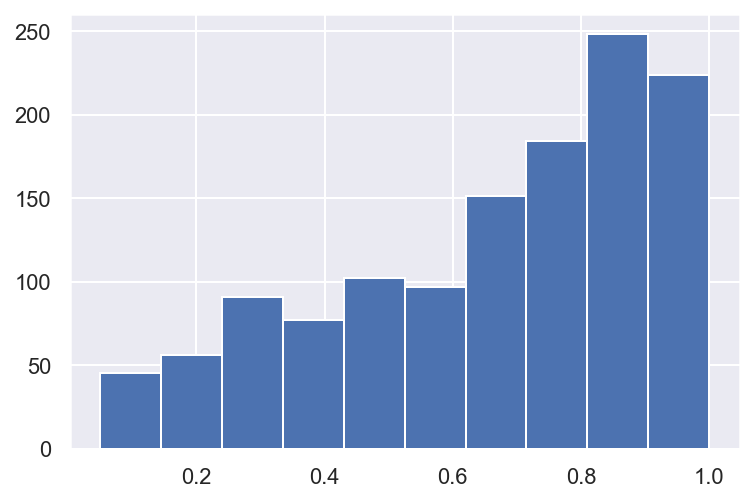

0.6640566382051046


In [18]:
plt.hist(chi2_tests)
plt.show()
print(np.mean(chi2_tests))

In [19]:
sum([x<alpha for x in chi2_tests])

0

Что если у нас мало данных, мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку, предположения критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно ?

В таком случае прибегают к так называемому точному критерию Фишера. Этот критерий не использует приближений и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

In [20]:
_treatment = 1
chi2_tests = []
for state in tqdm.tqdm(state_combinations):
    array_crosstab = pd.crosstab(df[(df['treatment']==_treatment)&
                                    (df['state'].isin(state))]['state'],
                                 df[(df['treatment']==_treatment)&
                                    (df['state'].isin(state))]['churn']).values
    
    _, p_value = sp.stats.fisher_exact(array_crosstab)
    chi2_tests.append(p_value)

100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:35<00:00, 35.84it/s]


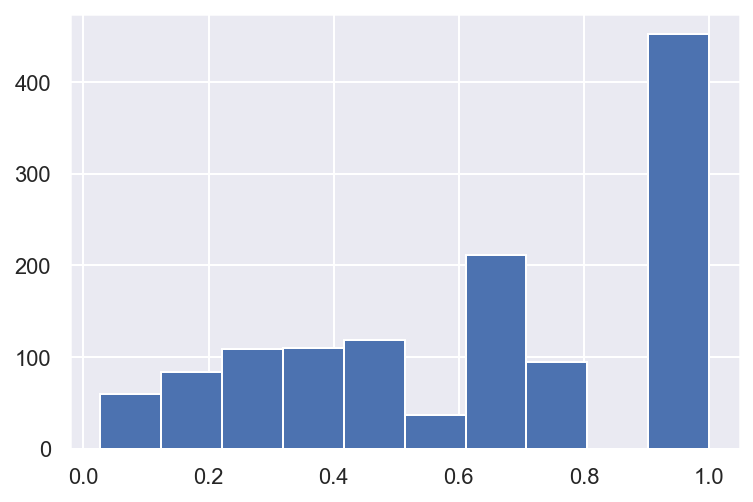

0.6483383060020682


In [21]:
plt.hist(chi2_tests)
plt.show()
print(np.mean(chi2_tests))

In [22]:
sum([x<alpha for x in chi2_tests])

10

Рассмотрим пару признаков day_calls (сколько пользователь совершил дневных звонков) и mes_estim (оценка интенсивности пользования интернет мессенджерами). Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость. 

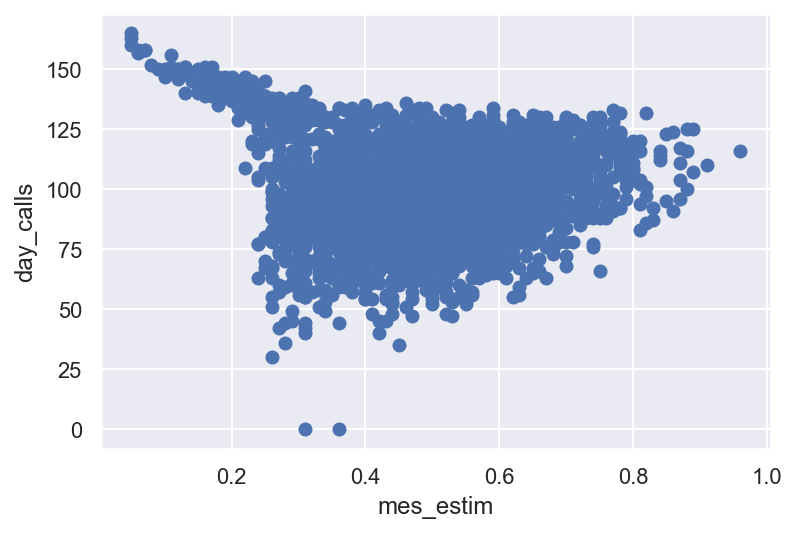

In [23]:
plt.scatter(df['mes_estim'], df['day_calls'])
plt.xlabel('mes_estim')
plt.ylabel('day_calls')
plt.show()

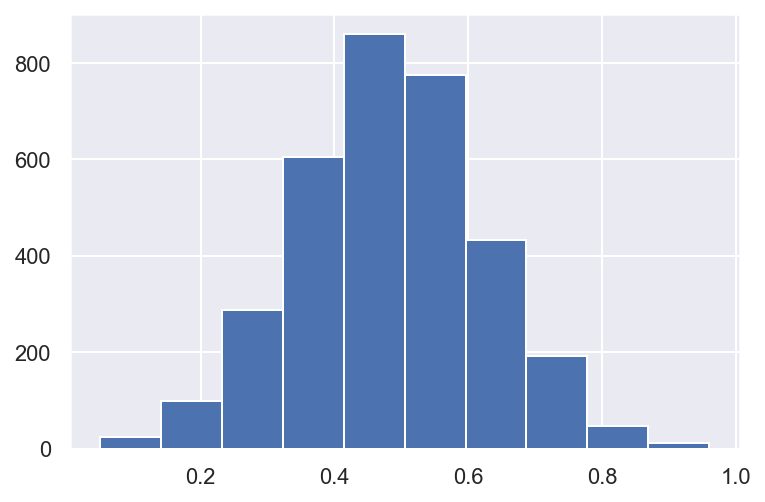

In [24]:
df['mes_estim'].hist()

R^2: 0.9992102527838347


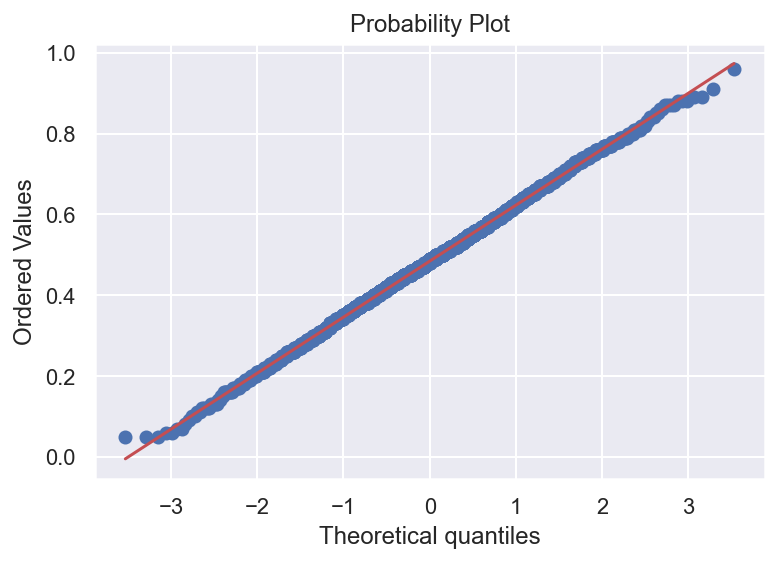

In [25]:
(osm, osr), (slope, intercept, r) = sp.stats.probplot(df['mes_estim'], dist="norm", fit=True, plot=plt)
print(f'R^2: {r**2}')
plt.show()

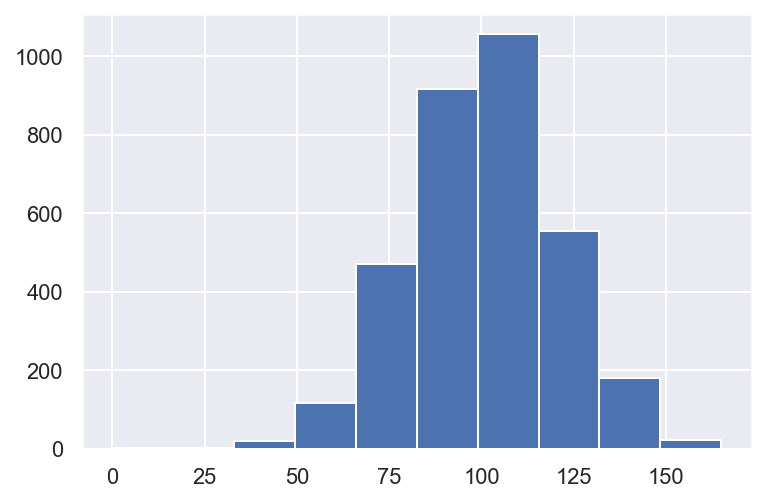

In [26]:
df['day_calls'].hist()

R^2: 0.9978046001302049


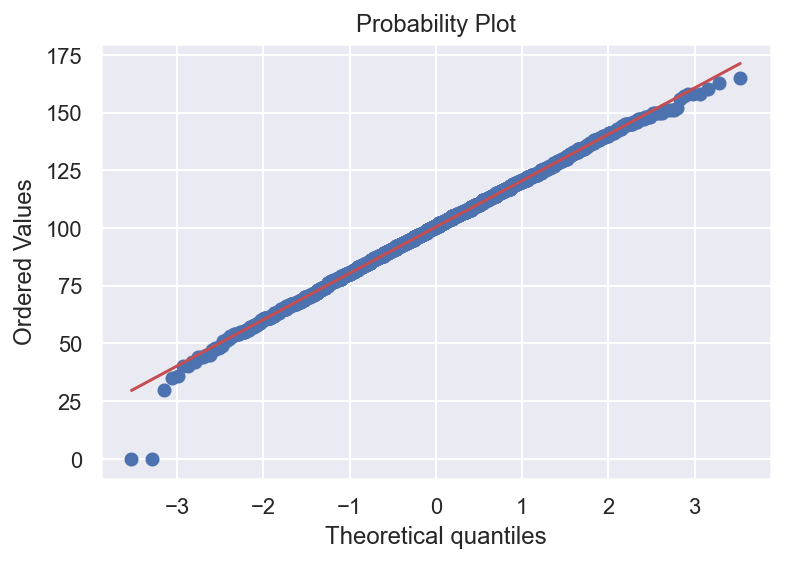

In [27]:
(osm, osr), (slope, intercept, r) = sp.stats.probplot(df['day_calls'], dist="norm", fit=True, plot=plt)
print(f'R^2: {r**2}')
plt.show()

In [28]:
df[['mes_estim', 'day_calls']].corr(method = 'pearson')

,mes_estim,day_calls
mes_estim,1.000000,-0.051794
day_calls,-0.051794,1.000000


In [29]:
# Оценим корреляцию Пирсона на значимость, используя двухсторонний тест

In [30]:
corrcoef = df[['mes_estim', 'day_calls']].corr(method = 'pearson').values[0,1]
corrcoef

-0.051794350587572605

In [31]:
n = df.shape[0]
dof = n-2

In [32]:
t_stat = (corrcoef*np.sqrt(n-2)) / (np.sqrt(1-corrcoef**2))
t_stat

-2.993319137573968

In [33]:
p_value = 2*(1-sp.stats.t(dof).cdf(np.abs(t_stat)))
p_value

0.00277988368697768

Для корреляции Пирсона: p_value < alpha=0.05 = > H0: corrcoef=0 отвергается с alpha=0.05, корреляция значима.

In [34]:
corrcoef = df[['mes_estim', 'day_calls']].corr(method = 'spearman').values[0,1]
corrcoef

0.043349880533927444

In [35]:
n = df.shape[0]
dof = n-2
t_stat = (corrcoef*np.sqrt(n-2)) / (np.sqrt(1-corrcoef**2))
t_stat

2.5042845313829765

In [36]:
p_value = 2*(1-sp.stats.t(dof).cdf(np.abs(t_stat)))
p_value

0.012317367189170536

Для корреляции Спирмена: p_value < alpha=0.05 = > H0: corrcoef=0 отвергается с alpha=0.05, корреляция значима.

Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1). 

In [37]:
df[df['treatment']==1]['state'].nunique()

51

In [38]:
df[df['treatment']==1]['churn'].nunique()

2

In [39]:
def cramers_v(var1, var2):
    
    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    stat = sp.stats.chi2_contingency(crosstab)[0] 
    n = np.sum(crosstab) 
    mini = min(crosstab.shape)-1
    return (stat/(n*mini))

In [40]:
cramers_v(df[df['treatment']==1]['state'].values, 
          df[df['treatment']==1]['churn'].values)

0.04015744062618549

In [41]:
def check_chi2_requirements(var1, var2):

    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    k1 = crosstab.shape[0]
    k2 = crosstab.shape[1]
    n = np.sum(crosstab) 
    
    fractions = []
    for i in range(k1):
        for j in range(k2):
            fractions.append( (sum(crosstab[i, :]) * sum(crosstab[:, j]))/n   )
            
    check_list = [x<5 for x in fractions]
    print(sum(check_list)/len(check_list))
    assert n >= 40
    assert sum(check_list)/len(check_list) <= 0.2

In [42]:
def chi2_significance_test(var1, var2):
    
    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    k1 = crosstab.shape[0]
    k2 = crosstab.shape[1]
    n = np.sum(crosstab) 
    
    chi2_stat = 0
    for i in range(k1):
        for j in range(k2):
            
            chi2_stat += (crosstab[i, j]**2)/(sum(crosstab[i, :]) * sum(crosstab[:, j]))
    chi2_stat = n*(chi2_stat-1)
    p_value = 1-sp.stats.chi2(k1, k2).cdf(chi2_stat)
    return chi2_stat, p_value

In [43]:
check_chi2_requirements(df[df['treatment']==1]['state'].values, 
                        df[df['treatment']==1]['churn'].values)

0.4803921568627451


AssertionError: 

In [44]:
chi2_significance_test(df[df['treatment']==1]['state'].values, 
                       df[df['treatment']==1]['churn'].values)

(44.05271236692529, 0.8096701366109758)

In [45]:
df['churn'] = df['churn'].map({'False.': 0, 'True.':  1})

In [46]:
df.head()

,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,0
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,0
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,0
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,0
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,0


In [47]:
df2 = pd.DataFrame(df.groupby(by=['state', 'treatment'])['churn'].sum()).reset_index()
df2.head()

,state,treatment,churn
0,AK,0,2
1,AK,1,1
2,AK,2,0
3,AL,0,1
4,AL,1,5


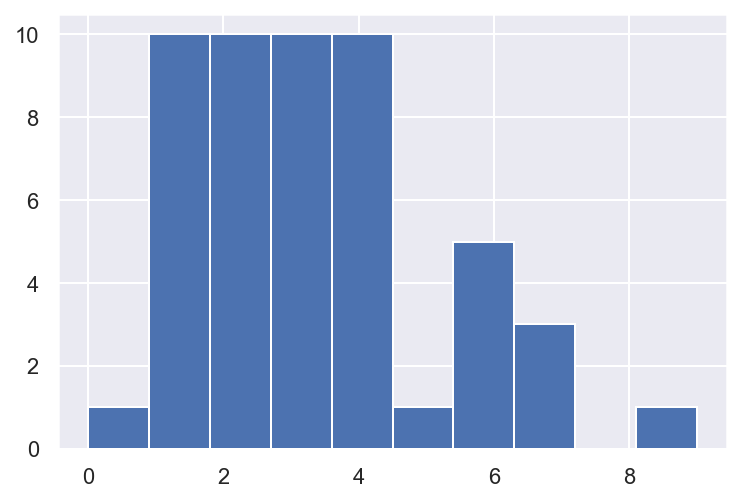

In [48]:
df2[df2['treatment']==0]['churn'].hist()

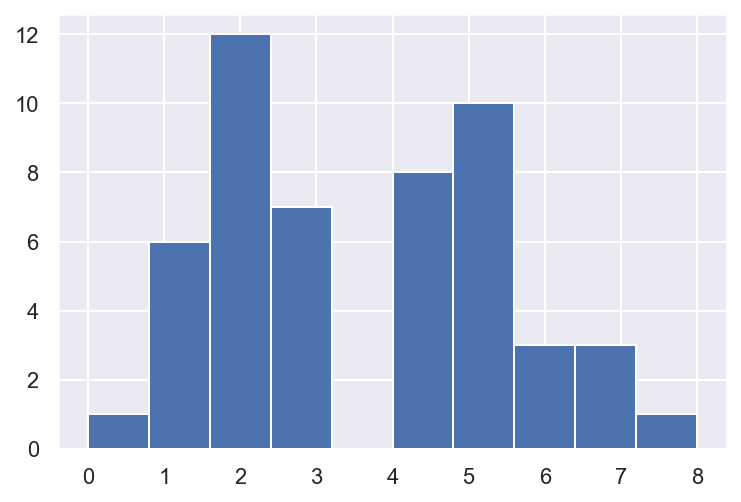

In [49]:
df2[df2['treatment']==1]['churn'].hist()

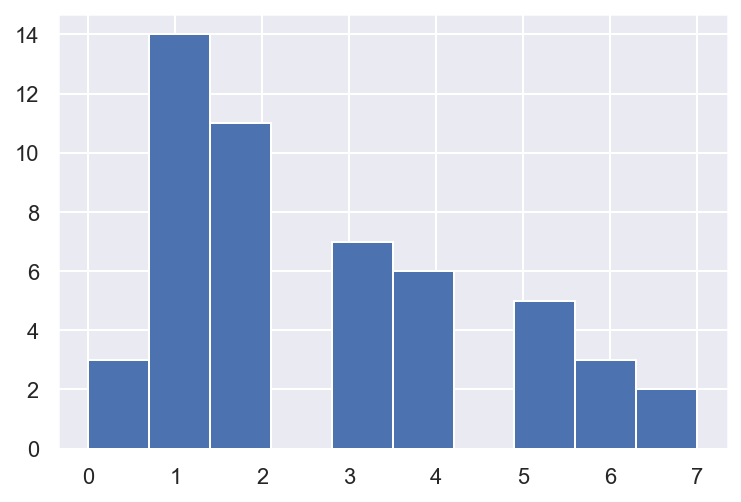

In [50]:
df2[df2['treatment']==2]['churn'].hist()

In [51]:
df2[df2['treatment']==0].sort_values(by=['churn'], ascending=False).head()

,state,treatment,churn
75,MS,0,9
129,TX,0,7
111,OR,0,7
93,NJ,0,7
60,MD,0,6


In [52]:
df2[df2['treatment']==1].sort_values(by=['churn'], ascending=False).head()

,state,treatment,churn
64,ME,1,8
58,MA,1,7
49,KS,1,7
142,WA,1,7
103,NY,1,6


In [53]:
df2[df2['treatment']==2].sort_values(by=['churn'], ascending=False).head()

,state,treatment,churn
95,NJ,2,7
71,MN,2,7
110,OK,2,6
62,MD,2,6
122,SC,2,6


Оценим двухсторонние доверительные интервалы для долей клиентов, переставших пользоваться услугами оператора

In [54]:
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.proportion import proportion_confint

In [55]:
alpha = 0.05

In [56]:
_treatment = 1
p_churn = df[df['treatment']==_treatment]['churn'].sum() / df[df['treatment']==_treatment]['churn'].count()
n = df[df['treatment']==_treatment]['churn'].shape[0]

z_alpha = sp.stats.norm.ppf(q=1-alpha/2)
zconf_const = z_alpha * np.sqrt( (p_churn*(1-p_churn) )/n)

print(p_churn)
[p_churn-zconf_const, p_churn+zconf_const]

0.1640838650865998


[0.14216797720187604, 0.18599975297132357]

In [57]:
# Проверка автоматизированными средствами
normal_interval = proportion_confint(df[df['treatment']==_treatment]['churn'].sum(),
                                     df[df['treatment']==_treatment]['churn'].count(),
                                     method = 'normal')
print('normal_interval [%f, %f] with width %f' % (normal_interval[0],
                                                  normal_interval[1], 
                                                  normal_interval[1] - normal_interval[0]))

normal_interval [0.142168, 0.186000] with width 0.043832


---

In [58]:
_treatment = 0
p_churn = df[df['treatment']==_treatment]['churn'].sum() / df[df['treatment']==_treatment]['churn'].count()
n = df[df['treatment']==_treatment]['churn'].shape[0]

z_alpha = sp.stats.norm.ppf(q=1-alpha/2)
zconf_const = z_alpha * np.sqrt( (p_churn*(1-p_churn) )/n)

print(p_churn)
[p_churn-zconf_const, p_churn+zconf_const]

0.14563106796116504


[0.12509189855388805, 0.16617023736844203]

In [59]:
# Проверка автоматизированными средствами
normal_interval = proportion_confint(df[df['treatment']==_treatment]['churn'].sum(),
                                     df[df['treatment']==_treatment]['churn'].count(),
                                     method = 'normal')
print('normal_interval [%f, %f] with width %f' % (normal_interval[0],
                                                  normal_interval[1], 
                                                  normal_interval[1] - normal_interval[0]))

normal_interval [0.125092, 0.166170] with width 0.041078


---

In [60]:
_treatment = 2
p_churn = df[df['treatment']==_treatment]['churn'].sum() / df[df['treatment']==_treatment]['churn'].count()
n = df[df['treatment']==_treatment]['churn'].shape[0]

z_alpha = sp.stats.norm.ppf(q=1-alpha/2)
zconf_const = z_alpha * np.sqrt( (p_churn*(1-p_churn) )/n)

print(p_churn)
[p_churn-zconf_const, p_churn+zconf_const]

0.12511332728921123


[0.10558846307607084, 0.14463819150235163]

In [61]:
# Проверка автоматизированными средствами
normal_interval = proportion_confint(df[df['treatment']==_treatment]['churn'].sum(),
                                     df[df['treatment']==_treatment]['churn'].count(),
                                     method = 'normal')
print('normal_interval [%f, %f] with width %f' % (normal_interval[0],
                                                  normal_interval[1], 
                                                  normal_interval[1] - normal_interval[0]))

normal_interval [0.105588, 0.144638] with width 0.039050


Доверительные интервалы для двух разных воздействий пересекаются с интервалом контрольной группы, нельзя однозначно выделить какую-то группу, воздействие которой точно помогло снизить отток клиентов.

В таком случае возникает две гипотезы - равняется ли доля оттока в контрольной группе долям в каждой из групп некоторого воздействия:

1.
* H0: p(treatment=1) = p(treatment=0)
* H1: p(treatment=1) != p(treatment=0)

2.
* H0: p(treatment=1) = p(treatment=2)
* H1: p(treatment=1) != p(treatment=2)

Применим поправку Холма к результатам достигаемых уровней значимости с целью соблюдения высокой мощности поправки на множественное сравнение.

In [62]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = sp.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [63]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [64]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - sp.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return sp.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sp.stats.norm.cdf(z_stat)

In [65]:
p_value_list = []

In [66]:
_treatment = 0
p_churn1 = df[df['treatment']==1]['churn'].sum() / df[df['treatment']==1]['churn'].count()
n1 = df[df['treatment']==1].shape[0]
p_churn2 = df[df['treatment']==_treatment]['churn'].sum() / df[df['treatment']==_treatment]['churn'].count()
n2 = df[df['treatment']==_treatment].shape[0]

In [69]:
z_alpha = sp.stats.norm.ppf(q=1-alpha/2)
zconf_const = np.sqrt( ((p_churn1*(1-p_churn1))/n1)   + ((p_churn2*(1-p_churn2))/n2) )
delta_p = p_churn1 - p_churn2

[delta_p - z_alpha*zconf_const,   delta_p + z_alpha*zconf_const]

[-0.011583241590025106, 0.04848883584089464]

In [70]:
p_weighted = (p_churn1*n1 + p_churn2*n2)/(n1+n2)
z_stat = (p_churn1-p_churn2)/np.sqrt( ( p_weighted*(1-p_weighted) ) * ((1/n1) + (1/n2)  ) )
p_value_1_2 = 2*(1-sp.stats.norm.cdf(np.abs(z_stat)))
print(z_stat, p_value_1_2)

1.2046688551240339 0.2283311639045107


In [71]:
p_value_list.append(p_value_1_2)
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(df[df['treatment']==1]['churn'].values,
                                                                          df[df['treatment']==0]['churn'].values)))

p-value: 0.228331


In [72]:
_treatment = 2
p_churn1 = df[df['treatment']==1]['churn'].sum() / df[df['treatment']==1]['churn'].count()
n1 = df[df['treatment']==1].shape[0]
p_churn2 = df[df['treatment']==_treatment]['churn'].sum() / df[df['treatment']==_treatment]['churn'].count()
n2 = df[df['treatment']==_treatment].shape[0]

In [73]:
z_alpha = sp.stats.norm.ppf(q=1-alpha/2)
zconf_const = np.sqrt( ((p_churn1*(1-p_churn1))/n1)   + ((p_churn2*(1-p_churn2))/n2) )
delta_p = p_churn1 - p_churn2

[delta_p - z_alpha*zconf_const,   delta_p + z_alpha*zconf_const]

[0.00961876673809212, 0.06832230885668503]

In [74]:
p_weighted = (p_churn1*n1 + p_churn2*n2)/(n1+n2)
z_stat = (p_churn1-p_churn2)/np.sqrt( ( p_weighted*(1-p_weighted) ) * ((1/n1) + (1/n2)  ) )
p_value_1_2 = 2*(1-sp.stats.norm.cdf(np.abs(z_stat)))
print(z_stat, p_value_1_2)

2.599054820975787 0.009348084294451109


In [75]:
p_value_list.append(p_value_1_2)
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(df[df['treatment']==1]['churn'].values,
                                                                          df[df['treatment']==2]['churn'].values)))

p-value: 0.009348


In [76]:
proportions_diff_confint_ind(df[df['treatment']==0]['churn'].values, 
                             df[df['treatment']==2]['churn'].values)

(-0.007820886720395197, 0.04885636806430281)

In [77]:
p_val = proportions_diff_z_test(proportions_diff_z_stat_ind(df[df['treatment']==0]['churn'].values,
                                                            df[df['treatment']==2]['churn'].values))
print("p-value: %f" % p_val)
p_value_list.append(p_val)

p-value: 0.156425


In [78]:
p_value_list

[0.2283311639045107, 0.009348084294451109, 0.1564246886050802]

In [79]:
_, p_values_corrected, _, _ = multipletests(p_value_list, method='holm')
p_values_corrected

array([0.31284938, 0.02804425, 0.31284938])